In [1]:
#====================================================================
#-- Project      : EE239 Final Project
#-- File Name    : RNN_LSTM_For_EEG.ipynb
#-- Description  : EEG signal processing by RNN_LSTM
#-- Date         : 03/13/2018
#-- Author       : Wenfei Lu
#====================================================================

In [2]:
from __future__ import print_function

import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras import initializers
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn import metrics
import h5py
import os

/Users/luwenfei/Desktop/EE239A/HW1/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
batch_size = 100
num_classes = 4
epochs = 1000
hidden_units = 64
learning_rate = 0.1

## Train subject1 to predict subject1

In [111]:
A01T = h5py.File('A01T_slice.mat', 'r')
X = np.copy(A01T['image'])
y = np.copy(A01T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

(288, 1000, 22)
(288, 1)


In [112]:
def get_train_test(X, y, num_test = 50, num_train = 238, num_val = 50, 
                   subtract_mean=True):
    mask = list(range(num_train))
    X_train = X[mask]
    y_train = y[mask]
    mask = list(range(num_val))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_train,num_train+num_test))
    X_test = X[mask]
    y_test = y[mask]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
#     if subtract_mean:
#         mean_image = np.mean(X_train, axis=0)
#         X_train -= mean_image
#         X_val -= mean_image
#         X_test -= mean_image
        
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }
# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [113]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [102]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = [0]

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(self.times[-1]+time.time() - self.epoch_time_start)
        
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.testaccuracy = []

    def on_epoch_end(self, batch, logs={}):
        self.testaccuracy.append(logs.get('val_acc'))

In [117]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=100,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 100, 25)           575       
_________________________________________________________________
dropout_138 (Dropout)        (None, 100, 25)           0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 4, 25)             15650     
_________________________________________________________________
dropout_139 (Dropout)        (None, 4, 25)             0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2, 25)             0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 2, 100)            50400     
_________________________________________________________________
dropout_140 (Dropout)        (None, 2, 100)            0         
__________

238/238 [==============================] - 0s 532us/step - loss: 1.6534 - acc: 0.3655 - val_loss: 1.6597 - val_acc: 0.3200
Epoch 49/1000
238/238 [==============================] - 0s 483us/step - loss: 1.6471 - acc: 0.3571 - val_loss: 1.6559 - val_acc: 0.3200
Epoch 50/1000
238/238 [==============================] - 0s 457us/step - loss: 1.6371 - acc: 0.3277 - val_loss: 1.6525 - val_acc: 0.3000
Epoch 51/1000
238/238 [==============================] - 0s 432us/step - loss: 1.6605 - acc: 0.3277 - val_loss: 1.6497 - val_acc: 0.3000
Epoch 52/1000
238/238 [==============================] - 0s 428us/step - loss: 1.6419 - acc: 0.3319 - val_loss: 1.6473 - val_acc: 0.3200
Epoch 53/1000
238/238 [==============================] - 0s 407us/step - loss: 1.6272 - acc: 0.3529 - val_loss: 1.6449 - val_acc: 0.3200
Epoch 54/1000
238/238 [==============================] - 0s 444us/step - loss: 1.6299 - acc: 0.3697 - val_loss: 1.6419 - val_acc: 0.3400
Epoch 55/1000
238/238 [==============================] 

Epoch 108/1000
238/238 [==============================] - 0s 468us/step - loss: 1.3715 - acc: 0.4664 - val_loss: 1.4889 - val_acc: 0.4200
Epoch 109/1000
238/238 [==============================] - 0s 438us/step - loss: 1.3766 - acc: 0.4706 - val_loss: 1.4813 - val_acc: 0.4800
Epoch 110/1000
238/238 [==============================] - 0s 468us/step - loss: 1.3843 - acc: 0.4664 - val_loss: 1.4768 - val_acc: 0.4800
Epoch 111/1000
238/238 [==============================] - 0s 441us/step - loss: 1.3831 - acc: 0.4664 - val_loss: 1.4798 - val_acc: 0.4600
Epoch 112/1000
238/238 [==============================] - 0s 469us/step - loss: 1.3856 - acc: 0.4622 - val_loss: 1.4672 - val_acc: 0.4600
Epoch 113/1000
238/238 [==============================] - 0s 455us/step - loss: 1.3746 - acc: 0.4286 - val_loss: 1.4606 - val_acc: 0.4200
Epoch 114/1000
238/238 [==============================] - 0s 475us/step - loss: 1.3976 - acc: 0.4916 - val_loss: 1.4619 - val_acc: 0.4200
Epoch 115/1000
238/238 [==========

238/238 [==============================] - 0s 440us/step - loss: 1.0975 - acc: 0.6176 - val_loss: 1.4934 - val_acc: 0.4000
Epoch 168/1000
238/238 [==============================] - 0s 451us/step - loss: 1.1604 - acc: 0.5462 - val_loss: 1.4505 - val_acc: 0.4200
Epoch 169/1000
238/238 [==============================] - 0s 422us/step - loss: 1.1204 - acc: 0.5756 - val_loss: 1.4278 - val_acc: 0.3800
Epoch 170/1000
238/238 [==============================] - 0s 459us/step - loss: 1.0922 - acc: 0.6050 - val_loss: 1.4252 - val_acc: 0.4000
Epoch 171/1000
238/238 [==============================] - 0s 445us/step - loss: 1.1016 - acc: 0.5462 - val_loss: 1.4313 - val_acc: 0.4400
Epoch 172/1000
238/238 [==============================] - 0s 470us/step - loss: 1.0589 - acc: 0.6176 - val_loss: 1.4386 - val_acc: 0.4400
Epoch 173/1000
238/238 [==============================] - 0s 451us/step - loss: 1.0966 - acc: 0.6050 - val_loss: 1.4522 - val_acc: 0.4400
Epoch 174/1000
238/238 [=========================

238/238 [==============================] - 0s 441us/step - loss: 0.9053 - acc: 0.6807 - val_loss: 1.5934 - val_acc: 0.4800
Epoch 227/1000
238/238 [==============================] - 0s 465us/step - loss: 0.9155 - acc: 0.6597 - val_loss: 1.5803 - val_acc: 0.4800
Epoch 228/1000
238/238 [==============================] - 0s 433us/step - loss: 0.9328 - acc: 0.6597 - val_loss: 1.5993 - val_acc: 0.4800
Epoch 229/1000
238/238 [==============================] - 0s 456us/step - loss: 0.8657 - acc: 0.7395 - val_loss: 1.6259 - val_acc: 0.4600
Epoch 230/1000
238/238 [==============================] - 0s 414us/step - loss: 0.9376 - acc: 0.6555 - val_loss: 1.5642 - val_acc: 0.4800
Epoch 231/1000
238/238 [==============================] - 0s 452us/step - loss: 0.9293 - acc: 0.7017 - val_loss: 1.4934 - val_acc: 0.4600
Epoch 232/1000
238/238 [==============================] - 0s 449us/step - loss: 0.9907 - acc: 0.6555 - val_loss: 1.4408 - val_acc: 0.4800
Epoch 233/1000
238/238 [=========================

238/238 [==============================] - 0s 442us/step - loss: 0.8184 - acc: 0.7101 - val_loss: 1.6312 - val_acc: 0.4000
Epoch 286/1000
238/238 [==============================] - 0s 421us/step - loss: 0.9203 - acc: 0.7059 - val_loss: 1.6422 - val_acc: 0.4200
Epoch 287/1000
238/238 [==============================] - 0s 433us/step - loss: 0.8632 - acc: 0.7143 - val_loss: 1.6433 - val_acc: 0.4000
Epoch 288/1000
238/238 [==============================] - 0s 430us/step - loss: 0.8696 - acc: 0.7605 - val_loss: 1.5677 - val_acc: 0.4200
Epoch 289/1000
238/238 [==============================] - 0s 463us/step - loss: 0.9003 - acc: 0.7101 - val_loss: 1.6199 - val_acc: 0.4400
Epoch 290/1000
238/238 [==============================] - 0s 429us/step - loss: 0.9134 - acc: 0.6891 - val_loss: 1.6935 - val_acc: 0.4000
Epoch 291/1000
238/238 [==============================] - 0s 469us/step - loss: 0.9107 - acc: 0.6765 - val_loss: 1.6658 - val_acc: 0.4400
Epoch 292/1000
238/238 [=========================

238/238 [==============================] - 0s 492us/step - loss: 0.8441 - acc: 0.7815 - val_loss: 1.7194 - val_acc: 0.3800
Epoch 345/1000
238/238 [==============================] - 0s 440us/step - loss: 0.8420 - acc: 0.7311 - val_loss: 1.7310 - val_acc: 0.3600
Epoch 346/1000
238/238 [==============================] - 0s 493us/step - loss: 0.8286 - acc: 0.7395 - val_loss: 1.6029 - val_acc: 0.3800
Epoch 347/1000
238/238 [==============================] - 0s 444us/step - loss: 0.8485 - acc: 0.7353 - val_loss: 1.5630 - val_acc: 0.4200
Epoch 348/1000
238/238 [==============================] - 0s 462us/step - loss: 0.8291 - acc: 0.7815 - val_loss: 1.5988 - val_acc: 0.4200
Epoch 349/1000
238/238 [==============================] - 0s 436us/step - loss: 0.8447 - acc: 0.7185 - val_loss: 1.6545 - val_acc: 0.4800
Epoch 350/1000
238/238 [==============================] - 0s 464us/step - loss: 0.8330 - acc: 0.7521 - val_loss: 1.6550 - val_acc: 0.3800
Epoch 351/1000
238/238 [=========================

238/238 [==============================] - 0s 442us/step - loss: 0.8007 - acc: 0.7899 - val_loss: 1.7279 - val_acc: 0.3800
Epoch 404/1000
238/238 [==============================] - 0s 435us/step - loss: 0.7731 - acc: 0.7857 - val_loss: 1.6772 - val_acc: 0.4000
Epoch 405/1000
238/238 [==============================] - 0s 480us/step - loss: 0.8545 - acc: 0.7815 - val_loss: 1.6520 - val_acc: 0.4200
Epoch 406/1000
238/238 [==============================] - 0s 429us/step - loss: 0.8051 - acc: 0.7731 - val_loss: 1.6791 - val_acc: 0.4200
Epoch 407/1000
238/238 [==============================] - 0s 454us/step - loss: 0.8045 - acc: 0.7773 - val_loss: 1.7193 - val_acc: 0.4200
Epoch 408/1000
238/238 [==============================] - 0s 428us/step - loss: 0.8300 - acc: 0.7857 - val_loss: 1.7937 - val_acc: 0.3600
Epoch 409/1000
238/238 [==============================] - 0s 459us/step - loss: 0.7185 - acc: 0.8361 - val_loss: 1.7423 - val_acc: 0.3800
Epoch 410/1000
238/238 [=========================

238/238 [==============================] - 0s 565us/step - loss: 0.7494 - acc: 0.8151 - val_loss: 1.8503 - val_acc: 0.4200
Epoch 463/1000
238/238 [==============================] - 0s 439us/step - loss: 0.8178 - acc: 0.7857 - val_loss: 1.8257 - val_acc: 0.4600
Epoch 464/1000
238/238 [==============================] - 0s 454us/step - loss: 0.7132 - acc: 0.8193 - val_loss: 1.7844 - val_acc: 0.4200
Epoch 465/1000
238/238 [==============================] - 0s 425us/step - loss: 0.6789 - acc: 0.8529 - val_loss: 1.7399 - val_acc: 0.4800
Epoch 466/1000
238/238 [==============================] - 0s 419us/step - loss: 0.6627 - acc: 0.8697 - val_loss: 1.7731 - val_acc: 0.4400
Epoch 467/1000
238/238 [==============================] - 0s 423us/step - loss: 0.7707 - acc: 0.8277 - val_loss: 1.7995 - val_acc: 0.4400
Epoch 468/1000
238/238 [==============================] - 0s 420us/step - loss: 0.6984 - acc: 0.8445 - val_loss: 1.8238 - val_acc: 0.4400
Epoch 469/1000
238/238 [=========================

238/238 [==============================] - 0s 492us/step - loss: 0.6755 - acc: 0.8109 - val_loss: 1.6939 - val_acc: 0.4200
Epoch 522/1000
238/238 [==============================] - 0s 459us/step - loss: 0.7208 - acc: 0.8109 - val_loss: 1.8193 - val_acc: 0.3600
Epoch 523/1000
238/238 [==============================] - 0s 492us/step - loss: 0.6828 - acc: 0.8571 - val_loss: 1.8379 - val_acc: 0.3800
Epoch 524/1000
238/238 [==============================] - 0s 441us/step - loss: 0.8044 - acc: 0.7983 - val_loss: 1.8823 - val_acc: 0.3200
Epoch 525/1000
238/238 [==============================] - 0s 500us/step - loss: 0.6661 - acc: 0.8571 - val_loss: 1.8909 - val_acc: 0.3800
Epoch 526/1000
238/238 [==============================] - ETA: 0s - loss: 0.7223 - acc: 0.860 - 0s 511us/step - loss: 0.6742 - acc: 0.8866 - val_loss: 1.9807 - val_acc: 0.4000
Epoch 527/1000
238/238 [==============================] - 0s 444us/step - loss: 0.6984 - acc: 0.8655 - val_loss: 2.0135 - val_acc: 0.3600
Epoch 528/1

238/238 [==============================] - 0s 500us/step - loss: 0.7492 - acc: 0.8319 - val_loss: 1.8627 - val_acc: 0.4000
Epoch 581/1000
238/238 [==============================] - 0s 418us/step - loss: 0.6437 - acc: 0.8529 - val_loss: 1.9629 - val_acc: 0.4000
Epoch 582/1000
238/238 [==============================] - 0s 417us/step - loss: 0.6555 - acc: 0.8613 - val_loss: 1.8457 - val_acc: 0.4400
Epoch 583/1000
238/238 [==============================] - 0s 436us/step - loss: 0.7404 - acc: 0.8319 - val_loss: 1.7779 - val_acc: 0.4400
Epoch 584/1000
238/238 [==============================] - 0s 430us/step - loss: 0.6405 - acc: 0.8655 - val_loss: 1.7620 - val_acc: 0.4600
Epoch 585/1000
238/238 [==============================] - 0s 462us/step - loss: 0.6388 - acc: 0.8782 - val_loss: 1.8509 - val_acc: 0.4000
Epoch 586/1000
238/238 [==============================] - 0s 427us/step - loss: 0.7168 - acc: 0.8361 - val_loss: 1.8399 - val_acc: 0.4400
Epoch 587/1000
238/238 [=========================

238/238 [==============================] - 0s 464us/step - loss: 0.7288 - acc: 0.8361 - val_loss: 1.9324 - val_acc: 0.3600
Epoch 640/1000
238/238 [==============================] - 0s 468us/step - loss: 0.7075 - acc: 0.8361 - val_loss: 1.9454 - val_acc: 0.3400
Epoch 641/1000
238/238 [==============================] - 0s 455us/step - loss: 0.6397 - acc: 0.8697 - val_loss: 1.8961 - val_acc: 0.4600
Epoch 642/1000
238/238 [==============================] - 0s 454us/step - loss: 0.7112 - acc: 0.8529 - val_loss: 1.7875 - val_acc: 0.4600
Epoch 643/1000
238/238 [==============================] - 0s 505us/step - loss: 0.6979 - acc: 0.8739 - val_loss: 1.7252 - val_acc: 0.5200
Epoch 644/1000
238/238 [==============================] - 0s 433us/step - loss: 0.6755 - acc: 0.8739 - val_loss: 1.7040 - val_acc: 0.4400
Epoch 645/1000
238/238 [==============================] - 0s 453us/step - loss: 0.7380 - acc: 0.8571 - val_loss: 1.6283 - val_acc: 0.4600
Epoch 646/1000
238/238 [=========================

238/238 [==============================] - 0s 432us/step - loss: 0.5852 - acc: 0.8992 - val_loss: 1.6796 - val_acc: 0.4600
Epoch 699/1000
238/238 [==============================] - 0s 429us/step - loss: 0.6676 - acc: 0.8655 - val_loss: 1.6895 - val_acc: 0.5000
Epoch 700/1000
238/238 [==============================] - 0s 441us/step - loss: 0.7824 - acc: 0.8235 - val_loss: 1.6875 - val_acc: 0.4600
Epoch 701/1000
238/238 [==============================] - 0s 418us/step - loss: 0.7710 - acc: 0.8277 - val_loss: 1.5989 - val_acc: 0.4800
Epoch 702/1000
238/238 [==============================] - 0s 415us/step - loss: 0.6380 - acc: 0.8908 - val_loss: 1.6916 - val_acc: 0.5200
Epoch 703/1000
238/238 [==============================] - 0s 462us/step - loss: 0.6315 - acc: 0.8782 - val_loss: 1.7978 - val_acc: 0.4600
Epoch 704/1000
238/238 [==============================] - 0s 440us/step - loss: 0.7229 - acc: 0.8655 - val_loss: 1.7284 - val_acc: 0.5000
Epoch 705/1000
238/238 [=========================

238/238 [==============================] - 0s 457us/step - loss: 0.6575 - acc: 0.8992 - val_loss: 1.7161 - val_acc: 0.4600
Epoch 758/1000
238/238 [==============================] - 0s 465us/step - loss: 0.5728 - acc: 0.8992 - val_loss: 1.8234 - val_acc: 0.4400
Epoch 759/1000
238/238 [==============================] - 0s 455us/step - loss: 0.6044 - acc: 0.8739 - val_loss: 1.9166 - val_acc: 0.4200
Epoch 760/1000
238/238 [==============================] - 0s 420us/step - loss: 0.6152 - acc: 0.9202 - val_loss: 1.8788 - val_acc: 0.4200
Epoch 761/1000
238/238 [==============================] - 0s 455us/step - loss: 0.6196 - acc: 0.8655 - val_loss: 1.8273 - val_acc: 0.4600
Epoch 762/1000
238/238 [==============================] - 0s 440us/step - loss: 0.6287 - acc: 0.8613 - val_loss: 1.7746 - val_acc: 0.4800
Epoch 763/1000
238/238 [==============================] - 0s 546us/step - loss: 0.6154 - acc: 0.8866 - val_loss: 1.7168 - val_acc: 0.5000
Epoch 764/1000
238/238 [=========================

238/238 [==============================] - 0s 456us/step - loss: 0.6457 - acc: 0.8403 - val_loss: 1.6933 - val_acc: 0.5400
Epoch 817/1000
238/238 [==============================] - 0s 497us/step - loss: 0.5877 - acc: 0.9118 - val_loss: 1.6504 - val_acc: 0.5600
Epoch 818/1000
238/238 [==============================] - 0s 444us/step - loss: 0.5699 - acc: 0.8992 - val_loss: 1.6453 - val_acc: 0.5800
Epoch 819/1000
238/238 [==============================] - 0s 463us/step - loss: 0.5332 - acc: 0.9076 - val_loss: 1.6508 - val_acc: 0.5200
Epoch 820/1000
238/238 [==============================] - 0s 446us/step - loss: 0.6049 - acc: 0.8824 - val_loss: 1.8044 - val_acc: 0.4400
Epoch 821/1000
238/238 [==============================] - 0s 488us/step - loss: 0.6288 - acc: 0.8613 - val_loss: 1.7565 - val_acc: 0.4800
Epoch 822/1000
238/238 [==============================] - 0s 449us/step - loss: 0.5837 - acc: 0.8824 - val_loss: 1.7000 - val_acc: 0.5000
Epoch 823/1000
238/238 [=========================

238/238 [==============================] - 0s 417us/step - loss: 0.5852 - acc: 0.8824 - val_loss: 1.6021 - val_acc: 0.5000
Epoch 876/1000
238/238 [==============================] - 0s 426us/step - loss: 0.5903 - acc: 0.8866 - val_loss: 1.5741 - val_acc: 0.5000
Epoch 877/1000
238/238 [==============================] - 0s 425us/step - loss: 0.6102 - acc: 0.8908 - val_loss: 1.7358 - val_acc: 0.5000
Epoch 878/1000
238/238 [==============================] - 0s 430us/step - loss: 0.5459 - acc: 0.9076 - val_loss: 1.9289 - val_acc: 0.4600
Epoch 879/1000
238/238 [==============================] - 0s 512us/step - loss: 0.6170 - acc: 0.8866 - val_loss: 2.0127 - val_acc: 0.3800
Epoch 880/1000
238/238 [==============================] - 0s 505us/step - loss: 0.6581 - acc: 0.8655 - val_loss: 1.8717 - val_acc: 0.4200
Epoch 881/1000
238/238 [==============================] - 0s 497us/step - loss: 0.5858 - acc: 0.8866 - val_loss: 1.7756 - val_acc: 0.4400
Epoch 882/1000
238/238 [=========================

238/238 [==============================] - 0s 463us/step - loss: 0.5833 - acc: 0.8908 - val_loss: 1.6194 - val_acc: 0.5600
Epoch 935/1000
238/238 [==============================] - 0s 482us/step - loss: 0.5650 - acc: 0.9034 - val_loss: 1.5959 - val_acc: 0.5200
Epoch 936/1000
238/238 [==============================] - 0s 487us/step - loss: 0.5622 - acc: 0.9034 - val_loss: 1.5634 - val_acc: 0.5000
Epoch 937/1000
238/238 [==============================] - 0s 484us/step - loss: 0.5349 - acc: 0.9118 - val_loss: 1.5481 - val_acc: 0.5200
Epoch 938/1000
238/238 [==============================] - 0s 475us/step - loss: 0.5438 - acc: 0.9034 - val_loss: 1.5460 - val_acc: 0.5600
Epoch 939/1000
238/238 [==============================] - 0s 459us/step - loss: 0.6377 - acc: 0.8866 - val_loss: 1.5601 - val_acc: 0.5200
Epoch 940/1000
238/238 [==============================] - 0s 505us/step - loss: 0.5884 - acc: 0.8992 - val_loss: 1.5845 - val_acc: 0.5400
Epoch 941/1000
238/238 [=========================

238/238 [==============================] - 0s 438us/step - loss: 0.5702 - acc: 0.9034 - val_loss: 1.6699 - val_acc: 0.5200
Epoch 994/1000
238/238 [==============================] - 0s 436us/step - loss: 0.5047 - acc: 0.9286 - val_loss: 1.7975 - val_acc: 0.4800
Epoch 995/1000
238/238 [==============================] - 0s 433us/step - loss: 0.5771 - acc: 0.8950 - val_loss: 1.7433 - val_acc: 0.5200
Epoch 996/1000
238/238 [==============================] - 0s 433us/step - loss: 0.5658 - acc: 0.8866 - val_loss: 1.7331 - val_acc: 0.4600
Epoch 997/1000
238/238 [==============================] - 0s 442us/step - loss: 0.5797 - acc: 0.8950 - val_loss: 1.7483 - val_acc: 0.4800
Epoch 998/1000
238/238 [==============================] - 0s 471us/step - loss: 0.4765 - acc: 0.9160 - val_loss: 1.7300 - val_acc: 0.4800
Epoch 999/1000
238/238 [==============================] - 0s 506us/step - loss: 0.5526 - acc: 0.9034 - val_loss: 1.6469 - val_acc: 0.5000
Epoch 1000/1000
238/238 [========================

0.6000000238418579


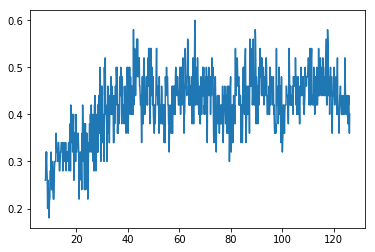

In [116]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

In [109]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/50
238/238 [==============================] - 19s 80ms/step - loss: 1.4045 - acc: 0.2437 - val_loss: 1.4018 - val_acc: 0.2600
Epoch 2/50
238/238 [==============================] - 12s 49ms/step - loss: 1.4098 - acc: 0.2101 - val_loss: 1.3947 - val_acc: 0.2800
Epoch 3/50
238/238 [==============================] - 12s 50ms/step - loss: 1.3716 - acc: 0.2899 - val_loss: 1.3965 - val_acc: 0.2400
Epoch 4/50
238/238 [==============================] - 12s 51ms/step - loss: 1.3641 - acc: 0.3025 - val_loss: 1.4017 - val_acc: 0.2000
Epoch 5/50
238/238 [==============================] - 12s 50ms/step - loss: 1.3575 - acc: 0.3193 - val_loss: 1.4056 - val_acc: 0.1600
Epoch 6/50
238/238 [==============================] - 11s 47ms/step - loss: 1.3597 - acc: 0.2773 - val_loss: 1.4104 - val_acc: 0.1600
Epoch 7/50
238/238 [==============================] - 12s 49ms/step - loss: 1.3507 - acc: 0.3613 - val_loss: 1.4130 - val_acc: 0.1600
Epoch 8/50
238/23

0.3199999928474426


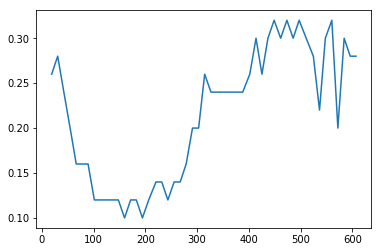

In [110]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

In [47]:
# activation='sigmoid',batch_size=300,learning_rate = 0.001, epochs = 10, loss='categorical_crossentropy'
# bad test accuracy!!!!!
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test)
print('RNN test score:', score[0])
print('RNN test accuracy:', score[1])

Train on 238 samples, validate on 50 samples
Epoch 1/50
238/238 [==============================] - 7s 31ms/step - loss: 1.4407 - acc: 0.2353 - val_loss: 1.4493 - val_acc: 0.1800
Epoch 2/50
238/238 [==============================] - 4s 16ms/step - loss: 1.3630 - acc: 0.2983 - val_loss: 1.4432 - val_acc: 0.2000
Epoch 3/50
238/238 [==============================] - 5s 19ms/step - loss: 1.2955 - acc: 0.3908 - val_loss: 1.4408 - val_acc: 0.2000
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3039 - acc: 0.3866 - val_loss: 1.4396 - val_acc: 0.2200
Epoch 5/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2726 - acc: 0.3950 - val_loss: 1.4419 - val_acc: 0.2800
Epoch 6/50
238/238 [==============================] - 4s 16ms/step - loss: 1.2589 - acc: 0.4286 - val_loss: 1.4407 - val_acc: 0.3000
Epoch 7/50
238/238 [==============================] - 4s 16ms/step - loss: 1.2573 - acc: 0.4496 - val_loss: 1.4510 - val_acc: 0.2600
Epoch 8/50
238/238 [====

### Input preprocessing layer

### Train subject1 and test subject1

In [75]:
#1000 epochs

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 4s 19ms/step - loss: 1.8776 - acc: 0.2689 - val_loss: 1.8716 - val_acc: 0.2200
Epoch 2/1000
238/238 [==============================] - 0s 535us/step - loss: 1.8747 - acc: 0.2689 - val_loss: 1.8665 - val_acc: 0.2400
Epoch 3/1000
238/238 [==============================] - 0s 511us/step - loss: 1.8722 - acc: 0.2563 - val_loss: 1.8608 - val_acc: 0.2000
Epoch 4/1000
238/238 [==============================] - 0s 559us/step - loss: 1.8607 - acc: 0.3109 - val_loss: 1.8525 - val_acc: 0.2400
Epoch 5/1000
238/238 [==============================] - 0s 571us/step - loss: 1.8567 - acc: 0.2521 - val_loss: 1.8442 - val_acc: 0.2200
Epoch 6/1000
238/238 [==============================] - 0s 516us/step - loss: 1.8425 - acc: 0.2773 - val_loss: 1.8352 - val_acc: 0.2800
Epoch 7/1000
238/238 [==============================] - 0s 564us/step - loss: 1.8377 - acc: 0.2437 - val_loss: 1.8267 - val_acc: 0.2600
Epoc

238/238 [==============================] - 0s 623us/step - loss: 1.5026 - acc: 0.3782 - val_loss: 1.5371 - val_acc: 0.2800
Epoch 61/1000
238/238 [==============================] - 0s 578us/step - loss: 1.5102 - acc: 0.3908 - val_loss: 1.5327 - val_acc: 0.3600
Epoch 62/1000
238/238 [==============================] - 0s 573us/step - loss: 1.4983 - acc: 0.3782 - val_loss: 1.5261 - val_acc: 0.3400
Epoch 63/1000
238/238 [==============================] - 0s 569us/step - loss: 1.4953 - acc: 0.3697 - val_loss: 1.5220 - val_acc: 0.3600
Epoch 64/1000
238/238 [==============================] - 0s 550us/step - loss: 1.5022 - acc: 0.3739 - val_loss: 1.5216 - val_acc: 0.3400
Epoch 65/1000
238/238 [==============================] - 0s 544us/step - loss: 1.4919 - acc: 0.3908 - val_loss: 1.5211 - val_acc: 0.3400
Epoch 66/1000
238/238 [==============================] - 0s 545us/step - loss: 1.4925 - acc: 0.3697 - val_loss: 1.5176 - val_acc: 0.3200
Epoch 67/1000
238/238 [==============================] 

Epoch 120/1000
238/238 [==============================] - 0s 492us/step - loss: 1.1785 - acc: 0.5378 - val_loss: 1.4812 - val_acc: 0.3400
Epoch 121/1000
238/238 [==============================] - 0s 522us/step - loss: 1.1573 - acc: 0.5252 - val_loss: 1.4877 - val_acc: 0.2800
Epoch 122/1000
238/238 [==============================] - 0s 504us/step - loss: 1.1300 - acc: 0.5672 - val_loss: 1.4946 - val_acc: 0.2400
Epoch 123/1000
238/238 [==============================] - 0s 519us/step - loss: 1.1421 - acc: 0.5000 - val_loss: 1.4561 - val_acc: 0.3200
Epoch 124/1000
238/238 [==============================] - 0s 514us/step - loss: 1.1606 - acc: 0.5336 - val_loss: 1.4670 - val_acc: 0.3400
Epoch 125/1000
238/238 [==============================] - 0s 528us/step - loss: 1.1270 - acc: 0.5630 - val_loss: 1.4700 - val_acc: 0.3000
Epoch 126/1000
238/238 [==============================] - 0s 509us/step - loss: 1.1729 - acc: 0.5462 - val_loss: 1.4724 - val_acc: 0.3400
Epoch 127/1000
238/238 [==========

238/238 [==============================] - 0s 606us/step - loss: 1.0125 - acc: 0.6303 - val_loss: 1.5014 - val_acc: 0.3600
Epoch 180/1000
238/238 [==============================] - 0s 485us/step - loss: 0.9970 - acc: 0.5924 - val_loss: 1.5909 - val_acc: 0.2800
Epoch 181/1000
238/238 [==============================] - 0s 507us/step - loss: 1.0160 - acc: 0.6218 - val_loss: 1.5786 - val_acc: 0.2800
Epoch 182/1000
238/238 [==============================] - 0s 510us/step - loss: 1.0390 - acc: 0.6134 - val_loss: 1.5240 - val_acc: 0.2600
Epoch 183/1000
238/238 [==============================] - 0s 501us/step - loss: 1.0777 - acc: 0.5840 - val_loss: 1.5380 - val_acc: 0.3000
Epoch 184/1000
238/238 [==============================] - 0s 564us/step - loss: 1.0830 - acc: 0.5798 - val_loss: 1.5558 - val_acc: 0.2600
Epoch 185/1000
238/238 [==============================] - 0s 496us/step - loss: 1.0380 - acc: 0.5840 - val_loss: 1.5685 - val_acc: 0.2400
Epoch 186/1000
238/238 [=========================

238/238 [==============================] - 0s 549us/step - loss: 0.9279 - acc: 0.6345 - val_loss: 1.6136 - val_acc: 0.3000
Epoch 239/1000
238/238 [==============================] - 0s 495us/step - loss: 0.9660 - acc: 0.6681 - val_loss: 1.7040 - val_acc: 0.3400
Epoch 240/1000
238/238 [==============================] - 0s 504us/step - loss: 0.9610 - acc: 0.6303 - val_loss: 1.6188 - val_acc: 0.3000
Epoch 241/1000
238/238 [==============================] - 0s 536us/step - loss: 0.9105 - acc: 0.6303 - val_loss: 1.6378 - val_acc: 0.3600
Epoch 242/1000
238/238 [==============================] - 0s 519us/step - loss: 0.9101 - acc: 0.6891 - val_loss: 1.6470 - val_acc: 0.4200
Epoch 243/1000
238/238 [==============================] - 0s 519us/step - loss: 0.8441 - acc: 0.6471 - val_loss: 1.6763 - val_acc: 0.3200
Epoch 244/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8854 - acc: 0.6597 - val_loss: 1.7414 - val_acc: 0.3600
Epoch 245/1000
238/238 [=========================

238/238 [==============================] - 0s 505us/step - loss: 0.9148 - acc: 0.6597 - val_loss: 1.7048 - val_acc: 0.3200
Epoch 298/1000
238/238 [==============================] - 0s 527us/step - loss: 0.9018 - acc: 0.6681 - val_loss: 1.6588 - val_acc: 0.3200
Epoch 299/1000
238/238 [==============================] - 0s 536us/step - loss: 0.8978 - acc: 0.6807 - val_loss: 1.6858 - val_acc: 0.3600
Epoch 300/1000
238/238 [==============================] - 0s 514us/step - loss: 0.8968 - acc: 0.7059 - val_loss: 1.5058 - val_acc: 0.4200
Epoch 301/1000
238/238 [==============================] - 0s 565us/step - loss: 0.8649 - acc: 0.6807 - val_loss: 1.4714 - val_acc: 0.4000
Epoch 302/1000
238/238 [==============================] - 0s 493us/step - loss: 0.9197 - acc: 0.6261 - val_loss: 1.5127 - val_acc: 0.3400
Epoch 303/1000
238/238 [==============================] - 0s 494us/step - loss: 0.8847 - acc: 0.6723 - val_loss: 1.7161 - val_acc: 0.4000
Epoch 304/1000
238/238 [=========================

238/238 [==============================] - 0s 539us/step - loss: 0.9371 - acc: 0.6975 - val_loss: 1.6087 - val_acc: 0.3400
Epoch 357/1000
238/238 [==============================] - 0s 538us/step - loss: 0.8684 - acc: 0.6933 - val_loss: 1.7331 - val_acc: 0.3200
Epoch 358/1000
238/238 [==============================] - 0s 554us/step - loss: 0.9743 - acc: 0.6723 - val_loss: 1.5498 - val_acc: 0.4200
Epoch 359/1000
238/238 [==============================] - 0s 524us/step - loss: 0.8537 - acc: 0.7059 - val_loss: 1.8251 - val_acc: 0.3600
Epoch 360/1000
238/238 [==============================] - 0s 586us/step - loss: 0.8304 - acc: 0.7185 - val_loss: 1.9632 - val_acc: 0.2800
Epoch 361/1000
238/238 [==============================] - 0s 572us/step - loss: 0.9948 - acc: 0.6134 - val_loss: 1.6980 - val_acc: 0.3800
Epoch 362/1000
238/238 [==============================] - 0s 552us/step - loss: 0.9344 - acc: 0.6681 - val_loss: 1.5893 - val_acc: 0.4200
Epoch 363/1000
238/238 [=========================

238/238 [==============================] - 0s 538us/step - loss: 0.8891 - acc: 0.6639 - val_loss: 1.6163 - val_acc: 0.4800
Epoch 416/1000
238/238 [==============================] - 0s 489us/step - loss: 0.8724 - acc: 0.6849 - val_loss: 1.5741 - val_acc: 0.5200
Epoch 417/1000
238/238 [==============================] - 0s 500us/step - loss: 0.9243 - acc: 0.7101 - val_loss: 1.6586 - val_acc: 0.4600
Epoch 418/1000
238/238 [==============================] - 0s 537us/step - loss: 0.8505 - acc: 0.7605 - val_loss: 1.7424 - val_acc: 0.4800
Epoch 419/1000
238/238 [==============================] - 0s 534us/step - loss: 0.8381 - acc: 0.7227 - val_loss: 1.8307 - val_acc: 0.3400
Epoch 420/1000
238/238 [==============================] - 0s 505us/step - loss: 0.8795 - acc: 0.6933 - val_loss: 1.8554 - val_acc: 0.4000
Epoch 421/1000
238/238 [==============================] - 0s 520us/step - loss: 0.9157 - acc: 0.6723 - val_loss: 1.7067 - val_acc: 0.5200
Epoch 422/1000
238/238 [=========================

238/238 [==============================] - 0s 524us/step - loss: 0.8887 - acc: 0.6597 - val_loss: 1.6519 - val_acc: 0.4000
Epoch 475/1000
238/238 [==============================] - 0s 535us/step - loss: 0.8183 - acc: 0.6765 - val_loss: 1.5666 - val_acc: 0.4800
Epoch 476/1000
238/238 [==============================] - 0s 533us/step - loss: 0.9421 - acc: 0.7017 - val_loss: 1.5030 - val_acc: 0.5000
Epoch 477/1000
238/238 [==============================] - 0s 520us/step - loss: 0.8648 - acc: 0.6429 - val_loss: 1.6150 - val_acc: 0.4000
Epoch 478/1000
238/238 [==============================] - 0s 526us/step - loss: 0.8870 - acc: 0.6555 - val_loss: 1.7047 - val_acc: 0.4200
Epoch 479/1000
238/238 [==============================] - 0s 494us/step - loss: 0.8220 - acc: 0.7017 - val_loss: 1.6258 - val_acc: 0.4400
Epoch 480/1000
238/238 [==============================] - 0s 519us/step - loss: 0.8703 - acc: 0.6639 - val_loss: 1.6288 - val_acc: 0.4200
Epoch 481/1000
238/238 [=========================

238/238 [==============================] - 0s 496us/step - loss: 0.8362 - acc: 0.7227 - val_loss: 1.6496 - val_acc: 0.4200
Epoch 534/1000
238/238 [==============================] - 0s 565us/step - loss: 0.8162 - acc: 0.6849 - val_loss: 1.7235 - val_acc: 0.4800
Epoch 535/1000
238/238 [==============================] - 0s 533us/step - loss: 0.8670 - acc: 0.6765 - val_loss: 1.7398 - val_acc: 0.5200
Epoch 536/1000
238/238 [==============================] - 0s 572us/step - loss: 0.7814 - acc: 0.7185 - val_loss: 1.7457 - val_acc: 0.5200
Epoch 537/1000
238/238 [==============================] - 0s 519us/step - loss: 0.7638 - acc: 0.7017 - val_loss: 1.8783 - val_acc: 0.4800
Epoch 538/1000
238/238 [==============================] - 0s 553us/step - loss: 0.8178 - acc: 0.6681 - val_loss: 1.9917 - val_acc: 0.4400
Epoch 539/1000
238/238 [==============================] - 0s 550us/step - loss: 0.8697 - acc: 0.7059 - val_loss: 1.9034 - val_acc: 0.4000
Epoch 540/1000
238/238 [=========================

238/238 [==============================] - 0s 513us/step - loss: 0.7865 - acc: 0.6849 - val_loss: 1.7080 - val_acc: 0.3800
Epoch 593/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7808 - acc: 0.7017 - val_loss: 1.7428 - val_acc: 0.3800
Epoch 594/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7899 - acc: 0.6681 - val_loss: 1.7566 - val_acc: 0.3600
Epoch 595/1000
238/238 [==============================] - 0s 518us/step - loss: 0.7688 - acc: 0.6891 - val_loss: 1.7489 - val_acc: 0.3800
Epoch 596/1000
238/238 [==============================] - 0s 522us/step - loss: 0.9183 - acc: 0.6765 - val_loss: 1.7522 - val_acc: 0.3600
Epoch 597/1000
238/238 [==============================] - 0s 507us/step - loss: 0.8380 - acc: 0.7059 - val_loss: 1.8609 - val_acc: 0.4600
Epoch 598/1000
238/238 [==============================] - 0s 535us/step - loss: 0.8469 - acc: 0.6597 - val_loss: 1.8381 - val_acc: 0.4600
Epoch 599/1000
238/238 [=========================

238/238 [==============================] - 0s 542us/step - loss: 0.8642 - acc: 0.6639 - val_loss: 1.7705 - val_acc: 0.4400
Epoch 652/1000
238/238 [==============================] - 0s 629us/step - loss: 0.7790 - acc: 0.7185 - val_loss: 1.8423 - val_acc: 0.3800
Epoch 653/1000
238/238 [==============================] - 0s 532us/step - loss: 0.9275 - acc: 0.6933 - val_loss: 1.7496 - val_acc: 0.4400
Epoch 654/1000
238/238 [==============================] - 0s 561us/step - loss: 0.8153 - acc: 0.7269 - val_loss: 1.7047 - val_acc: 0.4600
Epoch 655/1000
238/238 [==============================] - 0s 537us/step - loss: 0.7302 - acc: 0.7647 - val_loss: 1.7327 - val_acc: 0.4600
Epoch 656/1000
238/238 [==============================] - 0s 589us/step - loss: 0.8285 - acc: 0.7059 - val_loss: 1.7557 - val_acc: 0.4800
Epoch 657/1000
238/238 [==============================] - 0s 604us/step - loss: 0.8099 - acc: 0.6933 - val_loss: 1.6949 - val_acc: 0.4800
Epoch 658/1000
238/238 [=========================

238/238 [==============================] - 0s 497us/step - loss: 0.7805 - acc: 0.7143 - val_loss: 1.7550 - val_acc: 0.4600
Epoch 711/1000
238/238 [==============================] - 0s 571us/step - loss: 0.7318 - acc: 0.7311 - val_loss: 1.7862 - val_acc: 0.4000
Epoch 712/1000
238/238 [==============================] - 0s 566us/step - loss: 0.7766 - acc: 0.6723 - val_loss: 1.6901 - val_acc: 0.5400
Epoch 713/1000
238/238 [==============================] - 0s 565us/step - loss: 0.7388 - acc: 0.7101 - val_loss: 1.5881 - val_acc: 0.5800
Epoch 714/1000
238/238 [==============================] - 0s 560us/step - loss: 0.8217 - acc: 0.7227 - val_loss: 1.6527 - val_acc: 0.5000
Epoch 715/1000
238/238 [==============================] - 0s 599us/step - loss: 0.7731 - acc: 0.7017 - val_loss: 1.8914 - val_acc: 0.4200
Epoch 716/1000
238/238 [==============================] - 0s 634us/step - loss: 0.7547 - acc: 0.7311 - val_loss: 1.7089 - val_acc: 0.4600
Epoch 717/1000
238/238 [=========================

238/238 [==============================] - 0s 563us/step - loss: 0.7405 - acc: 0.7017 - val_loss: 1.7499 - val_acc: 0.4600
Epoch 770/1000
238/238 [==============================] - 0s 782us/step - loss: 0.8452 - acc: 0.7269 - val_loss: 1.6533 - val_acc: 0.4800
Epoch 771/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6994 - acc: 0.7227 - val_loss: 1.5371 - val_acc: 0.5000
Epoch 772/1000
238/238 [==============================] - 0s 616us/step - loss: 0.7096 - acc: 0.6681 - val_loss: 1.4901 - val_acc: 0.5000
Epoch 773/1000
238/238 [==============================] - 0s 636us/step - loss: 0.7346 - acc: 0.7101 - val_loss: 1.5230 - val_acc: 0.4600
Epoch 774/1000
238/238 [==============================] - 0s 547us/step - loss: 0.7499 - acc: 0.7227 - val_loss: 1.5844 - val_acc: 0.5600
Epoch 775/1000
238/238 [==============================] - 0s 529us/step - loss: 0.7230 - acc: 0.6807 - val_loss: 1.7083 - val_acc: 0.5400
Epoch 776/1000
238/238 [===========================

238/238 [==============================] - 0s 487us/step - loss: 0.6991 - acc: 0.7101 - val_loss: 1.6085 - val_acc: 0.4600
Epoch 829/1000
238/238 [==============================] - 0s 509us/step - loss: 0.6747 - acc: 0.7563 - val_loss: 1.5940 - val_acc: 0.4400
Epoch 830/1000
238/238 [==============================] - 0s 531us/step - loss: 0.7412 - acc: 0.6891 - val_loss: 1.5979 - val_acc: 0.4000
Epoch 831/1000
238/238 [==============================] - 0s 533us/step - loss: 0.7886 - acc: 0.7017 - val_loss: 1.6179 - val_acc: 0.3800
Epoch 832/1000
238/238 [==============================] - 0s 523us/step - loss: 0.6742 - acc: 0.7395 - val_loss: 1.6144 - val_acc: 0.4000
Epoch 833/1000
238/238 [==============================] - 0s 535us/step - loss: 0.7564 - acc: 0.7101 - val_loss: 1.6582 - val_acc: 0.3800
Epoch 834/1000
238/238 [==============================] - 0s 556us/step - loss: 0.6599 - acc: 0.7017 - val_loss: 1.7415 - val_acc: 0.4600
Epoch 835/1000
238/238 [=========================

238/238 [==============================] - 0s 522us/step - loss: 0.7242 - acc: 0.7227 - val_loss: 1.8124 - val_acc: 0.3800
Epoch 888/1000
238/238 [==============================] - 0s 529us/step - loss: 0.7282 - acc: 0.7059 - val_loss: 1.7886 - val_acc: 0.3800
Epoch 889/1000
238/238 [==============================] - 0s 596us/step - loss: 0.7957 - acc: 0.6849 - val_loss: 1.9275 - val_acc: 0.4000
Epoch 890/1000
238/238 [==============================] - 0s 686us/step - loss: 0.7729 - acc: 0.6849 - val_loss: 1.7736 - val_acc: 0.4400
Epoch 891/1000
238/238 [==============================] - 0s 545us/step - loss: 0.6674 - acc: 0.7311 - val_loss: 1.6770 - val_acc: 0.4600
Epoch 892/1000
238/238 [==============================] - 0s 605us/step - loss: 0.6971 - acc: 0.7059 - val_loss: 1.6867 - val_acc: 0.4600
Epoch 893/1000
238/238 [==============================] - 0s 525us/step - loss: 0.6498 - acc: 0.6975 - val_loss: 1.6236 - val_acc: 0.4800
Epoch 894/1000
238/238 [=========================

238/238 [==============================] - 0s 555us/step - loss: 0.7330 - acc: 0.7353 - val_loss: 1.5849 - val_acc: 0.5400
Epoch 947/1000
238/238 [==============================] - 0s 519us/step - loss: 0.7202 - acc: 0.7311 - val_loss: 1.7018 - val_acc: 0.4800
Epoch 948/1000
238/238 [==============================] - 0s 529us/step - loss: 0.6717 - acc: 0.7143 - val_loss: 1.7961 - val_acc: 0.4600
Epoch 949/1000
238/238 [==============================] - 0s 492us/step - loss: 0.7097 - acc: 0.7227 - val_loss: 1.7285 - val_acc: 0.4600
Epoch 950/1000
238/238 [==============================] - 0s 507us/step - loss: 0.7830 - acc: 0.6891 - val_loss: 1.5971 - val_acc: 0.5000
Epoch 951/1000
238/238 [==============================] - 0s 494us/step - loss: 0.6818 - acc: 0.7185 - val_loss: 1.6212 - val_acc: 0.5000
Epoch 952/1000
238/238 [==============================] - 0s 504us/step - loss: 0.7023 - acc: 0.7101 - val_loss: 1.7238 - val_acc: 0.4600
Epoch 953/1000
238/238 [=========================

0.6000000238418579


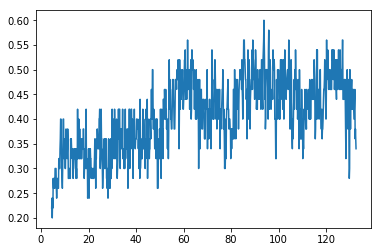

In [76]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

In [15]:
#10000 epochs
from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=10000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/10000
238/238 [==============================] - 2s 7ms/step - loss: 1.8639 - acc: 0.2521 - val_loss: 1.8625 - val_acc: 0.2600
Epoch 2/10000
238/238 [==============================] - 0s 463us/step - loss: 1.8672 - acc: 0.2563 - val_loss: 1.8549 - val_acc: 0.2600
Epoch 3/10000
238/238 [==============================] - 0s 505us/step - loss: 1.8562 - acc: 0.2479 - val_loss: 1.8472 - val_acc: 0.3200
Epoch 4/10000
238/238 [==============================] - 0s 506us/step - loss: 1.8515 - acc: 0.2269 - val_loss: 1.8411 - val_acc: 0.3400
Epoch 5/10000
238/238 [==============================] - 0s 595us/step - loss: 1.8532 - acc: 0.2395 - val_loss: 1.8332 - val_acc: 0.3400
Epoch 6/10000
238/238 [==============================] - ETA: 0s - loss: 1.8254 - acc: 0.266 - 0s 571us/step - loss: 1.8271 - acc: 0.2731 - val_loss: 1.8224 - val_acc: 0.3000
Epoch 7/10000
238/238 [==============================] - 0s 593us/step - loss: 1.8369 - acc: 0.22

Epoch 60/10000
238/238 [==============================] - 0s 634us/step - loss: 1.5297 - acc: 0.2941 - val_loss: 1.5280 - val_acc: 0.3400
Epoch 61/10000
238/238 [==============================] - 0s 605us/step - loss: 1.5170 - acc: 0.3739 - val_loss: 1.5225 - val_acc: 0.3600
Epoch 62/10000
238/238 [==============================] - 0s 590us/step - loss: 1.5191 - acc: 0.3445 - val_loss: 1.5183 - val_acc: 0.3200
Epoch 63/10000
238/238 [==============================] - 0s 533us/step - loss: 1.5017 - acc: 0.4034 - val_loss: 1.5149 - val_acc: 0.3200
Epoch 64/10000
238/238 [==============================] - 0s 531us/step - loss: 1.5049 - acc: 0.4076 - val_loss: 1.5106 - val_acc: 0.3600
Epoch 65/10000
238/238 [==============================] - 0s 469us/step - loss: 1.5043 - acc: 0.3782 - val_loss: 1.5077 - val_acc: 0.4200
Epoch 66/10000
238/238 [==============================] - 0s 549us/step - loss: 1.5008 - acc: 0.3487 - val_loss: 1.5061 - val_acc: 0.3600
Epoch 67/10000
238/238 [==========

238/238 [==============================] - 0s 443us/step - loss: 1.2546 - acc: 0.5084 - val_loss: 1.3948 - val_acc: 0.4400
Epoch 120/10000
238/238 [==============================] - 0s 442us/step - loss: 1.2602 - acc: 0.4916 - val_loss: 1.4008 - val_acc: 0.4200
Epoch 121/10000
238/238 [==============================] - 0s 433us/step - loss: 1.2407 - acc: 0.5378 - val_loss: 1.3943 - val_acc: 0.4200
Epoch 122/10000
238/238 [==============================] - 0s 437us/step - loss: 1.2314 - acc: 0.5378 - val_loss: 1.4051 - val_acc: 0.4200
Epoch 123/10000
238/238 [==============================] - 0s 453us/step - loss: 1.2533 - acc: 0.5168 - val_loss: 1.4081 - val_acc: 0.3800
Epoch 124/10000
238/238 [==============================] - 0s 422us/step - loss: 1.2507 - acc: 0.5378 - val_loss: 1.3912 - val_acc: 0.4400
Epoch 125/10000
238/238 [==============================] - 0s 445us/step - loss: 1.2364 - acc: 0.5462 - val_loss: 1.3658 - val_acc: 0.4400
Epoch 126/10000
238/238 [==================

238/238 [==============================] - 0s 438us/step - loss: 0.9909 - acc: 0.6933 - val_loss: 1.4980 - val_acc: 0.4600
Epoch 179/10000
238/238 [==============================] - 0s 424us/step - loss: 1.0972 - acc: 0.6134 - val_loss: 1.4723 - val_acc: 0.4000
Epoch 180/10000
238/238 [==============================] - 0s 437us/step - loss: 1.0775 - acc: 0.6303 - val_loss: 1.5135 - val_acc: 0.3600
Epoch 181/10000
238/238 [==============================] - 0s 420us/step - loss: 1.0589 - acc: 0.6429 - val_loss: 1.5329 - val_acc: 0.3800
Epoch 182/10000
238/238 [==============================] - 0s 437us/step - loss: 1.0239 - acc: 0.6723 - val_loss: 1.5069 - val_acc: 0.3800
Epoch 183/10000
238/238 [==============================] - 0s 447us/step - loss: 1.0862 - acc: 0.6513 - val_loss: 1.4248 - val_acc: 0.4200
Epoch 184/10000
238/238 [==============================] - 0s 432us/step - loss: 1.0587 - acc: 0.6639 - val_loss: 1.4438 - val_acc: 0.4200
Epoch 185/10000
238/238 [==================

238/238 [==============================] - 0s 460us/step - loss: 0.9661 - acc: 0.6891 - val_loss: 1.7312 - val_acc: 0.3000
Epoch 238/10000
238/238 [==============================] - 0s 436us/step - loss: 1.0044 - acc: 0.6807 - val_loss: 1.7231 - val_acc: 0.3600
Epoch 239/10000
238/238 [==============================] - 0s 424us/step - loss: 0.9824 - acc: 0.6849 - val_loss: 1.6659 - val_acc: 0.4600
Epoch 240/10000
238/238 [==============================] - 0s 435us/step - loss: 0.8998 - acc: 0.7437 - val_loss: 1.6405 - val_acc: 0.4000
Epoch 241/10000
238/238 [==============================] - 0s 432us/step - loss: 0.9185 - acc: 0.7269 - val_loss: 1.6727 - val_acc: 0.4400
Epoch 242/10000
238/238 [==============================] - 0s 448us/step - loss: 0.9464 - acc: 0.7437 - val_loss: 1.6415 - val_acc: 0.4200
Epoch 243/10000
238/238 [==============================] - 0s 423us/step - loss: 0.9312 - acc: 0.7269 - val_loss: 1.6942 - val_acc: 0.4200
Epoch 244/10000
238/238 [==================

238/238 [==============================] - 0s 447us/step - loss: 0.8835 - acc: 0.7479 - val_loss: 1.7242 - val_acc: 0.4000
Epoch 297/10000
238/238 [==============================] - 0s 438us/step - loss: 0.8838 - acc: 0.7353 - val_loss: 1.6961 - val_acc: 0.4000
Epoch 298/10000
238/238 [==============================] - 0s 462us/step - loss: 0.8860 - acc: 0.7857 - val_loss: 1.7067 - val_acc: 0.4200
Epoch 299/10000
238/238 [==============================] - 0s 426us/step - loss: 0.9224 - acc: 0.7647 - val_loss: 1.9109 - val_acc: 0.4000
Epoch 300/10000
238/238 [==============================] - 0s 426us/step - loss: 0.9121 - acc: 0.7563 - val_loss: 1.9092 - val_acc: 0.3600
Epoch 301/10000
238/238 [==============================] - 0s 452us/step - loss: 0.8621 - acc: 0.8067 - val_loss: 1.8096 - val_acc: 0.4200
Epoch 302/10000
238/238 [==============================] - 0s 523us/step - loss: 0.8519 - acc: 0.7857 - val_loss: 1.7070 - val_acc: 0.4400
Epoch 303/10000
238/238 [==================

238/238 [==============================] - 0s 448us/step - loss: 0.8730 - acc: 0.7899 - val_loss: 1.7575 - val_acc: 0.4800
Epoch 356/10000
238/238 [==============================] - 0s 490us/step - loss: 0.8945 - acc: 0.7731 - val_loss: 1.8717 - val_acc: 0.4000
Epoch 357/10000
238/238 [==============================] - 0s 448us/step - loss: 0.8364 - acc: 0.7899 - val_loss: 1.8331 - val_acc: 0.4000
Epoch 358/10000
238/238 [==============================] - 0s 434us/step - loss: 0.8112 - acc: 0.7857 - val_loss: 1.8020 - val_acc: 0.4200
Epoch 359/10000
238/238 [==============================] - 0s 425us/step - loss: 0.9137 - acc: 0.7521 - val_loss: 1.8364 - val_acc: 0.3800
Epoch 360/10000
238/238 [==============================] - 0s 456us/step - loss: 0.8037 - acc: 0.8361 - val_loss: 1.8190 - val_acc: 0.4000
Epoch 361/10000
238/238 [==============================] - 0s 425us/step - loss: 0.7831 - acc: 0.8487 - val_loss: 1.8134 - val_acc: 0.4000
Epoch 362/10000
238/238 [==================

238/238 [==============================] - 0s 431us/step - loss: 0.8825 - acc: 0.7815 - val_loss: 2.0382 - val_acc: 0.4600
Epoch 415/10000
238/238 [==============================] - 0s 443us/step - loss: 0.8232 - acc: 0.8193 - val_loss: 1.8821 - val_acc: 0.4000
Epoch 416/10000
238/238 [==============================] - 0s 416us/step - loss: 0.8484 - acc: 0.8151 - val_loss: 1.7976 - val_acc: 0.4600
Epoch 417/10000
238/238 [==============================] - 0s 429us/step - loss: 0.7240 - acc: 0.8655 - val_loss: 1.8273 - val_acc: 0.4400
Epoch 418/10000
238/238 [==============================] - 0s 440us/step - loss: 0.7780 - acc: 0.8235 - val_loss: 1.8359 - val_acc: 0.4400
Epoch 419/10000
238/238 [==============================] - 0s 446us/step - loss: 0.7143 - acc: 0.8487 - val_loss: 1.8904 - val_acc: 0.4400
Epoch 420/10000
238/238 [==============================] - 0s 448us/step - loss: 0.7733 - acc: 0.8403 - val_loss: 1.8870 - val_acc: 0.4400
Epoch 421/10000
238/238 [==================

238/238 [==============================] - 0s 453us/step - loss: 0.8527 - acc: 0.8193 - val_loss: 1.9880 - val_acc: 0.4200
Epoch 474/10000
238/238 [==============================] - 0s 457us/step - loss: 0.7550 - acc: 0.8529 - val_loss: 1.9707 - val_acc: 0.3800
Epoch 475/10000
238/238 [==============================] - 0s 457us/step - loss: 0.7446 - acc: 0.8361 - val_loss: 1.9294 - val_acc: 0.4400
Epoch 476/10000
238/238 [==============================] - 0s 438us/step - loss: 0.8053 - acc: 0.8235 - val_loss: 1.9558 - val_acc: 0.4000
Epoch 477/10000
238/238 [==============================] - 0s 436us/step - loss: 0.8499 - acc: 0.8361 - val_loss: 2.0603 - val_acc: 0.3600
Epoch 478/10000
238/238 [==============================] - 0s 434us/step - loss: 0.6845 - acc: 0.8950 - val_loss: 2.0236 - val_acc: 0.4200
Epoch 479/10000
238/238 [==============================] - 0s 425us/step - loss: 0.8449 - acc: 0.8109 - val_loss: 1.9803 - val_acc: 0.4600
Epoch 480/10000
238/238 [==================

238/238 [==============================] - 0s 513us/step - loss: 0.7020 - acc: 0.8613 - val_loss: 1.7966 - val_acc: 0.5400
Epoch 533/10000
238/238 [==============================] - 0s 443us/step - loss: 0.7864 - acc: 0.8403 - val_loss: 1.8329 - val_acc: 0.5600
Epoch 534/10000
238/238 [==============================] - 0s 411us/step - loss: 0.7588 - acc: 0.8403 - val_loss: 1.9335 - val_acc: 0.4800
Epoch 535/10000
238/238 [==============================] - 0s 437us/step - loss: 0.7906 - acc: 0.8445 - val_loss: 2.0071 - val_acc: 0.4400
Epoch 536/10000
238/238 [==============================] - 0s 430us/step - loss: 0.6971 - acc: 0.8739 - val_loss: 1.9964 - val_acc: 0.4000
Epoch 537/10000
238/238 [==============================] - 0s 459us/step - loss: 0.8120 - acc: 0.8151 - val_loss: 2.0734 - val_acc: 0.4400
Epoch 538/10000
238/238 [==============================] - 0s 432us/step - loss: 0.8395 - acc: 0.8319 - val_loss: 2.0273 - val_acc: 0.4600
Epoch 539/10000
238/238 [==================

238/238 [==============================] - 0s 472us/step - loss: 0.7276 - acc: 0.8445 - val_loss: 1.8774 - val_acc: 0.4400
Epoch 592/10000
238/238 [==============================] - 0s 452us/step - loss: 0.6877 - acc: 0.8697 - val_loss: 2.0952 - val_acc: 0.4000
Epoch 593/10000
238/238 [==============================] - 0s 431us/step - loss: 0.7758 - acc: 0.8445 - val_loss: 2.1765 - val_acc: 0.3800
Epoch 594/10000
238/238 [==============================] - 0s 435us/step - loss: 0.8364 - acc: 0.8319 - val_loss: 2.1248 - val_acc: 0.3800
Epoch 595/10000
238/238 [==============================] - 0s 483us/step - loss: 0.7460 - acc: 0.8529 - val_loss: 2.0386 - val_acc: 0.3800
Epoch 596/10000
238/238 [==============================] - 0s 441us/step - loss: 0.7815 - acc: 0.8277 - val_loss: 1.9437 - val_acc: 0.4600
Epoch 597/10000
238/238 [==============================] - 0s 445us/step - loss: 0.7634 - acc: 0.8109 - val_loss: 1.9951 - val_acc: 0.4200
Epoch 598/10000
238/238 [==================

238/238 [==============================] - 0s 571us/step - loss: 0.6997 - acc: 0.8361 - val_loss: 1.7735 - val_acc: 0.4800
Epoch 651/10000
238/238 [==============================] - 0s 489us/step - loss: 0.7115 - acc: 0.8866 - val_loss: 1.8439 - val_acc: 0.4800
Epoch 652/10000
238/238 [==============================] - 0s 458us/step - loss: 0.7394 - acc: 0.8277 - val_loss: 1.8700 - val_acc: 0.4400
Epoch 653/10000
238/238 [==============================] - 0s 467us/step - loss: 0.6780 - acc: 0.8697 - val_loss: 1.8710 - val_acc: 0.4600
Epoch 654/10000
238/238 [==============================] - 0s 453us/step - loss: 0.7204 - acc: 0.8739 - val_loss: 1.8352 - val_acc: 0.4400
Epoch 655/10000
238/238 [==============================] - 0s 442us/step - loss: 0.7083 - acc: 0.8697 - val_loss: 1.8329 - val_acc: 0.4600
Epoch 656/10000
238/238 [==============================] - 0s 450us/step - loss: 0.6399 - acc: 0.9034 - val_loss: 1.9199 - val_acc: 0.4600
Epoch 657/10000
238/238 [==================

238/238 [==============================] - 0s 453us/step - loss: 0.6495 - acc: 0.8908 - val_loss: 1.6769 - val_acc: 0.5600
Epoch 710/10000
238/238 [==============================] - 0s 453us/step - loss: 0.6523 - acc: 0.8739 - val_loss: 1.6788 - val_acc: 0.5400
Epoch 711/10000
238/238 [==============================] - 0s 456us/step - loss: 0.7484 - acc: 0.8487 - val_loss: 1.6890 - val_acc: 0.5600
Epoch 712/10000
238/238 [==============================] - 0s 493us/step - loss: 0.6051 - acc: 0.9118 - val_loss: 1.7253 - val_acc: 0.5600
Epoch 713/10000
238/238 [==============================] - 0s 429us/step - loss: 0.6611 - acc: 0.8824 - val_loss: 1.8027 - val_acc: 0.4800
Epoch 714/10000
238/238 [==============================] - 0s 436us/step - loss: 0.7140 - acc: 0.8739 - val_loss: 1.8984 - val_acc: 0.4200
Epoch 715/10000
238/238 [==============================] - 0s 459us/step - loss: 0.7496 - acc: 0.8613 - val_loss: 1.9191 - val_acc: 0.3600
Epoch 716/10000
238/238 [==================

238/238 [==============================] - 0s 437us/step - loss: 0.6492 - acc: 0.8950 - val_loss: 1.9447 - val_acc: 0.3800
Epoch 769/10000
238/238 [==============================] - 0s 434us/step - loss: 0.6717 - acc: 0.8782 - val_loss: 2.0371 - val_acc: 0.4400
Epoch 770/10000
238/238 [==============================] - 0s 429us/step - loss: 0.6951 - acc: 0.8613 - val_loss: 2.0218 - val_acc: 0.3800
Epoch 771/10000
238/238 [==============================] - 0s 427us/step - loss: 0.6867 - acc: 0.8782 - val_loss: 1.9643 - val_acc: 0.3200
Epoch 772/10000
238/238 [==============================] - 0s 430us/step - loss: 0.7553 - acc: 0.8361 - val_loss: 1.8283 - val_acc: 0.4000
Epoch 773/10000
238/238 [==============================] - 0s 429us/step - loss: 0.7925 - acc: 0.8109 - val_loss: 1.8447 - val_acc: 0.4200
Epoch 774/10000
238/238 [==============================] - 0s 425us/step - loss: 0.7167 - acc: 0.8403 - val_loss: 1.8865 - val_acc: 0.3800
Epoch 775/10000
238/238 [==================

238/238 [==============================] - 0s 512us/step - loss: 0.6020 - acc: 0.9160 - val_loss: 1.8284 - val_acc: 0.4400
Epoch 828/10000
238/238 [==============================] - 0s 519us/step - loss: 0.6658 - acc: 0.8655 - val_loss: 1.9109 - val_acc: 0.5000
Epoch 829/10000
238/238 [==============================] - 0s 540us/step - loss: 0.6300 - acc: 0.8571 - val_loss: 1.8425 - val_acc: 0.5400
Epoch 830/10000
238/238 [==============================] - 0s 535us/step - loss: 0.6557 - acc: 0.8782 - val_loss: 1.8112 - val_acc: 0.5000
Epoch 831/10000
238/238 [==============================] - 0s 639us/step - loss: 0.6230 - acc: 0.8571 - val_loss: 1.7867 - val_acc: 0.4800
Epoch 832/10000
238/238 [==============================] - 0s 634us/step - loss: 0.6202 - acc: 0.8908 - val_loss: 1.7860 - val_acc: 0.5000
Epoch 833/10000
238/238 [==============================] - 0s 483us/step - loss: 0.6278 - acc: 0.8655 - val_loss: 1.7856 - val_acc: 0.4800
Epoch 834/10000
238/238 [==================

238/238 [==============================] - 0s 452us/step - loss: 0.6570 - acc: 0.8613 - val_loss: 2.0575 - val_acc: 0.4000
Epoch 887/10000
238/238 [==============================] - 0s 513us/step - loss: 0.5486 - acc: 0.9034 - val_loss: 2.0335 - val_acc: 0.3800
Epoch 888/10000
238/238 [==============================] - 0s 422us/step - loss: 0.5362 - acc: 0.9286 - val_loss: 1.9641 - val_acc: 0.4000
Epoch 889/10000
238/238 [==============================] - 0s 439us/step - loss: 0.6818 - acc: 0.8529 - val_loss: 1.8793 - val_acc: 0.4200
Epoch 890/10000
238/238 [==============================] - 0s 448us/step - loss: 0.5322 - acc: 0.9118 - val_loss: 1.8502 - val_acc: 0.4400
Epoch 891/10000
238/238 [==============================] - 0s 441us/step - loss: 0.5441 - acc: 0.9202 - val_loss: 1.8356 - val_acc: 0.4800
Epoch 892/10000
238/238 [==============================] - 0s 444us/step - loss: 0.5362 - acc: 0.8992 - val_loss: 1.9696 - val_acc: 0.4400
Epoch 893/10000
238/238 [==================

238/238 [==============================] - 0s 512us/step - loss: 0.5741 - acc: 0.8824 - val_loss: 1.7573 - val_acc: 0.4600
Epoch 946/10000
238/238 [==============================] - 0s 505us/step - loss: 0.5557 - acc: 0.8992 - val_loss: 1.8003 - val_acc: 0.4400
Epoch 947/10000
238/238 [==============================] - 0s 447us/step - loss: 0.5091 - acc: 0.9160 - val_loss: 1.7895 - val_acc: 0.4400
Epoch 948/10000
238/238 [==============================] - 0s 525us/step - loss: 0.5519 - acc: 0.8908 - val_loss: 1.7727 - val_acc: 0.4600
Epoch 949/10000
238/238 [==============================] - 0s 427us/step - loss: 0.5205 - acc: 0.9244 - val_loss: 1.7466 - val_acc: 0.4800
Epoch 950/10000
238/238 [==============================] - 0s 423us/step - loss: 0.5712 - acc: 0.8992 - val_loss: 1.7927 - val_acc: 0.4800
Epoch 951/10000
238/238 [==============================] - 0s 433us/step - loss: 0.5252 - acc: 0.9328 - val_loss: 1.7713 - val_acc: 0.4800
Epoch 952/10000
238/238 [==================

238/238 [==============================] - 0s 465us/step - loss: 0.6230 - acc: 0.8992 - val_loss: 1.8256 - val_acc: 0.5000
Epoch 1005/10000
238/238 [==============================] - 0s 459us/step - loss: 0.6215 - acc: 0.8908 - val_loss: 1.8371 - val_acc: 0.4800
Epoch 1006/10000
238/238 [==============================] - 0s 552us/step - loss: 0.6066 - acc: 0.8992 - val_loss: 1.7519 - val_acc: 0.4400
Epoch 1007/10000
238/238 [==============================] - 0s 539us/step - loss: 0.5877 - acc: 0.8866 - val_loss: 1.8038 - val_acc: 0.4800
Epoch 1008/10000
238/238 [==============================] - 0s 470us/step - loss: 0.5632 - acc: 0.9118 - val_loss: 1.8888 - val_acc: 0.4400
Epoch 1009/10000
238/238 [==============================] - 0s 417us/step - loss: 0.5190 - acc: 0.8992 - val_loss: 1.8383 - val_acc: 0.5200
Epoch 1010/10000
238/238 [==============================] - 0s 478us/step - loss: 0.5616 - acc: 0.8866 - val_loss: 1.7827 - val_acc: 0.4200
Epoch 1011/10000
238/238 [===========

238/238 [==============================] - 0s 450us/step - loss: 0.5758 - acc: 0.8824 - val_loss: 1.5417 - val_acc: 0.5000
Epoch 1063/10000
238/238 [==============================] - 0s 453us/step - loss: 0.5757 - acc: 0.8866 - val_loss: 1.6071 - val_acc: 0.5000
Epoch 1064/10000
238/238 [==============================] - 0s 420us/step - loss: 0.6108 - acc: 0.8824 - val_loss: 1.6749 - val_acc: 0.4800
Epoch 1065/10000
238/238 [==============================] - 0s 437us/step - loss: 0.5602 - acc: 0.9076 - val_loss: 1.7364 - val_acc: 0.4400
Epoch 1066/10000
238/238 [==============================] - 0s 426us/step - loss: 0.5357 - acc: 0.9160 - val_loss: 1.7680 - val_acc: 0.4200
Epoch 1067/10000
238/238 [==============================] - 0s 426us/step - loss: 0.5730 - acc: 0.8992 - val_loss: 1.7746 - val_acc: 0.4000
Epoch 1068/10000
238/238 [==============================] - 0s 423us/step - loss: 0.5176 - acc: 0.9160 - val_loss: 1.7931 - val_acc: 0.4600
Epoch 1069/10000
238/238 [===========

238/238 [==============================] - 0s 445us/step - loss: 0.5550 - acc: 0.9034 - val_loss: 1.8394 - val_acc: 0.4600
Epoch 1121/10000
238/238 [==============================] - 0s 442us/step - loss: 0.5796 - acc: 0.8908 - val_loss: 1.7394 - val_acc: 0.5000
Epoch 1122/10000
238/238 [==============================] - 0s 430us/step - loss: 0.5904 - acc: 0.8992 - val_loss: 1.7084 - val_acc: 0.5400
Epoch 1123/10000
238/238 [==============================] - 0s 445us/step - loss: 0.5409 - acc: 0.9118 - val_loss: 1.8003 - val_acc: 0.4200
Epoch 1124/10000
238/238 [==============================] - 0s 472us/step - loss: 0.5696 - acc: 0.8908 - val_loss: 1.8871 - val_acc: 0.4000
Epoch 1125/10000
238/238 [==============================] - 0s 460us/step - loss: 0.5685 - acc: 0.8908 - val_loss: 1.8452 - val_acc: 0.4200
Epoch 1126/10000
238/238 [==============================] - 0s 433us/step - loss: 0.6494 - acc: 0.8697 - val_loss: 1.7823 - val_acc: 0.5000
Epoch 1127/10000
238/238 [===========

238/238 [==============================] - 0s 496us/step - loss: 0.4735 - acc: 0.9034 - val_loss: 1.7891 - val_acc: 0.5400
Epoch 1179/10000
238/238 [==============================] - 0s 425us/step - loss: 0.5947 - acc: 0.8739 - val_loss: 1.8659 - val_acc: 0.4400
Epoch 1180/10000
238/238 [==============================] - 0s 441us/step - loss: 0.5539 - acc: 0.8950 - val_loss: 1.8716 - val_acc: 0.4800
Epoch 1181/10000
238/238 [==============================] - 0s 443us/step - loss: 0.4747 - acc: 0.9286 - val_loss: 1.9267 - val_acc: 0.4200
Epoch 1182/10000
238/238 [==============================] - 0s 434us/step - loss: 0.5504 - acc: 0.8992 - val_loss: 1.9058 - val_acc: 0.4000
Epoch 1183/10000
238/238 [==============================] - 0s 441us/step - loss: 0.6044 - acc: 0.8992 - val_loss: 1.8304 - val_acc: 0.4800
Epoch 1184/10000
238/238 [==============================] - 0s 446us/step - loss: 0.5472 - acc: 0.8908 - val_loss: 1.6995 - val_acc: 0.5000
Epoch 1185/10000
238/238 [===========

238/238 [==============================] - 0s 454us/step - loss: 0.5341 - acc: 0.9034 - val_loss: 1.8025 - val_acc: 0.4200
Epoch 1237/10000
238/238 [==============================] - 0s 461us/step - loss: 0.4709 - acc: 0.9202 - val_loss: 1.8213 - val_acc: 0.4200
Epoch 1238/10000
238/238 [==============================] - 0s 438us/step - loss: 0.5412 - acc: 0.8739 - val_loss: 1.8438 - val_acc: 0.4400
Epoch 1239/10000
238/238 [==============================] - 0s 436us/step - loss: 0.5751 - acc: 0.8782 - val_loss: 1.8724 - val_acc: 0.4200
Epoch 1240/10000
238/238 [==============================] - 0s 440us/step - loss: 0.4578 - acc: 0.9328 - val_loss: 1.9028 - val_acc: 0.4200
Epoch 1241/10000
238/238 [==============================] - 0s 436us/step - loss: 0.5555 - acc: 0.9118 - val_loss: 1.9250 - val_acc: 0.4200
Epoch 1242/10000
238/238 [==============================] - 0s 440us/step - loss: 0.5360 - acc: 0.8992 - val_loss: 1.8566 - val_acc: 0.4400
Epoch 1243/10000
238/238 [===========

238/238 [==============================] - 0s 478us/step - loss: 0.4453 - acc: 0.9244 - val_loss: 1.9869 - val_acc: 0.4600
Epoch 1295/10000
238/238 [==============================] - 0s 481us/step - loss: 0.5269 - acc: 0.9034 - val_loss: 1.9796 - val_acc: 0.5000
Epoch 1296/10000
238/238 [==============================] - 0s 482us/step - loss: 0.5432 - acc: 0.9118 - val_loss: 1.7465 - val_acc: 0.4600
Epoch 1297/10000
238/238 [==============================] - 0s 473us/step - loss: 0.5529 - acc: 0.8992 - val_loss: 1.6717 - val_acc: 0.5000
Epoch 1298/10000
238/238 [==============================] - 0s 437us/step - loss: 0.5585 - acc: 0.8992 - val_loss: 1.6521 - val_acc: 0.5400
Epoch 1299/10000
238/238 [==============================] - 0s 436us/step - loss: 0.4497 - acc: 0.9370 - val_loss: 1.7992 - val_acc: 0.5000
Epoch 1300/10000
238/238 [==============================] - 0s 429us/step - loss: 0.4693 - acc: 0.9160 - val_loss: 1.8695 - val_acc: 0.5200
Epoch 1301/10000
238/238 [===========

238/238 [==============================] - 0s 589us/step - loss: 0.5048 - acc: 0.9202 - val_loss: 1.7336 - val_acc: 0.4800
Epoch 1353/10000
238/238 [==============================] - 0s 616us/step - loss: 0.5009 - acc: 0.9118 - val_loss: 1.6612 - val_acc: 0.5400
Epoch 1354/10000
238/238 [==============================] - 0s 494us/step - loss: 0.5319 - acc: 0.9160 - val_loss: 1.7038 - val_acc: 0.5400
Epoch 1355/10000
238/238 [==============================] - 0s 535us/step - loss: 0.4599 - acc: 0.9160 - val_loss: 1.8281 - val_acc: 0.5200
Epoch 1356/10000
238/238 [==============================] - 0s 669us/step - loss: 0.5531 - acc: 0.8992 - val_loss: 1.7881 - val_acc: 0.5400
Epoch 1357/10000
238/238 [==============================] - 0s 556us/step - loss: 0.5571 - acc: 0.8739 - val_loss: 1.7028 - val_acc: 0.5200
Epoch 1358/10000
238/238 [==============================] - 0s 596us/step - loss: 0.4470 - acc: 0.9454 - val_loss: 1.8075 - val_acc: 0.5200
Epoch 1359/10000
238/238 [===========

238/238 [==============================] - 0s 484us/step - loss: 0.4678 - acc: 0.9370 - val_loss: 1.7995 - val_acc: 0.4200
Epoch 1411/10000
238/238 [==============================] - 0s 500us/step - loss: 0.4842 - acc: 0.9034 - val_loss: 1.8346 - val_acc: 0.4200
Epoch 1412/10000
238/238 [==============================] - 0s 477us/step - loss: 0.5129 - acc: 0.9286 - val_loss: 1.8075 - val_acc: 0.5200
Epoch 1413/10000
238/238 [==============================] - 0s 460us/step - loss: 0.4334 - acc: 0.9286 - val_loss: 1.7728 - val_acc: 0.5400
Epoch 1414/10000
238/238 [==============================] - 0s 460us/step - loss: 0.4948 - acc: 0.9202 - val_loss: 1.7808 - val_acc: 0.4800
Epoch 1415/10000
238/238 [==============================] - 0s 483us/step - loss: 0.4096 - acc: 0.9454 - val_loss: 1.7308 - val_acc: 0.4600
Epoch 1416/10000
238/238 [==============================] - 0s 462us/step - loss: 0.4551 - acc: 0.9328 - val_loss: 1.6641 - val_acc: 0.5400
Epoch 1417/10000
238/238 [===========

238/238 [==============================] - 0s 490us/step - loss: 0.5355 - acc: 0.8739 - val_loss: 1.9478 - val_acc: 0.4200
Epoch 1469/10000
238/238 [==============================] - 0s 602us/step - loss: 0.4957 - acc: 0.9202 - val_loss: 1.9193 - val_acc: 0.4400
Epoch 1470/10000
238/238 [==============================] - 0s 625us/step - loss: 0.4651 - acc: 0.9160 - val_loss: 1.8231 - val_acc: 0.4000
Epoch 1471/10000
238/238 [==============================] - 0s 490us/step - loss: 0.5018 - acc: 0.9118 - val_loss: 1.8211 - val_acc: 0.4000
Epoch 1472/10000
238/238 [==============================] - 0s 475us/step - loss: 0.5162 - acc: 0.9034 - val_loss: 1.8234 - val_acc: 0.4600
Epoch 1473/10000
238/238 [==============================] - 0s 462us/step - loss: 0.4983 - acc: 0.9118 - val_loss: 1.7720 - val_acc: 0.4200
Epoch 1474/10000
238/238 [==============================] - 0s 467us/step - loss: 0.4661 - acc: 0.9160 - val_loss: 1.7240 - val_acc: 0.4600
Epoch 1475/10000
238/238 [===========

238/238 [==============================] - 0s 554us/step - loss: 0.3905 - acc: 0.9328 - val_loss: 1.7934 - val_acc: 0.4600
Epoch 1527/10000
238/238 [==============================] - 0s 568us/step - loss: 0.4712 - acc: 0.9160 - val_loss: 1.9185 - val_acc: 0.4000
Epoch 1528/10000
238/238 [==============================] - 0s 532us/step - loss: 0.4655 - acc: 0.9118 - val_loss: 1.7026 - val_acc: 0.4800
Epoch 1529/10000
238/238 [==============================] - 0s 561us/step - loss: 0.5296 - acc: 0.8950 - val_loss: 1.5685 - val_acc: 0.4800
Epoch 1530/10000
238/238 [==============================] - 0s 602us/step - loss: 0.4336 - acc: 0.9370 - val_loss: 1.5097 - val_acc: 0.5200
Epoch 1531/10000
238/238 [==============================] - 0s 674us/step - loss: 0.4646 - acc: 0.9118 - val_loss: 1.4827 - val_acc: 0.4400
Epoch 1532/10000
238/238 [==============================] - 0s 621us/step - loss: 0.4571 - acc: 0.9202 - val_loss: 1.5317 - val_acc: 0.4400
Epoch 1533/10000
238/238 [===========

238/238 [==============================] - 0s 456us/step - loss: 0.4667 - acc: 0.9202 - val_loss: 1.6638 - val_acc: 0.4600
Epoch 1585/10000
238/238 [==============================] - 0s 498us/step - loss: 0.4701 - acc: 0.9034 - val_loss: 1.7292 - val_acc: 0.4600
Epoch 1586/10000
238/238 [==============================] - 0s 474us/step - loss: 0.3900 - acc: 0.9496 - val_loss: 1.7681 - val_acc: 0.4200
Epoch 1587/10000
238/238 [==============================] - 0s 457us/step - loss: 0.5039 - acc: 0.9076 - val_loss: 1.7848 - val_acc: 0.4800
Epoch 1588/10000
238/238 [==============================] - 0s 454us/step - loss: 0.4203 - acc: 0.9286 - val_loss: 1.8220 - val_acc: 0.4600
Epoch 1589/10000
238/238 [==============================] - 0s 461us/step - loss: 0.4648 - acc: 0.9244 - val_loss: 1.8396 - val_acc: 0.4400
Epoch 1590/10000
238/238 [==============================] - 0s 447us/step - loss: 0.4176 - acc: 0.9412 - val_loss: 1.8435 - val_acc: 0.3400
Epoch 1591/10000
238/238 [===========

238/238 [==============================] - 0s 460us/step - loss: 0.4172 - acc: 0.9412 - val_loss: 1.7374 - val_acc: 0.4400
Epoch 1643/10000
238/238 [==============================] - 0s 458us/step - loss: 0.4889 - acc: 0.8992 - val_loss: 1.6700 - val_acc: 0.3800
Epoch 1644/10000
238/238 [==============================] - 0s 461us/step - loss: 0.4749 - acc: 0.9160 - val_loss: 1.6017 - val_acc: 0.4600
Epoch 1645/10000
238/238 [==============================] - 0s 443us/step - loss: 0.6144 - acc: 0.8403 - val_loss: 1.5488 - val_acc: 0.4600
Epoch 1646/10000
238/238 [==============================] - 0s 457us/step - loss: 0.5521 - acc: 0.8866 - val_loss: 1.5547 - val_acc: 0.5000
Epoch 1647/10000
238/238 [==============================] - 0s 449us/step - loss: 0.4348 - acc: 0.9244 - val_loss: 1.5861 - val_acc: 0.4400
Epoch 1648/10000
238/238 [==============================] - 0s 467us/step - loss: 0.4525 - acc: 0.9202 - val_loss: 1.6515 - val_acc: 0.4200
Epoch 1649/10000
238/238 [===========

238/238 [==============================] - 0s 482us/step - loss: 0.4893 - acc: 0.9118 - val_loss: 1.5400 - val_acc: 0.4800
Epoch 1701/10000
238/238 [==============================] - 0s 465us/step - loss: 0.4891 - acc: 0.9076 - val_loss: 1.5891 - val_acc: 0.4200
Epoch 1702/10000
238/238 [==============================] - 0s 458us/step - loss: 0.3954 - acc: 0.9328 - val_loss: 1.7281 - val_acc: 0.4400
Epoch 1703/10000
238/238 [==============================] - 0s 448us/step - loss: 0.4205 - acc: 0.9370 - val_loss: 1.8011 - val_acc: 0.4800
Epoch 1704/10000
238/238 [==============================] - 0s 469us/step - loss: 0.4204 - acc: 0.9286 - val_loss: 1.8795 - val_acc: 0.4200
Epoch 1705/10000
238/238 [==============================] - 0s 507us/step - loss: 0.4531 - acc: 0.9202 - val_loss: 1.7655 - val_acc: 0.4800
Epoch 1706/10000
238/238 [==============================] - 0s 485us/step - loss: 0.3640 - acc: 0.9412 - val_loss: 1.7332 - val_acc: 0.4600
Epoch 1707/10000
238/238 [===========

238/238 [==============================] - 0s 467us/step - loss: 0.4235 - acc: 0.9286 - val_loss: 1.7499 - val_acc: 0.4000
Epoch 1759/10000
238/238 [==============================] - 0s 445us/step - loss: 0.3958 - acc: 0.9370 - val_loss: 1.7185 - val_acc: 0.4400
Epoch 1760/10000
238/238 [==============================] - 0s 438us/step - loss: 0.4212 - acc: 0.9244 - val_loss: 1.7010 - val_acc: 0.4800
Epoch 1761/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3891 - acc: 0.9412 - val_loss: 1.7316 - val_acc: 0.4400
Epoch 1762/10000
238/238 [==============================] - 0s 468us/step - loss: 0.4212 - acc: 0.9118 - val_loss: 1.8006 - val_acc: 0.4600
Epoch 1763/10000
238/238 [==============================] - 0s 424us/step - loss: 0.4485 - acc: 0.9370 - val_loss: 1.9097 - val_acc: 0.4600
Epoch 1764/10000
238/238 [==============================] - 0s 443us/step - loss: 0.5037 - acc: 0.8950 - val_loss: 1.9440 - val_acc: 0.4200
Epoch 1765/10000
238/238 [===========

238/238 [==============================] - 0s 458us/step - loss: 0.3916 - acc: 0.9244 - val_loss: 1.7097 - val_acc: 0.4400
Epoch 1817/10000
238/238 [==============================] - 0s 466us/step - loss: 0.4540 - acc: 0.9118 - val_loss: 1.7502 - val_acc: 0.4400
Epoch 1818/10000
238/238 [==============================] - 0s 457us/step - loss: 0.3618 - acc: 0.9496 - val_loss: 1.8088 - val_acc: 0.4400
Epoch 1819/10000
238/238 [==============================] - 0s 443us/step - loss: 0.3940 - acc: 0.9412 - val_loss: 1.8710 - val_acc: 0.3600
Epoch 1820/10000
238/238 [==============================] - 0s 462us/step - loss: 0.3318 - acc: 0.9622 - val_loss: 1.8859 - val_acc: 0.3800
Epoch 1821/10000
238/238 [==============================] - 0s 436us/step - loss: 0.4042 - acc: 0.9454 - val_loss: 1.8243 - val_acc: 0.3800
Epoch 1822/10000
238/238 [==============================] - 0s 429us/step - loss: 0.4035 - acc: 0.9370 - val_loss: 1.8374 - val_acc: 0.4000
Epoch 1823/10000
238/238 [===========

238/238 [==============================] - 0s 450us/step - loss: 0.4457 - acc: 0.9328 - val_loss: 1.6627 - val_acc: 0.3800
Epoch 1875/10000
238/238 [==============================] - 0s 451us/step - loss: 0.4326 - acc: 0.9160 - val_loss: 1.6532 - val_acc: 0.5200
Epoch 1876/10000
238/238 [==============================] - 0s 468us/step - loss: 0.5151 - acc: 0.8992 - val_loss: 1.6467 - val_acc: 0.5800
Epoch 1877/10000
238/238 [==============================] - 0s 471us/step - loss: 0.4238 - acc: 0.9076 - val_loss: 1.6048 - val_acc: 0.4600
Epoch 1878/10000
238/238 [==============================] - 0s 448us/step - loss: 0.4023 - acc: 0.9370 - val_loss: 1.5375 - val_acc: 0.4800
Epoch 1879/10000
238/238 [==============================] - 0s 438us/step - loss: 0.4068 - acc: 0.9286 - val_loss: 1.6036 - val_acc: 0.4800
Epoch 1880/10000
238/238 [==============================] - 0s 487us/step - loss: 0.4054 - acc: 0.9370 - val_loss: 1.7146 - val_acc: 0.5000
Epoch 1881/10000
238/238 [===========

238/238 [==============================] - 0s 450us/step - loss: 0.3814 - acc: 0.9412 - val_loss: 1.6298 - val_acc: 0.4600
Epoch 1933/10000
238/238 [==============================] - 0s 425us/step - loss: 0.4610 - acc: 0.8992 - val_loss: 1.6613 - val_acc: 0.4800
Epoch 1934/10000
238/238 [==============================] - 0s 443us/step - loss: 0.4164 - acc: 0.9160 - val_loss: 1.8002 - val_acc: 0.4400
Epoch 1935/10000
238/238 [==============================] - 0s 429us/step - loss: 0.4496 - acc: 0.9286 - val_loss: 1.7904 - val_acc: 0.4200
Epoch 1936/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3851 - acc: 0.9328 - val_loss: 1.7001 - val_acc: 0.3800
Epoch 1937/10000
238/238 [==============================] - 0s 448us/step - loss: 0.4845 - acc: 0.8992 - val_loss: 1.7065 - val_acc: 0.4400
Epoch 1938/10000
238/238 [==============================] - 0s 425us/step - loss: 0.3584 - acc: 0.9622 - val_loss: 1.6665 - val_acc: 0.4600
Epoch 1939/10000
238/238 [===========

238/238 [==============================] - 0s 472us/step - loss: 0.3894 - acc: 0.9286 - val_loss: 1.6594 - val_acc: 0.4800
Epoch 1991/10000
238/238 [==============================] - 0s 479us/step - loss: 0.4589 - acc: 0.9034 - val_loss: 1.6086 - val_acc: 0.4800
Epoch 1992/10000
238/238 [==============================] - 0s 441us/step - loss: 0.4318 - acc: 0.9118 - val_loss: 1.6251 - val_acc: 0.4800
Epoch 1993/10000
238/238 [==============================] - 0s 459us/step - loss: 0.3857 - acc: 0.9412 - val_loss: 1.6681 - val_acc: 0.4800
Epoch 1994/10000
238/238 [==============================] - 0s 449us/step - loss: 0.3460 - acc: 0.9496 - val_loss: 1.6344 - val_acc: 0.5200
Epoch 1995/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3777 - acc: 0.9370 - val_loss: 1.6080 - val_acc: 0.5200
Epoch 1996/10000
238/238 [==============================] - 0s 432us/step - loss: 0.3498 - acc: 0.9496 - val_loss: 1.5887 - val_acc: 0.5600
Epoch 1997/10000
238/238 [===========

238/238 [==============================] - 0s 456us/step - loss: 0.3325 - acc: 0.9580 - val_loss: 1.7397 - val_acc: 0.4800
Epoch 2049/10000
238/238 [==============================] - 0s 449us/step - loss: 0.4582 - acc: 0.9118 - val_loss: 1.6739 - val_acc: 0.4600
Epoch 2050/10000
238/238 [==============================] - 0s 460us/step - loss: 0.4092 - acc: 0.9286 - val_loss: 1.6824 - val_acc: 0.4800
Epoch 2051/10000
238/238 [==============================] - 0s 426us/step - loss: 0.3922 - acc: 0.9328 - val_loss: 1.8077 - val_acc: 0.4400
Epoch 2052/10000
238/238 [==============================] - 0s 442us/step - loss: 0.3938 - acc: 0.9328 - val_loss: 1.8110 - val_acc: 0.4200
Epoch 2053/10000
238/238 [==============================] - 0s 461us/step - loss: 0.3078 - acc: 0.9580 - val_loss: 1.7952 - val_acc: 0.4000
Epoch 2054/10000
238/238 [==============================] - 0s 442us/step - loss: 0.3565 - acc: 0.9454 - val_loss: 1.8066 - val_acc: 0.4000
Epoch 2055/10000
238/238 [===========

238/238 [==============================] - 0s 463us/step - loss: 0.4253 - acc: 0.9286 - val_loss: 2.0454 - val_acc: 0.4000
Epoch 2107/10000
238/238 [==============================] - 0s 459us/step - loss: 0.3645 - acc: 0.9538 - val_loss: 1.9820 - val_acc: 0.4000
Epoch 2108/10000
238/238 [==============================] - 0s 454us/step - loss: 0.3251 - acc: 0.9538 - val_loss: 1.9993 - val_acc: 0.4200
Epoch 2109/10000
238/238 [==============================] - 0s 466us/step - loss: 0.3546 - acc: 0.9244 - val_loss: 2.0685 - val_acc: 0.4000
Epoch 2110/10000
238/238 [==============================] - 0s 431us/step - loss: 0.3567 - acc: 0.9538 - val_loss: 2.0645 - val_acc: 0.3800
Epoch 2111/10000
238/238 [==============================] - 0s 456us/step - loss: 0.4427 - acc: 0.9286 - val_loss: 2.0412 - val_acc: 0.4200
Epoch 2112/10000
238/238 [==============================] - 0s 473us/step - loss: 0.3998 - acc: 0.9244 - val_loss: 2.0224 - val_acc: 0.3800
Epoch 2113/10000
238/238 [===========

238/238 [==============================] - 0s 486us/step - loss: 0.3970 - acc: 0.9202 - val_loss: 1.6402 - val_acc: 0.5200
Epoch 2165/10000
238/238 [==============================] - 0s 452us/step - loss: 0.4077 - acc: 0.9244 - val_loss: 1.6330 - val_acc: 0.4400
Epoch 2166/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3882 - acc: 0.9412 - val_loss: 1.6881 - val_acc: 0.4600
Epoch 2167/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3644 - acc: 0.9370 - val_loss: 1.7135 - val_acc: 0.4600
Epoch 2168/10000
238/238 [==============================] - 0s 473us/step - loss: 0.3884 - acc: 0.9328 - val_loss: 1.7481 - val_acc: 0.4600
Epoch 2169/10000
238/238 [==============================] - 0s 459us/step - loss: 0.3710 - acc: 0.9412 - val_loss: 1.7904 - val_acc: 0.5000
Epoch 2170/10000
238/238 [==============================] - 0s 478us/step - loss: 0.4230 - acc: 0.9328 - val_loss: 1.8817 - val_acc: 0.4200
Epoch 2171/10000
238/238 [===========

238/238 [==============================] - 0s 468us/step - loss: 0.4390 - acc: 0.9244 - val_loss: 1.9569 - val_acc: 0.3800
Epoch 2223/10000
238/238 [==============================] - 0s 605us/step - loss: 0.3575 - acc: 0.9412 - val_loss: 1.9688 - val_acc: 0.4200
Epoch 2224/10000
238/238 [==============================] - 0s 607us/step - loss: 0.4168 - acc: 0.9244 - val_loss: 1.8694 - val_acc: 0.4800
Epoch 2225/10000
238/238 [==============================] - 0s 595us/step - loss: 0.3582 - acc: 0.9328 - val_loss: 1.8202 - val_acc: 0.5000
Epoch 2226/10000
238/238 [==============================] - 0s 429us/step - loss: 0.3893 - acc: 0.9412 - val_loss: 1.7624 - val_acc: 0.5000
Epoch 2227/10000
238/238 [==============================] - 0s 437us/step - loss: 0.3875 - acc: 0.9454 - val_loss: 1.7730 - val_acc: 0.4600
Epoch 2228/10000
238/238 [==============================] - 0s 478us/step - loss: 0.3965 - acc: 0.9454 - val_loss: 1.7435 - val_acc: 0.4200
Epoch 2229/10000
238/238 [===========

238/238 [==============================] - 0s 499us/step - loss: 0.3950 - acc: 0.9286 - val_loss: 1.7571 - val_acc: 0.5000
Epoch 2281/10000
238/238 [==============================] - 0s 637us/step - loss: 0.4641 - acc: 0.9244 - val_loss: 1.6262 - val_acc: 0.5400
Epoch 2282/10000
238/238 [==============================] - 0s 531us/step - loss: 0.3316 - acc: 0.9622 - val_loss: 1.6403 - val_acc: 0.5000
Epoch 2283/10000
238/238 [==============================] - 0s 462us/step - loss: 0.4610 - acc: 0.9076 - val_loss: 1.6490 - val_acc: 0.5200
Epoch 2284/10000
238/238 [==============================] - 0s 635us/step - loss: 0.4212 - acc: 0.9118 - val_loss: 1.6507 - val_acc: 0.5400
Epoch 2285/10000
238/238 [==============================] - 0s 632us/step - loss: 0.2848 - acc: 0.9748 - val_loss: 1.6677 - val_acc: 0.5200
Epoch 2286/10000
238/238 [==============================] - 0s 612us/step - loss: 0.3553 - acc: 0.9328 - val_loss: 1.6506 - val_acc: 0.5000
Epoch 2287/10000
238/238 [===========

238/238 [==============================] - 0s 450us/step - loss: 0.3561 - acc: 0.9538 - val_loss: 1.8425 - val_acc: 0.4000
Epoch 2339/10000
238/238 [==============================] - 0s 508us/step - loss: 0.3357 - acc: 0.9328 - val_loss: 1.7787 - val_acc: 0.3800
Epoch 2340/10000
238/238 [==============================] - 0s 435us/step - loss: 0.3527 - acc: 0.9328 - val_loss: 1.7178 - val_acc: 0.4400
Epoch 2341/10000
238/238 [==============================] - 0s 517us/step - loss: 0.4035 - acc: 0.9286 - val_loss: 1.6784 - val_acc: 0.5400
Epoch 2342/10000
238/238 [==============================] - 0s 511us/step - loss: 0.3934 - acc: 0.9328 - val_loss: 1.7197 - val_acc: 0.5000
Epoch 2343/10000
238/238 [==============================] - 0s 439us/step - loss: 0.4688 - acc: 0.9034 - val_loss: 1.6836 - val_acc: 0.4800
Epoch 2344/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3861 - acc: 0.9160 - val_loss: 1.7867 - val_acc: 0.5000
Epoch 2345/10000
238/238 [===========

238/238 [==============================] - 0s 500us/step - loss: 0.3616 - acc: 0.9286 - val_loss: 1.9122 - val_acc: 0.4400
Epoch 2397/10000
238/238 [==============================] - 0s 462us/step - loss: 0.4107 - acc: 0.9328 - val_loss: 1.7948 - val_acc: 0.4600
Epoch 2398/10000
238/238 [==============================] - 0s 498us/step - loss: 0.3519 - acc: 0.9244 - val_loss: 1.7281 - val_acc: 0.4600
Epoch 2399/10000
238/238 [==============================] - 0s 433us/step - loss: 0.3578 - acc: 0.9412 - val_loss: 1.7147 - val_acc: 0.5400
Epoch 2400/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3529 - acc: 0.9496 - val_loss: 1.7115 - val_acc: 0.5200
Epoch 2401/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2929 - acc: 0.9706 - val_loss: 1.6520 - val_acc: 0.5600
Epoch 2402/10000
238/238 [==============================] - 0s 461us/step - loss: 0.3855 - acc: 0.9328 - val_loss: 1.6312 - val_acc: 0.5400
Epoch 2403/10000
238/238 [===========

238/238 [==============================] - 0s 458us/step - loss: 0.3677 - acc: 0.9370 - val_loss: 1.7990 - val_acc: 0.4800
Epoch 2455/10000
238/238 [==============================] - 0s 447us/step - loss: 0.4083 - acc: 0.9202 - val_loss: 1.8920 - val_acc: 0.4600
Epoch 2456/10000
238/238 [==============================] - 0s 487us/step - loss: 0.3231 - acc: 0.9580 - val_loss: 1.8965 - val_acc: 0.4200
Epoch 2457/10000
238/238 [==============================] - 0s 473us/step - loss: 0.3529 - acc: 0.9286 - val_loss: 1.7582 - val_acc: 0.4400
Epoch 2458/10000
238/238 [==============================] - 0s 441us/step - loss: 0.3697 - acc: 0.9454 - val_loss: 1.6988 - val_acc: 0.4800
Epoch 2459/10000
238/238 [==============================] - 0s 453us/step - loss: 0.3752 - acc: 0.9496 - val_loss: 1.6908 - val_acc: 0.5000
Epoch 2460/10000
238/238 [==============================] - 0s 480us/step - loss: 0.3508 - acc: 0.9496 - val_loss: 1.7657 - val_acc: 0.4800
Epoch 2461/10000
238/238 [===========

238/238 [==============================] - 0s 460us/step - loss: 0.3278 - acc: 0.9580 - val_loss: 1.8051 - val_acc: 0.5000
Epoch 2513/10000
238/238 [==============================] - 0s 443us/step - loss: 0.3482 - acc: 0.9454 - val_loss: 1.7385 - val_acc: 0.5200
Epoch 2514/10000
238/238 [==============================] - 0s 433us/step - loss: 0.3604 - acc: 0.9412 - val_loss: 1.7401 - val_acc: 0.4800
Epoch 2515/10000
238/238 [==============================] - 0s 444us/step - loss: 0.3895 - acc: 0.9370 - val_loss: 1.8129 - val_acc: 0.5000
Epoch 2516/10000
238/238 [==============================] - 0s 432us/step - loss: 0.3050 - acc: 0.9622 - val_loss: 1.8828 - val_acc: 0.4600
Epoch 2517/10000
238/238 [==============================] - 0s 477us/step - loss: 0.3676 - acc: 0.9412 - val_loss: 2.0049 - val_acc: 0.4200
Epoch 2518/10000
238/238 [==============================] - 0s 434us/step - loss: 0.3790 - acc: 0.9328 - val_loss: 2.1097 - val_acc: 0.3800
Epoch 2519/10000
238/238 [===========

238/238 [==============================] - 0s 446us/step - loss: 0.3816 - acc: 0.9370 - val_loss: 1.8184 - val_acc: 0.4800
Epoch 2571/10000
238/238 [==============================] - 0s 526us/step - loss: 0.3387 - acc: 0.9328 - val_loss: 1.9139 - val_acc: 0.4400
Epoch 2572/10000
238/238 [==============================] - 0s 479us/step - loss: 0.3352 - acc: 0.9412 - val_loss: 1.9421 - val_acc: 0.4400
Epoch 2573/10000
238/238 [==============================] - 0s 504us/step - loss: 0.3509 - acc: 0.9412 - val_loss: 1.9713 - val_acc: 0.4400
Epoch 2574/10000
238/238 [==============================] - 0s 483us/step - loss: 0.3474 - acc: 0.9160 - val_loss: 1.9774 - val_acc: 0.4600
Epoch 2575/10000
238/238 [==============================] - 0s 471us/step - loss: 0.2990 - acc: 0.9538 - val_loss: 1.9671 - val_acc: 0.4800
Epoch 2576/10000
238/238 [==============================] - 0s 445us/step - loss: 0.3707 - acc: 0.9412 - val_loss: 1.9273 - val_acc: 0.4800
Epoch 2577/10000
238/238 [===========

238/238 [==============================] - 0s 475us/step - loss: 0.3764 - acc: 0.9244 - val_loss: 2.0479 - val_acc: 0.4000
Epoch 2629/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3148 - acc: 0.9622 - val_loss: 2.0041 - val_acc: 0.4200
Epoch 2630/10000
238/238 [==============================] - 0s 441us/step - loss: 0.3568 - acc: 0.9454 - val_loss: 1.9269 - val_acc: 0.4600
Epoch 2631/10000
238/238 [==============================] - 0s 470us/step - loss: 0.3538 - acc: 0.9244 - val_loss: 1.8095 - val_acc: 0.4600
Epoch 2632/10000
238/238 [==============================] - 0s 434us/step - loss: 0.3928 - acc: 0.9202 - val_loss: 1.7313 - val_acc: 0.5000
Epoch 2633/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3055 - acc: 0.9664 - val_loss: 1.7050 - val_acc: 0.5200
Epoch 2634/10000
238/238 [==============================] - 0s 460us/step - loss: 0.2735 - acc: 0.9664 - val_loss: 1.7032 - val_acc: 0.5000
Epoch 2635/10000
238/238 [===========

238/238 [==============================] - 0s 471us/step - loss: 0.3698 - acc: 0.9370 - val_loss: 1.6904 - val_acc: 0.5200
Epoch 2687/10000
238/238 [==============================] - 0s 463us/step - loss: 0.3596 - acc: 0.9412 - val_loss: 1.6019 - val_acc: 0.4800
Epoch 2688/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3188 - acc: 0.9496 - val_loss: 1.6312 - val_acc: 0.5000
Epoch 2689/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2803 - acc: 0.9538 - val_loss: 1.6734 - val_acc: 0.5400
Epoch 2690/10000
238/238 [==============================] - 0s 443us/step - loss: 0.3702 - acc: 0.9370 - val_loss: 1.6971 - val_acc: 0.5200
Epoch 2691/10000
238/238 [==============================] - 0s 431us/step - loss: 0.4284 - acc: 0.9412 - val_loss: 1.8374 - val_acc: 0.4600
Epoch 2692/10000
238/238 [==============================] - 0s 443us/step - loss: 0.3816 - acc: 0.9244 - val_loss: 1.8540 - val_acc: 0.4600
Epoch 2693/10000
238/238 [===========

238/238 [==============================] - 0s 473us/step - loss: 0.4034 - acc: 0.9412 - val_loss: 1.5753 - val_acc: 0.5200
Epoch 2745/10000
238/238 [==============================] - 0s 526us/step - loss: 0.3389 - acc: 0.9496 - val_loss: 1.6287 - val_acc: 0.5400
Epoch 2746/10000
238/238 [==============================] - 0s 528us/step - loss: 0.3333 - acc: 0.9454 - val_loss: 1.5941 - val_acc: 0.4800
Epoch 2747/10000
238/238 [==============================] - 0s 517us/step - loss: 0.3279 - acc: 0.9454 - val_loss: 1.6161 - val_acc: 0.4600
Epoch 2748/10000
238/238 [==============================] - 0s 437us/step - loss: 0.3151 - acc: 0.9412 - val_loss: 1.6759 - val_acc: 0.4800
Epoch 2749/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2803 - acc: 0.9664 - val_loss: 1.8224 - val_acc: 0.5400
Epoch 2750/10000
238/238 [==============================] - 0s 461us/step - loss: 0.3825 - acc: 0.9370 - val_loss: 1.8908 - val_acc: 0.5200
Epoch 2751/10000
238/238 [===========

238/238 [==============================] - 0s 514us/step - loss: 0.4191 - acc: 0.9328 - val_loss: 1.7367 - val_acc: 0.4600
Epoch 2803/10000
238/238 [==============================] - 0s 459us/step - loss: 0.2861 - acc: 0.9622 - val_loss: 1.7355 - val_acc: 0.4600
Epoch 2804/10000
238/238 [==============================] - 0s 481us/step - loss: 0.2962 - acc: 0.9664 - val_loss: 1.7683 - val_acc: 0.5000
Epoch 2805/10000
238/238 [==============================] - 0s 530us/step - loss: 0.3026 - acc: 0.9496 - val_loss: 1.7588 - val_acc: 0.4200
Epoch 2806/10000
238/238 [==============================] - 0s 455us/step - loss: 0.3443 - acc: 0.9454 - val_loss: 1.7286 - val_acc: 0.5200
Epoch 2807/10000
238/238 [==============================] - 0s 423us/step - loss: 0.3358 - acc: 0.9202 - val_loss: 1.6351 - val_acc: 0.5600
Epoch 2808/10000
238/238 [==============================] - 0s 455us/step - loss: 0.3189 - acc: 0.9538 - val_loss: 1.5947 - val_acc: 0.5600
Epoch 2809/10000
238/238 [===========

238/238 [==============================] - 0s 499us/step - loss: 0.3981 - acc: 0.9160 - val_loss: 1.9066 - val_acc: 0.4800
Epoch 2861/10000
238/238 [==============================] - 0s 470us/step - loss: 0.3160 - acc: 0.9412 - val_loss: 1.8382 - val_acc: 0.4800
Epoch 2862/10000
238/238 [==============================] - 0s 448us/step - loss: 0.3249 - acc: 0.9664 - val_loss: 1.7351 - val_acc: 0.5200
Epoch 2863/10000
238/238 [==============================] - 0s 469us/step - loss: 0.3037 - acc: 0.9454 - val_loss: 1.7090 - val_acc: 0.5200
Epoch 2864/10000
238/238 [==============================] - 0s 451us/step - loss: 0.3972 - acc: 0.9202 - val_loss: 1.7158 - val_acc: 0.5400
Epoch 2865/10000
238/238 [==============================] - 0s 448us/step - loss: 0.3017 - acc: 0.9538 - val_loss: 1.6827 - val_acc: 0.5000
Epoch 2866/10000
238/238 [==============================] - 0s 477us/step - loss: 0.3879 - acc: 0.9076 - val_loss: 1.7437 - val_acc: 0.4800
Epoch 2867/10000
238/238 [===========

238/238 [==============================] - 0s 580us/step - loss: 0.3034 - acc: 0.9622 - val_loss: 1.7528 - val_acc: 0.5200
Epoch 2919/10000
238/238 [==============================] - 0s 586us/step - loss: 0.3205 - acc: 0.9496 - val_loss: 1.7814 - val_acc: 0.4800
Epoch 2920/10000
238/238 [==============================] - 0s 510us/step - loss: 0.3130 - acc: 0.9538 - val_loss: 1.7533 - val_acc: 0.4800
Epoch 2921/10000
238/238 [==============================] - 0s 528us/step - loss: 0.3285 - acc: 0.9328 - val_loss: 1.6887 - val_acc: 0.5000
Epoch 2922/10000
238/238 [==============================] - 0s 479us/step - loss: 0.3051 - acc: 0.9580 - val_loss: 1.6230 - val_acc: 0.5200
Epoch 2923/10000
238/238 [==============================] - 0s 457us/step - loss: 0.3680 - acc: 0.9412 - val_loss: 1.6213 - val_acc: 0.5000
Epoch 2924/10000
238/238 [==============================] - 0s 507us/step - loss: 0.3129 - acc: 0.9538 - val_loss: 1.6574 - val_acc: 0.5400
Epoch 2925/10000
238/238 [===========

238/238 [==============================] - 0s 625us/step - loss: 0.2949 - acc: 0.9580 - val_loss: 1.6418 - val_acc: 0.5600
Epoch 2977/10000
238/238 [==============================] - 0s 537us/step - loss: 0.3232 - acc: 0.9454 - val_loss: 1.6552 - val_acc: 0.5600
Epoch 2978/10000
238/238 [==============================] - 0s 460us/step - loss: 0.3197 - acc: 0.9412 - val_loss: 1.6570 - val_acc: 0.5400
Epoch 2979/10000
238/238 [==============================] - 0s 451us/step - loss: 0.3586 - acc: 0.9496 - val_loss: 1.6793 - val_acc: 0.5600
Epoch 2980/10000
238/238 [==============================] - 0s 505us/step - loss: 0.2485 - acc: 0.9790 - val_loss: 1.6999 - val_acc: 0.5600
Epoch 2981/10000
238/238 [==============================] - 0s 440us/step - loss: 0.2427 - acc: 0.9748 - val_loss: 1.7112 - val_acc: 0.5800
Epoch 2982/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2753 - acc: 0.9538 - val_loss: 1.6551 - val_acc: 0.6000
Epoch 2983/10000
238/238 [===========

238/238 [==============================] - 0s 492us/step - loss: 0.2683 - acc: 0.9580 - val_loss: 1.8049 - val_acc: 0.5000
Epoch 3035/10000
238/238 [==============================] - 0s 466us/step - loss: 0.3224 - acc: 0.9580 - val_loss: 1.8164 - val_acc: 0.4800
Epoch 3036/10000
238/238 [==============================] - 0s 446us/step - loss: 0.3545 - acc: 0.9454 - val_loss: 1.8107 - val_acc: 0.5000
Epoch 3037/10000
238/238 [==============================] - 0s 444us/step - loss: 0.3545 - acc: 0.9412 - val_loss: 1.7363 - val_acc: 0.5000
Epoch 3038/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2732 - acc: 0.9580 - val_loss: 1.6608 - val_acc: 0.5200
Epoch 3039/10000
238/238 [==============================] - 0s 433us/step - loss: 0.3287 - acc: 0.9412 - val_loss: 1.5888 - val_acc: 0.5600
Epoch 3040/10000
238/238 [==============================] - 0s 430us/step - loss: 0.3068 - acc: 0.9538 - val_loss: 1.5063 - val_acc: 0.5800
Epoch 3041/10000
238/238 [===========

238/238 [==============================] - 0s 433us/step - loss: 0.3256 - acc: 0.9580 - val_loss: 1.6662 - val_acc: 0.5200
Epoch 3093/10000
238/238 [==============================] - 0s 457us/step - loss: 0.3139 - acc: 0.9454 - val_loss: 1.6253 - val_acc: 0.5600
Epoch 3094/10000
238/238 [==============================] - 0s 460us/step - loss: 0.3238 - acc: 0.9412 - val_loss: 1.6506 - val_acc: 0.5200
Epoch 3095/10000
238/238 [==============================] - 0s 483us/step - loss: 0.3281 - acc: 0.9538 - val_loss: 1.6628 - val_acc: 0.5200
Epoch 3096/10000
238/238 [==============================] - 0s 489us/step - loss: 0.3319 - acc: 0.9538 - val_loss: 1.7442 - val_acc: 0.5600
Epoch 3097/10000
238/238 [==============================] - 0s 515us/step - loss: 0.3137 - acc: 0.9370 - val_loss: 1.7386 - val_acc: 0.5400
Epoch 3098/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2975 - acc: 0.9496 - val_loss: 1.6600 - val_acc: 0.5200
Epoch 3099/10000
238/238 [===========

238/238 [==============================] - 0s 437us/step - loss: 0.3017 - acc: 0.9244 - val_loss: 1.4551 - val_acc: 0.5800
Epoch 3151/10000
238/238 [==============================] - 0s 450us/step - loss: 0.3186 - acc: 0.9496 - val_loss: 1.5517 - val_acc: 0.6000
Epoch 3152/10000
238/238 [==============================] - 0s 429us/step - loss: 0.2574 - acc: 0.9832 - val_loss: 1.5526 - val_acc: 0.5800
Epoch 3153/10000
238/238 [==============================] - 0s 464us/step - loss: 0.3129 - acc: 0.9496 - val_loss: 1.4942 - val_acc: 0.5800
Epoch 3154/10000
238/238 [==============================] - 0s 435us/step - loss: 0.3173 - acc: 0.9496 - val_loss: 1.4053 - val_acc: 0.6200
Epoch 3155/10000
238/238 [==============================] - 0s 451us/step - loss: 0.3345 - acc: 0.9454 - val_loss: 1.4160 - val_acc: 0.5400
Epoch 3156/10000
238/238 [==============================] - 0s 538us/step - loss: 0.3542 - acc: 0.9244 - val_loss: 1.3896 - val_acc: 0.6000
Epoch 3157/10000
238/238 [===========

238/238 [==============================] - 0s 502us/step - loss: 0.3068 - acc: 0.9454 - val_loss: 1.7227 - val_acc: 0.5000
Epoch 3209/10000
238/238 [==============================] - 0s 477us/step - loss: 0.2739 - acc: 0.9664 - val_loss: 1.7610 - val_acc: 0.5400
Epoch 3210/10000
238/238 [==============================] - 0s 462us/step - loss: 0.3388 - acc: 0.9412 - val_loss: 1.7344 - val_acc: 0.5200
Epoch 3211/10000
238/238 [==============================] - 0s 454us/step - loss: 0.2908 - acc: 0.9580 - val_loss: 1.7427 - val_acc: 0.5200
Epoch 3212/10000
238/238 [==============================] - 0s 488us/step - loss: 0.3249 - acc: 0.9454 - val_loss: 1.7870 - val_acc: 0.5200
Epoch 3213/10000
238/238 [==============================] - 0s 453us/step - loss: 0.2758 - acc: 0.9580 - val_loss: 1.8139 - val_acc: 0.4800
Epoch 3214/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2583 - acc: 0.9664 - val_loss: 1.8374 - val_acc: 0.5000
Epoch 3215/10000
238/238 [===========

238/238 [==============================] - 0s 445us/step - loss: 0.2898 - acc: 0.9622 - val_loss: 1.8201 - val_acc: 0.5000
Epoch 3267/10000
238/238 [==============================] - 0s 507us/step - loss: 0.2757 - acc: 0.9496 - val_loss: 1.8626 - val_acc: 0.4800
Epoch 3268/10000
238/238 [==============================] - 0s 450us/step - loss: 0.3260 - acc: 0.9286 - val_loss: 1.8884 - val_acc: 0.5000
Epoch 3269/10000
238/238 [==============================] - 0s 454us/step - loss: 0.3192 - acc: 0.9412 - val_loss: 1.8568 - val_acc: 0.5000
Epoch 3270/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2827 - acc: 0.9580 - val_loss: 1.8447 - val_acc: 0.5000
Epoch 3271/10000
238/238 [==============================] - 0s 426us/step - loss: 0.2942 - acc: 0.9496 - val_loss: 1.7829 - val_acc: 0.5000
Epoch 3272/10000
238/238 [==============================] - 0s 431us/step - loss: 0.3041 - acc: 0.9412 - val_loss: 1.7439 - val_acc: 0.5200
Epoch 3273/10000
238/238 [===========

238/238 [==============================] - 0s 461us/step - loss: 0.2998 - acc: 0.9370 - val_loss: 1.6749 - val_acc: 0.4800
Epoch 3325/10000
238/238 [==============================] - 0s 491us/step - loss: 0.3284 - acc: 0.9370 - val_loss: 1.7126 - val_acc: 0.4600
Epoch 3326/10000
238/238 [==============================] - 0s 434us/step - loss: 0.3125 - acc: 0.9496 - val_loss: 1.6544 - val_acc: 0.5200
Epoch 3327/10000
238/238 [==============================] - 0s 424us/step - loss: 0.2514 - acc: 0.9706 - val_loss: 1.6092 - val_acc: 0.5400
Epoch 3328/10000
238/238 [==============================] - 0s 450us/step - loss: 0.3142 - acc: 0.9286 - val_loss: 1.6347 - val_acc: 0.5200
Epoch 3329/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2856 - acc: 0.9496 - val_loss: 1.6080 - val_acc: 0.5000
Epoch 3330/10000
238/238 [==============================] - 0s 425us/step - loss: 0.2873 - acc: 0.9538 - val_loss: 1.5777 - val_acc: 0.5800
Epoch 3331/10000
238/238 [===========

238/238 [==============================] - 0s 507us/step - loss: 0.3035 - acc: 0.9496 - val_loss: 1.5261 - val_acc: 0.5600
Epoch 3383/10000
238/238 [==============================] - 0s 484us/step - loss: 0.3290 - acc: 0.9412 - val_loss: 1.6054 - val_acc: 0.5600
Epoch 3384/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2943 - acc: 0.9580 - val_loss: 1.6315 - val_acc: 0.5400
Epoch 3385/10000
238/238 [==============================] - 0s 496us/step - loss: 0.2859 - acc: 0.9538 - val_loss: 1.6136 - val_acc: 0.5400
Epoch 3386/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2641 - acc: 0.9664 - val_loss: 1.5857 - val_acc: 0.5200
Epoch 3387/10000
238/238 [==============================] - 0s 432us/step - loss: 0.3830 - acc: 0.9328 - val_loss: 1.6501 - val_acc: 0.5200
Epoch 3388/10000
238/238 [==============================] - 0s 447us/step - loss: 0.2904 - acc: 0.9496 - val_loss: 1.7645 - val_acc: 0.4600
Epoch 3389/10000
238/238 [===========

238/238 [==============================] - 0s 449us/step - loss: 0.3721 - acc: 0.9202 - val_loss: 1.7239 - val_acc: 0.4400
Epoch 3441/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2695 - acc: 0.9706 - val_loss: 1.7229 - val_acc: 0.4600
Epoch 3442/10000
238/238 [==============================] - 0s 471us/step - loss: 0.2820 - acc: 0.9706 - val_loss: 1.7361 - val_acc: 0.5000
Epoch 3443/10000
238/238 [==============================] - 0s 497us/step - loss: 0.3142 - acc: 0.9412 - val_loss: 1.7500 - val_acc: 0.4600
Epoch 3444/10000
238/238 [==============================] - 0s 469us/step - loss: 0.3111 - acc: 0.9496 - val_loss: 1.7517 - val_acc: 0.4800
Epoch 3445/10000
238/238 [==============================] - 0s 472us/step - loss: 0.2802 - acc: 0.9538 - val_loss: 1.6996 - val_acc: 0.5000
Epoch 3446/10000
238/238 [==============================] - 0s 467us/step - loss: 0.3560 - acc: 0.9370 - val_loss: 1.6312 - val_acc: 0.5000
Epoch 3447/10000
238/238 [===========

238/238 [==============================] - 0s 519us/step - loss: 0.3287 - acc: 0.9538 - val_loss: 1.6497 - val_acc: 0.4800
Epoch 3499/10000
238/238 [==============================] - 0s 453us/step - loss: 0.3023 - acc: 0.9538 - val_loss: 1.6642 - val_acc: 0.5000
Epoch 3500/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2694 - acc: 0.9622 - val_loss: 1.6364 - val_acc: 0.4800
Epoch 3501/10000
238/238 [==============================] - 0s 448us/step - loss: 0.3162 - acc: 0.9454 - val_loss: 1.6032 - val_acc: 0.4600
Epoch 3502/10000
238/238 [==============================] - 0s 449us/step - loss: 0.2667 - acc: 0.9580 - val_loss: 1.5274 - val_acc: 0.4800
Epoch 3503/10000
238/238 [==============================] - 0s 434us/step - loss: 0.3182 - acc: 0.9370 - val_loss: 1.5584 - val_acc: 0.4800
Epoch 3504/10000
238/238 [==============================] - 0s 464us/step - loss: 0.3443 - acc: 0.9328 - val_loss: 1.6298 - val_acc: 0.5000
Epoch 3505/10000
238/238 [===========

238/238 [==============================] - 0s 467us/step - loss: 0.2904 - acc: 0.9538 - val_loss: 1.7190 - val_acc: 0.5400
Epoch 3557/10000
238/238 [==============================] - 0s 467us/step - loss: 0.3525 - acc: 0.9412 - val_loss: 1.6712 - val_acc: 0.5600
Epoch 3558/10000
238/238 [==============================] - 0s 440us/step - loss: 0.2863 - acc: 0.9580 - val_loss: 1.7163 - val_acc: 0.5200
Epoch 3559/10000
238/238 [==============================] - 0s 459us/step - loss: 0.3504 - acc: 0.9328 - val_loss: 1.7058 - val_acc: 0.5200
Epoch 3560/10000
238/238 [==============================] - 0s 493us/step - loss: 0.2368 - acc: 0.9748 - val_loss: 1.7046 - val_acc: 0.5000
Epoch 3561/10000
238/238 [==============================] - 0s 475us/step - loss: 0.3278 - acc: 0.9496 - val_loss: 1.7746 - val_acc: 0.5000
Epoch 3562/10000
238/238 [==============================] - 0s 467us/step - loss: 0.3415 - acc: 0.9328 - val_loss: 1.8439 - val_acc: 0.5000
Epoch 3563/10000
238/238 [===========

238/238 [==============================] - 0s 496us/step - loss: 0.3127 - acc: 0.9538 - val_loss: 1.6990 - val_acc: 0.4600
Epoch 3615/10000
238/238 [==============================] - 0s 494us/step - loss: 0.2951 - acc: 0.9538 - val_loss: 1.6671 - val_acc: 0.4200
Epoch 3616/10000
238/238 [==============================] - 0s 462us/step - loss: 0.3195 - acc: 0.9412 - val_loss: 1.6986 - val_acc: 0.5000
Epoch 3617/10000
238/238 [==============================] - 0s 432us/step - loss: 0.2645 - acc: 0.9622 - val_loss: 1.7634 - val_acc: 0.5000
Epoch 3618/10000
238/238 [==============================] - 0s 440us/step - loss: 0.3116 - acc: 0.9580 - val_loss: 1.8428 - val_acc: 0.4600
Epoch 3619/10000
238/238 [==============================] - 0s 441us/step - loss: 0.3132 - acc: 0.9454 - val_loss: 1.8728 - val_acc: 0.4600
Epoch 3620/10000
238/238 [==============================] - 0s 475us/step - loss: 0.2448 - acc: 0.9622 - val_loss: 1.8690 - val_acc: 0.4400
Epoch 3621/10000
238/238 [===========

238/238 [==============================] - 0s 457us/step - loss: 0.3861 - acc: 0.9118 - val_loss: 1.8416 - val_acc: 0.4600
Epoch 3673/10000
238/238 [==============================] - 0s 456us/step - loss: 0.3224 - acc: 0.9496 - val_loss: 1.8283 - val_acc: 0.4600
Epoch 3674/10000
238/238 [==============================] - 0s 425us/step - loss: 0.2546 - acc: 0.9622 - val_loss: 1.7794 - val_acc: 0.4600
Epoch 3675/10000
238/238 [==============================] - 0s 438us/step - loss: 0.2951 - acc: 0.9538 - val_loss: 1.7069 - val_acc: 0.4800
Epoch 3676/10000
238/238 [==============================] - 0s 459us/step - loss: 0.3205 - acc: 0.9412 - val_loss: 1.6298 - val_acc: 0.5000
Epoch 3677/10000
238/238 [==============================] - 0s 483us/step - loss: 0.3035 - acc: 0.9580 - val_loss: 1.6309 - val_acc: 0.5200
Epoch 3678/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2932 - acc: 0.9538 - val_loss: 1.6400 - val_acc: 0.5000
Epoch 3679/10000
238/238 [===========

238/238 [==============================] - 0s 463us/step - loss: 0.3348 - acc: 0.9412 - val_loss: 1.6751 - val_acc: 0.4400
Epoch 3731/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2437 - acc: 0.9664 - val_loss: 1.6258 - val_acc: 0.4400
Epoch 3732/10000
238/238 [==============================] - 0s 453us/step - loss: 0.3560 - acc: 0.9412 - val_loss: 1.6289 - val_acc: 0.4400
Epoch 3733/10000
238/238 [==============================] - 0s 453us/step - loss: 0.2690 - acc: 0.9664 - val_loss: 1.6764 - val_acc: 0.4400
Epoch 3734/10000
238/238 [==============================] - 0s 490us/step - loss: 0.3557 - acc: 0.9412 - val_loss: 1.6811 - val_acc: 0.4800
Epoch 3735/10000
238/238 [==============================] - 0s 547us/step - loss: 0.2950 - acc: 0.9496 - val_loss: 1.6171 - val_acc: 0.4400
Epoch 3736/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2507 - acc: 0.9664 - val_loss: 1.6134 - val_acc: 0.4600
Epoch 3737/10000
238/238 [===========

238/238 [==============================] - 0s 454us/step - loss: 0.3034 - acc: 0.9496 - val_loss: 1.8586 - val_acc: 0.4800
Epoch 3789/10000
238/238 [==============================] - 0s 485us/step - loss: 0.2708 - acc: 0.9412 - val_loss: 1.8314 - val_acc: 0.4400
Epoch 3790/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2752 - acc: 0.9496 - val_loss: 1.7863 - val_acc: 0.4800
Epoch 3791/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2986 - acc: 0.9412 - val_loss: 1.7431 - val_acc: 0.5200
Epoch 3792/10000
238/238 [==============================] - 0s 444us/step - loss: 0.3312 - acc: 0.9286 - val_loss: 1.7484 - val_acc: 0.5000
Epoch 3793/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2511 - acc: 0.9664 - val_loss: 1.7812 - val_acc: 0.4600
Epoch 3794/10000
238/238 [==============================] - 0s 423us/step - loss: 0.3277 - acc: 0.9370 - val_loss: 1.7766 - val_acc: 0.4800
Epoch 3795/10000
238/238 [===========

238/238 [==============================] - 0s 499us/step - loss: 0.2649 - acc: 0.9496 - val_loss: 1.9195 - val_acc: 0.4400
Epoch 3847/10000
238/238 [==============================] - 0s 458us/step - loss: 0.3163 - acc: 0.9370 - val_loss: 1.9340 - val_acc: 0.3600
Epoch 3848/10000
238/238 [==============================] - 0s 421us/step - loss: 0.2956 - acc: 0.9412 - val_loss: 1.9655 - val_acc: 0.4000
Epoch 3849/10000
238/238 [==============================] - 0s 517us/step - loss: 0.2890 - acc: 0.9496 - val_loss: 1.9619 - val_acc: 0.4000
Epoch 3850/10000
238/238 [==============================] - 0s 492us/step - loss: 0.2729 - acc: 0.9496 - val_loss: 1.9382 - val_acc: 0.4600
Epoch 3851/10000
238/238 [==============================] - 0s 479us/step - loss: 0.3016 - acc: 0.9538 - val_loss: 1.9706 - val_acc: 0.4800
Epoch 3852/10000
238/238 [==============================] - 0s 457us/step - loss: 0.2666 - acc: 0.9622 - val_loss: 2.0510 - val_acc: 0.4600
Epoch 3853/10000
238/238 [===========

238/238 [==============================] - 0s 606us/step - loss: 0.2798 - acc: 0.9496 - val_loss: 1.9532 - val_acc: 0.4400
Epoch 3905/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2281 - acc: 0.9748 - val_loss: 1.9735 - val_acc: 0.4200
Epoch 3906/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2681 - acc: 0.9580 - val_loss: 1.9754 - val_acc: 0.4000
Epoch 3907/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2124 - acc: 0.9790 - val_loss: 2.0018 - val_acc: 0.4000
Epoch 3908/10000
238/238 [==============================] - 0s 463us/step - loss: 0.3282 - acc: 0.9538 - val_loss: 2.0074 - val_acc: 0.4400
Epoch 3909/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2713 - acc: 0.9538 - val_loss: 1.9866 - val_acc: 0.4400
Epoch 3910/10000
238/238 [==============================] - 0s 429us/step - loss: 0.2341 - acc: 0.9706 - val_loss: 1.9890 - val_acc: 0.4400
Epoch 3911/10000
238/238 [===========

238/238 [==============================] - 0s 517us/step - loss: 0.3496 - acc: 0.9370 - val_loss: 1.7656 - val_acc: 0.4400
Epoch 3963/10000
238/238 [==============================] - 0s 510us/step - loss: 0.2831 - acc: 0.9622 - val_loss: 1.7622 - val_acc: 0.4200
Epoch 3964/10000
238/238 [==============================] - 0s 504us/step - loss: 0.2796 - acc: 0.9538 - val_loss: 1.7870 - val_acc: 0.4600
Epoch 3965/10000
238/238 [==============================] - 0s 503us/step - loss: 0.2670 - acc: 0.9622 - val_loss: 1.7814 - val_acc: 0.4400
Epoch 3966/10000
238/238 [==============================] - 0s 482us/step - loss: 0.2463 - acc: 0.9622 - val_loss: 1.7133 - val_acc: 0.4200
Epoch 3967/10000
238/238 [==============================] - 0s 476us/step - loss: 0.2779 - acc: 0.9538 - val_loss: 1.7450 - val_acc: 0.4000
Epoch 3968/10000
238/238 [==============================] - 0s 475us/step - loss: 0.3978 - acc: 0.9118 - val_loss: 1.8343 - val_acc: 0.4200
Epoch 3969/10000
238/238 [===========

238/238 [==============================] - 0s 449us/step - loss: 0.2711 - acc: 0.9622 - val_loss: 1.8065 - val_acc: 0.4600
Epoch 4021/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2612 - acc: 0.9580 - val_loss: 1.8266 - val_acc: 0.4400
Epoch 4022/10000
238/238 [==============================] - 0s 511us/step - loss: 0.3041 - acc: 0.9454 - val_loss: 1.8560 - val_acc: 0.4600
Epoch 4023/10000
238/238 [==============================] - 0s 585us/step - loss: 0.3084 - acc: 0.9454 - val_loss: 1.8937 - val_acc: 0.4600
Epoch 4024/10000
238/238 [==============================] - 0s 589us/step - loss: 0.4087 - acc: 0.9118 - val_loss: 1.9152 - val_acc: 0.4400
Epoch 4025/10000
238/238 [==============================] - 0s 476us/step - loss: 0.3238 - acc: 0.9370 - val_loss: 1.9354 - val_acc: 0.4200
Epoch 4026/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2513 - acc: 0.9538 - val_loss: 1.8977 - val_acc: 0.4600
Epoch 4027/10000
238/238 [===========

238/238 [==============================] - 0s 483us/step - loss: 0.3036 - acc: 0.9412 - val_loss: 1.8714 - val_acc: 0.5000
Epoch 4079/10000
238/238 [==============================] - 0s 549us/step - loss: 0.2195 - acc: 0.9706 - val_loss: 1.8352 - val_acc: 0.4800
Epoch 4080/10000
238/238 [==============================] - 0s 643us/step - loss: 0.2909 - acc: 0.9538 - val_loss: 1.7862 - val_acc: 0.5200
Epoch 4081/10000
238/238 [==============================] - 0s 657us/step - loss: 0.2749 - acc: 0.9706 - val_loss: 1.7161 - val_acc: 0.5000
Epoch 4082/10000
238/238 [==============================] - 0s 500us/step - loss: 0.3230 - acc: 0.9580 - val_loss: 1.6756 - val_acc: 0.5600
Epoch 4083/10000
238/238 [==============================] - 0s 506us/step - loss: 0.2414 - acc: 0.9748 - val_loss: 1.7158 - val_acc: 0.5400
Epoch 4084/10000
238/238 [==============================] - 0s 468us/step - loss: 0.3040 - acc: 0.9454 - val_loss: 1.7500 - val_acc: 0.5400
Epoch 4085/10000
238/238 [===========

238/238 [==============================] - 0s 632us/step - loss: 0.3119 - acc: 0.9412 - val_loss: 1.8425 - val_acc: 0.4400
Epoch 4137/10000
238/238 [==============================] - 0s 609us/step - loss: 0.3238 - acc: 0.9412 - val_loss: 1.8131 - val_acc: 0.4200
Epoch 4138/10000
238/238 [==============================] - 0s 526us/step - loss: 0.3082 - acc: 0.9538 - val_loss: 1.7445 - val_acc: 0.4600
Epoch 4139/10000
238/238 [==============================] - 0s 479us/step - loss: 0.2875 - acc: 0.9538 - val_loss: 1.7105 - val_acc: 0.4600
Epoch 4140/10000
238/238 [==============================] - 0s 499us/step - loss: 0.3035 - acc: 0.9496 - val_loss: 1.6993 - val_acc: 0.5000
Epoch 4141/10000
238/238 [==============================] - 0s 513us/step - loss: 0.2756 - acc: 0.9664 - val_loss: 1.7144 - val_acc: 0.5000
Epoch 4142/10000
238/238 [==============================] - 0s 547us/step - loss: 0.2341 - acc: 0.9622 - val_loss: 1.7353 - val_acc: 0.4800
Epoch 4143/10000
238/238 [===========

238/238 [==============================] - 0s 501us/step - loss: 0.2725 - acc: 0.9496 - val_loss: 1.7038 - val_acc: 0.4600
Epoch 4195/10000
238/238 [==============================] - 0s 525us/step - loss: 0.2252 - acc: 0.9664 - val_loss: 1.7043 - val_acc: 0.4600
Epoch 4196/10000
238/238 [==============================] - 0s 509us/step - loss: 0.3105 - acc: 0.9454 - val_loss: 1.6946 - val_acc: 0.4600
Epoch 4197/10000
238/238 [==============================] - 0s 476us/step - loss: 0.2193 - acc: 0.9706 - val_loss: 1.6700 - val_acc: 0.4400
Epoch 4198/10000
238/238 [==============================] - 0s 483us/step - loss: 0.3106 - acc: 0.9580 - val_loss: 1.6501 - val_acc: 0.4400
Epoch 4199/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2956 - acc: 0.9454 - val_loss: 1.6064 - val_acc: 0.5000
Epoch 4200/10000
238/238 [==============================] - 0s 524us/step - loss: 0.2846 - acc: 0.9496 - val_loss: 1.5788 - val_acc: 0.4800
Epoch 4201/10000
238/238 [===========

238/238 [==============================] - 0s 454us/step - loss: 0.2643 - acc: 0.9454 - val_loss: 1.7900 - val_acc: 0.4200
Epoch 4253/10000
238/238 [==============================] - 0s 493us/step - loss: 0.3105 - acc: 0.9454 - val_loss: 1.7864 - val_acc: 0.4200
Epoch 4254/10000
238/238 [==============================] - 0s 440us/step - loss: 0.2755 - acc: 0.9748 - val_loss: 1.7807 - val_acc: 0.4200
Epoch 4255/10000
238/238 [==============================] - 0s 514us/step - loss: 0.2825 - acc: 0.9454 - val_loss: 1.7419 - val_acc: 0.4200
Epoch 4256/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2628 - acc: 0.9706 - val_loss: 1.6294 - val_acc: 0.4600
Epoch 4257/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2422 - acc: 0.9748 - val_loss: 1.5892 - val_acc: 0.5000
Epoch 4258/10000
238/238 [==============================] - 0s 530us/step - loss: 0.2892 - acc: 0.9538 - val_loss: 1.6615 - val_acc: 0.4200
Epoch 4259/10000
238/238 [===========

238/238 [==============================] - 0s 453us/step - loss: 0.3218 - acc: 0.9496 - val_loss: 1.9862 - val_acc: 0.3800
Epoch 4311/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2869 - acc: 0.9580 - val_loss: 2.0049 - val_acc: 0.3800
Epoch 4312/10000
238/238 [==============================] - 0s 507us/step - loss: 0.2583 - acc: 0.9580 - val_loss: 1.9955 - val_acc: 0.3800
Epoch 4313/10000
238/238 [==============================] - 0s 560us/step - loss: 0.2890 - acc: 0.9412 - val_loss: 1.9817 - val_acc: 0.3600
Epoch 4314/10000
238/238 [==============================] - 0s 538us/step - loss: 0.2230 - acc: 0.9790 - val_loss: 2.0262 - val_acc: 0.3600
Epoch 4315/10000
238/238 [==============================] - 0s 482us/step - loss: 0.2947 - acc: 0.9538 - val_loss: 2.0042 - val_acc: 0.3800
Epoch 4316/10000
238/238 [==============================] - 0s 475us/step - loss: 0.2670 - acc: 0.9664 - val_loss: 1.9919 - val_acc: 0.4400
Epoch 4317/10000
238/238 [===========

238/238 [==============================] - 0s 441us/step - loss: 0.2233 - acc: 0.9832 - val_loss: 1.9042 - val_acc: 0.4400
Epoch 4369/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2824 - acc: 0.9580 - val_loss: 1.8968 - val_acc: 0.4200
Epoch 4370/10000
238/238 [==============================] - 0s 512us/step - loss: 0.2672 - acc: 0.9538 - val_loss: 1.9236 - val_acc: 0.4200
Epoch 4371/10000
238/238 [==============================] - 0s 470us/step - loss: 0.2645 - acc: 0.9454 - val_loss: 1.9204 - val_acc: 0.4200
Epoch 4372/10000
238/238 [==============================] - 0s 460us/step - loss: 0.3046 - acc: 0.9412 - val_loss: 1.9589 - val_acc: 0.3800
Epoch 4373/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2439 - acc: 0.9622 - val_loss: 1.9858 - val_acc: 0.4000
Epoch 4374/10000
238/238 [==============================] - 0s 483us/step - loss: 0.2825 - acc: 0.9580 - val_loss: 1.9686 - val_acc: 0.4200
Epoch 4375/10000
238/238 [===========

238/238 [==============================] - 0s 444us/step - loss: 0.2587 - acc: 0.9664 - val_loss: 2.0059 - val_acc: 0.4200
Epoch 4427/10000
238/238 [==============================] - 0s 460us/step - loss: 0.2709 - acc: 0.9496 - val_loss: 2.0856 - val_acc: 0.4200
Epoch 4428/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2920 - acc: 0.9664 - val_loss: 2.1399 - val_acc: 0.4200
Epoch 4429/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2815 - acc: 0.9454 - val_loss: 2.0773 - val_acc: 0.4400
Epoch 4430/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2545 - acc: 0.9538 - val_loss: 2.0075 - val_acc: 0.4400
Epoch 4431/10000
238/238 [==============================] - 0s 444us/step - loss: 0.3074 - acc: 0.9580 - val_loss: 1.9600 - val_acc: 0.4800
Epoch 4432/10000
238/238 [==============================] - 0s 480us/step - loss: 0.2248 - acc: 0.9664 - val_loss: 1.9785 - val_acc: 0.4600
Epoch 4433/10000
238/238 [===========

238/238 [==============================] - 0s 438us/step - loss: 0.2147 - acc: 0.9706 - val_loss: 1.8543 - val_acc: 0.4800
Epoch 4485/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2757 - acc: 0.9496 - val_loss: 1.7742 - val_acc: 0.5000
Epoch 4486/10000
238/238 [==============================] - 0s 453us/step - loss: 0.2505 - acc: 0.9706 - val_loss: 1.7471 - val_acc: 0.5000
Epoch 4487/10000
238/238 [==============================] - 0s 425us/step - loss: 0.2425 - acc: 0.9622 - val_loss: 1.7833 - val_acc: 0.4600
Epoch 4488/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2637 - acc: 0.9538 - val_loss: 1.8273 - val_acc: 0.4600
Epoch 4489/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2015 - acc: 0.9748 - val_loss: 1.8595 - val_acc: 0.4600
Epoch 4490/10000
238/238 [==============================] - 0s 427us/step - loss: 0.2859 - acc: 0.9538 - val_loss: 1.8920 - val_acc: 0.5000
Epoch 4491/10000
238/238 [===========

238/238 [==============================] - 0s 437us/step - loss: 0.2618 - acc: 0.9496 - val_loss: 1.7865 - val_acc: 0.4800
Epoch 4543/10000
238/238 [==============================] - 0s 511us/step - loss: 0.2187 - acc: 0.9874 - val_loss: 1.7651 - val_acc: 0.5000
Epoch 4544/10000
238/238 [==============================] - 0s 476us/step - loss: 0.2703 - acc: 0.9580 - val_loss: 1.7971 - val_acc: 0.4800
Epoch 4545/10000
238/238 [==============================] - 0s 502us/step - loss: 0.2712 - acc: 0.9622 - val_loss: 1.8187 - val_acc: 0.5000
Epoch 4546/10000
238/238 [==============================] - 0s 487us/step - loss: 0.2449 - acc: 0.9580 - val_loss: 1.8571 - val_acc: 0.4800
Epoch 4547/10000
238/238 [==============================] - 0s 515us/step - loss: 0.2611 - acc: 0.9580 - val_loss: 1.9121 - val_acc: 0.4600
Epoch 4548/10000
238/238 [==============================] - 0s 450us/step - loss: 0.3121 - acc: 0.9496 - val_loss: 1.9301 - val_acc: 0.4600
Epoch 4549/10000
238/238 [===========

238/238 [==============================] - 0s 484us/step - loss: 0.2849 - acc: 0.9622 - val_loss: 1.7175 - val_acc: 0.5000
Epoch 4601/10000
238/238 [==============================] - 0s 512us/step - loss: 0.2714 - acc: 0.9706 - val_loss: 1.8059 - val_acc: 0.4800
Epoch 4602/10000
238/238 [==============================] - 0s 503us/step - loss: 0.3068 - acc: 0.9538 - val_loss: 1.8214 - val_acc: 0.4600
Epoch 4603/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2664 - acc: 0.9664 - val_loss: 1.8116 - val_acc: 0.4600
Epoch 4604/10000
238/238 [==============================] - 0s 437us/step - loss: 0.2629 - acc: 0.9622 - val_loss: 1.7935 - val_acc: 0.4600
Epoch 4605/10000
238/238 [==============================] - 0s 461us/step - loss: 0.2201 - acc: 0.9664 - val_loss: 1.7611 - val_acc: 0.5000
Epoch 4606/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2810 - acc: 0.9496 - val_loss: 1.7371 - val_acc: 0.5000
Epoch 4607/10000
238/238 [===========

238/238 [==============================] - 0s 516us/step - loss: 0.2559 - acc: 0.9580 - val_loss: 1.7805 - val_acc: 0.5200
Epoch 4659/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2737 - acc: 0.9370 - val_loss: 1.7062 - val_acc: 0.5200
Epoch 4660/10000
238/238 [==============================] - 0s 499us/step - loss: 0.3219 - acc: 0.9454 - val_loss: 1.6851 - val_acc: 0.4800
Epoch 4661/10000
238/238 [==============================] - 0s 473us/step - loss: 0.2170 - acc: 0.9706 - val_loss: 1.7417 - val_acc: 0.4800
Epoch 4662/10000
238/238 [==============================] - 0s 530us/step - loss: 0.2734 - acc: 0.9622 - val_loss: 1.7897 - val_acc: 0.4800
Epoch 4663/10000
238/238 [==============================] - 0s 495us/step - loss: 0.2968 - acc: 0.9538 - val_loss: 1.8417 - val_acc: 0.4800
Epoch 4664/10000
238/238 [==============================] - 0s 486us/step - loss: 0.3761 - acc: 0.9496 - val_loss: 1.7875 - val_acc: 0.4800
Epoch 4665/10000
238/238 [===========

238/238 [==============================] - 0s 534us/step - loss: 0.2218 - acc: 0.9706 - val_loss: 1.8300 - val_acc: 0.4600
Epoch 4717/10000
238/238 [==============================] - 0s 551us/step - loss: 0.2767 - acc: 0.9496 - val_loss: 1.7802 - val_acc: 0.4800
Epoch 4718/10000
238/238 [==============================] - 0s 516us/step - loss: 0.2066 - acc: 0.9706 - val_loss: 1.7220 - val_acc: 0.4600
Epoch 4719/10000
238/238 [==============================] - 0s 768us/step - loss: 0.2645 - acc: 0.9538 - val_loss: 1.7188 - val_acc: 0.4800
Epoch 4720/10000
238/238 [==============================] - 0s 594us/step - loss: 0.2466 - acc: 0.9538 - val_loss: 1.7421 - val_acc: 0.5000
Epoch 4721/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2129 - acc: 0.9748 - val_loss: 1.7328 - val_acc: 0.5000
Epoch 4722/10000
238/238 [==============================] - 0s 516us/step - loss: 0.2407 - acc: 0.9622 - val_loss: 1.7659 - val_acc: 0.5000
Epoch 4723/10000
238/238 [===========

238/238 [==============================] - 0s 637us/step - loss: 0.3011 - acc: 0.9538 - val_loss: 1.7464 - val_acc: 0.4600
Epoch 4775/10000
238/238 [==============================] - 0s 545us/step - loss: 0.2769 - acc: 0.9412 - val_loss: 1.6951 - val_acc: 0.4600
Epoch 4776/10000
238/238 [==============================] - 0s 511us/step - loss: 0.2783 - acc: 0.9454 - val_loss: 1.6808 - val_acc: 0.4600
Epoch 4777/10000
238/238 [==============================] - 0s 610us/step - loss: 0.2958 - acc: 0.9454 - val_loss: 1.7762 - val_acc: 0.4400
Epoch 4778/10000
238/238 [==============================] - 0s 669us/step - loss: 0.2020 - acc: 0.9832 - val_loss: 1.8798 - val_acc: 0.3800
Epoch 4779/10000
238/238 [==============================] - 0s 673us/step - loss: 0.2486 - acc: 0.9622 - val_loss: 1.9204 - val_acc: 0.3600
Epoch 4780/10000
238/238 [==============================] - 0s 630us/step - loss: 0.2777 - acc: 0.9370 - val_loss: 1.8752 - val_acc: 0.4600
Epoch 4781/10000
238/238 [===========

238/238 [==============================] - 0s 466us/step - loss: 0.2546 - acc: 0.9412 - val_loss: 2.1640 - val_acc: 0.4200
Epoch 4833/10000
238/238 [==============================] - 0s 516us/step - loss: 0.2199 - acc: 0.9706 - val_loss: 2.1886 - val_acc: 0.4200
Epoch 4834/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2581 - acc: 0.9664 - val_loss: 2.1538 - val_acc: 0.4000
Epoch 4835/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2772 - acc: 0.9496 - val_loss: 2.1297 - val_acc: 0.4200
Epoch 4836/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2579 - acc: 0.9538 - val_loss: 2.1562 - val_acc: 0.4000
Epoch 4837/10000
238/238 [==============================] - 0s 446us/step - loss: 0.3273 - acc: 0.9328 - val_loss: 2.0931 - val_acc: 0.3800
Epoch 4838/10000
238/238 [==============================] - 0s 469us/step - loss: 0.2584 - acc: 0.9580 - val_loss: 2.0104 - val_acc: 0.4200
Epoch 4839/10000
238/238 [===========

238/238 [==============================] - 0s 514us/step - loss: 0.2685 - acc: 0.9622 - val_loss: 1.9460 - val_acc: 0.4000
Epoch 4891/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2398 - acc: 0.9622 - val_loss: 1.9583 - val_acc: 0.4200
Epoch 4892/10000
238/238 [==============================] - 0s 471us/step - loss: 0.2583 - acc: 0.9706 - val_loss: 1.9476 - val_acc: 0.3600
Epoch 4893/10000
238/238 [==============================] - 0s 438us/step - loss: 0.3257 - acc: 0.9370 - val_loss: 1.9611 - val_acc: 0.3800
Epoch 4894/10000
238/238 [==============================] - 0s 463us/step - loss: 0.2440 - acc: 0.9622 - val_loss: 1.9913 - val_acc: 0.3600
Epoch 4895/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2444 - acc: 0.9496 - val_loss: 2.0052 - val_acc: 0.3800
Epoch 4896/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2107 - acc: 0.9748 - val_loss: 2.0479 - val_acc: 0.4000
Epoch 4897/10000
238/238 [===========

238/238 [==============================] - 0s 471us/step - loss: 0.2822 - acc: 0.9412 - val_loss: 1.7879 - val_acc: 0.4800
Epoch 4949/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2730 - acc: 0.9538 - val_loss: 1.7931 - val_acc: 0.5200
Epoch 4950/10000
238/238 [==============================] - 0s 438us/step - loss: 0.2337 - acc: 0.9664 - val_loss: 1.7777 - val_acc: 0.4800
Epoch 4951/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2360 - acc: 0.9664 - val_loss: 1.7898 - val_acc: 0.4400
Epoch 4952/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2108 - acc: 0.9748 - val_loss: 1.7938 - val_acc: 0.4400
Epoch 4953/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2419 - acc: 0.9664 - val_loss: 1.8088 - val_acc: 0.4400
Epoch 4954/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2898 - acc: 0.9454 - val_loss: 1.8403 - val_acc: 0.4400
Epoch 4955/10000
238/238 [===========

238/238 [==============================] - 0s 460us/step - loss: 0.2782 - acc: 0.9622 - val_loss: 1.9233 - val_acc: 0.4200
Epoch 5007/10000
238/238 [==============================] - 0s 462us/step - loss: 0.1779 - acc: 0.9748 - val_loss: 1.9290 - val_acc: 0.4200
Epoch 5008/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2938 - acc: 0.9454 - val_loss: 1.9306 - val_acc: 0.3800
Epoch 5009/10000
238/238 [==============================] - 0s 454us/step - loss: 0.2507 - acc: 0.9706 - val_loss: 1.9324 - val_acc: 0.4400
Epoch 5010/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2273 - acc: 0.9538 - val_loss: 1.9496 - val_acc: 0.3800
Epoch 5011/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2839 - acc: 0.9538 - val_loss: 1.9645 - val_acc: 0.4000
Epoch 5012/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2487 - acc: 0.9664 - val_loss: 1.9828 - val_acc: 0.4000
Epoch 5013/10000
238/238 [===========

238/238 [==============================] - 0s 456us/step - loss: 0.2391 - acc: 0.9664 - val_loss: 1.8577 - val_acc: 0.5000
Epoch 5065/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2572 - acc: 0.9538 - val_loss: 1.9085 - val_acc: 0.4400
Epoch 5066/10000
238/238 [==============================] - 0s 484us/step - loss: 0.2368 - acc: 0.9706 - val_loss: 1.9351 - val_acc: 0.4000
Epoch 5067/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2328 - acc: 0.9538 - val_loss: 1.9018 - val_acc: 0.4000
Epoch 5068/10000
238/238 [==============================] - 0s 481us/step - loss: 0.2574 - acc: 0.9664 - val_loss: 1.8535 - val_acc: 0.4400
Epoch 5069/10000
238/238 [==============================] - 0s 556us/step - loss: 0.3066 - acc: 0.9328 - val_loss: 1.8552 - val_acc: 0.4200
Epoch 5070/10000
238/238 [==============================] - 0s 504us/step - loss: 0.2191 - acc: 0.9622 - val_loss: 1.8492 - val_acc: 0.4200
Epoch 5071/10000
238/238 [===========

238/238 [==============================] - 0s 470us/step - loss: 0.2269 - acc: 0.9622 - val_loss: 1.7658 - val_acc: 0.4800
Epoch 5123/10000
238/238 [==============================] - 0s 470us/step - loss: 0.2764 - acc: 0.9538 - val_loss: 1.7651 - val_acc: 0.5000
Epoch 5124/10000
238/238 [==============================] - 0s 576us/step - loss: 0.2734 - acc: 0.9538 - val_loss: 1.7332 - val_acc: 0.4800
Epoch 5125/10000
238/238 [==============================] - 0s 511us/step - loss: 0.2153 - acc: 0.9706 - val_loss: 1.6984 - val_acc: 0.4600
Epoch 5126/10000
238/238 [==============================] - 0s 536us/step - loss: 0.2554 - acc: 0.9538 - val_loss: 1.7248 - val_acc: 0.5000
Epoch 5127/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1967 - acc: 0.9706 - val_loss: 1.7560 - val_acc: 0.4800
Epoch 5128/10000
238/238 [==============================] - 0s 474us/step - loss: 0.2347 - acc: 0.9706 - val_loss: 1.7959 - val_acc: 0.4600
Epoch 5129/10000
238/238 [===========

238/238 [==============================] - 0s 467us/step - loss: 0.1936 - acc: 0.9748 - val_loss: 1.8186 - val_acc: 0.4400
Epoch 5181/10000
238/238 [==============================] - 0s 493us/step - loss: 0.2322 - acc: 0.9706 - val_loss: 1.8207 - val_acc: 0.4400
Epoch 5182/10000
238/238 [==============================] - 0s 604us/step - loss: 0.2299 - acc: 0.9706 - val_loss: 1.8480 - val_acc: 0.4600
Epoch 5183/10000
238/238 [==============================] - 0s 589us/step - loss: 0.2361 - acc: 0.9664 - val_loss: 1.8722 - val_acc: 0.5000
Epoch 5184/10000
238/238 [==============================] - 0s 441us/step - loss: 0.2328 - acc: 0.9706 - val_loss: 1.8785 - val_acc: 0.4800
Epoch 5185/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2648 - acc: 0.9454 - val_loss: 1.8566 - val_acc: 0.5200
Epoch 5186/10000
238/238 [==============================] - 0s 491us/step - loss: 0.1856 - acc: 0.9874 - val_loss: 1.8505 - val_acc: 0.5000
Epoch 5187/10000
238/238 [===========

238/238 [==============================] - 0s 465us/step - loss: 0.2861 - acc: 0.9454 - val_loss: 1.7299 - val_acc: 0.4000
Epoch 5239/10000
238/238 [==============================] - 0s 521us/step - loss: 0.2767 - acc: 0.9496 - val_loss: 1.7762 - val_acc: 0.3800
Epoch 5240/10000
238/238 [==============================] - 0s 447us/step - loss: 0.3275 - acc: 0.9370 - val_loss: 1.9000 - val_acc: 0.3800
Epoch 5241/10000
238/238 [==============================] - 0s 460us/step - loss: 0.2869 - acc: 0.9412 - val_loss: 1.9146 - val_acc: 0.3600
Epoch 5242/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2529 - acc: 0.9496 - val_loss: 1.8540 - val_acc: 0.4200
Epoch 5243/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2836 - acc: 0.9538 - val_loss: 1.8221 - val_acc: 0.4200
Epoch 5244/10000
238/238 [==============================] - 0s 453us/step - loss: 0.2674 - acc: 0.9538 - val_loss: 1.7832 - val_acc: 0.4000
Epoch 5245/10000
238/238 [===========

238/238 [==============================] - 0s 454us/step - loss: 0.2849 - acc: 0.9412 - val_loss: 1.5831 - val_acc: 0.4800
Epoch 5297/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2214 - acc: 0.9748 - val_loss: 1.6142 - val_acc: 0.4800
Epoch 5298/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2083 - acc: 0.9790 - val_loss: 1.6641 - val_acc: 0.4600
Epoch 5299/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2294 - acc: 0.9622 - val_loss: 1.7041 - val_acc: 0.5000
Epoch 5300/10000
238/238 [==============================] - 0s 474us/step - loss: 0.2630 - acc: 0.9622 - val_loss: 1.7309 - val_acc: 0.5200
Epoch 5301/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2346 - acc: 0.9580 - val_loss: 1.7405 - val_acc: 0.5000
Epoch 5302/10000
238/238 [==============================] - 0s 459us/step - loss: 0.2462 - acc: 0.9664 - val_loss: 1.7819 - val_acc: 0.5000
Epoch 5303/10000
238/238 [===========

238/238 [==============================] - 0s 515us/step - loss: 0.2006 - acc: 0.9832 - val_loss: 1.7699 - val_acc: 0.4400
Epoch 5355/10000
238/238 [==============================] - 0s 473us/step - loss: 0.2262 - acc: 0.9622 - val_loss: 1.7432 - val_acc: 0.4600
Epoch 5356/10000
238/238 [==============================] - 0s 437us/step - loss: 0.2579 - acc: 0.9580 - val_loss: 1.7313 - val_acc: 0.4600
Epoch 5357/10000
238/238 [==============================] - 0s 459us/step - loss: 0.2261 - acc: 0.9664 - val_loss: 1.7424 - val_acc: 0.4600
Epoch 5358/10000
238/238 [==============================] - 0s 524us/step - loss: 0.2434 - acc: 0.9622 - val_loss: 1.7891 - val_acc: 0.4600
Epoch 5359/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2532 - acc: 0.9580 - val_loss: 1.8026 - val_acc: 0.5000
Epoch 5360/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2484 - acc: 0.9664 - val_loss: 1.7832 - val_acc: 0.5000
Epoch 5361/10000
238/238 [===========

238/238 [==============================] - 0s 476us/step - loss: 0.2122 - acc: 0.9664 - val_loss: 1.6721 - val_acc: 0.5400
Epoch 5413/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2437 - acc: 0.9580 - val_loss: 1.7413 - val_acc: 0.4600
Epoch 5414/10000
238/238 [==============================] - 0s 529us/step - loss: 0.2587 - acc: 0.9580 - val_loss: 1.7589 - val_acc: 0.4200
Epoch 5415/10000
238/238 [==============================] - 0s 429us/step - loss: 0.2093 - acc: 0.9538 - val_loss: 1.7449 - val_acc: 0.4600
Epoch 5416/10000
238/238 [==============================] - 0s 457us/step - loss: 0.2635 - acc: 0.9496 - val_loss: 1.7369 - val_acc: 0.5000
Epoch 5417/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2223 - acc: 0.9538 - val_loss: 1.7216 - val_acc: 0.4400
Epoch 5418/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2789 - acc: 0.9538 - val_loss: 1.7234 - val_acc: 0.4800
Epoch 5419/10000
238/238 [===========

238/238 [==============================] - 0s 599us/step - loss: 0.3157 - acc: 0.9370 - val_loss: 1.8356 - val_acc: 0.4400
Epoch 5471/10000
238/238 [==============================] - 0s 679us/step - loss: 0.1849 - acc: 0.9832 - val_loss: 1.8180 - val_acc: 0.4400
Epoch 5472/10000
238/238 [==============================] - 0s 577us/step - loss: 0.2101 - acc: 0.9832 - val_loss: 1.8115 - val_acc: 0.4400
Epoch 5473/10000
238/238 [==============================] - 0s 528us/step - loss: 0.2865 - acc: 0.9538 - val_loss: 1.8328 - val_acc: 0.4400
Epoch 5474/10000
238/238 [==============================] - 0s 557us/step - loss: 0.2042 - acc: 0.9790 - val_loss: 1.8779 - val_acc: 0.4600
Epoch 5475/10000
238/238 [==============================] - 0s 585us/step - loss: 0.2277 - acc: 0.9748 - val_loss: 1.8996 - val_acc: 0.4400
Epoch 5476/10000
238/238 [==============================] - 0s 660us/step - loss: 0.2297 - acc: 0.9706 - val_loss: 1.9036 - val_acc: 0.4800
Epoch 5477/10000
238/238 [===========

238/238 [==============================] - 0s 594us/step - loss: 0.2602 - acc: 0.9496 - val_loss: 1.7312 - val_acc: 0.5000
Epoch 5529/10000
238/238 [==============================] - 0s 769us/step - loss: 0.2985 - acc: 0.9538 - val_loss: 1.7394 - val_acc: 0.5200
Epoch 5530/10000
238/238 [==============================] - 0s 581us/step - loss: 0.2025 - acc: 0.9748 - val_loss: 1.7452 - val_acc: 0.4400
Epoch 5531/10000
238/238 [==============================] - 0s 545us/step - loss: 0.2084 - acc: 0.9622 - val_loss: 1.7745 - val_acc: 0.4800
Epoch 5532/10000
238/238 [==============================] - 0s 622us/step - loss: 0.2041 - acc: 0.9706 - val_loss: 1.7561 - val_acc: 0.5200
Epoch 5533/10000
238/238 [==============================] - 0s 635us/step - loss: 0.2007 - acc: 0.9580 - val_loss: 1.7538 - val_acc: 0.5200
Epoch 5534/10000
238/238 [==============================] - 0s 748us/step - loss: 0.2038 - acc: 0.9706 - val_loss: 1.7799 - val_acc: 0.4600
Epoch 5535/10000
238/238 [===========

238/238 [==============================] - 0s 452us/step - loss: 0.2218 - acc: 0.9580 - val_loss: 1.7174 - val_acc: 0.5000
Epoch 5587/10000
238/238 [==============================] - 0s 505us/step - loss: 0.2840 - acc: 0.9454 - val_loss: 1.7212 - val_acc: 0.4800
Epoch 5588/10000
238/238 [==============================] - 0s 502us/step - loss: 0.2431 - acc: 0.9580 - val_loss: 1.6939 - val_acc: 0.5200
Epoch 5589/10000
238/238 [==============================] - 0s 583us/step - loss: 0.1969 - acc: 0.9664 - val_loss: 1.6822 - val_acc: 0.4800
Epoch 5590/10000
238/238 [==============================] - 0s 578us/step - loss: 0.1908 - acc: 0.9748 - val_loss: 1.6987 - val_acc: 0.4800
Epoch 5591/10000
238/238 [==============================] - 0s 600us/step - loss: 0.2656 - acc: 0.9580 - val_loss: 1.7394 - val_acc: 0.5200
Epoch 5592/10000
238/238 [==============================] - 0s 579us/step - loss: 0.2681 - acc: 0.9664 - val_loss: 1.7213 - val_acc: 0.5000
Epoch 5593/10000
238/238 [===========

238/238 [==============================] - 0s 440us/step - loss: 0.1927 - acc: 0.9832 - val_loss: 1.8836 - val_acc: 0.5000
Epoch 5645/10000
238/238 [==============================] - 0s 488us/step - loss: 0.2454 - acc: 0.9622 - val_loss: 1.8809 - val_acc: 0.5000
Epoch 5646/10000
238/238 [==============================] - 0s 449us/step - loss: 0.2626 - acc: 0.9622 - val_loss: 1.8544 - val_acc: 0.4800
Epoch 5647/10000
238/238 [==============================] - 0s 426us/step - loss: 0.2665 - acc: 0.9664 - val_loss: 1.8402 - val_acc: 0.4600
Epoch 5648/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2319 - acc: 0.9622 - val_loss: 1.8332 - val_acc: 0.4600
Epoch 5649/10000
238/238 [==============================] - 0s 467us/step - loss: 0.2547 - acc: 0.9664 - val_loss: 1.8390 - val_acc: 0.5000
Epoch 5650/10000
238/238 [==============================] - 0s 447us/step - loss: 0.2402 - acc: 0.9580 - val_loss: 1.8680 - val_acc: 0.4800
Epoch 5651/10000
238/238 [===========

238/238 [==============================] - 0s 462us/step - loss: 0.3055 - acc: 0.9370 - val_loss: 1.8591 - val_acc: 0.5000
Epoch 5703/10000
238/238 [==============================] - 0s 454us/step - loss: 0.2668 - acc: 0.9622 - val_loss: 1.8645 - val_acc: 0.4600
Epoch 5704/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2704 - acc: 0.9538 - val_loss: 1.8462 - val_acc: 0.4800
Epoch 5705/10000
238/238 [==============================] - 0s 451us/step - loss: 0.3012 - acc: 0.9370 - val_loss: 1.8424 - val_acc: 0.4400
Epoch 5706/10000
238/238 [==============================] - 0s 474us/step - loss: 0.2423 - acc: 0.9706 - val_loss: 1.8092 - val_acc: 0.4400
Epoch 5707/10000
238/238 [==============================] - 0s 437us/step - loss: 0.3019 - acc: 0.9496 - val_loss: 1.8072 - val_acc: 0.4600
Epoch 5708/10000
238/238 [==============================] - 0s 506us/step - loss: 0.2564 - acc: 0.9538 - val_loss: 1.7943 - val_acc: 0.4400
Epoch 5709/10000
238/238 [===========

238/238 [==============================] - 0s 457us/step - loss: 0.2923 - acc: 0.9496 - val_loss: 1.7572 - val_acc: 0.4600
Epoch 5761/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2632 - acc: 0.9538 - val_loss: 1.7383 - val_acc: 0.4400
Epoch 5762/10000
238/238 [==============================] - 0s 436us/step - loss: 0.2687 - acc: 0.9496 - val_loss: 1.7399 - val_acc: 0.4600
Epoch 5763/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2491 - acc: 0.9580 - val_loss: 1.7691 - val_acc: 0.4600
Epoch 5764/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2555 - acc: 0.9496 - val_loss: 1.8580 - val_acc: 0.5000
Epoch 5765/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2676 - acc: 0.9538 - val_loss: 1.8198 - val_acc: 0.5200
Epoch 5766/10000
238/238 [==============================] - 0s 515us/step - loss: 0.2479 - acc: 0.9538 - val_loss: 1.7235 - val_acc: 0.5800
Epoch 5767/10000
238/238 [===========

238/238 [==============================] - 0s 442us/step - loss: 0.2193 - acc: 0.9706 - val_loss: 1.6376 - val_acc: 0.5000
Epoch 5819/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2180 - acc: 0.9664 - val_loss: 1.5834 - val_acc: 0.5000
Epoch 5820/10000
238/238 [==============================] - 0s 447us/step - loss: 0.2136 - acc: 0.9580 - val_loss: 1.5442 - val_acc: 0.5000
Epoch 5821/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2377 - acc: 0.9706 - val_loss: 1.5444 - val_acc: 0.5600
Epoch 5822/10000
238/238 [==============================] - 0s 468us/step - loss: 0.1744 - acc: 0.9832 - val_loss: 1.5745 - val_acc: 0.5400
Epoch 5823/10000
238/238 [==============================] - 0s 431us/step - loss: 0.2578 - acc: 0.9496 - val_loss: 1.5964 - val_acc: 0.5200
Epoch 5824/10000
238/238 [==============================] - 0s 446us/step - loss: 0.1915 - acc: 0.9748 - val_loss: 1.5926 - val_acc: 0.5000
Epoch 5825/10000
238/238 [===========

238/238 [==============================] - 0s 434us/step - loss: 0.2364 - acc: 0.9622 - val_loss: 1.7107 - val_acc: 0.4800
Epoch 5877/10000
238/238 [==============================] - 0s 436us/step - loss: 0.2669 - acc: 0.9622 - val_loss: 1.7178 - val_acc: 0.4600
Epoch 5878/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2141 - acc: 0.9790 - val_loss: 1.7129 - val_acc: 0.5000
Epoch 5879/10000
238/238 [==============================] - 0s 442us/step - loss: 0.1651 - acc: 0.9874 - val_loss: 1.7269 - val_acc: 0.5400
Epoch 5880/10000
238/238 [==============================] - 0s 485us/step - loss: 0.2471 - acc: 0.9664 - val_loss: 1.7221 - val_acc: 0.5200
Epoch 5881/10000
238/238 [==============================] - 0s 493us/step - loss: 0.1959 - acc: 0.9790 - val_loss: 1.7196 - val_acc: 0.5400
Epoch 5882/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2058 - acc: 0.9622 - val_loss: 1.7339 - val_acc: 0.4800
Epoch 5883/10000
238/238 [===========

238/238 [==============================] - 0s 456us/step - loss: 0.2997 - acc: 0.9370 - val_loss: 1.7511 - val_acc: 0.5200
Epoch 5935/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2169 - acc: 0.9538 - val_loss: 1.7076 - val_acc: 0.4600
Epoch 5936/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2685 - acc: 0.9580 - val_loss: 1.6364 - val_acc: 0.4400
Epoch 5937/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2356 - acc: 0.9580 - val_loss: 1.6077 - val_acc: 0.4400
Epoch 5938/10000
238/238 [==============================] - 0s 515us/step - loss: 0.2492 - acc: 0.9580 - val_loss: 1.6114 - val_acc: 0.4800
Epoch 5939/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2285 - acc: 0.9664 - val_loss: 1.6316 - val_acc: 0.5200
Epoch 5940/10000
238/238 [==============================] - 0s 454us/step - loss: 0.2342 - acc: 0.9538 - val_loss: 1.6548 - val_acc: 0.4800
Epoch 5941/10000
238/238 [===========

238/238 [==============================] - 0s 477us/step - loss: 0.2133 - acc: 0.9790 - val_loss: 1.8347 - val_acc: 0.4600
Epoch 5993/10000
238/238 [==============================] - 0s 447us/step - loss: 0.2049 - acc: 0.9622 - val_loss: 1.8826 - val_acc: 0.4600
Epoch 5994/10000
238/238 [==============================] - 0s 480us/step - loss: 0.2224 - acc: 0.9706 - val_loss: 1.8587 - val_acc: 0.4600
Epoch 5995/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2157 - acc: 0.9706 - val_loss: 1.8328 - val_acc: 0.4600
Epoch 5996/10000
238/238 [==============================] - 0s 465us/step - loss: 0.3014 - acc: 0.9580 - val_loss: 1.8700 - val_acc: 0.4800
Epoch 5997/10000
238/238 [==============================] - 0s 489us/step - loss: 0.2258 - acc: 0.9664 - val_loss: 1.8742 - val_acc: 0.4800
Epoch 5998/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2821 - acc: 0.9538 - val_loss: 1.8221 - val_acc: 0.4600
Epoch 5999/10000
238/238 [===========

238/238 [==============================] - 0s 521us/step - loss: 0.2299 - acc: 0.9664 - val_loss: 1.7044 - val_acc: 0.4600
Epoch 6051/10000
238/238 [==============================] - 0s 494us/step - loss: 0.2159 - acc: 0.9622 - val_loss: 1.7128 - val_acc: 0.4800
Epoch 6052/10000
238/238 [==============================] - 0s 487us/step - loss: 0.2265 - acc: 0.9664 - val_loss: 1.7138 - val_acc: 0.5000
Epoch 6053/10000
238/238 [==============================] - 0s 497us/step - loss: 0.2538 - acc: 0.9370 - val_loss: 1.7043 - val_acc: 0.4600
Epoch 6054/10000
238/238 [==============================] - 0s 512us/step - loss: 0.2543 - acc: 0.9496 - val_loss: 1.6859 - val_acc: 0.4800
Epoch 6055/10000
238/238 [==============================] - 0s 438us/step - loss: 0.2266 - acc: 0.9664 - val_loss: 1.7157 - val_acc: 0.5400
Epoch 6056/10000
238/238 [==============================] - 0s 498us/step - loss: 0.3101 - acc: 0.9244 - val_loss: 1.6557 - val_acc: 0.5400
Epoch 6057/10000
238/238 [===========

238/238 [==============================] - 0s 470us/step - loss: 0.1825 - acc: 0.9748 - val_loss: 1.6678 - val_acc: 0.5000
Epoch 6109/10000
238/238 [==============================] - 0s 441us/step - loss: 0.1887 - acc: 0.9706 - val_loss: 1.7109 - val_acc: 0.5000
Epoch 6110/10000
238/238 [==============================] - 0s 445us/step - loss: 0.1919 - acc: 0.9706 - val_loss: 1.7505 - val_acc: 0.4800
Epoch 6111/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2293 - acc: 0.9622 - val_loss: 1.7629 - val_acc: 0.5400
Epoch 6112/10000
238/238 [==============================] - 0s 490us/step - loss: 0.2579 - acc: 0.9454 - val_loss: 1.7662 - val_acc: 0.5400
Epoch 6113/10000
238/238 [==============================] - 0s 543us/step - loss: 0.1912 - acc: 0.9664 - val_loss: 1.7352 - val_acc: 0.5000
Epoch 6114/10000
238/238 [==============================] - 0s 509us/step - loss: 0.2576 - acc: 0.9622 - val_loss: 1.6927 - val_acc: 0.5000
Epoch 6115/10000
238/238 [===========

238/238 [==============================] - 0s 447us/step - loss: 0.2138 - acc: 0.9580 - val_loss: 1.6119 - val_acc: 0.5400
Epoch 6167/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2198 - acc: 0.9496 - val_loss: 1.6216 - val_acc: 0.5200
Epoch 6168/10000
238/238 [==============================] - 0s 433us/step - loss: 0.1955 - acc: 0.9790 - val_loss: 1.6602 - val_acc: 0.5200
Epoch 6169/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2523 - acc: 0.9496 - val_loss: 1.6583 - val_acc: 0.5000
Epoch 6170/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2292 - acc: 0.9748 - val_loss: 1.6472 - val_acc: 0.5200
Epoch 6171/10000
238/238 [==============================] - 0s 455us/step - loss: 0.2159 - acc: 0.9664 - val_loss: 1.6460 - val_acc: 0.5000
Epoch 6172/10000
238/238 [==============================] - 0s 514us/step - loss: 0.2289 - acc: 0.9622 - val_loss: 1.6520 - val_acc: 0.4800
Epoch 6173/10000
238/238 [===========

238/238 [==============================] - 0s 479us/step - loss: 0.2158 - acc: 0.9622 - val_loss: 1.6222 - val_acc: 0.4800
Epoch 6225/10000
238/238 [==============================] - 0s 503us/step - loss: 0.2152 - acc: 0.9748 - val_loss: 1.6088 - val_acc: 0.5200
Epoch 6226/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2963 - acc: 0.9328 - val_loss: 1.6294 - val_acc: 0.5000
Epoch 6227/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2113 - acc: 0.9664 - val_loss: 1.6553 - val_acc: 0.5000
Epoch 6228/10000
238/238 [==============================] - 0s 460us/step - loss: 0.2388 - acc: 0.9748 - val_loss: 1.6565 - val_acc: 0.4800
Epoch 6229/10000
238/238 [==============================] - 0s 429us/step - loss: 0.2872 - acc: 0.9286 - val_loss: 1.6506 - val_acc: 0.4200
Epoch 6230/10000
238/238 [==============================] - 0s 440us/step - loss: 0.1910 - acc: 0.9874 - val_loss: 1.6088 - val_acc: 0.4400
Epoch 6231/10000
238/238 [===========

238/238 [==============================] - 0s 552us/step - loss: 0.2864 - acc: 0.9580 - val_loss: 1.6312 - val_acc: 0.5200
Epoch 6283/10000
238/238 [==============================] - 0s 592us/step - loss: 0.2450 - acc: 0.9580 - val_loss: 1.6501 - val_acc: 0.4800
Epoch 6284/10000
238/238 [==============================] - 0s 584us/step - loss: 0.2717 - acc: 0.9538 - val_loss: 1.6623 - val_acc: 0.4400
Epoch 6285/10000
238/238 [==============================] - 0s 568us/step - loss: 0.2475 - acc: 0.9454 - val_loss: 1.6787 - val_acc: 0.4400
Epoch 6286/10000
238/238 [==============================] - 0s 535us/step - loss: 0.1716 - acc: 0.9874 - val_loss: 1.6915 - val_acc: 0.4600
Epoch 6287/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2857 - acc: 0.9454 - val_loss: 1.6584 - val_acc: 0.5000
Epoch 6288/10000
238/238 [==============================] - 0s 464us/step - loss: 0.2424 - acc: 0.9706 - val_loss: 1.6284 - val_acc: 0.5000
Epoch 6289/10000
238/238 [===========

238/238 [==============================] - 0s 484us/step - loss: 0.3076 - acc: 0.9328 - val_loss: 1.6725 - val_acc: 0.5400
Epoch 6341/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2590 - acc: 0.9664 - val_loss: 1.6645 - val_acc: 0.5600
Epoch 6342/10000
238/238 [==============================] - 0s 482us/step - loss: 0.2148 - acc: 0.9706 - val_loss: 1.6845 - val_acc: 0.5400
Epoch 6343/10000
238/238 [==============================] - 0s 437us/step - loss: 0.2273 - acc: 0.9538 - val_loss: 1.7292 - val_acc: 0.5200
Epoch 6344/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2054 - acc: 0.9790 - val_loss: 1.7457 - val_acc: 0.5000
Epoch 6345/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2332 - acc: 0.9580 - val_loss: 1.7686 - val_acc: 0.5000
Epoch 6346/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2036 - acc: 0.9832 - val_loss: 1.8014 - val_acc: 0.5000
Epoch 6347/10000
238/238 [===========

238/238 [==============================] - 0s 431us/step - loss: 0.2442 - acc: 0.9580 - val_loss: 1.9226 - val_acc: 0.4000
Epoch 6399/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2324 - acc: 0.9748 - val_loss: 1.9063 - val_acc: 0.3800
Epoch 6400/10000
238/238 [==============================] - 0s 440us/step - loss: 0.2379 - acc: 0.9580 - val_loss: 1.8866 - val_acc: 0.4000
Epoch 6401/10000
238/238 [==============================] - 0s 432us/step - loss: 0.2320 - acc: 0.9580 - val_loss: 1.8562 - val_acc: 0.4200
Epoch 6402/10000
238/238 [==============================] - 0s 421us/step - loss: 0.2132 - acc: 0.9580 - val_loss: 1.8753 - val_acc: 0.4200
Epoch 6403/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2308 - acc: 0.9748 - val_loss: 1.9227 - val_acc: 0.4000
Epoch 6404/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2496 - acc: 0.9496 - val_loss: 1.9436 - val_acc: 0.4400
Epoch 6405/10000
238/238 [===========

238/238 [==============================] - 0s 437us/step - loss: 0.2962 - acc: 0.9496 - val_loss: 1.7121 - val_acc: 0.5200
Epoch 6457/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2263 - acc: 0.9580 - val_loss: 1.6860 - val_acc: 0.5400
Epoch 6458/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2134 - acc: 0.9664 - val_loss: 1.6882 - val_acc: 0.5400
Epoch 6459/10000
238/238 [==============================] - 0s 436us/step - loss: 0.2327 - acc: 0.9580 - val_loss: 1.6805 - val_acc: 0.5400
Epoch 6460/10000
238/238 [==============================] - 0s 427us/step - loss: 0.2923 - acc: 0.9496 - val_loss: 1.7012 - val_acc: 0.4800
Epoch 6461/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2095 - acc: 0.9748 - val_loss: 1.7129 - val_acc: 0.4800
Epoch 6462/10000
238/238 [==============================] - 0s 454us/step - loss: 0.2128 - acc: 0.9706 - val_loss: 1.7330 - val_acc: 0.4400
Epoch 6463/10000
238/238 [===========

238/238 [==============================] - 0s 699us/step - loss: 0.2069 - acc: 0.9664 - val_loss: 1.8792 - val_acc: 0.4400
Epoch 6515/10000
238/238 [==============================] - 0s 532us/step - loss: 0.2633 - acc: 0.9580 - val_loss: 1.8831 - val_acc: 0.4400
Epoch 6516/10000
238/238 [==============================] - 0s 515us/step - loss: 0.2229 - acc: 0.9706 - val_loss: 1.8558 - val_acc: 0.4400
Epoch 6517/10000
238/238 [==============================] - 0s 681us/step - loss: 0.2124 - acc: 0.9664 - val_loss: 1.8177 - val_acc: 0.4800
Epoch 6518/10000
238/238 [==============================] - 0s 661us/step - loss: 0.1733 - acc: 0.9748 - val_loss: 1.7953 - val_acc: 0.4600
Epoch 6519/10000
238/238 [==============================] - 0s 662us/step - loss: 0.2563 - acc: 0.9454 - val_loss: 1.7994 - val_acc: 0.4600
Epoch 6520/10000
238/238 [==============================] - 0s 727us/step - loss: 0.1806 - acc: 0.9832 - val_loss: 1.8076 - val_acc: 0.4200
Epoch 6521/10000
238/238 [===========

238/238 [==============================] - 0s 666us/step - loss: 0.2456 - acc: 0.9622 - val_loss: 1.7138 - val_acc: 0.4200
Epoch 6573/10000
238/238 [==============================] - 0s 696us/step - loss: 0.2248 - acc: 0.9580 - val_loss: 1.7171 - val_acc: 0.4000
Epoch 6574/10000
238/238 [==============================] - 0s 599us/step - loss: 0.1900 - acc: 0.9790 - val_loss: 1.7363 - val_acc: 0.4000
Epoch 6575/10000
238/238 [==============================] - 0s 617us/step - loss: 0.2301 - acc: 0.9580 - val_loss: 1.7036 - val_acc: 0.4400
Epoch 6576/10000
238/238 [==============================] - 0s 589us/step - loss: 0.1846 - acc: 0.9790 - val_loss: 1.6814 - val_acc: 0.5000
Epoch 6577/10000
238/238 [==============================] - 0s 657us/step - loss: 0.1907 - acc: 0.9706 - val_loss: 1.7177 - val_acc: 0.5000
Epoch 6578/10000
238/238 [==============================] - 0s 711us/step - loss: 0.2754 - acc: 0.9454 - val_loss: 1.7185 - val_acc: 0.5000
Epoch 6579/10000
238/238 [===========

238/238 [==============================] - 0s 583us/step - loss: 0.2185 - acc: 0.9622 - val_loss: 1.8321 - val_acc: 0.4600
Epoch 6631/10000
238/238 [==============================] - 0s 638us/step - loss: 0.1893 - acc: 0.9706 - val_loss: 1.8543 - val_acc: 0.4800
Epoch 6632/10000
238/238 [==============================] - 0s 697us/step - loss: 0.1985 - acc: 0.9832 - val_loss: 1.9353 - val_acc: 0.4600
Epoch 6633/10000
238/238 [==============================] - 0s 713us/step - loss: 0.2662 - acc: 0.9328 - val_loss: 1.9747 - val_acc: 0.4600
Epoch 6634/10000
238/238 [==============================] - 0s 675us/step - loss: 0.2356 - acc: 0.9538 - val_loss: 1.8924 - val_acc: 0.4600
Epoch 6635/10000
238/238 [==============================] - 0s 562us/step - loss: 0.1978 - acc: 0.9748 - val_loss: 1.7879 - val_acc: 0.5000
Epoch 6636/10000
238/238 [==============================] - 0s 505us/step - loss: 0.1986 - acc: 0.9664 - val_loss: 1.7464 - val_acc: 0.4800
Epoch 6637/10000
238/238 [===========

238/238 [==============================] - 0s 697us/step - loss: 0.2000 - acc: 0.9790 - val_loss: 1.7964 - val_acc: 0.4600
Epoch 6689/10000
238/238 [==============================] - 0s 601us/step - loss: 0.2625 - acc: 0.9538 - val_loss: 1.7855 - val_acc: 0.5000
Epoch 6690/10000
238/238 [==============================] - 0s 511us/step - loss: 0.2333 - acc: 0.9622 - val_loss: 1.7477 - val_acc: 0.5000
Epoch 6691/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2653 - acc: 0.9580 - val_loss: 1.7463 - val_acc: 0.5000
Epoch 6692/10000
238/238 [==============================] - 0s 480us/step - loss: 0.2038 - acc: 0.9664 - val_loss: 1.7620 - val_acc: 0.5000
Epoch 6693/10000
238/238 [==============================] - 0s 463us/step - loss: 0.1857 - acc: 0.9748 - val_loss: 1.7641 - val_acc: 0.4600
Epoch 6694/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2308 - acc: 0.9538 - val_loss: 1.7645 - val_acc: 0.4400
Epoch 6695/10000
238/238 [===========

238/238 [==============================] - 0s 585us/step - loss: 0.2786 - acc: 0.9538 - val_loss: 1.7919 - val_acc: 0.4400
Epoch 6747/10000
238/238 [==============================] - 0s 633us/step - loss: 0.2361 - acc: 0.9748 - val_loss: 1.8300 - val_acc: 0.4200
Epoch 6748/10000
238/238 [==============================] - 0s 641us/step - loss: 0.1757 - acc: 0.9706 - val_loss: 1.8680 - val_acc: 0.4600
Epoch 6749/10000
238/238 [==============================] - 0s 651us/step - loss: 0.2261 - acc: 0.9664 - val_loss: 1.8248 - val_acc: 0.4800
Epoch 6750/10000
238/238 [==============================] - 0s 598us/step - loss: 0.2309 - acc: 0.9622 - val_loss: 1.8008 - val_acc: 0.4600
Epoch 6751/10000
238/238 [==============================] - 0s 521us/step - loss: 0.1957 - acc: 0.9664 - val_loss: 1.7969 - val_acc: 0.5200
Epoch 6752/10000
238/238 [==============================] - 0s 630us/step - loss: 0.1839 - acc: 0.9748 - val_loss: 1.8071 - val_acc: 0.5200
Epoch 6753/10000
238/238 [===========

238/238 [==============================] - 0s 452us/step - loss: 0.1797 - acc: 0.9664 - val_loss: 1.6905 - val_acc: 0.5600
Epoch 6805/10000
238/238 [==============================] - 0s 451us/step - loss: 0.1872 - acc: 0.9790 - val_loss: 1.6709 - val_acc: 0.5600
Epoch 6806/10000
238/238 [==============================] - 0s 449us/step - loss: 0.2547 - acc: 0.9580 - val_loss: 1.6954 - val_acc: 0.5400
Epoch 6807/10000
238/238 [==============================] - 0s 442us/step - loss: 0.1758 - acc: 0.9706 - val_loss: 1.6907 - val_acc: 0.5400
Epoch 6808/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2979 - acc: 0.9328 - val_loss: 1.7299 - val_acc: 0.5200
Epoch 6809/10000
238/238 [==============================] - 0s 486us/step - loss: 0.1930 - acc: 0.9874 - val_loss: 1.7747 - val_acc: 0.5000
Epoch 6810/10000
238/238 [==============================] - 0s 455us/step - loss: 0.1861 - acc: 0.9664 - val_loss: 1.8183 - val_acc: 0.5000
Epoch 6811/10000
238/238 [===========

238/238 [==============================] - 0s 453us/step - loss: 0.2220 - acc: 0.9664 - val_loss: 1.7912 - val_acc: 0.5200
Epoch 6863/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2235 - acc: 0.9580 - val_loss: 1.7886 - val_acc: 0.5200
Epoch 6864/10000
238/238 [==============================] - 0s 456us/step - loss: 0.2216 - acc: 0.9706 - val_loss: 1.8044 - val_acc: 0.5000
Epoch 6865/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2311 - acc: 0.9580 - val_loss: 1.8126 - val_acc: 0.4800
Epoch 6866/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2263 - acc: 0.9748 - val_loss: 1.8183 - val_acc: 0.4800
Epoch 6867/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1716 - acc: 0.9748 - val_loss: 1.7959 - val_acc: 0.4800
Epoch 6868/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2527 - acc: 0.9538 - val_loss: 1.7850 - val_acc: 0.4800
Epoch 6869/10000
238/238 [===========

238/238 [==============================] - 0s 462us/step - loss: 0.2376 - acc: 0.9538 - val_loss: 1.6850 - val_acc: 0.5000
Epoch 6921/10000
238/238 [==============================] - 0s 545us/step - loss: 0.2058 - acc: 0.9748 - val_loss: 1.6823 - val_acc: 0.5200
Epoch 6922/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2296 - acc: 0.9706 - val_loss: 1.6543 - val_acc: 0.5200
Epoch 6923/10000
238/238 [==============================] - 0s 495us/step - loss: 0.1961 - acc: 0.9664 - val_loss: 1.6364 - val_acc: 0.5000
Epoch 6924/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2060 - acc: 0.9580 - val_loss: 1.6422 - val_acc: 0.5000
Epoch 6925/10000
238/238 [==============================] - 0s 513us/step - loss: 0.2334 - acc: 0.9580 - val_loss: 1.6339 - val_acc: 0.5200
Epoch 6926/10000
238/238 [==============================] - 0s 489us/step - loss: 0.2186 - acc: 0.9580 - val_loss: 1.6516 - val_acc: 0.5200
Epoch 6927/10000
238/238 [===========

238/238 [==============================] - 0s 442us/step - loss: 0.2843 - acc: 0.9454 - val_loss: 1.8369 - val_acc: 0.4600
Epoch 6979/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2312 - acc: 0.9538 - val_loss: 1.7765 - val_acc: 0.4400
Epoch 6980/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1855 - acc: 0.9664 - val_loss: 1.7259 - val_acc: 0.4800
Epoch 6981/10000
238/238 [==============================] - 0s 433us/step - loss: 0.1943 - acc: 0.9748 - val_loss: 1.7276 - val_acc: 0.4600
Epoch 6982/10000
238/238 [==============================] - 0s 436us/step - loss: 0.1761 - acc: 0.9790 - val_loss: 1.7465 - val_acc: 0.4800
Epoch 6983/10000
238/238 [==============================] - 0s 425us/step - loss: 0.1764 - acc: 0.9790 - val_loss: 1.7670 - val_acc: 0.5200
Epoch 6984/10000
238/238 [==============================] - 0s 436us/step - loss: 0.2686 - acc: 0.9496 - val_loss: 1.7669 - val_acc: 0.5200
Epoch 6985/10000
238/238 [===========

238/238 [==============================] - 0s 466us/step - loss: 0.2090 - acc: 0.9790 - val_loss: 1.8731 - val_acc: 0.5000
Epoch 7037/10000
238/238 [==============================] - 0s 454us/step - loss: 0.1852 - acc: 0.9790 - val_loss: 1.8504 - val_acc: 0.5200
Epoch 7038/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2871 - acc: 0.9496 - val_loss: 1.8429 - val_acc: 0.5200
Epoch 7039/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2231 - acc: 0.9706 - val_loss: 1.8475 - val_acc: 0.5200
Epoch 7040/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1599 - acc: 0.9832 - val_loss: 1.8489 - val_acc: 0.5200
Epoch 7041/10000
238/238 [==============================] - 0s 533us/step - loss: 0.2310 - acc: 0.9622 - val_loss: 1.8604 - val_acc: 0.4800
Epoch 7042/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2355 - acc: 0.9538 - val_loss: 1.8696 - val_acc: 0.4800
Epoch 7043/10000
238/238 [===========

238/238 [==============================] - 0s 453us/step - loss: 0.2436 - acc: 0.9664 - val_loss: 1.6123 - val_acc: 0.5600
Epoch 7095/10000
238/238 [==============================] - 0s 501us/step - loss: 0.2533 - acc: 0.9664 - val_loss: 1.6352 - val_acc: 0.5200
Epoch 7096/10000
238/238 [==============================] - 0s 436us/step - loss: 0.1786 - acc: 0.9706 - val_loss: 1.6552 - val_acc: 0.4400
Epoch 7097/10000
238/238 [==============================] - 0s 510us/step - loss: 0.2116 - acc: 0.9706 - val_loss: 1.6643 - val_acc: 0.4400
Epoch 7098/10000
238/238 [==============================] - 0s 429us/step - loss: 0.2297 - acc: 0.9664 - val_loss: 1.6518 - val_acc: 0.4200
Epoch 7099/10000
238/238 [==============================] - 0s 431us/step - loss: 0.1936 - acc: 0.9706 - val_loss: 1.6440 - val_acc: 0.4200
Epoch 7100/10000
238/238 [==============================] - 0s 436us/step - loss: 0.1838 - acc: 0.9790 - val_loss: 1.6266 - val_acc: 0.4400
Epoch 7101/10000
238/238 [===========

238/238 [==============================] - 0s 445us/step - loss: 0.2333 - acc: 0.9664 - val_loss: 1.6665 - val_acc: 0.4800
Epoch 7153/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2350 - acc: 0.9664 - val_loss: 1.6494 - val_acc: 0.4600
Epoch 7154/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1813 - acc: 0.9706 - val_loss: 1.6376 - val_acc: 0.4600
Epoch 7155/10000
238/238 [==============================] - 0s 487us/step - loss: 0.1906 - acc: 0.9790 - val_loss: 1.6067 - val_acc: 0.4600
Epoch 7156/10000
238/238 [==============================] - 0s 459us/step - loss: 0.1964 - acc: 0.9748 - val_loss: 1.6227 - val_acc: 0.4800
Epoch 7157/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2401 - acc: 0.9580 - val_loss: 1.6331 - val_acc: 0.4600
Epoch 7158/10000
238/238 [==============================] - 0s 475us/step - loss: 0.2000 - acc: 0.9706 - val_loss: 1.6354 - val_acc: 0.4600
Epoch 7159/10000
238/238 [===========

238/238 [==============================] - 0s 464us/step - loss: 0.2059 - acc: 0.9664 - val_loss: 1.6774 - val_acc: 0.5200
Epoch 7211/10000
238/238 [==============================] - 0s 453us/step - loss: 0.2270 - acc: 0.9580 - val_loss: 1.6717 - val_acc: 0.4800
Epoch 7212/10000
238/238 [==============================] - 0s 457us/step - loss: 0.2628 - acc: 0.9496 - val_loss: 1.6409 - val_acc: 0.4800
Epoch 7213/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2215 - acc: 0.9496 - val_loss: 1.6297 - val_acc: 0.5000
Epoch 7214/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2163 - acc: 0.9664 - val_loss: 1.6461 - val_acc: 0.5400
Epoch 7215/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2292 - acc: 0.9622 - val_loss: 1.6271 - val_acc: 0.5000
Epoch 7216/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2035 - acc: 0.9706 - val_loss: 1.5960 - val_acc: 0.5000
Epoch 7217/10000
238/238 [===========

238/238 [==============================] - 0s 437us/step - loss: 0.2760 - acc: 0.9412 - val_loss: 1.6477 - val_acc: 0.5400
Epoch 7269/10000
238/238 [==============================] - 0s 470us/step - loss: 0.1811 - acc: 0.9874 - val_loss: 1.6213 - val_acc: 0.5200
Epoch 7270/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2463 - acc: 0.9496 - val_loss: 1.6135 - val_acc: 0.4200
Epoch 7271/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1777 - acc: 0.9748 - val_loss: 1.6272 - val_acc: 0.4200
Epoch 7272/10000
238/238 [==============================] - 0s 474us/step - loss: 0.2523 - acc: 0.9496 - val_loss: 1.6333 - val_acc: 0.4400
Epoch 7273/10000
238/238 [==============================] - 0s 469us/step - loss: 0.2420 - acc: 0.9664 - val_loss: 1.6606 - val_acc: 0.5000
Epoch 7274/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2150 - acc: 0.9664 - val_loss: 1.7013 - val_acc: 0.4800
Epoch 7275/10000
238/238 [===========

238/238 [==============================] - 0s 440us/step - loss: 0.2092 - acc: 0.9664 - val_loss: 1.8072 - val_acc: 0.4600
Epoch 7327/10000
238/238 [==============================] - 0s 433us/step - loss: 0.2500 - acc: 0.9538 - val_loss: 1.7650 - val_acc: 0.4400
Epoch 7328/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2035 - acc: 0.9664 - val_loss: 1.7704 - val_acc: 0.4600
Epoch 7329/10000
238/238 [==============================] - 0s 429us/step - loss: 0.1957 - acc: 0.9748 - val_loss: 1.7735 - val_acc: 0.4600
Epoch 7330/10000
238/238 [==============================] - 0s 456us/step - loss: 0.1870 - acc: 0.9748 - val_loss: 1.7215 - val_acc: 0.5000
Epoch 7331/10000
238/238 [==============================] - 0s 434us/step - loss: 0.1893 - acc: 0.9748 - val_loss: 1.6850 - val_acc: 0.4800
Epoch 7332/10000
238/238 [==============================] - 0s 526us/step - loss: 0.2016 - acc: 0.9706 - val_loss: 1.6612 - val_acc: 0.4800
Epoch 7333/10000
238/238 [===========

238/238 [==============================] - 0s 448us/step - loss: 0.2203 - acc: 0.9538 - val_loss: 1.6734 - val_acc: 0.4800
Epoch 7385/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2118 - acc: 0.9538 - val_loss: 1.6711 - val_acc: 0.4600
Epoch 7386/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2195 - acc: 0.9706 - val_loss: 1.6942 - val_acc: 0.4400
Epoch 7387/10000
238/238 [==============================] - 0s 464us/step - loss: 0.2204 - acc: 0.9580 - val_loss: 1.6397 - val_acc: 0.4600
Epoch 7388/10000
238/238 [==============================] - 0s 461us/step - loss: 0.1795 - acc: 0.9748 - val_loss: 1.6288 - val_acc: 0.4600
Epoch 7389/10000
238/238 [==============================] - 0s 487us/step - loss: 0.2321 - acc: 0.9370 - val_loss: 1.6469 - val_acc: 0.4600
Epoch 7390/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1969 - acc: 0.9664 - val_loss: 1.6754 - val_acc: 0.4800
Epoch 7391/10000
238/238 [===========

238/238 [==============================] - 0s 447us/step - loss: 0.2748 - acc: 0.9538 - val_loss: 1.9128 - val_acc: 0.4200
Epoch 7443/10000
238/238 [==============================] - 0s 466us/step - loss: 0.1909 - acc: 0.9790 - val_loss: 1.9337 - val_acc: 0.4400
Epoch 7444/10000
238/238 [==============================] - 0s 414us/step - loss: 0.2082 - acc: 0.9622 - val_loss: 1.9638 - val_acc: 0.4000
Epoch 7445/10000
238/238 [==============================] - 0s 438us/step - loss: 0.2275 - acc: 0.9622 - val_loss: 1.9522 - val_acc: 0.4000
Epoch 7446/10000
238/238 [==============================] - 0s 432us/step - loss: 0.2763 - acc: 0.9538 - val_loss: 1.8985 - val_acc: 0.3800
Epoch 7447/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2011 - acc: 0.9580 - val_loss: 1.7933 - val_acc: 0.4200
Epoch 7448/10000
238/238 [==============================] - 0s 437us/step - loss: 0.1946 - acc: 0.9748 - val_loss: 1.7535 - val_acc: 0.4000
Epoch 7449/10000
238/238 [===========

238/238 [==============================] - 0s 459us/step - loss: 0.1935 - acc: 0.9790 - val_loss: 1.6802 - val_acc: 0.5400
Epoch 7501/10000
238/238 [==============================] - 0s 440us/step - loss: 0.1784 - acc: 0.9790 - val_loss: 1.7280 - val_acc: 0.5400
Epoch 7502/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2171 - acc: 0.9664 - val_loss: 1.7475 - val_acc: 0.5200
Epoch 7503/10000
238/238 [==============================] - 0s 506us/step - loss: 0.2552 - acc: 0.9538 - val_loss: 1.7545 - val_acc: 0.5400
Epoch 7504/10000
238/238 [==============================] - 0s 429us/step - loss: 0.1962 - acc: 0.9622 - val_loss: 1.7182 - val_acc: 0.5400
Epoch 7505/10000
238/238 [==============================] - 0s 493us/step - loss: 0.1881 - acc: 0.9664 - val_loss: 1.6898 - val_acc: 0.5200
Epoch 7506/10000
238/238 [==============================] - 0s 507us/step - loss: 0.2656 - acc: 0.9454 - val_loss: 1.6737 - val_acc: 0.5200
Epoch 7507/10000
238/238 [===========

238/238 [==============================] - 0s 428us/step - loss: 0.1916 - acc: 0.9664 - val_loss: 2.0198 - val_acc: 0.4400
Epoch 7559/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2945 - acc: 0.9412 - val_loss: 2.0369 - val_acc: 0.4600
Epoch 7560/10000
238/238 [==============================] - 0s 449us/step - loss: 0.2123 - acc: 0.9706 - val_loss: 2.0517 - val_acc: 0.4400
Epoch 7561/10000
238/238 [==============================] - 0s 440us/step - loss: 0.1783 - acc: 0.9748 - val_loss: 2.0816 - val_acc: 0.4400
Epoch 7562/10000
238/238 [==============================] - 0s 419us/step - loss: 0.1996 - acc: 0.9664 - val_loss: 2.0767 - val_acc: 0.4400
Epoch 7563/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2290 - acc: 0.9664 - val_loss: 2.0462 - val_acc: 0.4200
Epoch 7564/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2247 - acc: 0.9664 - val_loss: 2.0457 - val_acc: 0.4600
Epoch 7565/10000
238/238 [===========

238/238 [==============================] - 0s 439us/step - loss: 0.2046 - acc: 0.9832 - val_loss: 1.9829 - val_acc: 0.4200
Epoch 7617/10000
238/238 [==============================] - 0s 443us/step - loss: 0.1975 - acc: 0.9748 - val_loss: 1.9623 - val_acc: 0.4400
Epoch 7618/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2089 - acc: 0.9580 - val_loss: 1.9177 - val_acc: 0.4400
Epoch 7619/10000
238/238 [==============================] - 0s 451us/step - loss: 0.1832 - acc: 0.9748 - val_loss: 1.8659 - val_acc: 0.4400
Epoch 7620/10000
238/238 [==============================] - 0s 445us/step - loss: 0.1845 - acc: 0.9706 - val_loss: 1.8234 - val_acc: 0.4600
Epoch 7621/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2038 - acc: 0.9622 - val_loss: 1.7985 - val_acc: 0.5000
Epoch 7622/10000
238/238 [==============================] - 0s 419us/step - loss: 0.2052 - acc: 0.9538 - val_loss: 1.7684 - val_acc: 0.5200
Epoch 7623/10000
238/238 [===========

238/238 [==============================] - 0s 463us/step - loss: 0.2060 - acc: 0.9664 - val_loss: 2.0180 - val_acc: 0.4600
Epoch 7675/10000
238/238 [==============================] - 0s 464us/step - loss: 0.1879 - acc: 0.9580 - val_loss: 1.9645 - val_acc: 0.4600
Epoch 7676/10000
238/238 [==============================] - 0s 480us/step - loss: 0.1908 - acc: 0.9790 - val_loss: 1.8911 - val_acc: 0.4600
Epoch 7677/10000
238/238 [==============================] - 0s 482us/step - loss: 0.1964 - acc: 0.9664 - val_loss: 1.8521 - val_acc: 0.4800
Epoch 7678/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2605 - acc: 0.9454 - val_loss: 1.7859 - val_acc: 0.4800
Epoch 7679/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2541 - acc: 0.9496 - val_loss: 1.7976 - val_acc: 0.5000
Epoch 7680/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2160 - acc: 0.9580 - val_loss: 1.8095 - val_acc: 0.5000
Epoch 7681/10000
238/238 [===========

238/238 [==============================] - 0s 443us/step - loss: 0.1792 - acc: 0.9748 - val_loss: 1.8524 - val_acc: 0.4600
Epoch 7733/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2123 - acc: 0.9706 - val_loss: 1.8947 - val_acc: 0.4800
Epoch 7734/10000
238/238 [==============================] - 0s 463us/step - loss: 0.1965 - acc: 0.9748 - val_loss: 1.9150 - val_acc: 0.4400
Epoch 7735/10000
238/238 [==============================] - 0s 527us/step - loss: 0.2485 - acc: 0.9496 - val_loss: 1.9058 - val_acc: 0.4200
Epoch 7736/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2309 - acc: 0.9580 - val_loss: 1.9041 - val_acc: 0.4400
Epoch 7737/10000
238/238 [==============================] - 0s 474us/step - loss: 0.2342 - acc: 0.9622 - val_loss: 1.9034 - val_acc: 0.4600
Epoch 7738/10000
238/238 [==============================] - 0s 547us/step - loss: 0.2077 - acc: 0.9664 - val_loss: 1.8876 - val_acc: 0.4800
Epoch 7739/10000
238/238 [===========

238/238 [==============================] - 0s 433us/step - loss: 0.2090 - acc: 0.9622 - val_loss: 1.8151 - val_acc: 0.4400
Epoch 7791/10000
238/238 [==============================] - 0s 449us/step - loss: 0.1681 - acc: 0.9916 - val_loss: 1.8007 - val_acc: 0.4600
Epoch 7792/10000
238/238 [==============================] - 0s 534us/step - loss: 0.1730 - acc: 0.9706 - val_loss: 1.7970 - val_acc: 0.4200
Epoch 7793/10000
238/238 [==============================] - 0s 449us/step - loss: 0.1690 - acc: 0.9790 - val_loss: 1.8029 - val_acc: 0.4400
Epoch 7794/10000
238/238 [==============================] - 0s 498us/step - loss: 0.2493 - acc: 0.9580 - val_loss: 1.8756 - val_acc: 0.4600
Epoch 7795/10000
238/238 [==============================] - 0s 526us/step - loss: 0.1904 - acc: 0.9748 - val_loss: 1.9069 - val_acc: 0.4400
Epoch 7796/10000
238/238 [==============================] - 0s 464us/step - loss: 0.2947 - acc: 0.9412 - val_loss: 1.8837 - val_acc: 0.4600
Epoch 7797/10000
238/238 [===========

238/238 [==============================] - 0s 461us/step - loss: 0.1641 - acc: 0.9706 - val_loss: 1.7449 - val_acc: 0.5200
Epoch 7849/10000
238/238 [==============================] - 0s 433us/step - loss: 0.3209 - acc: 0.9454 - val_loss: 1.7295 - val_acc: 0.5200
Epoch 7850/10000
238/238 [==============================] - 0s 426us/step - loss: 0.1778 - acc: 0.9748 - val_loss: 1.7016 - val_acc: 0.5400
Epoch 7851/10000
238/238 [==============================] - 0s 436us/step - loss: 0.2214 - acc: 0.9538 - val_loss: 1.6842 - val_acc: 0.5400
Epoch 7852/10000
238/238 [==============================] - 0s 436us/step - loss: 0.1747 - acc: 0.9832 - val_loss: 1.6951 - val_acc: 0.5000
Epoch 7853/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2361 - acc: 0.9580 - val_loss: 1.7094 - val_acc: 0.4800
Epoch 7854/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2357 - acc: 0.9664 - val_loss: 1.6695 - val_acc: 0.5200
Epoch 7855/10000
238/238 [===========

238/238 [==============================] - 0s 468us/step - loss: 0.1711 - acc: 0.9748 - val_loss: 1.6388 - val_acc: 0.5400
Epoch 7907/10000
238/238 [==============================] - 0s 467us/step - loss: 0.1619 - acc: 0.9916 - val_loss: 1.6236 - val_acc: 0.5400
Epoch 7908/10000
238/238 [==============================] - 0s 432us/step - loss: 0.1647 - acc: 0.9790 - val_loss: 1.6230 - val_acc: 0.5600
Epoch 7909/10000
238/238 [==============================] - 0s 431us/step - loss: 0.2612 - acc: 0.9580 - val_loss: 1.6205 - val_acc: 0.5200
Epoch 7910/10000
238/238 [==============================] - 0s 428us/step - loss: 0.2039 - acc: 0.9748 - val_loss: 1.6345 - val_acc: 0.5000
Epoch 7911/10000
238/238 [==============================] - 0s 430us/step - loss: 0.2457 - acc: 0.9538 - val_loss: 1.6578 - val_acc: 0.5200
Epoch 7912/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1888 - acc: 0.9790 - val_loss: 1.7368 - val_acc: 0.4800
Epoch 7913/10000
238/238 [===========

238/238 [==============================] - 0s 474us/step - loss: 0.2220 - acc: 0.9622 - val_loss: 1.5591 - val_acc: 0.5600
Epoch 7965/10000
238/238 [==============================] - 0s 451us/step - loss: 0.2011 - acc: 0.9622 - val_loss: 1.5826 - val_acc: 0.5600
Epoch 7966/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2795 - acc: 0.9538 - val_loss: 1.6104 - val_acc: 0.5400
Epoch 7967/10000
238/238 [==============================] - 0s 464us/step - loss: 0.1827 - acc: 0.9706 - val_loss: 1.6301 - val_acc: 0.5400
Epoch 7968/10000
238/238 [==============================] - 0s 434us/step - loss: 0.1455 - acc: 0.9874 - val_loss: 1.6251 - val_acc: 0.5400
Epoch 7969/10000
238/238 [==============================] - 0s 441us/step - loss: 0.2225 - acc: 0.9706 - val_loss: 1.6250 - val_acc: 0.5400
Epoch 7970/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1626 - acc: 0.9790 - val_loss: 1.6258 - val_acc: 0.5000
Epoch 7971/10000
238/238 [===========

238/238 [==============================] - 0s 530us/step - loss: 0.1724 - acc: 0.9790 - val_loss: 1.5680 - val_acc: 0.5800
Epoch 8023/10000
238/238 [==============================] - 0s 592us/step - loss: 0.1849 - acc: 0.9748 - val_loss: 1.6006 - val_acc: 0.5400
Epoch 8024/10000
238/238 [==============================] - 0s 556us/step - loss: 0.1559 - acc: 0.9874 - val_loss: 1.6343 - val_acc: 0.5000
Epoch 8025/10000
238/238 [==============================] - 0s 573us/step - loss: 0.2167 - acc: 0.9706 - val_loss: 1.6280 - val_acc: 0.5200
Epoch 8026/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2080 - acc: 0.9706 - val_loss: 1.6361 - val_acc: 0.5400
Epoch 8027/10000
238/238 [==============================] - 0s 437us/step - loss: 0.1854 - acc: 0.9706 - val_loss: 1.6626 - val_acc: 0.5000
Epoch 8028/10000
238/238 [==============================] - 0s 424us/step - loss: 0.2499 - acc: 0.9496 - val_loss: 1.6902 - val_acc: 0.5000
Epoch 8029/10000
238/238 [===========

238/238 [==============================] - 0s 483us/step - loss: 0.1904 - acc: 0.9706 - val_loss: 1.8215 - val_acc: 0.5000
Epoch 8081/10000
238/238 [==============================] - 0s 538us/step - loss: 0.2323 - acc: 0.9538 - val_loss: 1.7938 - val_acc: 0.5000
Epoch 8082/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2186 - acc: 0.9664 - val_loss: 1.7897 - val_acc: 0.4800
Epoch 8083/10000
238/238 [==============================] - 0s 468us/step - loss: 0.2568 - acc: 0.9580 - val_loss: 1.7841 - val_acc: 0.4800
Epoch 8084/10000
238/238 [==============================] - 0s 463us/step - loss: 0.2150 - acc: 0.9580 - val_loss: 1.7799 - val_acc: 0.4800
Epoch 8085/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2374 - acc: 0.9454 - val_loss: 1.7528 - val_acc: 0.5000
Epoch 8086/10000
238/238 [==============================] - 0s 424us/step - loss: 0.2274 - acc: 0.9622 - val_loss: 1.7786 - val_acc: 0.5200
Epoch 8087/10000
238/238 [===========

238/238 [==============================] - 0s 499us/step - loss: 0.1945 - acc: 0.9790 - val_loss: 1.7654 - val_acc: 0.5000
Epoch 8139/10000
238/238 [==============================] - 0s 457us/step - loss: 0.1841 - acc: 0.9790 - val_loss: 1.7390 - val_acc: 0.5200
Epoch 8140/10000
238/238 [==============================] - 0s 438us/step - loss: 0.1711 - acc: 0.9790 - val_loss: 1.6990 - val_acc: 0.5000
Epoch 8141/10000
238/238 [==============================] - 0s 450us/step - loss: 0.1610 - acc: 0.9790 - val_loss: 1.7061 - val_acc: 0.4800
Epoch 8142/10000
238/238 [==============================] - 0s 441us/step - loss: 0.2003 - acc: 0.9748 - val_loss: 1.6947 - val_acc: 0.5000
Epoch 8143/10000
238/238 [==============================] - 0s 450us/step - loss: 0.2080 - acc: 0.9538 - val_loss: 1.6895 - val_acc: 0.5000
Epoch 8144/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2208 - acc: 0.9664 - val_loss: 1.6767 - val_acc: 0.5200
Epoch 8145/10000
238/238 [===========

238/238 [==============================] - 0s 506us/step - loss: 0.2158 - acc: 0.9622 - val_loss: 1.6684 - val_acc: 0.4600
Epoch 8197/10000
238/238 [==============================] - 0s 471us/step - loss: 0.1542 - acc: 0.9832 - val_loss: 1.6842 - val_acc: 0.4800
Epoch 8198/10000
238/238 [==============================] - 0s 530us/step - loss: 0.2083 - acc: 0.9664 - val_loss: 1.6996 - val_acc: 0.5000
Epoch 8199/10000
238/238 [==============================] - 0s 446us/step - loss: 0.2088 - acc: 0.9748 - val_loss: 1.6887 - val_acc: 0.5000
Epoch 8200/10000
238/238 [==============================] - 0s 507us/step - loss: 0.1820 - acc: 0.9706 - val_loss: 1.7660 - val_acc: 0.5200
Epoch 8201/10000
238/238 [==============================] - 0s 514us/step - loss: 0.2219 - acc: 0.9706 - val_loss: 1.7544 - val_acc: 0.5600
Epoch 8202/10000
238/238 [==============================] - 0s 503us/step - loss: 0.2251 - acc: 0.9706 - val_loss: 1.7016 - val_acc: 0.5600
Epoch 8203/10000
238/238 [===========

238/238 [==============================] - 0s 577us/step - loss: 0.1760 - acc: 0.9832 - val_loss: 1.6716 - val_acc: 0.5000
Epoch 8255/10000
238/238 [==============================] - 0s 531us/step - loss: 0.1997 - acc: 0.9580 - val_loss: 1.6488 - val_acc: 0.5000
Epoch 8256/10000
238/238 [==============================] - 0s 537us/step - loss: 0.1687 - acc: 0.9790 - val_loss: 1.6047 - val_acc: 0.5400
Epoch 8257/10000
238/238 [==============================] - 0s 488us/step - loss: 0.1639 - acc: 0.9748 - val_loss: 1.5677 - val_acc: 0.5200
Epoch 8258/10000
238/238 [==============================] - 0s 496us/step - loss: 0.1650 - acc: 0.9790 - val_loss: 1.5634 - val_acc: 0.5200
Epoch 8259/10000
238/238 [==============================] - 0s 491us/step - loss: 0.1658 - acc: 0.9706 - val_loss: 1.5712 - val_acc: 0.5200
Epoch 8260/10000
238/238 [==============================] - 0s 486us/step - loss: 0.1940 - acc: 0.9748 - val_loss: 1.5905 - val_acc: 0.5200
Epoch 8261/10000
238/238 [===========

238/238 [==============================] - 0s 456us/step - loss: 0.2164 - acc: 0.9664 - val_loss: 1.5532 - val_acc: 0.5200
Epoch 8313/10000
238/238 [==============================] - 0s 510us/step - loss: 0.2570 - acc: 0.9454 - val_loss: 1.5807 - val_acc: 0.5400
Epoch 8314/10000
238/238 [==============================] - 0s 426us/step - loss: 0.1975 - acc: 0.9706 - val_loss: 1.5944 - val_acc: 0.5400
Epoch 8315/10000
238/238 [==============================] - 0s 478us/step - loss: 0.1819 - acc: 0.9706 - val_loss: 1.6057 - val_acc: 0.5000
Epoch 8316/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2191 - acc: 0.9538 - val_loss: 1.6254 - val_acc: 0.5200
Epoch 8317/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2329 - acc: 0.9454 - val_loss: 1.6610 - val_acc: 0.5000
Epoch 8318/10000
238/238 [==============================] - 0s 454us/step - loss: 0.1807 - acc: 0.9832 - val_loss: 1.6970 - val_acc: 0.5000
Epoch 8319/10000
238/238 [===========

238/238 [==============================] - 0s 462us/step - loss: 0.1759 - acc: 0.9832 - val_loss: 1.6400 - val_acc: 0.4800
Epoch 8371/10000
238/238 [==============================] - 0s 456us/step - loss: 0.1958 - acc: 0.9664 - val_loss: 1.6542 - val_acc: 0.5400
Epoch 8372/10000
238/238 [==============================] - 0s 469us/step - loss: 0.1906 - acc: 0.9622 - val_loss: 1.6751 - val_acc: 0.5200
Epoch 8373/10000
238/238 [==============================] - 0s 480us/step - loss: 0.1798 - acc: 0.9790 - val_loss: 1.7009 - val_acc: 0.5200
Epoch 8374/10000
238/238 [==============================] - 0s 461us/step - loss: 0.1810 - acc: 0.9622 - val_loss: 1.6722 - val_acc: 0.5000
Epoch 8375/10000
238/238 [==============================] - 0s 561us/step - loss: 0.1911 - acc: 0.9538 - val_loss: 1.6549 - val_acc: 0.5000
Epoch 8376/10000
238/238 [==============================] - 0s 611us/step - loss: 0.1841 - acc: 0.9706 - val_loss: 1.6933 - val_acc: 0.4800
Epoch 8377/10000
238/238 [===========

238/238 [==============================] - 0s 509us/step - loss: 0.2139 - acc: 0.9664 - val_loss: 1.5157 - val_acc: 0.5800
Epoch 8429/10000
238/238 [==============================] - 0s 469us/step - loss: 0.2235 - acc: 0.9622 - val_loss: 1.4974 - val_acc: 0.6000
Epoch 8430/10000
238/238 [==============================] - 0s 468us/step - loss: 0.1632 - acc: 0.9832 - val_loss: 1.4781 - val_acc: 0.5800
Epoch 8431/10000
238/238 [==============================] - 0s 455us/step - loss: 0.1607 - acc: 0.9916 - val_loss: 1.4811 - val_acc: 0.5400
Epoch 8432/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2216 - acc: 0.9706 - val_loss: 1.4685 - val_acc: 0.5400
Epoch 8433/10000
238/238 [==============================] - 0s 454us/step - loss: 0.1923 - acc: 0.9664 - val_loss: 1.4734 - val_acc: 0.5600
Epoch 8434/10000
238/238 [==============================] - 0s 449us/step - loss: 0.1545 - acc: 0.9832 - val_loss: 1.5102 - val_acc: 0.5400
Epoch 8435/10000
238/238 [===========

238/238 [==============================] - 0s 463us/step - loss: 0.1901 - acc: 0.9790 - val_loss: 1.5306 - val_acc: 0.5200
Epoch 8487/10000
238/238 [==============================] - 0s 503us/step - loss: 0.1905 - acc: 0.9748 - val_loss: 1.5489 - val_acc: 0.5400
Epoch 8488/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2417 - acc: 0.9538 - val_loss: 1.5418 - val_acc: 0.5200
Epoch 8489/10000
238/238 [==============================] - 0s 467us/step - loss: 0.1701 - acc: 0.9706 - val_loss: 1.5157 - val_acc: 0.5000
Epoch 8490/10000
238/238 [==============================] - 0s 449us/step - loss: 0.1945 - acc: 0.9664 - val_loss: 1.4849 - val_acc: 0.5400
Epoch 8491/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1897 - acc: 0.9664 - val_loss: 1.4739 - val_acc: 0.5600
Epoch 8492/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1759 - acc: 0.9706 - val_loss: 1.5200 - val_acc: 0.5400
Epoch 8493/10000
238/238 [===========

238/238 [==============================] - 0s 463us/step - loss: 0.2325 - acc: 0.9538 - val_loss: 1.3739 - val_acc: 0.6000
Epoch 8545/10000
238/238 [==============================] - 0s 449us/step - loss: 0.1996 - acc: 0.9664 - val_loss: 1.4090 - val_acc: 0.6000
Epoch 8546/10000
238/238 [==============================] - 0s 537us/step - loss: 0.1658 - acc: 0.9748 - val_loss: 1.4681 - val_acc: 0.5800
Epoch 8547/10000
238/238 [==============================] - 0s 713us/step - loss: 0.1799 - acc: 0.9748 - val_loss: 1.5095 - val_acc: 0.5600
Epoch 8548/10000
238/238 [==============================] - 0s 445us/step - loss: 0.1769 - acc: 0.9748 - val_loss: 1.5170 - val_acc: 0.5400
Epoch 8549/10000
238/238 [==============================] - 0s 445us/step - loss: 0.2440 - acc: 0.9496 - val_loss: 1.5092 - val_acc: 0.5800
Epoch 8550/10000
238/238 [==============================] - 0s 471us/step - loss: 0.2378 - acc: 0.9664 - val_loss: 1.5075 - val_acc: 0.5800
Epoch 8551/10000
238/238 [===========

238/238 [==============================] - 0s 457us/step - loss: 0.1592 - acc: 0.9832 - val_loss: 1.5344 - val_acc: 0.5400
Epoch 8603/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2014 - acc: 0.9790 - val_loss: 1.5378 - val_acc: 0.5400
Epoch 8604/10000
238/238 [==============================] - 0s 454us/step - loss: 0.1789 - acc: 0.9790 - val_loss: 1.5831 - val_acc: 0.5600
Epoch 8605/10000
238/238 [==============================] - 0s 446us/step - loss: 0.1991 - acc: 0.9580 - val_loss: 1.6209 - val_acc: 0.5200
Epoch 8606/10000
238/238 [==============================] - 0s 471us/step - loss: 0.1871 - acc: 0.9706 - val_loss: 1.6006 - val_acc: 0.5400
Epoch 8607/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1719 - acc: 0.9748 - val_loss: 1.5661 - val_acc: 0.5600
Epoch 8608/10000
238/238 [==============================] - 0s 505us/step - loss: 0.1667 - acc: 0.9916 - val_loss: 1.5507 - val_acc: 0.5200
Epoch 8609/10000
238/238 [===========

238/238 [==============================] - 0s 563us/step - loss: 0.1877 - acc: 0.9664 - val_loss: 1.7466 - val_acc: 0.4400
Epoch 8661/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1873 - acc: 0.9790 - val_loss: 1.7840 - val_acc: 0.4200
Epoch 8662/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1868 - acc: 0.9748 - val_loss: 1.8042 - val_acc: 0.4400
Epoch 8663/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1821 - acc: 0.9664 - val_loss: 1.7896 - val_acc: 0.4600
Epoch 8664/10000
238/238 [==============================] - 0s 488us/step - loss: 0.2193 - acc: 0.9580 - val_loss: 1.7613 - val_acc: 0.4600
Epoch 8665/10000
238/238 [==============================] - 0s 464us/step - loss: 0.2078 - acc: 0.9622 - val_loss: 1.7371 - val_acc: 0.4400
Epoch 8666/10000
238/238 [==============================] - 0s 436us/step - loss: 0.1824 - acc: 0.9664 - val_loss: 1.7176 - val_acc: 0.4600
Epoch 8667/10000
238/238 [===========

238/238 [==============================] - 0s 570us/step - loss: 0.2135 - acc: 0.9538 - val_loss: 1.6677 - val_acc: 0.5200
Epoch 8719/10000
238/238 [==============================] - 0s 478us/step - loss: 0.2684 - acc: 0.9454 - val_loss: 1.6813 - val_acc: 0.5000
Epoch 8720/10000
238/238 [==============================] - ETA: 0s - loss: 0.1978 - acc: 0.975 - 0s 459us/step - loss: 0.1929 - acc: 0.9748 - val_loss: 1.7165 - val_acc: 0.4600
Epoch 8721/10000
238/238 [==============================] - 0s 479us/step - loss: 0.1503 - acc: 0.9790 - val_loss: 1.7148 - val_acc: 0.4800
Epoch 8722/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2190 - acc: 0.9580 - val_loss: 1.7173 - val_acc: 0.4600
Epoch 8723/10000
238/238 [==============================] - 0s 437us/step - loss: 0.1665 - acc: 0.9832 - val_loss: 1.7263 - val_acc: 0.4600
Epoch 8724/10000
238/238 [==============================] - 0s 435us/step - loss: 0.1951 - acc: 0.9748 - val_loss: 1.7432 - val_acc: 0.4600

238/238 [==============================] - 0s 595us/step - loss: 0.1854 - acc: 0.9790 - val_loss: 1.6500 - val_acc: 0.4600
Epoch 8777/10000
238/238 [==============================] - 0s 462us/step - loss: 0.1659 - acc: 0.9790 - val_loss: 1.6591 - val_acc: 0.4600
Epoch 8778/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1889 - acc: 0.9664 - val_loss: 1.6646 - val_acc: 0.4800
Epoch 8779/10000
238/238 [==============================] - 0s 494us/step - loss: 0.1721 - acc: 0.9748 - val_loss: 1.6492 - val_acc: 0.5000
Epoch 8780/10000
238/238 [==============================] - 0s 637us/step - loss: 0.1839 - acc: 0.9748 - val_loss: 1.6533 - val_acc: 0.4400
Epoch 8781/10000
238/238 [==============================] - 0s 618us/step - loss: 0.1447 - acc: 0.9790 - val_loss: 1.6801 - val_acc: 0.4600
Epoch 8782/10000
238/238 [==============================] - 0s 535us/step - loss: 0.2064 - acc: 0.9748 - val_loss: 1.6722 - val_acc: 0.5000
Epoch 8783/10000
238/238 [===========

238/238 [==============================] - 0s 588us/step - loss: 0.2287 - acc: 0.9496 - val_loss: 1.7242 - val_acc: 0.4000
Epoch 8835/10000
238/238 [==============================] - 0s 629us/step - loss: 0.2393 - acc: 0.9538 - val_loss: 1.7472 - val_acc: 0.5000
Epoch 8836/10000
238/238 [==============================] - 0s 581us/step - loss: 0.1967 - acc: 0.9790 - val_loss: 1.7610 - val_acc: 0.4800
Epoch 8837/10000
238/238 [==============================] - 0s 631us/step - loss: 0.2018 - acc: 0.9664 - val_loss: 1.7553 - val_acc: 0.5200
Epoch 8838/10000
238/238 [==============================] - 0s 570us/step - loss: 0.2230 - acc: 0.9538 - val_loss: 1.7613 - val_acc: 0.5000
Epoch 8839/10000
238/238 [==============================] - 0s 519us/step - loss: 0.2633 - acc: 0.9496 - val_loss: 1.7470 - val_acc: 0.5200
Epoch 8840/10000
238/238 [==============================] - 0s 539us/step - loss: 0.2366 - acc: 0.9538 - val_loss: 1.7466 - val_acc: 0.4400
Epoch 8841/10000
238/238 [===========

238/238 [==============================] - 0s 604us/step - loss: 0.1815 - acc: 0.9790 - val_loss: 1.7586 - val_acc: 0.4800
Epoch 8893/10000
238/238 [==============================] - 0s 557us/step - loss: 0.1694 - acc: 0.9748 - val_loss: 1.7694 - val_acc: 0.5200
Epoch 8894/10000
238/238 [==============================] - 0s 466us/step - loss: 0.2203 - acc: 0.9580 - val_loss: 1.7736 - val_acc: 0.5200
Epoch 8895/10000
238/238 [==============================] - 0s 495us/step - loss: 0.2307 - acc: 0.9622 - val_loss: 1.7745 - val_acc: 0.5200
Epoch 8896/10000
238/238 [==============================] - 0s 628us/step - loss: 0.1737 - acc: 0.9748 - val_loss: 1.7658 - val_acc: 0.5200
Epoch 8897/10000
238/238 [==============================] - 0s 604us/step - loss: 0.2159 - acc: 0.9664 - val_loss: 1.7745 - val_acc: 0.5000
Epoch 8898/10000
238/238 [==============================] - 0s 524us/step - loss: 0.2108 - acc: 0.9622 - val_loss: 1.7817 - val_acc: 0.5200
Epoch 8899/10000
238/238 [===========

238/238 [==============================] - 0s 650us/step - loss: 0.1819 - acc: 0.9832 - val_loss: 1.7994 - val_acc: 0.4600
Epoch 8951/10000
238/238 [==============================] - 0s 618us/step - loss: 0.2536 - acc: 0.9496 - val_loss: 1.7792 - val_acc: 0.4800
Epoch 8952/10000
238/238 [==============================] - 0s 698us/step - loss: 0.1599 - acc: 0.9748 - val_loss: 1.7662 - val_acc: 0.5000
Epoch 8953/10000
238/238 [==============================] - 0s 510us/step - loss: 0.1876 - acc: 0.9748 - val_loss: 1.7455 - val_acc: 0.5000
Epoch 8954/10000
238/238 [==============================] - 0s 509us/step - loss: 0.1706 - acc: 0.9790 - val_loss: 1.7244 - val_acc: 0.5000
Epoch 8955/10000
238/238 [==============================] - 0s 521us/step - loss: 0.1998 - acc: 0.9748 - val_loss: 1.7177 - val_acc: 0.5000
Epoch 8956/10000
238/238 [==============================] - 0s 631us/step - loss: 0.1698 - acc: 0.9832 - val_loss: 1.7190 - val_acc: 0.5200
Epoch 8957/10000
238/238 [===========

238/238 [==============================] - 0s 522us/step - loss: 0.1778 - acc: 0.9790 - val_loss: 1.7330 - val_acc: 0.5200
Epoch 9009/10000
238/238 [==============================] - 0s 469us/step - loss: 0.2275 - acc: 0.9664 - val_loss: 1.7206 - val_acc: 0.5400
Epoch 9010/10000
238/238 [==============================] - 0s 443us/step - loss: 0.2326 - acc: 0.9454 - val_loss: 1.6907 - val_acc: 0.5200
Epoch 9011/10000
238/238 [==============================] - 0s 615us/step - loss: 0.2082 - acc: 0.9664 - val_loss: 1.6837 - val_acc: 0.5000
Epoch 9012/10000
238/238 [==============================] - 0s 623us/step - loss: 0.1924 - acc: 0.9664 - val_loss: 1.7037 - val_acc: 0.4800
Epoch 9013/10000
238/238 [==============================] - 0s 570us/step - loss: 0.1615 - acc: 0.9748 - val_loss: 1.7058 - val_acc: 0.5000
Epoch 9014/10000
238/238 [==============================] - 0s 488us/step - loss: 0.1720 - acc: 0.9832 - val_loss: 1.6988 - val_acc: 0.5400
Epoch 9015/10000
238/238 [===========

238/238 [==============================] - 0s 519us/step - loss: 0.2384 - acc: 0.9538 - val_loss: 1.6416 - val_acc: 0.5200
Epoch 9067/10000
238/238 [==============================] - 0s 518us/step - loss: 0.1754 - acc: 0.9706 - val_loss: 1.6765 - val_acc: 0.5400
Epoch 9068/10000
238/238 [==============================] - 0s 485us/step - loss: 0.1832 - acc: 0.9706 - val_loss: 1.6744 - val_acc: 0.5200
Epoch 9069/10000
238/238 [==============================] - 0s 446us/step - loss: 0.1996 - acc: 0.9664 - val_loss: 1.6762 - val_acc: 0.5600
Epoch 9070/10000
238/238 [==============================] - 0s 463us/step - loss: 0.1867 - acc: 0.9748 - val_loss: 1.6950 - val_acc: 0.5200
Epoch 9071/10000
238/238 [==============================] - 0s 598us/step - loss: 0.1872 - acc: 0.9706 - val_loss: 1.7019 - val_acc: 0.5200
Epoch 9072/10000
238/238 [==============================] - 0s 635us/step - loss: 0.2621 - acc: 0.9538 - val_loss: 1.7164 - val_acc: 0.5000
Epoch 9073/10000
238/238 [===========

238/238 [==============================] - 0s 601us/step - loss: 0.2275 - acc: 0.9580 - val_loss: 1.6156 - val_acc: 0.5000
Epoch 9125/10000
238/238 [==============================] - 0s 532us/step - loss: 0.1733 - acc: 0.9790 - val_loss: 1.6086 - val_acc: 0.5000
Epoch 9126/10000
238/238 [==============================] - 0s 517us/step - loss: 0.2051 - acc: 0.9706 - val_loss: 1.5940 - val_acc: 0.4800
Epoch 9127/10000
238/238 [==============================] - 0s 516us/step - loss: 0.2107 - acc: 0.9580 - val_loss: 1.5811 - val_acc: 0.5000
Epoch 9128/10000
238/238 [==============================] - 0s 600us/step - loss: 0.1832 - acc: 0.9832 - val_loss: 1.5872 - val_acc: 0.5000
Epoch 9129/10000
238/238 [==============================] - 0s 620us/step - loss: 0.1487 - acc: 0.9874 - val_loss: 1.5966 - val_acc: 0.5000
Epoch 9130/10000
238/238 [==============================] - 0s 597us/step - loss: 0.1842 - acc: 0.9664 - val_loss: 1.5974 - val_acc: 0.5000
Epoch 9131/10000
238/238 [===========

238/238 [==============================] - 0s 619us/step - loss: 0.1672 - acc: 0.9790 - val_loss: 1.6711 - val_acc: 0.4600
Epoch 9183/10000
238/238 [==============================] - 0s 620us/step - loss: 0.1893 - acc: 0.9706 - val_loss: 1.7032 - val_acc: 0.4800
Epoch 9184/10000
238/238 [==============================] - 0s 459us/step - loss: 0.1694 - acc: 0.9874 - val_loss: 1.7235 - val_acc: 0.4800
Epoch 9185/10000
238/238 [==============================] - 0s 471us/step - loss: 0.1947 - acc: 0.9832 - val_loss: 1.7286 - val_acc: 0.5200
Epoch 9186/10000
238/238 [==============================] - 0s 474us/step - loss: 0.1973 - acc: 0.9748 - val_loss: 1.7134 - val_acc: 0.5000
Epoch 9187/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1609 - acc: 0.9832 - val_loss: 1.7075 - val_acc: 0.5200
Epoch 9188/10000
238/238 [==============================] - 0s 654us/step - loss: 0.1453 - acc: 0.9874 - val_loss: 1.7166 - val_acc: 0.5400
Epoch 9189/10000
238/238 [===========

238/238 [==============================] - 0s 588us/step - loss: 0.1804 - acc: 0.9748 - val_loss: 1.6510 - val_acc: 0.5400
Epoch 9241/10000
238/238 [==============================] - 0s 546us/step - loss: 0.2065 - acc: 0.9580 - val_loss: 1.6501 - val_acc: 0.5600
Epoch 9242/10000
238/238 [==============================] - 0s 501us/step - loss: 0.1905 - acc: 0.9706 - val_loss: 1.6366 - val_acc: 0.5600
Epoch 9243/10000
238/238 [==============================] - 0s 604us/step - loss: 0.2054 - acc: 0.9538 - val_loss: 1.6403 - val_acc: 0.5600
Epoch 9244/10000
238/238 [==============================] - 0s 586us/step - loss: 0.2512 - acc: 0.9496 - val_loss: 1.6237 - val_acc: 0.5400
Epoch 9245/10000
238/238 [==============================] - 0s 615us/step - loss: 0.1456 - acc: 0.9874 - val_loss: 1.6205 - val_acc: 0.5400
Epoch 9246/10000
238/238 [==============================] - 0s 628us/step - loss: 0.1872 - acc: 0.9622 - val_loss: 1.6274 - val_acc: 0.5000
Epoch 9247/10000
238/238 [===========

238/238 [==============================] - 0s 469us/step - loss: 0.1498 - acc: 0.9790 - val_loss: 1.6072 - val_acc: 0.5600
Epoch 9299/10000
238/238 [==============================] - 0s 444us/step - loss: 0.2102 - acc: 0.9622 - val_loss: 1.5966 - val_acc: 0.5800
Epoch 9300/10000
238/238 [==============================] - 0s 463us/step - loss: 0.1493 - acc: 0.9748 - val_loss: 1.5914 - val_acc: 0.5600
Epoch 9301/10000
238/238 [==============================] - 0s 450us/step - loss: 0.1969 - acc: 0.9790 - val_loss: 1.5999 - val_acc: 0.5600
Epoch 9302/10000
238/238 [==============================] - 0s 458us/step - loss: 0.2423 - acc: 0.9454 - val_loss: 1.5982 - val_acc: 0.5400
Epoch 9303/10000
238/238 [==============================] - 0s 494us/step - loss: 0.2053 - acc: 0.9622 - val_loss: 1.6160 - val_acc: 0.5400
Epoch 9304/10000
238/238 [==============================] - 0s 446us/step - loss: 0.1939 - acc: 0.9748 - val_loss: 1.6145 - val_acc: 0.5400
Epoch 9305/10000
238/238 [===========

238/238 [==============================] - 0s 439us/step - loss: 0.2175 - acc: 0.9706 - val_loss: 1.6995 - val_acc: 0.4800
Epoch 9357/10000
238/238 [==============================] - 0s 473us/step - loss: 0.1789 - acc: 0.9706 - val_loss: 1.7145 - val_acc: 0.5000
Epoch 9358/10000
238/238 [==============================] - 0s 442us/step - loss: 0.2016 - acc: 0.9790 - val_loss: 1.7497 - val_acc: 0.4200
Epoch 9359/10000
238/238 [==============================] - 0s 465us/step - loss: 0.2051 - acc: 0.9706 - val_loss: 1.7706 - val_acc: 0.4400
Epoch 9360/10000
238/238 [==============================] - 0s 465us/step - loss: 0.1701 - acc: 0.9706 - val_loss: 1.7668 - val_acc: 0.4600
Epoch 9361/10000
238/238 [==============================] - 0s 459us/step - loss: 0.1683 - acc: 0.9748 - val_loss: 1.7657 - val_acc: 0.4800
Epoch 9362/10000
238/238 [==============================] - 0s 451us/step - loss: 0.1989 - acc: 0.9622 - val_loss: 1.7753 - val_acc: 0.4400
Epoch 9363/10000
238/238 [===========

238/238 [==============================] - 0s 459us/step - loss: 0.2353 - acc: 0.9496 - val_loss: 1.5647 - val_acc: 0.5000
Epoch 9415/10000
238/238 [==============================] - 0s 443us/step - loss: 0.1782 - acc: 0.9790 - val_loss: 1.5629 - val_acc: 0.5000
Epoch 9416/10000
238/238 [==============================] - 0s 431us/step - loss: 0.1601 - acc: 0.9790 - val_loss: 1.5814 - val_acc: 0.5200
Epoch 9417/10000
238/238 [==============================] - 0s 424us/step - loss: 0.2322 - acc: 0.9580 - val_loss: 1.5910 - val_acc: 0.4800
Epoch 9418/10000
238/238 [==============================] - 0s 465us/step - loss: 0.1882 - acc: 0.9706 - val_loss: 1.5910 - val_acc: 0.5200
Epoch 9419/10000
238/238 [==============================] - 0s 457us/step - loss: 0.1884 - acc: 0.9790 - val_loss: 1.6066 - val_acc: 0.5000
Epoch 9420/10000
238/238 [==============================] - 0s 439us/step - loss: 0.2398 - acc: 0.9496 - val_loss: 1.6254 - val_acc: 0.5400
Epoch 9421/10000
238/238 [===========

238/238 [==============================] - 0s 441us/step - loss: 0.1737 - acc: 0.9622 - val_loss: 1.7542 - val_acc: 0.5200
Epoch 9473/10000
238/238 [==============================] - 0s 444us/step - loss: 0.1770 - acc: 0.9832 - val_loss: 1.7797 - val_acc: 0.5600
Epoch 9474/10000
238/238 [==============================] - 0s 432us/step - loss: 0.1795 - acc: 0.9664 - val_loss: 1.7617 - val_acc: 0.5600
Epoch 9475/10000
238/238 [==============================] - 0s 440us/step - loss: 0.2090 - acc: 0.9622 - val_loss: 1.7181 - val_acc: 0.5600
Epoch 9476/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2052 - acc: 0.9412 - val_loss: 1.6658 - val_acc: 0.5600
Epoch 9477/10000
238/238 [==============================] - 0s 437us/step - loss: 0.2239 - acc: 0.9664 - val_loss: 1.6384 - val_acc: 0.5600
Epoch 9478/10000
238/238 [==============================] - 0s 452us/step - loss: 0.1780 - acc: 0.9706 - val_loss: 1.6586 - val_acc: 0.5400
Epoch 9479/10000
238/238 [===========

238/238 [==============================] - 0s 451us/step - loss: 0.2301 - acc: 0.9622 - val_loss: 1.5968 - val_acc: 0.5400
Epoch 9531/10000
238/238 [==============================] - 0s 430us/step - loss: 0.1858 - acc: 0.9664 - val_loss: 1.5993 - val_acc: 0.5200
Epoch 9532/10000
238/238 [==============================] - 0s 448us/step - loss: 0.2172 - acc: 0.9622 - val_loss: 1.5892 - val_acc: 0.5200
Epoch 9533/10000
238/238 [==============================] - 0s 433us/step - loss: 0.1764 - acc: 0.9706 - val_loss: 1.6014 - val_acc: 0.5000
Epoch 9534/10000
238/238 [==============================] - 0s 441us/step - loss: 0.2120 - acc: 0.9580 - val_loss: 1.6318 - val_acc: 0.5000
Epoch 9535/10000
238/238 [==============================] - 0s 453us/step - loss: 0.1838 - acc: 0.9748 - val_loss: 1.6455 - val_acc: 0.5200
Epoch 9536/10000
238/238 [==============================] - 0s 421us/step - loss: 0.1795 - acc: 0.9790 - val_loss: 1.6479 - val_acc: 0.5200
Epoch 9537/10000
238/238 [===========

238/238 [==============================] - 0s 445us/step - loss: 0.2087 - acc: 0.9664 - val_loss: 1.5698 - val_acc: 0.5200
Epoch 9589/10000
238/238 [==============================] - 0s 432us/step - loss: 0.1955 - acc: 0.9664 - val_loss: 1.5512 - val_acc: 0.5000
Epoch 9590/10000
238/238 [==============================] - 0s 443us/step - loss: 0.1733 - acc: 0.9706 - val_loss: 1.5612 - val_acc: 0.4400
Epoch 9591/10000
238/238 [==============================] - 0s 429us/step - loss: 0.1920 - acc: 0.9622 - val_loss: 1.5530 - val_acc: 0.4800
Epoch 9592/10000
238/238 [==============================] - 0s 422us/step - loss: 0.1775 - acc: 0.9706 - val_loss: 1.5274 - val_acc: 0.5000
Epoch 9593/10000
238/238 [==============================] - 0s 427us/step - loss: 0.1738 - acc: 0.9748 - val_loss: 1.5276 - val_acc: 0.5000
Epoch 9594/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2200 - acc: 0.9664 - val_loss: 1.5434 - val_acc: 0.4800
Epoch 9595/10000
238/238 [===========

238/238 [==============================] - 0s 450us/step - loss: 0.1684 - acc: 0.9916 - val_loss: 1.7062 - val_acc: 0.5000
Epoch 9647/10000
238/238 [==============================] - 0s 447us/step - loss: 0.2331 - acc: 0.9454 - val_loss: 1.7036 - val_acc: 0.5200
Epoch 9648/10000
238/238 [==============================] - 0s 461us/step - loss: 0.1920 - acc: 0.9706 - val_loss: 1.7231 - val_acc: 0.5000
Epoch 9649/10000
238/238 [==============================] - 0s 447us/step - loss: 0.1931 - acc: 0.9580 - val_loss: 1.7400 - val_acc: 0.5200
Epoch 9650/10000
238/238 [==============================] - 0s 438us/step - loss: 0.1925 - acc: 0.9706 - val_loss: 1.7477 - val_acc: 0.5200
Epoch 9651/10000
238/238 [==============================] - 0s 471us/step - loss: 0.2161 - acc: 0.9496 - val_loss: 1.7234 - val_acc: 0.5200
Epoch 9652/10000
238/238 [==============================] - 0s 450us/step - loss: 0.1508 - acc: 0.9832 - val_loss: 1.6947 - val_acc: 0.5200
Epoch 9653/10000
238/238 [===========

238/238 [==============================] - 0s 644us/step - loss: 0.1500 - acc: 0.9790 - val_loss: 1.4907 - val_acc: 0.5200
Epoch 9705/10000
238/238 [==============================] - 0s 555us/step - loss: 0.2091 - acc: 0.9664 - val_loss: 1.5624 - val_acc: 0.5200
Epoch 9706/10000
238/238 [==============================] - 0s 635us/step - loss: 0.1624 - acc: 0.9706 - val_loss: 1.6283 - val_acc: 0.5200
Epoch 9707/10000
238/238 [==============================] - 0s 705us/step - loss: 0.1779 - acc: 0.9622 - val_loss: 1.6543 - val_acc: 0.5200
Epoch 9708/10000
238/238 [==============================] - 0s 733us/step - loss: 0.1603 - acc: 0.9832 - val_loss: 1.6769 - val_acc: 0.5400
Epoch 9709/10000
238/238 [==============================] - 0s 688us/step - loss: 0.1676 - acc: 0.9790 - val_loss: 1.7041 - val_acc: 0.5400
Epoch 9710/10000
238/238 [==============================] - 0s 699us/step - loss: 0.2183 - acc: 0.9580 - val_loss: 1.7131 - val_acc: 0.5200
Epoch 9711/10000
238/238 [===========

238/238 [==============================] - 0s 487us/step - loss: 0.1723 - acc: 0.9748 - val_loss: 1.7573 - val_acc: 0.5200
Epoch 9763/10000
238/238 [==============================] - 0s 464us/step - loss: 0.1729 - acc: 0.9706 - val_loss: 1.7539 - val_acc: 0.5200
Epoch 9764/10000
238/238 [==============================] - 0s 499us/step - loss: 0.1724 - acc: 0.9706 - val_loss: 1.7511 - val_acc: 0.5200
Epoch 9765/10000
238/238 [==============================] - 0s 459us/step - loss: 0.1455 - acc: 0.9874 - val_loss: 1.7562 - val_acc: 0.5200
Epoch 9766/10000
238/238 [==============================] - 0s 462us/step - loss: 0.2018 - acc: 0.9538 - val_loss: 1.7645 - val_acc: 0.5400
Epoch 9767/10000
238/238 [==============================] - 0s 481us/step - loss: 0.1877 - acc: 0.9748 - val_loss: 1.7720 - val_acc: 0.5000
Epoch 9768/10000
238/238 [==============================] - 0s 435us/step - loss: 0.2097 - acc: 0.9622 - val_loss: 1.7449 - val_acc: 0.5200
Epoch 9769/10000
238/238 [===========

238/238 [==============================] - 0s 627us/step - loss: 0.2103 - acc: 0.9580 - val_loss: 1.7046 - val_acc: 0.4800
Epoch 9821/10000
238/238 [==============================] - 0s 679us/step - loss: 0.2457 - acc: 0.9454 - val_loss: 1.7631 - val_acc: 0.5000
Epoch 9822/10000
238/238 [==============================] - 0s 447us/step - loss: 0.1835 - acc: 0.9748 - val_loss: 1.7729 - val_acc: 0.5000
Epoch 9823/10000
238/238 [==============================] - 0s 489us/step - loss: 0.2049 - acc: 0.9664 - val_loss: 1.7998 - val_acc: 0.4800
Epoch 9824/10000
238/238 [==============================] - 0s 505us/step - loss: 0.1593 - acc: 0.9664 - val_loss: 1.8055 - val_acc: 0.4800
Epoch 9825/10000
238/238 [==============================] - 0s 434us/step - loss: 0.2004 - acc: 0.9664 - val_loss: 1.8158 - val_acc: 0.5000
Epoch 9826/10000
238/238 [==============================] - 0s 452us/step - loss: 0.2201 - acc: 0.9706 - val_loss: 1.8439 - val_acc: 0.5000
Epoch 9827/10000
238/238 [===========

238/238 [==============================] - 0s 698us/step - loss: 0.1833 - acc: 0.9706 - val_loss: 1.6721 - val_acc: 0.4800
Epoch 9879/10000
238/238 [==============================] - 0s 615us/step - loss: 0.1737 - acc: 0.9790 - val_loss: 1.7017 - val_acc: 0.5000
Epoch 9880/10000
238/238 [==============================] - 0s 489us/step - loss: 0.1779 - acc: 0.9664 - val_loss: 1.7106 - val_acc: 0.5000
Epoch 9881/10000
238/238 [==============================] - 0s 562us/step - loss: 0.1565 - acc: 0.9832 - val_loss: 1.6942 - val_acc: 0.5400
Epoch 9882/10000
238/238 [==============================] - 0s 514us/step - loss: 0.1672 - acc: 0.9748 - val_loss: 1.6903 - val_acc: 0.5600
Epoch 9883/10000
238/238 [==============================] - 0s 440us/step - loss: 0.1402 - acc: 0.9916 - val_loss: 1.6998 - val_acc: 0.5600
Epoch 9884/10000
238/238 [==============================] - 0s 454us/step - loss: 0.1802 - acc: 0.9622 - val_loss: 1.6873 - val_acc: 0.5600
Epoch 9885/10000
238/238 [===========

238/238 [==============================] - 0s 446us/step - loss: 0.1657 - acc: 0.9706 - val_loss: 1.6693 - val_acc: 0.4800
Epoch 9937/10000
238/238 [==============================] - 0s 507us/step - loss: 0.1822 - acc: 0.9832 - val_loss: 1.6820 - val_acc: 0.4600
Epoch 9938/10000
238/238 [==============================] - 0s 441us/step - loss: 0.2130 - acc: 0.9664 - val_loss: 1.6819 - val_acc: 0.4600
Epoch 9939/10000
238/238 [==============================] - 0s 498us/step - loss: 0.1798 - acc: 0.9748 - val_loss: 1.6645 - val_acc: 0.4800
Epoch 9940/10000
238/238 [==============================] - 0s 433us/step - loss: 0.1736 - acc: 0.9748 - val_loss: 1.6381 - val_acc: 0.4800
Epoch 9941/10000
238/238 [==============================] - 0s 418us/step - loss: 0.1807 - acc: 0.9748 - val_loss: 1.6277 - val_acc: 0.4800
Epoch 9942/10000
238/238 [==============================] - 0s 427us/step - loss: 0.1730 - acc: 0.9748 - val_loss: 1.6573 - val_acc: 0.5200
Epoch 9943/10000
238/238 [===========

238/238 [==============================] - 0s 465us/step - loss: 0.1577 - acc: 0.9706 - val_loss: 1.6721 - val_acc: 0.5400
Epoch 9995/10000
238/238 [==============================] - 0s 478us/step - loss: 0.2640 - acc: 0.9370 - val_loss: 1.6573 - val_acc: 0.5200
Epoch 9996/10000
238/238 [==============================] - 0s 426us/step - loss: 0.2166 - acc: 0.9664 - val_loss: 1.6265 - val_acc: 0.5400
Epoch 9997/10000
238/238 [==============================] - 0s 467us/step - loss: 0.1923 - acc: 0.9622 - val_loss: 1.6024 - val_acc: 0.5200
Epoch 9998/10000
238/238 [==============================] - 0s 438us/step - loss: 0.1802 - acc: 0.9664 - val_loss: 1.5817 - val_acc: 0.5000
Epoch 9999/10000
238/238 [==============================] - 0s 488us/step - loss: 0.2344 - acc: 0.9622 - val_loss: 1.5896 - val_acc: 0.5000
Epoch 10000/10000
238/238 [==============================] - 0s 557us/step - loss: 0.1871 - acc: 0.9748 - val_loss: 1.6234 - val_acc: 0.5200
RNN test score: 1.6234172344207765
R

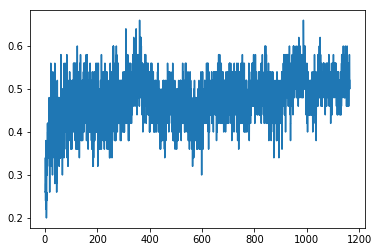

In [16]:
plt.plot(times[1:],acc_callback.testaccuracy)

### Train subject2 and test subject2

In [77]:
A02T = h5py.File('A02T_slice.mat', 'r')
X = np.copy(A02T['image'])
y = np.copy(A02T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [78]:
y_train.shape
np.mean(X_train)

0.29161677

In [79]:
#1000 epochs

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 5s 21ms/step - loss: 1.8841 - acc: 0.2605 - val_loss: 1.8751 - val_acc: 0.2000
Epoch 2/1000
238/238 [==============================] - 0s 456us/step - loss: 1.8643 - acc: 0.3151 - val_loss: 1.8719 - val_acc: 0.2000
Epoch 3/1000
238/238 [==============================] - 0s 530us/step - loss: 1.8686 - acc: 0.2395 - val_loss: 1.8662 - val_acc: 0.2000
Epoch 4/1000
238/238 [==============================] - 0s 549us/step - loss: 1.8626 - acc: 0.2437 - val_loss: 1.8585 - val_acc: 0.1600
Epoch 5/1000
238/238 [==============================] - 0s 560us/step - loss: 1.8442 - acc: 0.2815 - val_loss: 1.8491 - val_acc: 0.2000
Epoch 6/1000
238/238 [==============================] - 0s 517us/step - loss: 1.8397 - acc: 0.2521 - val_loss: 1.8393 - val_acc: 0.1400
Epoch 7/1000
238/238 [==============================] - 0s 580us/step - loss: 1.8303 - acc: 0.2437 - val_loss: 1.8302 - val_acc: 0.2400
Epoc

238/238 [==============================] - 0s 535us/step - loss: 1.5392 - acc: 0.3319 - val_loss: 1.5612 - val_acc: 0.2600
Epoch 61/1000
238/238 [==============================] - 0s 512us/step - loss: 1.5310 - acc: 0.2983 - val_loss: 1.5584 - val_acc: 0.2400
Epoch 62/1000
238/238 [==============================] - 0s 544us/step - loss: 1.5204 - acc: 0.3319 - val_loss: 1.5567 - val_acc: 0.2600
Epoch 63/1000
238/238 [==============================] - 0s 487us/step - loss: 1.5159 - acc: 0.3739 - val_loss: 1.5540 - val_acc: 0.2400
Epoch 64/1000
238/238 [==============================] - 0s 493us/step - loss: 1.5082 - acc: 0.3908 - val_loss: 1.5522 - val_acc: 0.2400
Epoch 65/1000
238/238 [==============================] - 0s 482us/step - loss: 1.5101 - acc: 0.3067 - val_loss: 1.5511 - val_acc: 0.3000
Epoch 66/1000
238/238 [==============================] - 0s 490us/step - loss: 1.4846 - acc: 0.3992 - val_loss: 1.5505 - val_acc: 0.2800
Epoch 67/1000
238/238 [==============================] 

Epoch 120/1000
238/238 [==============================] - 0s 494us/step - loss: 1.2711 - acc: 0.4958 - val_loss: 1.6007 - val_acc: 0.1800
Epoch 121/1000
238/238 [==============================] - 0s 581us/step - loss: 1.2959 - acc: 0.5042 - val_loss: 1.5889 - val_acc: 0.2400
Epoch 122/1000
238/238 [==============================] - 0s 467us/step - loss: 1.2737 - acc: 0.4832 - val_loss: 1.5808 - val_acc: 0.2600
Epoch 123/1000
238/238 [==============================] - 0s 477us/step - loss: 1.3006 - acc: 0.4832 - val_loss: 1.5872 - val_acc: 0.2800
Epoch 124/1000
238/238 [==============================] - 0s 485us/step - loss: 1.2999 - acc: 0.4748 - val_loss: 1.5832 - val_acc: 0.2600
Epoch 125/1000
238/238 [==============================] - 0s 511us/step - loss: 1.2839 - acc: 0.4958 - val_loss: 1.5796 - val_acc: 0.2600
Epoch 126/1000
238/238 [==============================] - 0s 502us/step - loss: 1.2475 - acc: 0.5252 - val_loss: 1.5929 - val_acc: 0.1800
Epoch 127/1000
238/238 [==========

238/238 [==============================] - 0s 492us/step - loss: 1.2014 - acc: 0.5798 - val_loss: 1.6786 - val_acc: 0.3000
Epoch 180/1000
238/238 [==============================] - 0s 503us/step - loss: 1.1654 - acc: 0.5630 - val_loss: 1.6626 - val_acc: 0.3200
Epoch 181/1000
238/238 [==============================] - 0s 487us/step - loss: 1.1602 - acc: 0.5546 - val_loss: 1.6385 - val_acc: 0.2800
Epoch 182/1000
238/238 [==============================] - 0s 552us/step - loss: 1.1421 - acc: 0.5672 - val_loss: 1.5993 - val_acc: 0.3400
Epoch 183/1000
238/238 [==============================] - 0s 473us/step - loss: 1.1261 - acc: 0.5840 - val_loss: 1.5855 - val_acc: 0.3800
Epoch 184/1000
238/238 [==============================] - 0s 474us/step - loss: 1.1120 - acc: 0.6008 - val_loss: 1.6070 - val_acc: 0.3600
Epoch 185/1000
238/238 [==============================] - 0s 476us/step - loss: 1.1105 - acc: 0.5840 - val_loss: 1.6556 - val_acc: 0.3000
Epoch 186/1000
238/238 [=========================

238/238 [==============================] - 0s 502us/step - loss: 0.9880 - acc: 0.6765 - val_loss: 2.0033 - val_acc: 0.2200
Epoch 239/1000
238/238 [==============================] - 0s 488us/step - loss: 1.0169 - acc: 0.7101 - val_loss: 2.0025 - val_acc: 0.2200
Epoch 240/1000
238/238 [==============================] - 0s 507us/step - loss: 1.0392 - acc: 0.6723 - val_loss: 2.0015 - val_acc: 0.2200
Epoch 241/1000
238/238 [==============================] - 0s 479us/step - loss: 1.0389 - acc: 0.6303 - val_loss: 1.9942 - val_acc: 0.2200
Epoch 242/1000
238/238 [==============================] - 0s 500us/step - loss: 1.0867 - acc: 0.6429 - val_loss: 1.9811 - val_acc: 0.2200
Epoch 243/1000
238/238 [==============================] - 0s 548us/step - loss: 0.9776 - acc: 0.6765 - val_loss: 1.9482 - val_acc: 0.2000
Epoch 244/1000
238/238 [==============================] - 0s 513us/step - loss: 1.0255 - acc: 0.6765 - val_loss: 1.9980 - val_acc: 0.2800
Epoch 245/1000
238/238 [=========================

238/238 [==============================] - 0s 523us/step - loss: 0.8915 - acc: 0.7059 - val_loss: 2.1579 - val_acc: 0.2800
Epoch 298/1000
238/238 [==============================] - 0s 505us/step - loss: 0.8937 - acc: 0.7605 - val_loss: 2.0674 - val_acc: 0.2800
Epoch 299/1000
238/238 [==============================] - 0s 513us/step - loss: 0.9118 - acc: 0.7689 - val_loss: 1.9741 - val_acc: 0.3400
Epoch 300/1000
238/238 [==============================] - 0s 505us/step - loss: 0.8870 - acc: 0.7059 - val_loss: 1.9555 - val_acc: 0.3000
Epoch 301/1000
238/238 [==============================] - 0s 482us/step - loss: 0.9662 - acc: 0.7185 - val_loss: 1.9435 - val_acc: 0.2800
Epoch 302/1000
238/238 [==============================] - 0s 501us/step - loss: 1.0023 - acc: 0.6891 - val_loss: 2.0515 - val_acc: 0.2600
Epoch 303/1000
238/238 [==============================] - 0s 485us/step - loss: 1.0082 - acc: 0.6849 - val_loss: 2.1211 - val_acc: 0.2800
Epoch 304/1000
238/238 [=========================

238/238 [==============================] - 0s 481us/step - loss: 0.9040 - acc: 0.7731 - val_loss: 2.2205 - val_acc: 0.2400
Epoch 357/1000
238/238 [==============================] - 0s 490us/step - loss: 0.9065 - acc: 0.7353 - val_loss: 2.1309 - val_acc: 0.2800
Epoch 358/1000
238/238 [==============================] - 0s 472us/step - loss: 0.8561 - acc: 0.7815 - val_loss: 2.1568 - val_acc: 0.2800
Epoch 359/1000
238/238 [==============================] - 0s 528us/step - loss: 0.9115 - acc: 0.7353 - val_loss: 2.1591 - val_acc: 0.3000
Epoch 360/1000
238/238 [==============================] - 0s 485us/step - loss: 0.8261 - acc: 0.7983 - val_loss: 2.1918 - val_acc: 0.3400
Epoch 361/1000
238/238 [==============================] - 0s 497us/step - loss: 0.9628 - acc: 0.7479 - val_loss: 2.1577 - val_acc: 0.3200
Epoch 362/1000
238/238 [==============================] - 0s 475us/step - loss: 0.9228 - acc: 0.7647 - val_loss: 2.1964 - val_acc: 0.3200
Epoch 363/1000
238/238 [=========================

238/238 [==============================] - 0s 489us/step - loss: 0.8188 - acc: 0.8193 - val_loss: 1.9652 - val_acc: 0.3600
Epoch 416/1000
238/238 [==============================] - 0s 504us/step - loss: 0.8701 - acc: 0.7941 - val_loss: 1.9327 - val_acc: 0.3600
Epoch 417/1000
238/238 [==============================] - 0s 504us/step - loss: 0.8578 - acc: 0.7563 - val_loss: 1.9115 - val_acc: 0.3400
Epoch 418/1000
238/238 [==============================] - 0s 597us/step - loss: 0.9182 - acc: 0.7647 - val_loss: 2.0891 - val_acc: 0.3000
Epoch 419/1000
238/238 [==============================] - 0s 470us/step - loss: 0.8982 - acc: 0.7731 - val_loss: 2.0822 - val_acc: 0.2800
Epoch 420/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8532 - acc: 0.7647 - val_loss: 2.0670 - val_acc: 0.3400
Epoch 421/1000
238/238 [==============================] - 0s 496us/step - loss: 0.7719 - acc: 0.8403 - val_loss: 2.0655 - val_acc: 0.2800
Epoch 422/1000
238/238 [=========================

238/238 [==============================] - 0s 502us/step - loss: 0.8103 - acc: 0.8109 - val_loss: 2.2333 - val_acc: 0.3600
Epoch 475/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8950 - acc: 0.7521 - val_loss: 2.3057 - val_acc: 0.3600
Epoch 476/1000
238/238 [==============================] - 0s 485us/step - loss: 0.7433 - acc: 0.8571 - val_loss: 2.3433 - val_acc: 0.3400
Epoch 477/1000
238/238 [==============================] - 0s 495us/step - loss: 0.8406 - acc: 0.7941 - val_loss: 2.1723 - val_acc: 0.3400
Epoch 478/1000
238/238 [==============================] - 0s 483us/step - loss: 0.8023 - acc: 0.8319 - val_loss: 2.1505 - val_acc: 0.4200
Epoch 479/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8508 - acc: 0.7941 - val_loss: 2.1723 - val_acc: 0.3600
Epoch 480/1000
238/238 [==============================] - 0s 480us/step - loss: 0.8099 - acc: 0.8277 - val_loss: 2.1721 - val_acc: 0.3800
Epoch 481/1000
238/238 [=========================

238/238 [==============================] - 0s 509us/step - loss: 0.7981 - acc: 0.8403 - val_loss: 2.1954 - val_acc: 0.3400
Epoch 534/1000
238/238 [==============================] - 0s 506us/step - loss: 0.7444 - acc: 0.8361 - val_loss: 2.1838 - val_acc: 0.3400
Epoch 535/1000
238/238 [==============================] - 0s 494us/step - loss: 0.7176 - acc: 0.8655 - val_loss: 2.2606 - val_acc: 0.3400
Epoch 536/1000
238/238 [==============================] - 0s 505us/step - loss: 0.7579 - acc: 0.8277 - val_loss: 2.3329 - val_acc: 0.3400
Epoch 537/1000
238/238 [==============================] - 0s 539us/step - loss: 0.7913 - acc: 0.8151 - val_loss: 2.3017 - val_acc: 0.3600
Epoch 538/1000
238/238 [==============================] - 0s 639us/step - loss: 0.7960 - acc: 0.8109 - val_loss: 2.2801 - val_acc: 0.4000
Epoch 539/1000
238/238 [==============================] - 0s 575us/step - loss: 0.7083 - acc: 0.8445 - val_loss: 2.3103 - val_acc: 0.3200
Epoch 540/1000
238/238 [=========================

238/238 [==============================] - 0s 515us/step - loss: 0.7503 - acc: 0.8487 - val_loss: 2.5156 - val_acc: 0.2400
Epoch 593/1000
238/238 [==============================] - 0s 505us/step - loss: 0.7931 - acc: 0.8529 - val_loss: 2.5344 - val_acc: 0.2000
Epoch 594/1000
238/238 [==============================] - 0s 528us/step - loss: 0.8365 - acc: 0.8235 - val_loss: 2.4794 - val_acc: 0.2000
Epoch 595/1000
238/238 [==============================] - 0s 480us/step - loss: 0.7332 - acc: 0.8529 - val_loss: 2.3674 - val_acc: 0.3000
Epoch 596/1000
238/238 [==============================] - 0s 479us/step - loss: 0.7937 - acc: 0.8529 - val_loss: 2.4052 - val_acc: 0.3000
Epoch 597/1000
238/238 [==============================] - 0s 501us/step - loss: 0.8128 - acc: 0.8193 - val_loss: 2.3913 - val_acc: 0.2800
Epoch 598/1000
238/238 [==============================] - 0s 496us/step - loss: 0.6772 - acc: 0.8739 - val_loss: 2.4168 - val_acc: 0.2800
Epoch 599/1000
238/238 [=========================

238/238 [==============================] - 0s 524us/step - loss: 0.7503 - acc: 0.8529 - val_loss: 2.2818 - val_acc: 0.3600
Epoch 652/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7430 - acc: 0.8571 - val_loss: 2.3444 - val_acc: 0.3200
Epoch 653/1000
238/238 [==============================] - 0s 518us/step - loss: 0.7553 - acc: 0.8529 - val_loss: 2.4021 - val_acc: 0.2800
Epoch 654/1000
238/238 [==============================] - 0s 543us/step - loss: 0.9398 - acc: 0.7983 - val_loss: 2.3357 - val_acc: 0.3000
Epoch 655/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7918 - acc: 0.8361 - val_loss: 2.3710 - val_acc: 0.3200
Epoch 656/1000
238/238 [==============================] - 0s 495us/step - loss: 0.8363 - acc: 0.8319 - val_loss: 2.4821 - val_acc: 0.3000
Epoch 657/1000
238/238 [==============================] - 0s 509us/step - loss: 0.8538 - acc: 0.8151 - val_loss: 2.2800 - val_acc: 0.3600
Epoch 658/1000
238/238 [=========================

238/238 [==============================] - 0s 530us/step - loss: 0.7344 - acc: 0.8697 - val_loss: 2.4003 - val_acc: 0.2800
Epoch 711/1000
238/238 [==============================] - 0s 519us/step - loss: 0.7913 - acc: 0.8277 - val_loss: 2.3478 - val_acc: 0.2800
Epoch 712/1000
238/238 [==============================] - 0s 536us/step - loss: 0.7765 - acc: 0.8277 - val_loss: 2.3345 - val_acc: 0.3200
Epoch 713/1000
238/238 [==============================] - 0s 527us/step - loss: 0.6953 - acc: 0.8782 - val_loss: 2.2787 - val_acc: 0.3400
Epoch 714/1000
238/238 [==============================] - 0s 545us/step - loss: 0.7727 - acc: 0.8487 - val_loss: 2.3016 - val_acc: 0.3000
Epoch 715/1000
238/238 [==============================] - 0s 479us/step - loss: 0.8351 - acc: 0.8361 - val_loss: 2.4414 - val_acc: 0.2800
Epoch 716/1000
238/238 [==============================] - 0s 481us/step - loss: 0.7459 - acc: 0.8403 - val_loss: 2.3163 - val_acc: 0.3400
Epoch 717/1000
238/238 [=========================

238/238 [==============================] - 0s 500us/step - loss: 0.7542 - acc: 0.8613 - val_loss: 2.4765 - val_acc: 0.2600
Epoch 770/1000
238/238 [==============================] - 0s 488us/step - loss: 0.6820 - acc: 0.8739 - val_loss: 2.4464 - val_acc: 0.2800
Epoch 771/1000
238/238 [==============================] - 0s 475us/step - loss: 0.7027 - acc: 0.8739 - val_loss: 2.3925 - val_acc: 0.3600
Epoch 772/1000
238/238 [==============================] - 0s 474us/step - loss: 0.7256 - acc: 0.8235 - val_loss: 2.5411 - val_acc: 0.2600
Epoch 773/1000
238/238 [==============================] - 0s 485us/step - loss: 0.6968 - acc: 0.8613 - val_loss: 2.5393 - val_acc: 0.2400
Epoch 774/1000
238/238 [==============================] - 0s 503us/step - loss: 0.7983 - acc: 0.8193 - val_loss: 2.4888 - val_acc: 0.2400
Epoch 775/1000
238/238 [==============================] - 0s 492us/step - loss: 0.7778 - acc: 0.8445 - val_loss: 2.4562 - val_acc: 0.2600
Epoch 776/1000
238/238 [=========================

238/238 [==============================] - 0s 518us/step - loss: 0.6780 - acc: 0.8824 - val_loss: 2.2891 - val_acc: 0.3000
Epoch 829/1000
238/238 [==============================] - 0s 526us/step - loss: 0.6521 - acc: 0.8782 - val_loss: 2.3408 - val_acc: 0.3200
Epoch 830/1000
238/238 [==============================] - 0s 478us/step - loss: 0.7269 - acc: 0.8613 - val_loss: 2.3864 - val_acc: 0.3400
Epoch 831/1000
238/238 [==============================] - 0s 522us/step - loss: 0.6571 - acc: 0.8739 - val_loss: 2.4219 - val_acc: 0.3200
Epoch 832/1000
238/238 [==============================] - 0s 475us/step - loss: 0.6483 - acc: 0.8782 - val_loss: 2.3766 - val_acc: 0.3400
Epoch 833/1000
238/238 [==============================] - 0s 500us/step - loss: 0.6073 - acc: 0.9034 - val_loss: 2.2825 - val_acc: 0.3000
Epoch 834/1000
238/238 [==============================] - 0s 482us/step - loss: 0.6753 - acc: 0.8487 - val_loss: 2.1713 - val_acc: 0.3400
Epoch 835/1000
238/238 [=========================

238/238 [==============================] - 0s 496us/step - loss: 0.6326 - acc: 0.8866 - val_loss: 2.3623 - val_acc: 0.3200
Epoch 888/1000
238/238 [==============================] - 0s 480us/step - loss: 0.6348 - acc: 0.8824 - val_loss: 2.3993 - val_acc: 0.2600
Epoch 889/1000
238/238 [==============================] - 0s 556us/step - loss: 0.6385 - acc: 0.8866 - val_loss: 2.4293 - val_acc: 0.3200
Epoch 890/1000
238/238 [==============================] - 0s 494us/step - loss: 0.5700 - acc: 0.8950 - val_loss: 2.5055 - val_acc: 0.3200
Epoch 891/1000
238/238 [==============================] - 0s 502us/step - loss: 0.6972 - acc: 0.8613 - val_loss: 2.5891 - val_acc: 0.3200
Epoch 892/1000
238/238 [==============================] - 0s 484us/step - loss: 0.6471 - acc: 0.8866 - val_loss: 2.5586 - val_acc: 0.3000
Epoch 893/1000
238/238 [==============================] - 0s 546us/step - loss: 0.6885 - acc: 0.8403 - val_loss: 2.4176 - val_acc: 0.2600
Epoch 894/1000
238/238 [=========================

238/238 [==============================] - 0s 572us/step - loss: 0.5386 - acc: 0.9202 - val_loss: 2.3926 - val_acc: 0.3200
Epoch 947/1000
238/238 [==============================] - 0s 636us/step - loss: 0.5963 - acc: 0.8950 - val_loss: 2.3797 - val_acc: 0.2600
Epoch 948/1000
238/238 [==============================] - 0s 557us/step - loss: 0.6871 - acc: 0.8613 - val_loss: 2.3752 - val_acc: 0.2600
Epoch 949/1000
238/238 [==============================] - 0s 607us/step - loss: 0.6545 - acc: 0.8739 - val_loss: 2.3304 - val_acc: 0.3000
Epoch 950/1000
238/238 [==============================] - 0s 520us/step - loss: 0.6094 - acc: 0.8655 - val_loss: 2.2604 - val_acc: 0.3000
Epoch 951/1000
238/238 [==============================] - 0s 584us/step - loss: 0.6749 - acc: 0.8613 - val_loss: 2.1546 - val_acc: 0.3400
Epoch 952/1000
238/238 [==============================] - 0s 574us/step - loss: 0.6454 - acc: 0.8571 - val_loss: 2.2029 - val_acc: 0.3800
Epoch 953/1000
238/238 [=========================

0.4399999976158142


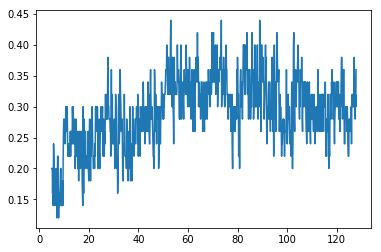

In [80]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject3 and test subject3

In [81]:
A03T = h5py.File('A03T_slice.mat', 'r')
X = np.copy(A03T['image'])
y = np.copy(A03T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [82]:
from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 5s 20ms/step - loss: 1.8753 - acc: 0.2479 - val_loss: 1.8633 - val_acc: 0.2600
Epoch 2/1000
238/238 [==============================] - 0s 510us/step - loss: 1.8640 - acc: 0.2647 - val_loss: 1.8588 - val_acc: 0.2400
Epoch 3/1000
238/238 [==============================] - 0s 526us/step - loss: 1.8608 - acc: 0.2605 - val_loss: 1.8538 - val_acc: 0.3200
Epoch 4/1000
238/238 [==============================] - 0s 576us/step - loss: 1.8505 - acc: 0.2857 - val_loss: 1.8461 - val_acc: 0.2800
Epoch 5/1000
238/238 [==============================] - 0s 512us/step - loss: 1.8421 - acc: 0.2647 - val_loss: 1.8397 - val_acc: 0.2800
Epoch 6/1000
238/238 [==============================] - 0s 533us/step - loss: 1.8287 - acc: 0.2983 - val_loss: 1.8373 - val_acc: 0.2200
Epoch 7/1000
238/238 [==============================] - 0s 574us/step - loss: 1.8280 - acc: 0.2521 - val_loss: 1.8332 - val_acc: 0.2400
Epoc

238/238 [==============================] - 0s 551us/step - loss: 1.5282 - acc: 0.3109 - val_loss: 1.5670 - val_acc: 0.2400
Epoch 61/1000
238/238 [==============================] - 0s 587us/step - loss: 1.5247 - acc: 0.3151 - val_loss: 1.5645 - val_acc: 0.2400
Epoch 62/1000
238/238 [==============================] - 0s 593us/step - loss: 1.5192 - acc: 0.2857 - val_loss: 1.5572 - val_acc: 0.2600
Epoch 63/1000
238/238 [==============================] - 0s 526us/step - loss: 1.5024 - acc: 0.3950 - val_loss: 1.5506 - val_acc: 0.1400
Epoch 64/1000
238/238 [==============================] - 0s 580us/step - loss: 1.5050 - acc: 0.3613 - val_loss: 1.5479 - val_acc: 0.1200
Epoch 65/1000
238/238 [==============================] - 0s 532us/step - loss: 1.5008 - acc: 0.3529 - val_loss: 1.5487 - val_acc: 0.2000
Epoch 66/1000
238/238 [==============================] - 0s 517us/step - loss: 1.4967 - acc: 0.3613 - val_loss: 1.5478 - val_acc: 0.2200
Epoch 67/1000
238/238 [==============================] 

Epoch 120/1000
238/238 [==============================] - 0s 511us/step - loss: 1.2277 - acc: 0.4496 - val_loss: 1.4787 - val_acc: 0.3600
Epoch 121/1000
238/238 [==============================] - 0s 502us/step - loss: 1.2190 - acc: 0.4538 - val_loss: 1.4995 - val_acc: 0.3600
Epoch 122/1000
238/238 [==============================] - 0s 518us/step - loss: 1.2242 - acc: 0.4664 - val_loss: 1.5094 - val_acc: 0.4000
Epoch 123/1000
238/238 [==============================] - 0s 617us/step - loss: 1.2353 - acc: 0.4916 - val_loss: 1.5078 - val_acc: 0.3400
Epoch 124/1000
238/238 [==============================] - 0s 654us/step - loss: 1.2436 - acc: 0.4622 - val_loss: 1.5092 - val_acc: 0.3400
Epoch 125/1000
238/238 [==============================] - 0s 515us/step - loss: 1.2397 - acc: 0.4790 - val_loss: 1.5450 - val_acc: 0.3200
Epoch 126/1000
238/238 [==============================] - 0s 500us/step - loss: 1.2875 - acc: 0.4622 - val_loss: 1.6381 - val_acc: 0.3200
Epoch 127/1000
238/238 [==========

238/238 [==============================] - 0s 519us/step - loss: 1.1875 - acc: 0.4622 - val_loss: 1.8006 - val_acc: 0.3400
Epoch 180/1000
238/238 [==============================] - 0s 563us/step - loss: 1.1418 - acc: 0.4538 - val_loss: 1.7354 - val_acc: 0.3600
Epoch 181/1000
238/238 [==============================] - 0s 531us/step - loss: 1.1210 - acc: 0.5630 - val_loss: 1.7944 - val_acc: 0.4000
Epoch 182/1000
238/238 [==============================] - 0s 587us/step - loss: 1.1540 - acc: 0.5042 - val_loss: 1.8450 - val_acc: 0.3400
Epoch 183/1000
238/238 [==============================] - 0s 515us/step - loss: 1.1425 - acc: 0.5336 - val_loss: 1.7445 - val_acc: 0.4000
Epoch 184/1000
238/238 [==============================] - 0s 512us/step - loss: 1.1197 - acc: 0.5252 - val_loss: 1.6713 - val_acc: 0.4400
Epoch 185/1000
238/238 [==============================] - 0s 524us/step - loss: 1.1955 - acc: 0.5294 - val_loss: 1.6529 - val_acc: 0.4600
Epoch 186/1000
238/238 [=========================

238/238 [==============================] - 0s 510us/step - loss: 1.1214 - acc: 0.5294 - val_loss: 1.8782 - val_acc: 0.2600
Epoch 239/1000
238/238 [==============================] - 0s 519us/step - loss: 1.2281 - acc: 0.5000 - val_loss: 1.8759 - val_acc: 0.3000
Epoch 240/1000
238/238 [==============================] - 0s 506us/step - loss: 1.1954 - acc: 0.5294 - val_loss: 1.8290 - val_acc: 0.3200
Epoch 241/1000
238/238 [==============================] - 0s 539us/step - loss: 1.1463 - acc: 0.5588 - val_loss: 1.8226 - val_acc: 0.4000
Epoch 242/1000
238/238 [==============================] - 0s 556us/step - loss: 1.1733 - acc: 0.5252 - val_loss: 1.7773 - val_acc: 0.4000
Epoch 243/1000
238/238 [==============================] - 0s 515us/step - loss: 1.1367 - acc: 0.5756 - val_loss: 1.7613 - val_acc: 0.4200
Epoch 244/1000
238/238 [==============================] - 0s 528us/step - loss: 1.1344 - acc: 0.5630 - val_loss: 1.7136 - val_acc: 0.3600
Epoch 245/1000
238/238 [=========================

238/238 [==============================] - 0s 565us/step - loss: 1.1206 - acc: 0.5210 - val_loss: 1.8013 - val_acc: 0.3400
Epoch 298/1000
238/238 [==============================] - 0s 515us/step - loss: 1.0619 - acc: 0.5504 - val_loss: 1.7435 - val_acc: 0.3800
Epoch 299/1000
238/238 [==============================] - 0s 553us/step - loss: 1.1091 - acc: 0.6050 - val_loss: 1.9843 - val_acc: 0.4000
Epoch 300/1000
238/238 [==============================] - 0s 494us/step - loss: 1.1151 - acc: 0.5504 - val_loss: 1.8759 - val_acc: 0.4600
Epoch 301/1000
238/238 [==============================] - 0s 520us/step - loss: 1.0943 - acc: 0.5546 - val_loss: 1.8666 - val_acc: 0.3400
Epoch 302/1000
238/238 [==============================] - 0s 507us/step - loss: 1.1453 - acc: 0.5798 - val_loss: 1.7949 - val_acc: 0.4000
Epoch 303/1000
238/238 [==============================] - 0s 501us/step - loss: 1.0594 - acc: 0.6092 - val_loss: 1.9043 - val_acc: 0.4200
Epoch 304/1000
238/238 [=========================

238/238 [==============================] - 0s 563us/step - loss: 1.1341 - acc: 0.5672 - val_loss: 2.2447 - val_acc: 0.2400
Epoch 357/1000
238/238 [==============================] - 0s 684us/step - loss: 1.0324 - acc: 0.5966 - val_loss: 2.2183 - val_acc: 0.2400
Epoch 358/1000
238/238 [==============================] - 0s 536us/step - loss: 1.0651 - acc: 0.6218 - val_loss: 2.0934 - val_acc: 0.3400
Epoch 359/1000
238/238 [==============================] - 0s 523us/step - loss: 1.1365 - acc: 0.6387 - val_loss: 2.0435 - val_acc: 0.2400
Epoch 360/1000
238/238 [==============================] - 0s 498us/step - loss: 0.9928 - acc: 0.6050 - val_loss: 2.0606 - val_acc: 0.1800
Epoch 361/1000
238/238 [==============================] - 0s 509us/step - loss: 1.1269 - acc: 0.5882 - val_loss: 1.9802 - val_acc: 0.1800
Epoch 362/1000
238/238 [==============================] - 0s 506us/step - loss: 0.9895 - acc: 0.6597 - val_loss: 1.9137 - val_acc: 0.3200
Epoch 363/1000
238/238 [=========================

238/238 [==============================] - 0s 554us/step - loss: 0.9745 - acc: 0.6891 - val_loss: 1.9877 - val_acc: 0.3600
Epoch 416/1000
238/238 [==============================] - 0s 626us/step - loss: 1.0173 - acc: 0.6176 - val_loss: 2.0080 - val_acc: 0.3800
Epoch 417/1000
238/238 [==============================] - 0s 595us/step - loss: 1.0782 - acc: 0.5966 - val_loss: 2.0497 - val_acc: 0.3400
Epoch 418/1000
238/238 [==============================] - 0s 556us/step - loss: 0.9090 - acc: 0.6849 - val_loss: 2.1421 - val_acc: 0.3000
Epoch 419/1000
238/238 [==============================] - 0s 561us/step - loss: 0.9655 - acc: 0.6597 - val_loss: 2.1906 - val_acc: 0.3400
Epoch 420/1000
238/238 [==============================] - 0s 605us/step - loss: 0.9568 - acc: 0.6261 - val_loss: 2.1675 - val_acc: 0.3000
Epoch 421/1000
238/238 [==============================] - 0s 544us/step - loss: 1.0501 - acc: 0.6387 - val_loss: 2.1487 - val_acc: 0.2800
Epoch 422/1000
238/238 [=========================

238/238 [==============================] - 0s 532us/step - loss: 0.9028 - acc: 0.7311 - val_loss: 2.0282 - val_acc: 0.3800
Epoch 475/1000
238/238 [==============================] - 0s 569us/step - loss: 0.9210 - acc: 0.6891 - val_loss: 2.0225 - val_acc: 0.3800
Epoch 476/1000
238/238 [==============================] - 0s 576us/step - loss: 0.9773 - acc: 0.6639 - val_loss: 2.0583 - val_acc: 0.3200
Epoch 477/1000
238/238 [==============================] - 0s 499us/step - loss: 0.9263 - acc: 0.6849 - val_loss: 2.0903 - val_acc: 0.3200
Epoch 478/1000
238/238 [==============================] - 0s 527us/step - loss: 0.9108 - acc: 0.6681 - val_loss: 2.0838 - val_acc: 0.3000
Epoch 479/1000
238/238 [==============================] - 0s 493us/step - loss: 0.8700 - acc: 0.7143 - val_loss: 2.0247 - val_acc: 0.3200
Epoch 480/1000
238/238 [==============================] - 0s 520us/step - loss: 0.9399 - acc: 0.6933 - val_loss: 1.9767 - val_acc: 0.3200
Epoch 481/1000
238/238 [=========================

238/238 [==============================] - 0s 476us/step - loss: 0.9232 - acc: 0.7143 - val_loss: 2.1936 - val_acc: 0.3200
Epoch 534/1000
238/238 [==============================] - 0s 561us/step - loss: 0.8808 - acc: 0.7311 - val_loss: 2.2009 - val_acc: 0.3400
Epoch 535/1000
238/238 [==============================] - 0s 482us/step - loss: 0.8426 - acc: 0.7311 - val_loss: 2.2098 - val_acc: 0.3600
Epoch 536/1000
238/238 [==============================] - 0s 558us/step - loss: 0.8729 - acc: 0.7227 - val_loss: 2.1867 - val_acc: 0.3600
Epoch 537/1000
238/238 [==============================] - 0s 487us/step - loss: 0.8609 - acc: 0.7437 - val_loss: 2.1580 - val_acc: 0.4000
Epoch 538/1000
238/238 [==============================] - 0s 569us/step - loss: 0.9476 - acc: 0.6849 - val_loss: 2.1559 - val_acc: 0.4200
Epoch 539/1000
238/238 [==============================] - 0s 551us/step - loss: 0.9900 - acc: 0.6639 - val_loss: 2.1829 - val_acc: 0.4400
Epoch 540/1000
238/238 [=========================

238/238 [==============================] - 0s 514us/step - loss: 0.8763 - acc: 0.7185 - val_loss: 2.1035 - val_acc: 0.3200
Epoch 593/1000
238/238 [==============================] - 0s 570us/step - loss: 0.8220 - acc: 0.7437 - val_loss: 2.1029 - val_acc: 0.3200
Epoch 594/1000
238/238 [==============================] - 0s 524us/step - loss: 0.8718 - acc: 0.7521 - val_loss: 2.0521 - val_acc: 0.3200
Epoch 595/1000
238/238 [==============================] - 0s 608us/step - loss: 0.8230 - acc: 0.7521 - val_loss: 1.9782 - val_acc: 0.3000
Epoch 596/1000
238/238 [==============================] - 0s 637us/step - loss: 0.8637 - acc: 0.7521 - val_loss: 2.0382 - val_acc: 0.3200
Epoch 597/1000
238/238 [==============================] - 0s 511us/step - loss: 0.9040 - acc: 0.7269 - val_loss: 2.1035 - val_acc: 0.3000
Epoch 598/1000
238/238 [==============================] - 0s 510us/step - loss: 0.8437 - acc: 0.7689 - val_loss: 2.0394 - val_acc: 0.4000
Epoch 599/1000
238/238 [=========================

238/238 [==============================] - 0s 594us/step - loss: 0.9407 - acc: 0.6933 - val_loss: 2.2099 - val_acc: 0.3000
Epoch 652/1000
238/238 [==============================] - 0s 541us/step - loss: 1.0637 - acc: 0.6849 - val_loss: 2.0834 - val_acc: 0.3200
Epoch 653/1000
238/238 [==============================] - 0s 507us/step - loss: 0.9438 - acc: 0.7479 - val_loss: 2.0355 - val_acc: 0.3600
Epoch 654/1000
238/238 [==============================] - 0s 516us/step - loss: 0.8469 - acc: 0.7437 - val_loss: 2.1666 - val_acc: 0.4200
Epoch 655/1000
238/238 [==============================] - 0s 603us/step - loss: 0.8660 - acc: 0.7311 - val_loss: 2.1242 - val_acc: 0.4200
Epoch 656/1000
238/238 [==============================] - 0s 578us/step - loss: 0.9336 - acc: 0.7185 - val_loss: 2.0660 - val_acc: 0.4000
Epoch 657/1000
238/238 [==============================] - 0s 584us/step - loss: 0.8962 - acc: 0.7437 - val_loss: 2.1212 - val_acc: 0.3000
Epoch 658/1000
238/238 [=========================

238/238 [==============================] - 0s 541us/step - loss: 0.8747 - acc: 0.7521 - val_loss: 1.9598 - val_acc: 0.3600
Epoch 711/1000
238/238 [==============================] - 0s 525us/step - loss: 0.8058 - acc: 0.7731 - val_loss: 1.9798 - val_acc: 0.3800
Epoch 712/1000
238/238 [==============================] - 0s 499us/step - loss: 0.8365 - acc: 0.7731 - val_loss: 2.0877 - val_acc: 0.4000
Epoch 713/1000
238/238 [==============================] - 0s 508us/step - loss: 0.7827 - acc: 0.8235 - val_loss: 2.1242 - val_acc: 0.3600
Epoch 714/1000
238/238 [==============================] - 0s 506us/step - loss: 0.8041 - acc: 0.7899 - val_loss: 2.1319 - val_acc: 0.2800
Epoch 715/1000
238/238 [==============================] - 0s 511us/step - loss: 0.8102 - acc: 0.7647 - val_loss: 2.0761 - val_acc: 0.3600
Epoch 716/1000
238/238 [==============================] - 0s 529us/step - loss: 0.7967 - acc: 0.7941 - val_loss: 2.0911 - val_acc: 0.3400
Epoch 717/1000
238/238 [=========================

238/238 [==============================] - 0s 514us/step - loss: 0.7779 - acc: 0.7857 - val_loss: 2.1692 - val_acc: 0.3400
Epoch 770/1000
238/238 [==============================] - 0s 572us/step - loss: 0.8523 - acc: 0.7563 - val_loss: 2.1038 - val_acc: 0.3600
Epoch 771/1000
238/238 [==============================] - 0s 502us/step - loss: 0.8015 - acc: 0.7857 - val_loss: 2.0329 - val_acc: 0.4000
Epoch 772/1000
238/238 [==============================] - 0s 513us/step - loss: 0.8165 - acc: 0.7941 - val_loss: 2.0203 - val_acc: 0.4000
Epoch 773/1000
238/238 [==============================] - 0s 501us/step - loss: 0.7572 - acc: 0.8067 - val_loss: 2.0784 - val_acc: 0.3800
Epoch 774/1000
238/238 [==============================] - 0s 507us/step - loss: 0.8010 - acc: 0.7689 - val_loss: 2.0312 - val_acc: 0.4200
Epoch 775/1000
238/238 [==============================] - 0s 495us/step - loss: 0.7826 - acc: 0.8235 - val_loss: 2.0590 - val_acc: 0.4800
Epoch 776/1000
238/238 [=========================

238/238 [==============================] - 0s 514us/step - loss: 0.7307 - acc: 0.8235 - val_loss: 2.0711 - val_acc: 0.3000
Epoch 829/1000
238/238 [==============================] - 0s 524us/step - loss: 0.7971 - acc: 0.8025 - val_loss: 2.0199 - val_acc: 0.4200
Epoch 830/1000
238/238 [==============================] - 0s 501us/step - loss: 0.7858 - acc: 0.8025 - val_loss: 2.0862 - val_acc: 0.4000
Epoch 831/1000
238/238 [==============================] - 0s 500us/step - loss: 0.7684 - acc: 0.8109 - val_loss: 2.0410 - val_acc: 0.3600
Epoch 832/1000
238/238 [==============================] - 0s 497us/step - loss: 0.6817 - acc: 0.8193 - val_loss: 2.0648 - val_acc: 0.3000
Epoch 833/1000
238/238 [==============================] - 0s 498us/step - loss: 0.6462 - acc: 0.8571 - val_loss: 2.0593 - val_acc: 0.3800
Epoch 834/1000
238/238 [==============================] - 0s 505us/step - loss: 0.7506 - acc: 0.8067 - val_loss: 1.9509 - val_acc: 0.4000
Epoch 835/1000
238/238 [=========================

238/238 [==============================] - 0s 516us/step - loss: 0.7283 - acc: 0.8361 - val_loss: 1.9150 - val_acc: 0.3200
Epoch 888/1000
238/238 [==============================] - 0s 503us/step - loss: 0.6974 - acc: 0.8319 - val_loss: 1.8722 - val_acc: 0.3400
Epoch 889/1000
238/238 [==============================] - 0s 503us/step - loss: 0.7395 - acc: 0.8277 - val_loss: 1.8563 - val_acc: 0.4000
Epoch 890/1000
238/238 [==============================] - 0s 512us/step - loss: 0.6878 - acc: 0.8487 - val_loss: 1.7963 - val_acc: 0.4200
Epoch 891/1000
238/238 [==============================] - 0s 536us/step - loss: 0.7163 - acc: 0.8403 - val_loss: 1.7965 - val_acc: 0.4200
Epoch 892/1000
238/238 [==============================] - 0s 522us/step - loss: 0.7564 - acc: 0.8319 - val_loss: 1.8086 - val_acc: 0.3800
Epoch 893/1000
238/238 [==============================] - 0s 543us/step - loss: 0.6143 - acc: 0.8866 - val_loss: 1.8299 - val_acc: 0.4400
Epoch 894/1000
238/238 [=========================

238/238 [==============================] - 0s 505us/step - loss: 0.6108 - acc: 0.8866 - val_loss: 1.8882 - val_acc: 0.4600
Epoch 947/1000
238/238 [==============================] - 0s 511us/step - loss: 0.6360 - acc: 0.8950 - val_loss: 1.9679 - val_acc: 0.4400
Epoch 948/1000
238/238 [==============================] - 0s 509us/step - loss: 0.6513 - acc: 0.8487 - val_loss: 2.0869 - val_acc: 0.3200
Epoch 949/1000
238/238 [==============================] - 0s 502us/step - loss: 0.6403 - acc: 0.8655 - val_loss: 2.1823 - val_acc: 0.3400
Epoch 950/1000
238/238 [==============================] - 0s 493us/step - loss: 0.8185 - acc: 0.8109 - val_loss: 2.1198 - val_acc: 0.3400
Epoch 951/1000
238/238 [==============================] - 0s 504us/step - loss: 0.7468 - acc: 0.8235 - val_loss: 2.2385 - val_acc: 0.3400
Epoch 952/1000
238/238 [==============================] - 0s 507us/step - loss: 0.7837 - acc: 0.8067 - val_loss: 2.1515 - val_acc: 0.3200
Epoch 953/1000
238/238 [=========================

0.5


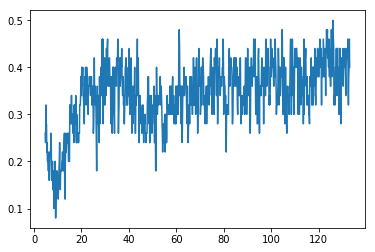

In [83]:

plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject4 and test subject4

In [98]:
A04T = h5py.File('A04T_slice.mat', 'r')
X = np.copy(A04T['image'])
y = np.copy(A04T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [85]:
from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 5s 21ms/step - loss: 1.8796 - acc: 0.2647 - val_loss: 1.8689 - val_acc: 0.3400
Epoch 2/1000
238/238 [==============================] - 0s 501us/step - loss: 1.8737 - acc: 0.2143 - val_loss: 1.8640 - val_acc: 0.3400
Epoch 3/1000
238/238 [==============================] - 0s 489us/step - loss: 1.8733 - acc: 0.2353 - val_loss: 1.8581 - val_acc: 0.2800
Epoch 4/1000
238/238 [==============================] - 0s 518us/step - loss: 1.8799 - acc: 0.1933 - val_loss: 1.8512 - val_acc: 0.3000
Epoch 5/1000
238/238 [==============================] - 0s 528us/step - loss: 1.8587 - acc: 0.2521 - val_loss: 1.8418 - val_acc: 0.3000
Epoch 6/1000
238/238 [==============================] - 0s 515us/step - loss: 1.8381 - acc: 0.3109 - val_loss: 1.8341 - val_acc: 0.2800
Epoch 7/1000
238/238 [==============================] - 0s 544us/step - loss: 1.8296 - acc: 0.2437 - val_loss: 1.8244 - val_acc: 0.3400
Epoc

238/238 [==============================] - 0s 605us/step - loss: 1.5128 - acc: 0.3529 - val_loss: 1.5801 - val_acc: 0.3200
Epoch 61/1000
238/238 [==============================] - 0s 484us/step - loss: 1.5202 - acc: 0.3361 - val_loss: 1.5851 - val_acc: 0.2000
Epoch 62/1000
238/238 [==============================] - 0s 504us/step - loss: 1.5044 - acc: 0.3866 - val_loss: 1.5876 - val_acc: 0.1800
Epoch 63/1000
238/238 [==============================] - 0s 470us/step - loss: 1.4731 - acc: 0.4286 - val_loss: 1.5865 - val_acc: 0.2200
Epoch 64/1000
238/238 [==============================] - 0s 496us/step - loss: 1.4937 - acc: 0.3571 - val_loss: 1.5892 - val_acc: 0.2600
Epoch 65/1000
238/238 [==============================] - 0s 516us/step - loss: 1.4927 - acc: 0.3613 - val_loss: 1.5863 - val_acc: 0.2800
Epoch 66/1000
238/238 [==============================] - 0s 465us/step - loss: 1.4652 - acc: 0.3655 - val_loss: 1.5858 - val_acc: 0.2600
Epoch 67/1000
238/238 [==============================] 

Epoch 120/1000
238/238 [==============================] - 0s 473us/step - loss: 1.1848 - acc: 0.4874 - val_loss: 1.6475 - val_acc: 0.3000
Epoch 121/1000
238/238 [==============================] - 0s 473us/step - loss: 1.1841 - acc: 0.5042 - val_loss: 1.6489 - val_acc: 0.2800
Epoch 122/1000
238/238 [==============================] - 0s 460us/step - loss: 1.1972 - acc: 0.5420 - val_loss: 1.6507 - val_acc: 0.2800
Epoch 123/1000
238/238 [==============================] - 0s 543us/step - loss: 1.1881 - acc: 0.5210 - val_loss: 1.6093 - val_acc: 0.2800
Epoch 124/1000
238/238 [==============================] - 0s 486us/step - loss: 1.1881 - acc: 0.5126 - val_loss: 1.5997 - val_acc: 0.2800
Epoch 125/1000
238/238 [==============================] - 0s 463us/step - loss: 1.2226 - acc: 0.5210 - val_loss: 1.6092 - val_acc: 0.3000
Epoch 126/1000
238/238 [==============================] - 0s 493us/step - loss: 1.2015 - acc: 0.5210 - val_loss: 1.5664 - val_acc: 0.3000
Epoch 127/1000
238/238 [==========

238/238 [==============================] - 0s 461us/step - loss: 1.1161 - acc: 0.6008 - val_loss: 1.7444 - val_acc: 0.2000
Epoch 180/1000
238/238 [==============================] - 0s 473us/step - loss: 1.0521 - acc: 0.5966 - val_loss: 1.7364 - val_acc: 0.2400
Epoch 181/1000
238/238 [==============================] - 0s 546us/step - loss: 1.0520 - acc: 0.6218 - val_loss: 1.7604 - val_acc: 0.2200
Epoch 182/1000
238/238 [==============================] - 0s 486us/step - loss: 1.0322 - acc: 0.5714 - val_loss: 1.7229 - val_acc: 0.2600
Epoch 183/1000
238/238 [==============================] - 0s 465us/step - loss: 1.0667 - acc: 0.5966 - val_loss: 1.7358 - val_acc: 0.2800
Epoch 184/1000
238/238 [==============================] - 0s 463us/step - loss: 1.0664 - acc: 0.5756 - val_loss: 1.7390 - val_acc: 0.2800
Epoch 185/1000
238/238 [==============================] - 0s 463us/step - loss: 1.0157 - acc: 0.6176 - val_loss: 1.7838 - val_acc: 0.2600
Epoch 186/1000
238/238 [=========================

238/238 [==============================] - 0s 472us/step - loss: 0.9748 - acc: 0.6345 - val_loss: 2.0569 - val_acc: 0.2800
Epoch 239/1000
238/238 [==============================] - 0s 481us/step - loss: 1.0001 - acc: 0.6387 - val_loss: 2.0192 - val_acc: 0.2800
Epoch 240/1000
238/238 [==============================] - 0s 477us/step - loss: 0.9878 - acc: 0.6555 - val_loss: 2.0099 - val_acc: 0.2000
Epoch 241/1000
238/238 [==============================] - 0s 475us/step - loss: 0.9371 - acc: 0.6345 - val_loss: 2.1841 - val_acc: 0.2000
Epoch 242/1000
238/238 [==============================] - 0s 465us/step - loss: 1.0339 - acc: 0.6008 - val_loss: 2.1825 - val_acc: 0.2200
Epoch 243/1000
238/238 [==============================] - 0s 462us/step - loss: 1.1531 - acc: 0.6261 - val_loss: 2.2131 - val_acc: 0.2000
Epoch 244/1000
238/238 [==============================] - 0s 467us/step - loss: 1.0043 - acc: 0.6429 - val_loss: 2.2398 - val_acc: 0.1800
Epoch 245/1000
238/238 [=========================

238/238 [==============================] - 0s 460us/step - loss: 1.0825 - acc: 0.6723 - val_loss: 2.1098 - val_acc: 0.3000
Epoch 298/1000
238/238 [==============================] - 0s 470us/step - loss: 0.9568 - acc: 0.6471 - val_loss: 2.1292 - val_acc: 0.2800
Epoch 299/1000
238/238 [==============================] - 0s 465us/step - loss: 1.0088 - acc: 0.6429 - val_loss: 2.1358 - val_acc: 0.3000
Epoch 300/1000
238/238 [==============================] - 0s 459us/step - loss: 0.9818 - acc: 0.6765 - val_loss: 2.1386 - val_acc: 0.2400
Epoch 301/1000
238/238 [==============================] - 0s 475us/step - loss: 1.0514 - acc: 0.6303 - val_loss: 2.2103 - val_acc: 0.2200
Epoch 302/1000
238/238 [==============================] - 0s 545us/step - loss: 1.0299 - acc: 0.6387 - val_loss: 2.1992 - val_acc: 0.1800
Epoch 303/1000
238/238 [==============================] - 0s 481us/step - loss: 1.1356 - acc: 0.6345 - val_loss: 2.0867 - val_acc: 0.2200
Epoch 304/1000
238/238 [=========================

238/238 [==============================] - 0s 476us/step - loss: 0.9954 - acc: 0.6639 - val_loss: 2.1674 - val_acc: 0.2000
Epoch 357/1000
238/238 [==============================] - 0s 495us/step - loss: 1.0043 - acc: 0.6261 - val_loss: 2.2606 - val_acc: 0.1800
Epoch 358/1000
238/238 [==============================] - 0s 492us/step - loss: 0.9500 - acc: 0.6807 - val_loss: 2.3366 - val_acc: 0.1800
Epoch 359/1000
238/238 [==============================] - 0s 499us/step - loss: 1.0410 - acc: 0.6513 - val_loss: 2.2996 - val_acc: 0.1800
Epoch 360/1000
238/238 [==============================] - 0s 552us/step - loss: 0.9716 - acc: 0.6345 - val_loss: 2.2150 - val_acc: 0.2600
Epoch 361/1000
238/238 [==============================] - 0s 466us/step - loss: 0.9452 - acc: 0.6723 - val_loss: 2.2363 - val_acc: 0.1800
Epoch 362/1000
238/238 [==============================] - 0s 481us/step - loss: 0.9818 - acc: 0.6513 - val_loss: 2.2732 - val_acc: 0.2000
Epoch 363/1000
238/238 [=========================

238/238 [==============================] - 0s 491us/step - loss: 0.9099 - acc: 0.6639 - val_loss: 2.4347 - val_acc: 0.2400
Epoch 416/1000
238/238 [==============================] - 0s 520us/step - loss: 0.9158 - acc: 0.6849 - val_loss: 2.4170 - val_acc: 0.2400
Epoch 417/1000
238/238 [==============================] - 0s 473us/step - loss: 0.9209 - acc: 0.6597 - val_loss: 2.3078 - val_acc: 0.2600
Epoch 418/1000
238/238 [==============================] - 0s 472us/step - loss: 0.8519 - acc: 0.7059 - val_loss: 2.2096 - val_acc: 0.2400
Epoch 419/1000
238/238 [==============================] - 0s 477us/step - loss: 0.9584 - acc: 0.6513 - val_loss: 2.1255 - val_acc: 0.3000
Epoch 420/1000
238/238 [==============================] - 0s 463us/step - loss: 0.9960 - acc: 0.6387 - val_loss: 2.1575 - val_acc: 0.3000
Epoch 421/1000
238/238 [==============================] - 0s 472us/step - loss: 1.0044 - acc: 0.5882 - val_loss: 2.1652 - val_acc: 0.2400
Epoch 422/1000
238/238 [=========================

238/238 [==============================] - 0s 461us/step - loss: 0.8393 - acc: 0.6597 - val_loss: 2.3844 - val_acc: 0.3000
Epoch 475/1000
238/238 [==============================] - 0s 465us/step - loss: 0.8997 - acc: 0.6597 - val_loss: 2.3926 - val_acc: 0.3000
Epoch 476/1000
238/238 [==============================] - 0s 473us/step - loss: 0.9253 - acc: 0.6681 - val_loss: 2.3227 - val_acc: 0.2800
Epoch 477/1000
238/238 [==============================] - 0s 448us/step - loss: 0.9176 - acc: 0.6891 - val_loss: 2.2415 - val_acc: 0.2800
Epoch 478/1000
238/238 [==============================] - 0s 475us/step - loss: 0.9164 - acc: 0.6849 - val_loss: 2.1993 - val_acc: 0.3000
Epoch 479/1000
238/238 [==============================] - 0s 491us/step - loss: 0.8753 - acc: 0.6555 - val_loss: 2.1240 - val_acc: 0.3200
Epoch 480/1000
238/238 [==============================] - 0s 484us/step - loss: 0.8735 - acc: 0.6849 - val_loss: 2.0831 - val_acc: 0.3000
Epoch 481/1000
238/238 [=========================

238/238 [==============================] - 0s 497us/step - loss: 0.9019 - acc: 0.7059 - val_loss: 2.1703 - val_acc: 0.3200
Epoch 534/1000
238/238 [==============================] - 0s 485us/step - loss: 0.8862 - acc: 0.6681 - val_loss: 2.3233 - val_acc: 0.2600
Epoch 535/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8436 - acc: 0.6891 - val_loss: 2.3399 - val_acc: 0.2200
Epoch 536/1000
238/238 [==============================] - 0s 469us/step - loss: 0.7972 - acc: 0.7563 - val_loss: 2.2889 - val_acc: 0.2400
Epoch 537/1000
238/238 [==============================] - 0s 467us/step - loss: 0.8134 - acc: 0.6765 - val_loss: 2.2510 - val_acc: 0.2200
Epoch 538/1000
238/238 [==============================] - 0s 474us/step - loss: 0.8872 - acc: 0.6513 - val_loss: 2.2391 - val_acc: 0.2000
Epoch 539/1000
238/238 [==============================] - 0s 478us/step - loss: 0.8740 - acc: 0.6765 - val_loss: 2.2712 - val_acc: 0.2000
Epoch 540/1000
238/238 [=========================

238/238 [==============================] - 0s 452us/step - loss: 0.8557 - acc: 0.6807 - val_loss: 2.1870 - val_acc: 0.2400
Epoch 593/1000
238/238 [==============================] - 0s 465us/step - loss: 0.8895 - acc: 0.6681 - val_loss: 2.2789 - val_acc: 0.2400
Epoch 594/1000
238/238 [==============================] - 0s 447us/step - loss: 0.8028 - acc: 0.7185 - val_loss: 2.2270 - val_acc: 0.2200
Epoch 595/1000
238/238 [==============================] - 0s 457us/step - loss: 0.8507 - acc: 0.6933 - val_loss: 2.2482 - val_acc: 0.2600
Epoch 596/1000
238/238 [==============================] - 0s 457us/step - loss: 0.8907 - acc: 0.6681 - val_loss: 2.2697 - val_acc: 0.2600
Epoch 597/1000
238/238 [==============================] - 0s 463us/step - loss: 0.9334 - acc: 0.6387 - val_loss: 2.2740 - val_acc: 0.2400
Epoch 598/1000
238/238 [==============================] - 0s 462us/step - loss: 0.8143 - acc: 0.6933 - val_loss: 2.2722 - val_acc: 0.2000
Epoch 599/1000
238/238 [=========================

238/238 [==============================] - 0s 461us/step - loss: 0.8258 - acc: 0.7101 - val_loss: 2.2633 - val_acc: 0.2200
Epoch 652/1000
238/238 [==============================] - 0s 467us/step - loss: 0.8385 - acc: 0.6555 - val_loss: 2.2165 - val_acc: 0.2800
Epoch 653/1000
238/238 [==============================] - 0s 532us/step - loss: 0.8384 - acc: 0.6429 - val_loss: 2.2623 - val_acc: 0.2800
Epoch 654/1000
238/238 [==============================] - 0s 561us/step - loss: 0.8882 - acc: 0.6891 - val_loss: 2.2667 - val_acc: 0.3000
Epoch 655/1000
238/238 [==============================] - 0s 554us/step - loss: 0.7918 - acc: 0.7059 - val_loss: 2.3145 - val_acc: 0.3000
Epoch 656/1000
238/238 [==============================] - 0s 525us/step - loss: 0.8122 - acc: 0.7143 - val_loss: 2.3858 - val_acc: 0.2400
Epoch 657/1000
238/238 [==============================] - 0s 502us/step - loss: 0.8739 - acc: 0.6723 - val_loss: 2.3556 - val_acc: 0.2600
Epoch 658/1000
238/238 [=========================

238/238 [==============================] - 0s 501us/step - loss: 0.8852 - acc: 0.6597 - val_loss: 1.8789 - val_acc: 0.4000
Epoch 711/1000
238/238 [==============================] - 0s 477us/step - loss: 0.8369 - acc: 0.6765 - val_loss: 1.8681 - val_acc: 0.3600
Epoch 712/1000
238/238 [==============================] - 0s 470us/step - loss: 0.8382 - acc: 0.7311 - val_loss: 1.9392 - val_acc: 0.3600
Epoch 713/1000
238/238 [==============================] - 0s 461us/step - loss: 0.8410 - acc: 0.7059 - val_loss: 1.9644 - val_acc: 0.3400
Epoch 714/1000
238/238 [==============================] - 0s 456us/step - loss: 0.8683 - acc: 0.6975 - val_loss: 1.9726 - val_acc: 0.3800
Epoch 715/1000
238/238 [==============================] - 0s 471us/step - loss: 0.8313 - acc: 0.7143 - val_loss: 1.9641 - val_acc: 0.4000
Epoch 716/1000
238/238 [==============================] - 0s 447us/step - loss: 0.8152 - acc: 0.6975 - val_loss: 1.9707 - val_acc: 0.3800
Epoch 717/1000
238/238 [=========================

238/238 [==============================] - 0s 462us/step - loss: 0.8061 - acc: 0.6513 - val_loss: 2.1474 - val_acc: 0.2800
Epoch 770/1000
238/238 [==============================] - 0s 464us/step - loss: 0.8240 - acc: 0.6681 - val_loss: 2.0693 - val_acc: 0.2800
Epoch 771/1000
238/238 [==============================] - 0s 471us/step - loss: 0.7738 - acc: 0.7017 - val_loss: 2.0079 - val_acc: 0.2800
Epoch 772/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7963 - acc: 0.6723 - val_loss: 2.0547 - val_acc: 0.2800
Epoch 773/1000
238/238 [==============================] - 0s 478us/step - loss: 0.8103 - acc: 0.6849 - val_loss: 2.0968 - val_acc: 0.3000
Epoch 774/1000
238/238 [==============================] - 0s 482us/step - loss: 0.7650 - acc: 0.7311 - val_loss: 2.0681 - val_acc: 0.3000
Epoch 775/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8484 - acc: 0.6891 - val_loss: 2.0589 - val_acc: 0.2800
Epoch 776/1000
238/238 [=========================

238/238 [==============================] - 0s 570us/step - loss: 0.8090 - acc: 0.6849 - val_loss: 2.1237 - val_acc: 0.3000
Epoch 829/1000
238/238 [==============================] - 0s 561us/step - loss: 0.8135 - acc: 0.7017 - val_loss: 2.2228 - val_acc: 0.3000
Epoch 830/1000
238/238 [==============================] - 0s 635us/step - loss: 0.7995 - acc: 0.7017 - val_loss: 2.3073 - val_acc: 0.2600
Epoch 831/1000
238/238 [==============================] - 0s 475us/step - loss: 0.7759 - acc: 0.7269 - val_loss: 2.3845 - val_acc: 0.2400
Epoch 832/1000
238/238 [==============================] - 0s 462us/step - loss: 0.8045 - acc: 0.6723 - val_loss: 2.3272 - val_acc: 0.2600
Epoch 833/1000
238/238 [==============================] - 0s 466us/step - loss: 0.7739 - acc: 0.7185 - val_loss: 2.2730 - val_acc: 0.2600
Epoch 834/1000
238/238 [==============================] - 0s 459us/step - loss: 0.7519 - acc: 0.7353 - val_loss: 2.2251 - val_acc: 0.2800
Epoch 835/1000
238/238 [=========================

238/238 [==============================] - 0s 532us/step - loss: 0.7448 - acc: 0.7311 - val_loss: 2.0955 - val_acc: 0.3000
Epoch 888/1000
238/238 [==============================] - 0s 459us/step - loss: 0.8341 - acc: 0.6933 - val_loss: 2.0287 - val_acc: 0.2800
Epoch 889/1000
238/238 [==============================] - 0s 453us/step - loss: 0.7616 - acc: 0.7269 - val_loss: 2.0119 - val_acc: 0.3000
Epoch 890/1000
238/238 [==============================] - 0s 445us/step - loss: 0.7661 - acc: 0.6933 - val_loss: 2.0368 - val_acc: 0.3000
Epoch 891/1000
238/238 [==============================] - 0s 467us/step - loss: 0.8111 - acc: 0.7017 - val_loss: 2.0180 - val_acc: 0.3000
Epoch 892/1000
238/238 [==============================] - 0s 455us/step - loss: 0.7678 - acc: 0.6933 - val_loss: 2.0315 - val_acc: 0.3200
Epoch 893/1000
238/238 [==============================] - 0s 474us/step - loss: 0.7997 - acc: 0.6891 - val_loss: 2.0981 - val_acc: 0.3200
Epoch 894/1000
238/238 [=========================

238/238 [==============================] - 0s 462us/step - loss: 0.7591 - acc: 0.6807 - val_loss: 2.1219 - val_acc: 0.2200
Epoch 947/1000
238/238 [==============================] - 0s 471us/step - loss: 0.7587 - acc: 0.7269 - val_loss: 2.0705 - val_acc: 0.2400
Epoch 948/1000
238/238 [==============================] - 0s 472us/step - loss: 0.8217 - acc: 0.6933 - val_loss: 2.0880 - val_acc: 0.2200
Epoch 949/1000
238/238 [==============================] - 0s 522us/step - loss: 0.8012 - acc: 0.6849 - val_loss: 2.0992 - val_acc: 0.2600
Epoch 950/1000
238/238 [==============================] - 0s 460us/step - loss: 0.7049 - acc: 0.7101 - val_loss: 2.1224 - val_acc: 0.2800
Epoch 951/1000
238/238 [==============================] - 0s 459us/step - loss: 0.8128 - acc: 0.6891 - val_loss: 2.0976 - val_acc: 0.3000
Epoch 952/1000
238/238 [==============================] - 0s 458us/step - loss: 0.7753 - acc: 0.6723 - val_loss: 2.0690 - val_acc: 0.3200
Epoch 953/1000
238/238 [=========================

0.6000000238418579


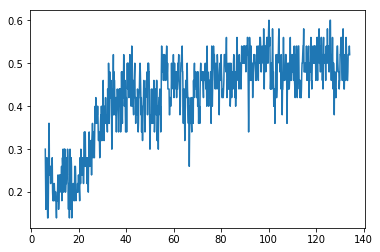

In [99]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject5 and test subject5

In [87]:
A05T = h5py.File('A05T_slice.mat', 'r')
X = np.copy(A05T['image'])
y = np.copy(A05T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 


In [88]:
from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 5s 22ms/step - loss: 1.8679 - acc: 0.2521 - val_loss: 1.8606 - val_acc: 0.2600
Epoch 2/1000
238/238 [==============================] - 0s 517us/step - loss: 1.8641 - acc: 0.2941 - val_loss: 1.8542 - val_acc: 0.2800
Epoch 3/1000
238/238 [==============================] - 0s 526us/step - loss: 1.8673 - acc: 0.2353 - val_loss: 1.8477 - val_acc: 0.3000
Epoch 4/1000
238/238 [==============================] - 0s 549us/step - loss: 1.8452 - acc: 0.2353 - val_loss: 1.8412 - val_acc: 0.2800
Epoch 5/1000
238/238 [==============================] - 0s 542us/step - loss: 1.8426 - acc: 0.2521 - val_loss: 1.8330 - val_acc: 0.3000
Epoch 6/1000
238/238 [==============================] - 0s 523us/step - loss: 1.8325 - acc: 0.2605 - val_loss: 1.8240 - val_acc: 0.2800
Epoch 7/1000
238/238 [==============================] - 0s 559us/step - loss: 1.8253 - acc: 0.2395 - val_loss: 1.8126 - val_acc: 0.3200
Epoc

238/238 [==============================] - 0s 548us/step - loss: 1.5017 - acc: 0.3655 - val_loss: 1.5100 - val_acc: 0.4400
Epoch 61/1000
238/238 [==============================] - 0s 532us/step - loss: 1.5098 - acc: 0.3487 - val_loss: 1.5043 - val_acc: 0.4800
Epoch 62/1000
238/238 [==============================] - 0s 509us/step - loss: 1.4700 - acc: 0.4538 - val_loss: 1.4992 - val_acc: 0.4600
Epoch 63/1000
238/238 [==============================] - 0s 504us/step - loss: 1.4880 - acc: 0.4244 - val_loss: 1.4971 - val_acc: 0.4400
Epoch 64/1000
238/238 [==============================] - 0s 527us/step - loss: 1.4768 - acc: 0.3824 - val_loss: 1.4944 - val_acc: 0.4400
Epoch 65/1000
238/238 [==============================] - 0s 505us/step - loss: 1.4765 - acc: 0.4034 - val_loss: 1.4920 - val_acc: 0.4200
Epoch 66/1000
238/238 [==============================] - 0s 509us/step - loss: 1.4540 - acc: 0.4496 - val_loss: 1.4901 - val_acc: 0.4000
Epoch 67/1000
238/238 [==============================] 

Epoch 120/1000
238/238 [==============================] - 0s 522us/step - loss: 1.1368 - acc: 0.6218 - val_loss: 1.4338 - val_acc: 0.3800
Epoch 121/1000
238/238 [==============================] - 0s 515us/step - loss: 1.1131 - acc: 0.5882 - val_loss: 1.4013 - val_acc: 0.4400
Epoch 122/1000
238/238 [==============================] - 0s 530us/step - loss: 1.1368 - acc: 0.6134 - val_loss: 1.3894 - val_acc: 0.5200
Epoch 123/1000
238/238 [==============================] - 0s 568us/step - loss: 1.1009 - acc: 0.6134 - val_loss: 1.3919 - val_acc: 0.4400
Epoch 124/1000
238/238 [==============================] - 0s 492us/step - loss: 1.0655 - acc: 0.6807 - val_loss: 1.4026 - val_acc: 0.4800
Epoch 125/1000
238/238 [==============================] - 0s 532us/step - loss: 1.1294 - acc: 0.6050 - val_loss: 1.4842 - val_acc: 0.4000
Epoch 126/1000
238/238 [==============================] - 0s 501us/step - loss: 1.1628 - acc: 0.5798 - val_loss: 1.4370 - val_acc: 0.4200
Epoch 127/1000
238/238 [==========

238/238 [==============================] - 0s 555us/step - loss: 1.0452 - acc: 0.6555 - val_loss: 1.7072 - val_acc: 0.3400
Epoch 180/1000
238/238 [==============================] - 0s 491us/step - loss: 1.0330 - acc: 0.6345 - val_loss: 1.6387 - val_acc: 0.3800
Epoch 181/1000
238/238 [==============================] - 0s 571us/step - loss: 0.9690 - acc: 0.7101 - val_loss: 1.5952 - val_acc: 0.3800
Epoch 182/1000
238/238 [==============================] - 0s 530us/step - loss: 1.0083 - acc: 0.6975 - val_loss: 1.5824 - val_acc: 0.3800
Epoch 183/1000
238/238 [==============================] - 0s 505us/step - loss: 1.0588 - acc: 0.6261 - val_loss: 1.5501 - val_acc: 0.4200
Epoch 184/1000
238/238 [==============================] - 0s 542us/step - loss: 1.0243 - acc: 0.6891 - val_loss: 1.7199 - val_acc: 0.4200
Epoch 185/1000
238/238 [==============================] - 0s 514us/step - loss: 0.9489 - acc: 0.6933 - val_loss: 1.6364 - val_acc: 0.4000
Epoch 186/1000
238/238 [=========================

238/238 [==============================] - 0s 568us/step - loss: 0.8954 - acc: 0.7731 - val_loss: 1.5755 - val_acc: 0.5000
Epoch 239/1000
238/238 [==============================] - 0s 563us/step - loss: 0.9375 - acc: 0.7311 - val_loss: 1.6349 - val_acc: 0.4400
Epoch 240/1000
238/238 [==============================] - 0s 524us/step - loss: 0.9212 - acc: 0.7563 - val_loss: 1.6943 - val_acc: 0.4600
Epoch 241/1000
238/238 [==============================] - 0s 536us/step - loss: 0.9531 - acc: 0.7269 - val_loss: 1.7227 - val_acc: 0.4600
Epoch 242/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8792 - acc: 0.7941 - val_loss: 1.8068 - val_acc: 0.4400
Epoch 243/1000
238/238 [==============================] - 0s 512us/step - loss: 0.9465 - acc: 0.7353 - val_loss: 1.6505 - val_acc: 0.4800
Epoch 244/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8918 - acc: 0.8109 - val_loss: 1.6760 - val_acc: 0.4600
Epoch 245/1000
238/238 [=========================

238/238 [==============================] - 0s 505us/step - loss: 0.8247 - acc: 0.8445 - val_loss: 1.8212 - val_acc: 0.4400
Epoch 298/1000
238/238 [==============================] - 0s 566us/step - loss: 0.7370 - acc: 0.8655 - val_loss: 1.7891 - val_acc: 0.4400
Epoch 299/1000
238/238 [==============================] - 0s 507us/step - loss: 0.8426 - acc: 0.8067 - val_loss: 1.7883 - val_acc: 0.3800
Epoch 300/1000
238/238 [==============================] - 0s 531us/step - loss: 0.8009 - acc: 0.8361 - val_loss: 1.7943 - val_acc: 0.4400
Epoch 301/1000
238/238 [==============================] - 0s 506us/step - loss: 0.8610 - acc: 0.7773 - val_loss: 1.9613 - val_acc: 0.3200
Epoch 302/1000
238/238 [==============================] - 0s 498us/step - loss: 0.8665 - acc: 0.7983 - val_loss: 1.9032 - val_acc: 0.4000
Epoch 303/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8453 - acc: 0.8067 - val_loss: 1.8276 - val_acc: 0.4200
Epoch 304/1000
238/238 [=========================

238/238 [==============================] - 0s 557us/step - loss: 0.7629 - acc: 0.8319 - val_loss: 1.7371 - val_acc: 0.4600
Epoch 357/1000
238/238 [==============================] - 0s 555us/step - loss: 0.7865 - acc: 0.8445 - val_loss: 1.8133 - val_acc: 0.4200
Epoch 358/1000
238/238 [==============================] - 0s 487us/step - loss: 0.7633 - acc: 0.8403 - val_loss: 1.6823 - val_acc: 0.4800
Epoch 359/1000
238/238 [==============================] - 0s 522us/step - loss: 0.8056 - acc: 0.8361 - val_loss: 1.7126 - val_acc: 0.4800
Epoch 360/1000
238/238 [==============================] - 0s 511us/step - loss: 0.8657 - acc: 0.7773 - val_loss: 1.7904 - val_acc: 0.4000
Epoch 361/1000
238/238 [==============================] - 0s 546us/step - loss: 0.8378 - acc: 0.8277 - val_loss: 1.8934 - val_acc: 0.4200
Epoch 362/1000
238/238 [==============================] - 0s 506us/step - loss: 0.9132 - acc: 0.7689 - val_loss: 1.8041 - val_acc: 0.4400
Epoch 363/1000
238/238 [=========================

238/238 [==============================] - 0s 522us/step - loss: 0.7338 - acc: 0.8613 - val_loss: 1.8899 - val_acc: 0.4000
Epoch 416/1000
238/238 [==============================] - 0s 555us/step - loss: 0.7098 - acc: 0.8782 - val_loss: 1.9368 - val_acc: 0.4600
Epoch 417/1000
238/238 [==============================] - 0s 511us/step - loss: 0.6960 - acc: 0.8697 - val_loss: 1.8871 - val_acc: 0.4600
Epoch 418/1000
238/238 [==============================] - 0s 519us/step - loss: 0.8142 - acc: 0.7983 - val_loss: 1.8557 - val_acc: 0.4400
Epoch 419/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7020 - acc: 0.8782 - val_loss: 1.8609 - val_acc: 0.4200
Epoch 420/1000
238/238 [==============================] - 0s 513us/step - loss: 0.8057 - acc: 0.8571 - val_loss: 1.7964 - val_acc: 0.4200
Epoch 421/1000
238/238 [==============================] - 0s 510us/step - loss: 0.7407 - acc: 0.8782 - val_loss: 1.7723 - val_acc: 0.4400
Epoch 422/1000
238/238 [=========================

238/238 [==============================] - 0s 507us/step - loss: 0.7817 - acc: 0.8487 - val_loss: 1.7012 - val_acc: 0.5200
Epoch 475/1000
238/238 [==============================] - 0s 536us/step - loss: 0.7555 - acc: 0.8529 - val_loss: 1.8869 - val_acc: 0.4600
Epoch 476/1000
238/238 [==============================] - 0s 511us/step - loss: 0.7585 - acc: 0.8571 - val_loss: 2.0048 - val_acc: 0.4600
Epoch 477/1000
238/238 [==============================] - 0s 516us/step - loss: 0.8136 - acc: 0.8235 - val_loss: 1.9334 - val_acc: 0.4600
Epoch 478/1000
238/238 [==============================] - 0s 498us/step - loss: 0.8236 - acc: 0.8319 - val_loss: 1.7575 - val_acc: 0.4400
Epoch 479/1000
238/238 [==============================] - 0s 511us/step - loss: 0.8013 - acc: 0.8487 - val_loss: 1.6819 - val_acc: 0.5000
Epoch 480/1000
238/238 [==============================] - 0s 533us/step - loss: 0.7465 - acc: 0.8445 - val_loss: 1.7525 - val_acc: 0.3800
Epoch 481/1000
238/238 [=========================

238/238 [==============================] - 0s 549us/step - loss: 0.7638 - acc: 0.8613 - val_loss: 1.8260 - val_acc: 0.4400
Epoch 534/1000
238/238 [==============================] - 0s 509us/step - loss: 0.7481 - acc: 0.8613 - val_loss: 2.1341 - val_acc: 0.3600
Epoch 535/1000
238/238 [==============================] - 0s 545us/step - loss: 0.8922 - acc: 0.7983 - val_loss: 1.9522 - val_acc: 0.4000
Epoch 536/1000
238/238 [==============================] - 0s 516us/step - loss: 0.7920 - acc: 0.8403 - val_loss: 1.8847 - val_acc: 0.4400
Epoch 537/1000
238/238 [==============================] - 0s 507us/step - loss: 0.7832 - acc: 0.8403 - val_loss: 1.8888 - val_acc: 0.4200
Epoch 538/1000
238/238 [==============================] - 0s 511us/step - loss: 0.7148 - acc: 0.8613 - val_loss: 1.8616 - val_acc: 0.4800
Epoch 539/1000
238/238 [==============================] - 0s 545us/step - loss: 0.6989 - acc: 0.8950 - val_loss: 1.9925 - val_acc: 0.4800
Epoch 540/1000
238/238 [=========================

238/238 [==============================] - 0s 524us/step - loss: 0.7590 - acc: 0.8655 - val_loss: 1.8577 - val_acc: 0.5200
Epoch 593/1000
238/238 [==============================] - 0s 564us/step - loss: 0.6933 - acc: 0.8782 - val_loss: 1.8615 - val_acc: 0.4800
Epoch 594/1000
238/238 [==============================] - 0s 558us/step - loss: 0.6658 - acc: 0.8866 - val_loss: 1.9310 - val_acc: 0.4400
Epoch 595/1000
238/238 [==============================] - 0s 535us/step - loss: 0.6630 - acc: 0.8782 - val_loss: 2.0172 - val_acc: 0.5200
Epoch 596/1000
238/238 [==============================] - 0s 572us/step - loss: 0.6461 - acc: 0.8950 - val_loss: 2.0023 - val_acc: 0.5000
Epoch 597/1000
238/238 [==============================] - 0s 556us/step - loss: 0.7063 - acc: 0.8782 - val_loss: 1.9617 - val_acc: 0.5000
Epoch 598/1000
238/238 [==============================] - 0s 579us/step - loss: 0.6551 - acc: 0.8571 - val_loss: 1.8995 - val_acc: 0.5800
Epoch 599/1000
238/238 [=========================

238/238 [==============================] - 0s 475us/step - loss: 0.6119 - acc: 0.9118 - val_loss: 1.7308 - val_acc: 0.6000
Epoch 652/1000
238/238 [==============================] - 0s 501us/step - loss: 0.6509 - acc: 0.8908 - val_loss: 1.7723 - val_acc: 0.6000
Epoch 653/1000
238/238 [==============================] - 0s 519us/step - loss: 0.7130 - acc: 0.8571 - val_loss: 1.6920 - val_acc: 0.6200
Epoch 654/1000
238/238 [==============================] - 0s 472us/step - loss: 0.6955 - acc: 0.8571 - val_loss: 1.6482 - val_acc: 0.5200
Epoch 655/1000
238/238 [==============================] - 0s 491us/step - loss: 0.6239 - acc: 0.8992 - val_loss: 1.6800 - val_acc: 0.5400
Epoch 656/1000
238/238 [==============================] - 0s 488us/step - loss: 0.6056 - acc: 0.9118 - val_loss: 1.6908 - val_acc: 0.5200
Epoch 657/1000
238/238 [==============================] - 0s 475us/step - loss: 0.6143 - acc: 0.8992 - val_loss: 1.8228 - val_acc: 0.5200
Epoch 658/1000
238/238 [=========================

238/238 [==============================] - 0s 465us/step - loss: 0.5836 - acc: 0.9034 - val_loss: 1.7002 - val_acc: 0.5000
Epoch 711/1000
238/238 [==============================] - 0s 463us/step - loss: 0.6458 - acc: 0.8950 - val_loss: 1.8079 - val_acc: 0.5400
Epoch 712/1000
238/238 [==============================] - 0s 478us/step - loss: 0.5692 - acc: 0.9202 - val_loss: 1.8451 - val_acc: 0.5400
Epoch 713/1000
238/238 [==============================] - 0s 481us/step - loss: 0.6271 - acc: 0.9034 - val_loss: 1.7753 - val_acc: 0.5200
Epoch 714/1000
238/238 [==============================] - 0s 484us/step - loss: 0.5915 - acc: 0.8992 - val_loss: 1.6992 - val_acc: 0.5600
Epoch 715/1000
238/238 [==============================] - 0s 481us/step - loss: 0.7037 - acc: 0.8824 - val_loss: 1.6446 - val_acc: 0.5800
Epoch 716/1000
238/238 [==============================] - 0s 495us/step - loss: 0.5683 - acc: 0.9160 - val_loss: 1.6185 - val_acc: 0.5600
Epoch 717/1000
238/238 [=========================

238/238 [==============================] - 0s 473us/step - loss: 0.5891 - acc: 0.9118 - val_loss: 1.6724 - val_acc: 0.4800
Epoch 770/1000
238/238 [==============================] - 0s 473us/step - loss: 0.5242 - acc: 0.9202 - val_loss: 1.7012 - val_acc: 0.5400
Epoch 771/1000
238/238 [==============================] - 0s 462us/step - loss: 0.6022 - acc: 0.8908 - val_loss: 1.6650 - val_acc: 0.6000
Epoch 772/1000
238/238 [==============================] - 0s 515us/step - loss: 0.5688 - acc: 0.9118 - val_loss: 1.7591 - val_acc: 0.5600
Epoch 773/1000
238/238 [==============================] - 0s 459us/step - loss: 0.5384 - acc: 0.9370 - val_loss: 1.9363 - val_acc: 0.4800
Epoch 774/1000
238/238 [==============================] - 0s 475us/step - loss: 0.6230 - acc: 0.8992 - val_loss: 2.0297 - val_acc: 0.4600
Epoch 775/1000
238/238 [==============================] - 0s 466us/step - loss: 0.6977 - acc: 0.8782 - val_loss: 1.8316 - val_acc: 0.4600
Epoch 776/1000
238/238 [=========================

238/238 [==============================] - 0s 459us/step - loss: 0.6210 - acc: 0.8571 - val_loss: 1.7511 - val_acc: 0.4600
Epoch 829/1000
238/238 [==============================] - 0s 470us/step - loss: 0.5423 - acc: 0.9244 - val_loss: 1.7863 - val_acc: 0.4600
Epoch 830/1000
238/238 [==============================] - 0s 464us/step - loss: 0.6168 - acc: 0.8782 - val_loss: 1.8358 - val_acc: 0.4600
Epoch 831/1000
238/238 [==============================] - 0s 454us/step - loss: 0.6524 - acc: 0.8824 - val_loss: 1.7483 - val_acc: 0.5000
Epoch 832/1000
238/238 [==============================] - 0s 460us/step - loss: 0.6655 - acc: 0.8571 - val_loss: 1.7330 - val_acc: 0.4400
Epoch 833/1000
238/238 [==============================] - 0s 468us/step - loss: 0.6541 - acc: 0.8697 - val_loss: 1.7586 - val_acc: 0.4600
Epoch 834/1000
238/238 [==============================] - 0s 473us/step - loss: 0.6259 - acc: 0.8908 - val_loss: 1.8119 - val_acc: 0.4600
Epoch 835/1000
238/238 [=========================

238/238 [==============================] - 0s 493us/step - loss: 0.6219 - acc: 0.8908 - val_loss: 2.0846 - val_acc: 0.4800
Epoch 888/1000
238/238 [==============================] - 0s 483us/step - loss: 0.5601 - acc: 0.9034 - val_loss: 1.9235 - val_acc: 0.4800
Epoch 889/1000
238/238 [==============================] - 0s 463us/step - loss: 0.5108 - acc: 0.9328 - val_loss: 1.7894 - val_acc: 0.5200
Epoch 890/1000
238/238 [==============================] - 0s 473us/step - loss: 0.6099 - acc: 0.8950 - val_loss: 1.8443 - val_acc: 0.4800
Epoch 891/1000
238/238 [==============================] - 0s 468us/step - loss: 0.5077 - acc: 0.9244 - val_loss: 1.8617 - val_acc: 0.4600
Epoch 892/1000
238/238 [==============================] - 0s 469us/step - loss: 0.5375 - acc: 0.9244 - val_loss: 1.8337 - val_acc: 0.5000
Epoch 893/1000
238/238 [==============================] - 0s 460us/step - loss: 0.5812 - acc: 0.8950 - val_loss: 1.9203 - val_acc: 0.5000
Epoch 894/1000
238/238 [=========================

238/238 [==============================] - 0s 595us/step - loss: 0.6035 - acc: 0.8866 - val_loss: 1.9363 - val_acc: 0.4800
Epoch 947/1000
238/238 [==============================] - 0s 621us/step - loss: 0.5371 - acc: 0.9202 - val_loss: 1.8887 - val_acc: 0.4200
Epoch 948/1000
238/238 [==============================] - 0s 610us/step - loss: 0.4825 - acc: 0.9328 - val_loss: 1.8162 - val_acc: 0.4400
Epoch 949/1000
238/238 [==============================] - 0s 665us/step - loss: 0.6128 - acc: 0.8866 - val_loss: 1.8815 - val_acc: 0.4400
Epoch 950/1000
238/238 [==============================] - 0s 662us/step - loss: 0.5825 - acc: 0.8950 - val_loss: 1.9196 - val_acc: 0.4600
Epoch 951/1000
238/238 [==============================] - 0s 605us/step - loss: 0.5177 - acc: 0.9202 - val_loss: 1.8599 - val_acc: 0.4600
Epoch 952/1000
238/238 [==============================] - 0s 586us/step - loss: 0.5137 - acc: 0.9160 - val_loss: 1.8858 - val_acc: 0.4800
Epoch 953/1000
238/238 [=========================

0.6399999856948853


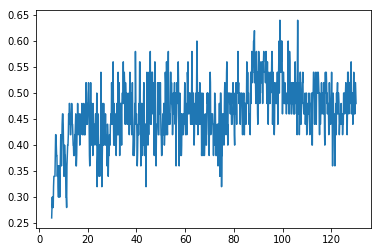

In [89]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject6 and test subject6

In [100]:
A06T = h5py.File('A06T_slice.mat', 'r')
X = np.copy(A06T['image'])
y = np.copy(A06T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 
Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 6s 25ms/step - loss: 1.9032 - acc: 0.2353 - val_loss: 1.8932 - val_acc: 0.2400
Epoch 2/1000
238/238 [==============================] - 0s 508us/step - loss: 1.8942 - acc: 0.2521 - val_loss: 1.8863 - val_acc: 0.2000
Epoch 3/1000
238/238 [==============================] - 0s 551us/step - loss: 1.8935 - acc: 0.2185 - val_loss: 1.8782 - val_acc: 0.2000
Epoch 4/1000
238/238 [==============================] - 0s 551us/step - loss: 1.8763 - acc: 0.2563 - val_loss: 1.8694 - val_acc: 0.2000
Epoch 5/1000
238/238 [==============================] - 0s 533us/step - loss: 1.8809 - acc: 0.2185 - val_loss: 1.8622 - val_acc: 0.2000
Epoch 6/1000
238/238 [==============================] - 0s 550us/step - loss: 1.8627 - acc: 0.2563 - val_loss: 1.8548 - val_ac

238/238 [==============================] - 0s 555us/step - loss: 1.5490 - acc: 0.3319 - val_loss: 1.5465 - val_acc: 0.3000
Epoch 60/1000
238/238 [==============================] - 0s 534us/step - loss: 1.5444 - acc: 0.3109 - val_loss: 1.5437 - val_acc: 0.2600
Epoch 61/1000
238/238 [==============================] - 0s 533us/step - loss: 1.5411 - acc: 0.3445 - val_loss: 1.5414 - val_acc: 0.2800
Epoch 62/1000
238/238 [==============================] - 0s 533us/step - loss: 1.5335 - acc: 0.3403 - val_loss: 1.5375 - val_acc: 0.2400
Epoch 63/1000
238/238 [==============================] - 0s 608us/step - loss: 1.5434 - acc: 0.3571 - val_loss: 1.5348 - val_acc: 0.2400
Epoch 64/1000
238/238 [==============================] - 0s 613us/step - loss: 1.5328 - acc: 0.3319 - val_loss: 1.5322 - val_acc: 0.2600
Epoch 65/1000
238/238 [==============================] - 0s 537us/step - loss: 1.5257 - acc: 0.3193 - val_loss: 1.5282 - val_acc: 0.2400
Epoch 66/1000
238/238 [==============================] 

Epoch 119/1000
238/238 [==============================] - 0s 530us/step - loss: 1.2788 - acc: 0.5000 - val_loss: 1.4714 - val_acc: 0.2400
Epoch 120/1000
238/238 [==============================] - 0s 498us/step - loss: 1.2819 - acc: 0.5126 - val_loss: 1.4760 - val_acc: 0.3400
Epoch 121/1000
238/238 [==============================] - 0s 508us/step - loss: 1.2699 - acc: 0.4916 - val_loss: 1.4806 - val_acc: 0.2800
Epoch 122/1000
238/238 [==============================] - 0s 502us/step - loss: 1.2712 - acc: 0.5000 - val_loss: 1.4862 - val_acc: 0.2600
Epoch 123/1000
238/238 [==============================] - 0s 501us/step - loss: 1.2440 - acc: 0.5630 - val_loss: 1.4969 - val_acc: 0.3000
Epoch 124/1000
238/238 [==============================] - 0s 501us/step - loss: 1.2811 - acc: 0.5084 - val_loss: 1.4818 - val_acc: 0.3600
Epoch 125/1000
238/238 [==============================] - 0s 499us/step - loss: 1.2028 - acc: 0.5588 - val_loss: 1.4809 - val_acc: 0.3400
Epoch 126/1000
238/238 [==========

238/238 [==============================] - 0s 507us/step - loss: 1.0304 - acc: 0.6681 - val_loss: 1.6740 - val_acc: 0.2800
Epoch 179/1000
238/238 [==============================] - 0s 522us/step - loss: 1.0361 - acc: 0.6849 - val_loss: 1.6676 - val_acc: 0.2800
Epoch 180/1000
238/238 [==============================] - 0s 559us/step - loss: 1.0724 - acc: 0.6387 - val_loss: 1.6657 - val_acc: 0.2800
Epoch 181/1000
238/238 [==============================] - 0s 502us/step - loss: 1.1243 - acc: 0.6387 - val_loss: 1.6514 - val_acc: 0.2800
Epoch 182/1000
238/238 [==============================] - 0s 524us/step - loss: 1.0060 - acc: 0.6681 - val_loss: 1.6612 - val_acc: 0.3800
Epoch 183/1000
238/238 [==============================] - 0s 522us/step - loss: 1.0326 - acc: 0.6555 - val_loss: 1.6823 - val_acc: 0.3400
Epoch 184/1000
238/238 [==============================] - 0s 505us/step - loss: 1.0612 - acc: 0.6218 - val_loss: 1.6674 - val_acc: 0.3000
Epoch 185/1000
238/238 [=========================

238/238 [==============================] - 0s 521us/step - loss: 1.0476 - acc: 0.7059 - val_loss: 1.8276 - val_acc: 0.2800
Epoch 238/1000
238/238 [==============================] - 0s 522us/step - loss: 1.0777 - acc: 0.6891 - val_loss: 1.9050 - val_acc: 0.3200
Epoch 239/1000
238/238 [==============================] - 0s 512us/step - loss: 0.9702 - acc: 0.7395 - val_loss: 1.9482 - val_acc: 0.3000
Epoch 240/1000
238/238 [==============================] - 0s 506us/step - loss: 1.0132 - acc: 0.7017 - val_loss: 2.0078 - val_acc: 0.2600
Epoch 241/1000
238/238 [==============================] - 0s 530us/step - loss: 0.9932 - acc: 0.7143 - val_loss: 2.0052 - val_acc: 0.2200
Epoch 242/1000
238/238 [==============================] - 0s 557us/step - loss: 1.0661 - acc: 0.6933 - val_loss: 1.9976 - val_acc: 0.2200
Epoch 243/1000
238/238 [==============================] - 0s 502us/step - loss: 0.9949 - acc: 0.7311 - val_loss: 1.9641 - val_acc: 0.2600
Epoch 244/1000
238/238 [=========================

238/238 [==============================] - 0s 532us/step - loss: 1.0127 - acc: 0.7185 - val_loss: 2.0881 - val_acc: 0.3000
Epoch 297/1000
238/238 [==============================] - 0s 499us/step - loss: 0.9832 - acc: 0.7353 - val_loss: 2.0834 - val_acc: 0.3200
Epoch 298/1000
238/238 [==============================] - 0s 494us/step - loss: 0.8720 - acc: 0.8109 - val_loss: 1.9983 - val_acc: 0.3600
Epoch 299/1000
238/238 [==============================] - 0s 510us/step - loss: 0.9687 - acc: 0.7353 - val_loss: 1.9790 - val_acc: 0.3200
Epoch 300/1000
238/238 [==============================] - 0s 523us/step - loss: 0.9240 - acc: 0.7731 - val_loss: 1.9880 - val_acc: 0.3200
Epoch 301/1000
238/238 [==============================] - 0s 554us/step - loss: 0.9106 - acc: 0.7647 - val_loss: 2.0688 - val_acc: 0.3200
Epoch 302/1000
238/238 [==============================] - 0s 527us/step - loss: 0.9262 - acc: 0.7773 - val_loss: 2.1556 - val_acc: 0.3800
Epoch 303/1000
238/238 [=========================

238/238 [==============================] - 0s 521us/step - loss: 0.9623 - acc: 0.7689 - val_loss: 2.0116 - val_acc: 0.3600
Epoch 356/1000
238/238 [==============================] - 0s 542us/step - loss: 0.9628 - acc: 0.7563 - val_loss: 2.0947 - val_acc: 0.3200
Epoch 357/1000
238/238 [==============================] - 0s 555us/step - loss: 0.9064 - acc: 0.8235 - val_loss: 2.1600 - val_acc: 0.3600
Epoch 358/1000
238/238 [==============================] - 0s 506us/step - loss: 0.9351 - acc: 0.7731 - val_loss: 2.1406 - val_acc: 0.3000
Epoch 359/1000
238/238 [==============================] - 0s 557us/step - loss: 0.9210 - acc: 0.7983 - val_loss: 2.1389 - val_acc: 0.2400
Epoch 360/1000
238/238 [==============================] - 0s 533us/step - loss: 0.9761 - acc: 0.7899 - val_loss: 2.0079 - val_acc: 0.3000
Epoch 361/1000
238/238 [==============================] - 0s 531us/step - loss: 1.0052 - acc: 0.7605 - val_loss: 1.9141 - val_acc: 0.3600
Epoch 362/1000
238/238 [=========================

238/238 [==============================] - 0s 537us/step - loss: 0.9648 - acc: 0.7899 - val_loss: 1.8829 - val_acc: 0.3600
Epoch 415/1000
238/238 [==============================] - 0s 533us/step - loss: 0.9451 - acc: 0.7941 - val_loss: 2.0381 - val_acc: 0.3200
Epoch 416/1000
238/238 [==============================] - 0s 519us/step - loss: 0.8315 - acc: 0.8319 - val_loss: 2.0762 - val_acc: 0.3000
Epoch 417/1000
238/238 [==============================] - 0s 514us/step - loss: 0.9075 - acc: 0.7983 - val_loss: 1.9852 - val_acc: 0.3000
Epoch 418/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8549 - acc: 0.8193 - val_loss: 2.0189 - val_acc: 0.3200
Epoch 419/1000
238/238 [==============================] - 0s 517us/step - loss: 0.9375 - acc: 0.7941 - val_loss: 2.0504 - val_acc: 0.3600
Epoch 420/1000
238/238 [==============================] - 0s 509us/step - loss: 0.8843 - acc: 0.8067 - val_loss: 2.0036 - val_acc: 0.3800
Epoch 421/1000
238/238 [=========================

238/238 [==============================] - 0s 584us/step - loss: 0.9163 - acc: 0.8193 - val_loss: 2.2349 - val_acc: 0.3200
Epoch 474/1000
238/238 [==============================] - 0s 590us/step - loss: 0.8650 - acc: 0.8151 - val_loss: 2.0532 - val_acc: 0.3600
Epoch 475/1000
238/238 [==============================] - 0s 566us/step - loss: 0.8051 - acc: 0.8655 - val_loss: 1.9206 - val_acc: 0.3600
Epoch 476/1000
238/238 [==============================] - 0s 568us/step - loss: 0.7476 - acc: 0.9034 - val_loss: 1.9174 - val_acc: 0.4000
Epoch 477/1000
238/238 [==============================] - 0s 602us/step - loss: 0.8715 - acc: 0.8529 - val_loss: 1.9070 - val_acc: 0.3200
Epoch 478/1000
238/238 [==============================] - 0s 564us/step - loss: 0.8567 - acc: 0.8067 - val_loss: 1.9232 - val_acc: 0.3000
Epoch 479/1000
238/238 [==============================] - 0s 619us/step - loss: 0.9838 - acc: 0.7941 - val_loss: 2.0174 - val_acc: 0.4000
Epoch 480/1000
238/238 [=========================

238/238 [==============================] - 0s 493us/step - loss: 0.7853 - acc: 0.8739 - val_loss: 2.1430 - val_acc: 0.3800
Epoch 533/1000
238/238 [==============================] - 0s 529us/step - loss: 0.7965 - acc: 0.8529 - val_loss: 2.2640 - val_acc: 0.3400
Epoch 534/1000
238/238 [==============================] - 0s 528us/step - loss: 0.7841 - acc: 0.8529 - val_loss: 2.2348 - val_acc: 0.3600
Epoch 535/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7950 - acc: 0.8487 - val_loss: 2.2054 - val_acc: 0.3200
Epoch 536/1000
238/238 [==============================] - 0s 516us/step - loss: 0.8208 - acc: 0.8571 - val_loss: 2.2865 - val_acc: 0.3600
Epoch 537/1000
238/238 [==============================] - 0s 536us/step - loss: 0.8848 - acc: 0.8109 - val_loss: 2.3692 - val_acc: 0.2800
Epoch 538/1000
238/238 [==============================] - 0s 493us/step - loss: 0.9968 - acc: 0.8025 - val_loss: 2.3837 - val_acc: 0.3000
Epoch 539/1000
238/238 [=========================

238/238 [==============================] - 0s 521us/step - loss: 0.7014 - acc: 0.8529 - val_loss: 2.4048 - val_acc: 0.3000
Epoch 592/1000
238/238 [==============================] - 0s 542us/step - loss: 0.7783 - acc: 0.8529 - val_loss: 2.3028 - val_acc: 0.3400
Epoch 593/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7904 - acc: 0.8739 - val_loss: 2.3298 - val_acc: 0.3800
Epoch 594/1000
238/238 [==============================] - 0s 501us/step - loss: 0.7512 - acc: 0.8403 - val_loss: 2.3183 - val_acc: 0.4000
Epoch 595/1000
238/238 [==============================] - 0s 503us/step - loss: 0.7568 - acc: 0.8571 - val_loss: 2.3671 - val_acc: 0.3400
Epoch 596/1000
238/238 [==============================] - 0s 698us/step - loss: 0.7339 - acc: 0.8782 - val_loss: 2.3791 - val_acc: 0.3000
Epoch 597/1000
238/238 [==============================] - 0s 589us/step - loss: 0.6373 - acc: 0.9286 - val_loss: 2.4784 - val_acc: 0.2800
Epoch 598/1000
238/238 [=========================

238/238 [==============================] - 0s 596us/step - loss: 0.7990 - acc: 0.8403 - val_loss: 2.3997 - val_acc: 0.3600
Epoch 651/1000
238/238 [==============================] - 0s 561us/step - loss: 0.8555 - acc: 0.8319 - val_loss: 2.3111 - val_acc: 0.3400
Epoch 652/1000
238/238 [==============================] - 0s 494us/step - loss: 0.7064 - acc: 0.8655 - val_loss: 2.2905 - val_acc: 0.4000
Epoch 653/1000
238/238 [==============================] - 0s 511us/step - loss: 0.7276 - acc: 0.8445 - val_loss: 2.2812 - val_acc: 0.3800
Epoch 654/1000
238/238 [==============================] - 0s 502us/step - loss: 0.7864 - acc: 0.8529 - val_loss: 2.3315 - val_acc: 0.3400
Epoch 655/1000
238/238 [==============================] - 0s 500us/step - loss: 0.8481 - acc: 0.8403 - val_loss: 2.1913 - val_acc: 0.4400
Epoch 656/1000
238/238 [==============================] - 0s 500us/step - loss: 0.8233 - acc: 0.8319 - val_loss: 2.1169 - val_acc: 0.4000
Epoch 657/1000
238/238 [=========================

238/238 [==============================] - 0s 504us/step - loss: 0.7428 - acc: 0.8613 - val_loss: 2.2677 - val_acc: 0.3800
Epoch 710/1000
238/238 [==============================] - 0s 569us/step - loss: 0.8037 - acc: 0.8445 - val_loss: 2.2538 - val_acc: 0.3000
Epoch 711/1000
238/238 [==============================] - 0s 489us/step - loss: 0.7772 - acc: 0.8655 - val_loss: 2.2883 - val_acc: 0.2800
Epoch 712/1000
238/238 [==============================] - 0s 510us/step - loss: 0.7380 - acc: 0.8655 - val_loss: 2.1831 - val_acc: 0.3200
Epoch 713/1000
238/238 [==============================] - 0s 509us/step - loss: 0.7164 - acc: 0.8613 - val_loss: 2.1144 - val_acc: 0.3600
Epoch 714/1000
238/238 [==============================] - 0s 515us/step - loss: 0.7709 - acc: 0.8655 - val_loss: 2.3392 - val_acc: 0.2600
Epoch 715/1000
238/238 [==============================] - 0s 535us/step - loss: 0.7757 - acc: 0.8445 - val_loss: 2.3749 - val_acc: 0.3000
Epoch 716/1000
238/238 [=========================

238/238 [==============================] - 0s 512us/step - loss: 0.7297 - acc: 0.8445 - val_loss: 2.3156 - val_acc: 0.3200
Epoch 769/1000
238/238 [==============================] - 0s 526us/step - loss: 0.6474 - acc: 0.8824 - val_loss: 2.2232 - val_acc: 0.3600
Epoch 770/1000
238/238 [==============================] - 0s 494us/step - loss: 0.7703 - acc: 0.8361 - val_loss: 2.2030 - val_acc: 0.3600
Epoch 771/1000
238/238 [==============================] - 0s 526us/step - loss: 0.6399 - acc: 0.8866 - val_loss: 2.2408 - val_acc: 0.3800
Epoch 772/1000
238/238 [==============================] - 0s 514us/step - loss: 0.7196 - acc: 0.8655 - val_loss: 2.2160 - val_acc: 0.4400
Epoch 773/1000
238/238 [==============================] - 0s 504us/step - loss: 0.7143 - acc: 0.8571 - val_loss: 2.0601 - val_acc: 0.3800
Epoch 774/1000
238/238 [==============================] - 0s 500us/step - loss: 0.6701 - acc: 0.8908 - val_loss: 1.9903 - val_acc: 0.4000
Epoch 775/1000
238/238 [=========================

238/238 [==============================] - 0s 547us/step - loss: 0.7041 - acc: 0.8655 - val_loss: 2.3267 - val_acc: 0.2800
Epoch 828/1000
238/238 [==============================] - 0s 524us/step - loss: 0.6504 - acc: 0.8613 - val_loss: 2.3281 - val_acc: 0.3400
Epoch 829/1000
238/238 [==============================] - 0s 554us/step - loss: 0.7250 - acc: 0.8571 - val_loss: 2.2764 - val_acc: 0.3200
Epoch 830/1000
238/238 [==============================] - 0s 522us/step - loss: 0.6410 - acc: 0.8908 - val_loss: 2.2504 - val_acc: 0.3400
Epoch 831/1000
238/238 [==============================] - 0s 521us/step - loss: 0.7155 - acc: 0.8824 - val_loss: 2.1617 - val_acc: 0.3800
Epoch 832/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7606 - acc: 0.8403 - val_loss: 2.1797 - val_acc: 0.3600
Epoch 833/1000
238/238 [==============================] - 0s 512us/step - loss: 0.6953 - acc: 0.8824 - val_loss: 2.2782 - val_acc: 0.3200
Epoch 834/1000
238/238 [=========================

238/238 [==============================] - 0s 553us/step - loss: 0.6495 - acc: 0.8824 - val_loss: 2.1239 - val_acc: 0.3800
Epoch 887/1000
238/238 [==============================] - 0s 530us/step - loss: 0.6914 - acc: 0.8529 - val_loss: 2.1788 - val_acc: 0.3800
Epoch 888/1000
238/238 [==============================] - 0s 555us/step - loss: 0.6818 - acc: 0.8866 - val_loss: 2.1710 - val_acc: 0.3800
Epoch 889/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7064 - acc: 0.8655 - val_loss: 2.1517 - val_acc: 0.3800
Epoch 890/1000
238/238 [==============================] - 0s 493us/step - loss: 0.7248 - acc: 0.8824 - val_loss: 2.0826 - val_acc: 0.3800
Epoch 891/1000
238/238 [==============================] - 0s 494us/step - loss: 0.6652 - acc: 0.8992 - val_loss: 2.0476 - val_acc: 0.4200
Epoch 892/1000
238/238 [==============================] - 0s 511us/step - loss: 0.6143 - acc: 0.9076 - val_loss: 1.9591 - val_acc: 0.4200
Epoch 893/1000
238/238 [=========================

238/238 [==============================] - 0s 588us/step - loss: 0.6320 - acc: 0.9076 - val_loss: 2.0694 - val_acc: 0.4000
Epoch 946/1000
238/238 [==============================] - 0s 543us/step - loss: 0.5935 - acc: 0.8992 - val_loss: 2.1669 - val_acc: 0.3200
Epoch 947/1000
238/238 [==============================] - 0s 543us/step - loss: 0.6201 - acc: 0.8992 - val_loss: 2.2905 - val_acc: 0.3200
Epoch 948/1000
238/238 [==============================] - 0s 557us/step - loss: 0.7224 - acc: 0.8487 - val_loss: 2.3132 - val_acc: 0.3000
Epoch 949/1000
238/238 [==============================] - 0s 556us/step - loss: 0.5972 - acc: 0.8866 - val_loss: 2.2835 - val_acc: 0.3000
Epoch 950/1000
238/238 [==============================] - 0s 641us/step - loss: 0.6931 - acc: 0.8697 - val_loss: 2.1828 - val_acc: 0.2800
Epoch 951/1000
238/238 [==============================] - 0s 674us/step - loss: 0.6657 - acc: 0.8908 - val_loss: 2.1830 - val_acc: 0.3200
Epoch 952/1000
238/238 [=========================

0.46000000834465027


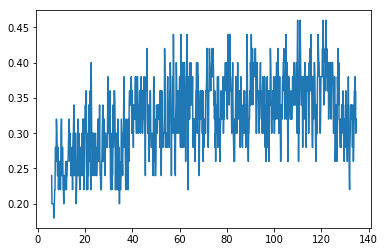

In [101]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject7 and test subject7

In [92]:
A07T = h5py.File('A07T_slice.mat', 'r')
X = np.copy(A07T['image'])
y = np.copy(A07T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 
Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 6s 23ms/step - loss: 1.8757 - acc: 0.2101 - val_loss: 1.8669 - val_acc: 0.2400
Epoch 2/1000
238/238 [==============================] - 0s 598us/step - loss: 1.8657 - acc: 0.2353 - val_loss: 1.8619 - val_acc: 0.2000
Epoch 3/1000
238/238 [==============================] - 0s 564us/step - loss: 1.8569 - acc: 0.2605 - val_loss: 1.8546 - val_acc: 0.2000
Epoch 4/1000
238/238 [==============================] - 0s 545us/step - loss: 1.8553 - acc: 0.2227 - val_loss: 1.8457 - val_acc: 0.2800
Epoch 5/1000
238/238 [==============================] - 0s 538us/step - loss: 1.8464 - acc: 0.2857 - val_loss: 1.8371 - val_acc: 0.3000
Epoch 6/1000
238/238 [==============================] - 0s 552us/step - loss: 1.8356 - acc: 0.2353 - val_loss: 1.8285 - val_ac

238/238 [==============================] - 0s 584us/step - loss: 1.4969 - acc: 0.3571 - val_loss: 1.5348 - val_acc: 0.2800
Epoch 60/1000
238/238 [==============================] - 0s 537us/step - loss: 1.4755 - acc: 0.4076 - val_loss: 1.5345 - val_acc: 0.2800
Epoch 61/1000
238/238 [==============================] - 0s 557us/step - loss: 1.4807 - acc: 0.3950 - val_loss: 1.5358 - val_acc: 0.3400
Epoch 62/1000
238/238 [==============================] - 0s 517us/step - loss: 1.4749 - acc: 0.3908 - val_loss: 1.5370 - val_acc: 0.2800
Epoch 63/1000
238/238 [==============================] - 0s 554us/step - loss: 1.4632 - acc: 0.4244 - val_loss: 1.5349 - val_acc: 0.3200
Epoch 64/1000
238/238 [==============================] - 0s 525us/step - loss: 1.4656 - acc: 0.4160 - val_loss: 1.5324 - val_acc: 0.3200
Epoch 65/1000
238/238 [==============================] - 0s 570us/step - loss: 1.4704 - acc: 0.4034 - val_loss: 1.5254 - val_acc: 0.2800
Epoch 66/1000
238/238 [==============================] 

Epoch 119/1000
238/238 [==============================] - 0s 572us/step - loss: 1.1954 - acc: 0.5714 - val_loss: 1.4383 - val_acc: 0.3600
Epoch 120/1000
238/238 [==============================] - 0s 507us/step - loss: 1.1729 - acc: 0.5000 - val_loss: 1.4294 - val_acc: 0.3600
Epoch 121/1000
238/238 [==============================] - 0s 553us/step - loss: 1.1756 - acc: 0.5294 - val_loss: 1.4317 - val_acc: 0.4000
Epoch 122/1000
238/238 [==============================] - 0s 526us/step - loss: 1.1689 - acc: 0.5630 - val_loss: 1.3996 - val_acc: 0.4800
Epoch 123/1000
238/238 [==============================] - 0s 582us/step - loss: 1.1831 - acc: 0.5504 - val_loss: 1.4429 - val_acc: 0.4000
Epoch 124/1000
238/238 [==============================] - 0s 528us/step - loss: 1.1363 - acc: 0.5714 - val_loss: 1.4377 - val_acc: 0.4200
Epoch 125/1000
238/238 [==============================] - 0s 594us/step - loss: 1.1713 - acc: 0.5462 - val_loss: 1.4164 - val_acc: 0.4400
Epoch 126/1000
238/238 [==========

238/238 [==============================] - 0s 525us/step - loss: 0.9716 - acc: 0.6849 - val_loss: 1.4157 - val_acc: 0.4400
Epoch 179/1000
238/238 [==============================] - 0s 536us/step - loss: 0.9968 - acc: 0.7185 - val_loss: 1.3871 - val_acc: 0.4400
Epoch 180/1000
238/238 [==============================] - 0s 507us/step - loss: 0.9805 - acc: 0.7059 - val_loss: 1.3731 - val_acc: 0.4200
Epoch 181/1000
238/238 [==============================] - 0s 515us/step - loss: 1.0190 - acc: 0.6429 - val_loss: 1.4214 - val_acc: 0.4200
Epoch 182/1000
238/238 [==============================] - 0s 521us/step - loss: 0.9645 - acc: 0.7017 - val_loss: 1.4329 - val_acc: 0.4400
Epoch 183/1000
238/238 [==============================] - 0s 527us/step - loss: 1.0340 - acc: 0.6597 - val_loss: 1.4003 - val_acc: 0.4200
Epoch 184/1000
238/238 [==============================] - 0s 552us/step - loss: 0.9399 - acc: 0.6765 - val_loss: 1.3628 - val_acc: 0.4800
Epoch 185/1000
238/238 [=========================

238/238 [==============================] - 0s 542us/step - loss: 0.9641 - acc: 0.7479 - val_loss: 1.6089 - val_acc: 0.3600
Epoch 238/1000
238/238 [==============================] - 0s 575us/step - loss: 0.9213 - acc: 0.7353 - val_loss: 1.5662 - val_acc: 0.3800
Epoch 239/1000
238/238 [==============================] - 0s 589us/step - loss: 0.8148 - acc: 0.7773 - val_loss: 1.5835 - val_acc: 0.4600
Epoch 240/1000
238/238 [==============================] - 0s 611us/step - loss: 0.9565 - acc: 0.7521 - val_loss: 1.7129 - val_acc: 0.3600
Epoch 241/1000
238/238 [==============================] - 0s 521us/step - loss: 0.8853 - acc: 0.7605 - val_loss: 1.7698 - val_acc: 0.3200
Epoch 242/1000
238/238 [==============================] - 0s 529us/step - loss: 0.8785 - acc: 0.7731 - val_loss: 1.6373 - val_acc: 0.4400
Epoch 243/1000
238/238 [==============================] - 0s 525us/step - loss: 0.8669 - acc: 0.7773 - val_loss: 1.6336 - val_acc: 0.3800
Epoch 244/1000
238/238 [=========================

238/238 [==============================] - 0s 533us/step - loss: 0.8505 - acc: 0.7983 - val_loss: 1.7898 - val_acc: 0.3600
Epoch 297/1000
238/238 [==============================] - 0s 543us/step - loss: 0.8912 - acc: 0.7941 - val_loss: 1.7605 - val_acc: 0.3800
Epoch 298/1000
238/238 [==============================] - 0s 529us/step - loss: 0.7278 - acc: 0.8571 - val_loss: 1.7486 - val_acc: 0.4000
Epoch 299/1000
238/238 [==============================] - 0s 569us/step - loss: 0.7835 - acc: 0.8067 - val_loss: 1.8050 - val_acc: 0.4000
Epoch 300/1000
238/238 [==============================] - 0s 518us/step - loss: 0.8705 - acc: 0.7857 - val_loss: 1.8293 - val_acc: 0.4000
Epoch 301/1000
238/238 [==============================] - 0s 606us/step - loss: 0.9104 - acc: 0.7563 - val_loss: 1.7864 - val_acc: 0.4600
Epoch 302/1000
238/238 [==============================] - 0s 540us/step - loss: 0.8116 - acc: 0.8067 - val_loss: 1.6143 - val_acc: 0.4400
Epoch 303/1000
238/238 [=========================

238/238 [==============================] - 0s 547us/step - loss: 0.7384 - acc: 0.8361 - val_loss: 1.8950 - val_acc: 0.4000
Epoch 356/1000
238/238 [==============================] - 0s 552us/step - loss: 0.7915 - acc: 0.8361 - val_loss: 1.7710 - val_acc: 0.4200
Epoch 357/1000
238/238 [==============================] - 0s 551us/step - loss: 0.9446 - acc: 0.7857 - val_loss: 1.8020 - val_acc: 0.4200
Epoch 358/1000
238/238 [==============================] - 0s 581us/step - loss: 0.8012 - acc: 0.8319 - val_loss: 1.8261 - val_acc: 0.4000
Epoch 359/1000
238/238 [==============================] - 0s 515us/step - loss: 0.8237 - acc: 0.8193 - val_loss: 1.8727 - val_acc: 0.3600
Epoch 360/1000
238/238 [==============================] - 0s 567us/step - loss: 0.8707 - acc: 0.7941 - val_loss: 1.9304 - val_acc: 0.4200
Epoch 361/1000
238/238 [==============================] - 0s 546us/step - loss: 0.8113 - acc: 0.8067 - val_loss: 1.9188 - val_acc: 0.4200
Epoch 362/1000
238/238 [=========================

238/238 [==============================] - 0s 527us/step - loss: 0.7507 - acc: 0.8571 - val_loss: 1.6692 - val_acc: 0.4400
Epoch 415/1000
238/238 [==============================] - 0s 529us/step - loss: 0.6578 - acc: 0.8824 - val_loss: 1.6971 - val_acc: 0.4600
Epoch 416/1000
238/238 [==============================] - 0s 523us/step - loss: 0.8207 - acc: 0.8235 - val_loss: 1.6301 - val_acc: 0.5400
Epoch 417/1000
238/238 [==============================] - 0s 531us/step - loss: 0.8142 - acc: 0.8319 - val_loss: 1.5661 - val_acc: 0.5600
Epoch 418/1000
238/238 [==============================] - 0s 520us/step - loss: 0.8235 - acc: 0.8361 - val_loss: 1.4966 - val_acc: 0.6000
Epoch 419/1000
238/238 [==============================] - 0s 517us/step - loss: 0.7863 - acc: 0.8109 - val_loss: 1.5538 - val_acc: 0.5600
Epoch 420/1000
238/238 [==============================] - 0s 526us/step - loss: 0.8810 - acc: 0.8151 - val_loss: 1.6676 - val_acc: 0.4600
Epoch 421/1000
238/238 [=========================

238/238 [==============================] - 0s 545us/step - loss: 0.8091 - acc: 0.8319 - val_loss: 1.8503 - val_acc: 0.4400
Epoch 474/1000
238/238 [==============================] - 0s 537us/step - loss: 0.7769 - acc: 0.8487 - val_loss: 1.5805 - val_acc: 0.5400
Epoch 475/1000
238/238 [==============================] - 0s 546us/step - loss: 0.7861 - acc: 0.8277 - val_loss: 1.6049 - val_acc: 0.5000
Epoch 476/1000
238/238 [==============================] - 0s 561us/step - loss: 0.7068 - acc: 0.8824 - val_loss: 1.5854 - val_acc: 0.4800
Epoch 477/1000
238/238 [==============================] - 0s 532us/step - loss: 0.7824 - acc: 0.8403 - val_loss: 1.5709 - val_acc: 0.4800
Epoch 478/1000
238/238 [==============================] - 0s 559us/step - loss: 0.6682 - acc: 0.8824 - val_loss: 1.5357 - val_acc: 0.5600
Epoch 479/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7089 - acc: 0.8824 - val_loss: 1.6366 - val_acc: 0.5400
Epoch 480/1000
238/238 [=========================

238/238 [==============================] - 0s 562us/step - loss: 0.6006 - acc: 0.9202 - val_loss: 1.6458 - val_acc: 0.5400
Epoch 533/1000
238/238 [==============================] - 0s 510us/step - loss: 0.8068 - acc: 0.8529 - val_loss: 1.6174 - val_acc: 0.5600
Epoch 534/1000
238/238 [==============================] - 0s 577us/step - loss: 0.7030 - acc: 0.8697 - val_loss: 1.4688 - val_acc: 0.6200
Epoch 535/1000
238/238 [==============================] - 0s 529us/step - loss: 0.6625 - acc: 0.8824 - val_loss: 1.6069 - val_acc: 0.5200
Epoch 536/1000
238/238 [==============================] - 0s 602us/step - loss: 0.6976 - acc: 0.8908 - val_loss: 1.6880 - val_acc: 0.5000
Epoch 537/1000
238/238 [==============================] - 0s 524us/step - loss: 0.7560 - acc: 0.8571 - val_loss: 1.7275 - val_acc: 0.5000
Epoch 538/1000
238/238 [==============================] - 0s 598us/step - loss: 0.8049 - acc: 0.8403 - val_loss: 1.6094 - val_acc: 0.5000
Epoch 539/1000
238/238 [=========================

238/238 [==============================] - 0s 507us/step - loss: 0.6878 - acc: 0.8908 - val_loss: 1.4522 - val_acc: 0.5600
Epoch 592/1000
238/238 [==============================] - 0s 525us/step - loss: 0.6875 - acc: 0.8655 - val_loss: 1.4838 - val_acc: 0.5400
Epoch 593/1000
238/238 [==============================] - 0s 512us/step - loss: 0.6548 - acc: 0.8950 - val_loss: 1.4934 - val_acc: 0.5400
Epoch 594/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7100 - acc: 0.8529 - val_loss: 1.5322 - val_acc: 0.5200
Epoch 595/1000
238/238 [==============================] - 0s 523us/step - loss: 0.5978 - acc: 0.8992 - val_loss: 1.5646 - val_acc: 0.5000
Epoch 596/1000
238/238 [==============================] - 0s 517us/step - loss: 0.6328 - acc: 0.9034 - val_loss: 1.6446 - val_acc: 0.5200
Epoch 597/1000
238/238 [==============================] - 0s 513us/step - loss: 0.7245 - acc: 0.8697 - val_loss: 1.6228 - val_acc: 0.5000
Epoch 598/1000
238/238 [=========================

238/238 [==============================] - 0s 516us/step - loss: 0.6992 - acc: 0.8529 - val_loss: 1.5498 - val_acc: 0.5200
Epoch 651/1000
238/238 [==============================] - 0s 535us/step - loss: 0.6159 - acc: 0.8992 - val_loss: 1.6227 - val_acc: 0.5000
Epoch 652/1000
238/238 [==============================] - 0s 513us/step - loss: 0.6049 - acc: 0.9076 - val_loss: 1.6648 - val_acc: 0.5200
Epoch 653/1000
238/238 [==============================] - 0s 550us/step - loss: 0.6663 - acc: 0.8866 - val_loss: 1.6278 - val_acc: 0.5600
Epoch 654/1000
238/238 [==============================] - 0s 537us/step - loss: 0.6810 - acc: 0.8782 - val_loss: 1.5794 - val_acc: 0.5000
Epoch 655/1000
238/238 [==============================] - 0s 521us/step - loss: 0.6366 - acc: 0.8866 - val_loss: 1.5733 - val_acc: 0.5400
Epoch 656/1000
238/238 [==============================] - 0s 567us/step - loss: 0.5936 - acc: 0.9118 - val_loss: 1.6940 - val_acc: 0.4800
Epoch 657/1000
238/238 [=========================

238/238 [==============================] - 0s 541us/step - loss: 0.6317 - acc: 0.8824 - val_loss: 1.7030 - val_acc: 0.4800
Epoch 710/1000
238/238 [==============================] - 0s 537us/step - loss: 0.6603 - acc: 0.8824 - val_loss: 1.6274 - val_acc: 0.5400
Epoch 711/1000
238/238 [==============================] - 0s 576us/step - loss: 0.6675 - acc: 0.8697 - val_loss: 1.5292 - val_acc: 0.5000
Epoch 712/1000
238/238 [==============================] - 0s 557us/step - loss: 0.6297 - acc: 0.8950 - val_loss: 1.4638 - val_acc: 0.5600
Epoch 713/1000
238/238 [==============================] - 0s 560us/step - loss: 0.6132 - acc: 0.8824 - val_loss: 1.4202 - val_acc: 0.5800
Epoch 714/1000
238/238 [==============================] - 0s 549us/step - loss: 0.6347 - acc: 0.8866 - val_loss: 1.4056 - val_acc: 0.6200
Epoch 715/1000
238/238 [==============================] - 0s 512us/step - loss: 0.6500 - acc: 0.8697 - val_loss: 1.4671 - val_acc: 0.6400
Epoch 716/1000
238/238 [=========================

238/238 [==============================] - 0s 517us/step - loss: 0.6177 - acc: 0.8950 - val_loss: 1.7046 - val_acc: 0.5400
Epoch 769/1000
238/238 [==============================] - 0s 518us/step - loss: 0.6673 - acc: 0.8739 - val_loss: 1.7243 - val_acc: 0.5000
Epoch 770/1000
238/238 [==============================] - 0s 528us/step - loss: 0.5667 - acc: 0.8950 - val_loss: 1.6352 - val_acc: 0.5600
Epoch 771/1000
238/238 [==============================] - 0s 573us/step - loss: 0.5709 - acc: 0.9034 - val_loss: 1.6494 - val_acc: 0.5000
Epoch 772/1000
238/238 [==============================] - 0s 517us/step - loss: 0.5729 - acc: 0.9202 - val_loss: 1.6840 - val_acc: 0.4800
Epoch 773/1000
238/238 [==============================] - 0s 562us/step - loss: 0.6713 - acc: 0.8571 - val_loss: 1.5706 - val_acc: 0.5200
Epoch 774/1000
238/238 [==============================] - 0s 549us/step - loss: 0.6023 - acc: 0.8992 - val_loss: 1.5765 - val_acc: 0.5600
Epoch 775/1000
238/238 [=========================

238/238 [==============================] - 0s 565us/step - loss: 0.5576 - acc: 0.9118 - val_loss: 1.4955 - val_acc: 0.5200
Epoch 828/1000
238/238 [==============================] - 0s 571us/step - loss: 0.6043 - acc: 0.9076 - val_loss: 1.5201 - val_acc: 0.5400
Epoch 829/1000
238/238 [==============================] - 0s 557us/step - loss: 0.5344 - acc: 0.9202 - val_loss: 1.5262 - val_acc: 0.5400
Epoch 830/1000
238/238 [==============================] - 0s 526us/step - loss: 0.5164 - acc: 0.9244 - val_loss: 1.4927 - val_acc: 0.6000
Epoch 831/1000
238/238 [==============================] - 0s 559us/step - loss: 0.6589 - acc: 0.8908 - val_loss: 1.4746 - val_acc: 0.5600
Epoch 832/1000
238/238 [==============================] - 0s 524us/step - loss: 0.5607 - acc: 0.9076 - val_loss: 1.4434 - val_acc: 0.4800
Epoch 833/1000
238/238 [==============================] - 0s 560us/step - loss: 0.4861 - acc: 0.9412 - val_loss: 1.5340 - val_acc: 0.5200
Epoch 834/1000
238/238 [=========================

238/238 [==============================] - 0s 588us/step - loss: 0.5363 - acc: 0.9202 - val_loss: 1.5277 - val_acc: 0.5800
Epoch 887/1000
238/238 [==============================] - 0s 610us/step - loss: 0.5411 - acc: 0.9076 - val_loss: 1.5482 - val_acc: 0.5600
Epoch 888/1000
238/238 [==============================] - 0s 630us/step - loss: 0.6848 - acc: 0.8571 - val_loss: 1.4308 - val_acc: 0.6000
Epoch 889/1000
238/238 [==============================] - 0s 584us/step - loss: 0.5278 - acc: 0.9202 - val_loss: 1.4779 - val_acc: 0.5600
Epoch 890/1000
238/238 [==============================] - 0s 572us/step - loss: 0.5679 - acc: 0.9118 - val_loss: 1.4256 - val_acc: 0.5400
Epoch 891/1000
238/238 [==============================] - 0s 560us/step - loss: 0.5291 - acc: 0.9160 - val_loss: 1.4213 - val_acc: 0.5400
Epoch 892/1000
238/238 [==============================] - 0s 539us/step - loss: 0.5875 - acc: 0.8824 - val_loss: 1.3715 - val_acc: 0.5400
Epoch 893/1000
238/238 [=========================

238/238 [==============================] - 0s 520us/step - loss: 0.6039 - acc: 0.8908 - val_loss: 1.5273 - val_acc: 0.6600
Epoch 946/1000
238/238 [==============================] - 0s 520us/step - loss: 0.5415 - acc: 0.9202 - val_loss: 1.5345 - val_acc: 0.6400
Epoch 947/1000
238/238 [==============================] - 0s 523us/step - loss: 0.5069 - acc: 0.9328 - val_loss: 1.4866 - val_acc: 0.6200
Epoch 948/1000
238/238 [==============================] - 0s 521us/step - loss: 0.5344 - acc: 0.9118 - val_loss: 1.5505 - val_acc: 0.5200
Epoch 949/1000
238/238 [==============================] - 0s 515us/step - loss: 0.6459 - acc: 0.8950 - val_loss: 1.4680 - val_acc: 0.5800
Epoch 950/1000
238/238 [==============================] - 0s 513us/step - loss: 0.4734 - acc: 0.9328 - val_loss: 1.4821 - val_acc: 0.6600
Epoch 951/1000
238/238 [==============================] - 0s 615us/step - loss: 0.5972 - acc: 0.8782 - val_loss: 1.5081 - val_acc: 0.6200
Epoch 952/1000
238/238 [=========================

0.6800000071525574


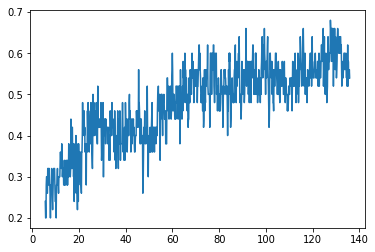

In [93]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject8 and test subject8

In [94]:
A08T = h5py.File('A08T_slice.mat', 'r')
X = np.copy(A08T['image'])
y = np.copy(A08T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 
Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 5s 23ms/step - loss: 1.8598 - acc: 0.2647 - val_loss: 1.8581 - val_acc: 0.2200
Epoch 2/1000
238/238 [==============================] - 0s 494us/step - loss: 1.8605 - acc: 0.2647 - val_loss: 1.8523 - val_acc: 0.2200
Epoch 3/1000
238/238 [==============================] - 0s 510us/step - loss: 1.8644 - acc: 0.2185 - val_loss: 1.8479 - val_acc: 0.2000
Epoch 4/1000
238/238 [==============================] - 0s 496us/step - loss: 1.8498 - acc: 0.2689 - val_loss: 1.8416 - val_acc: 0.2200
Epoch 5/1000
238/238 [==============================] - 0s 476us/step - loss: 1.8447 - acc: 0.2731 - val_loss: 1.8336 - val_acc: 0.2000
Epoch 6/1000
238/238 [==============================] - 0s 543us/step - loss: 1.8280 - acc: 0.2647 - val_loss: 1.8253 - val_ac

238/238 [==============================] - 0s 498us/step - loss: 1.5100 - acc: 0.3403 - val_loss: 1.5704 - val_acc: 0.2000
Epoch 60/1000
238/238 [==============================] - 0s 499us/step - loss: 1.5055 - acc: 0.3824 - val_loss: 1.5688 - val_acc: 0.2200
Epoch 61/1000
238/238 [==============================] - 0s 535us/step - loss: 1.5011 - acc: 0.3824 - val_loss: 1.5669 - val_acc: 0.1600
Epoch 62/1000
238/238 [==============================] - 0s 536us/step - loss: 1.4867 - acc: 0.4160 - val_loss: 1.5628 - val_acc: 0.1600
Epoch 63/1000
238/238 [==============================] - 0s 603us/step - loss: 1.4946 - acc: 0.3782 - val_loss: 1.5605 - val_acc: 0.2000
Epoch 64/1000
238/238 [==============================] - 0s 570us/step - loss: 1.4847 - acc: 0.4034 - val_loss: 1.5582 - val_acc: 0.1800
Epoch 65/1000
238/238 [==============================] - 0s 499us/step - loss: 1.4689 - acc: 0.4076 - val_loss: 1.5555 - val_acc: 0.2000
Epoch 66/1000
238/238 [==============================] 

Epoch 119/1000
238/238 [==============================] - 0s 521us/step - loss: 1.1779 - acc: 0.5126 - val_loss: 1.6668 - val_acc: 0.2600
Epoch 120/1000
238/238 [==============================] - 0s 559us/step - loss: 1.1809 - acc: 0.5462 - val_loss: 1.6605 - val_acc: 0.2400
Epoch 121/1000
238/238 [==============================] - 0s 513us/step - loss: 1.1767 - acc: 0.5924 - val_loss: 1.6625 - val_acc: 0.3400
Epoch 122/1000
238/238 [==============================] - 0s 539us/step - loss: 1.1338 - acc: 0.6345 - val_loss: 1.7094 - val_acc: 0.2400
Epoch 123/1000
238/238 [==============================] - 0s 528us/step - loss: 1.1586 - acc: 0.5546 - val_loss: 1.6864 - val_acc: 0.2600
Epoch 124/1000
238/238 [==============================] - 0s 520us/step - loss: 1.1084 - acc: 0.5672 - val_loss: 1.6750 - val_acc: 0.3200
Epoch 125/1000
238/238 [==============================] - 0s 513us/step - loss: 1.1338 - acc: 0.5294 - val_loss: 1.7115 - val_acc: 0.2200
Epoch 126/1000
238/238 [==========

238/238 [==============================] - 0s 555us/step - loss: 1.1161 - acc: 0.6429 - val_loss: 1.8017 - val_acc: 0.2600
Epoch 179/1000
238/238 [==============================] - 0s 564us/step - loss: 1.0513 - acc: 0.6597 - val_loss: 1.7881 - val_acc: 0.3600
Epoch 180/1000
238/238 [==============================] - 0s 544us/step - loss: 1.0376 - acc: 0.6933 - val_loss: 1.7716 - val_acc: 0.2400
Epoch 181/1000
238/238 [==============================] - 0s 534us/step - loss: 0.9767 - acc: 0.7227 - val_loss: 1.7880 - val_acc: 0.2000
Epoch 182/1000
238/238 [==============================] - 0s 546us/step - loss: 1.0429 - acc: 0.6639 - val_loss: 1.7883 - val_acc: 0.3000
Epoch 183/1000
238/238 [==============================] - 0s 505us/step - loss: 1.1363 - acc: 0.5966 - val_loss: 1.9220 - val_acc: 0.2000
Epoch 184/1000
238/238 [==============================] - 0s 496us/step - loss: 1.0471 - acc: 0.6429 - val_loss: 1.8007 - val_acc: 0.3200
Epoch 185/1000
238/238 [=========================

238/238 [==============================] - 0s 498us/step - loss: 0.9858 - acc: 0.7227 - val_loss: 2.0241 - val_acc: 0.3800
Epoch 238/1000
238/238 [==============================] - 0s 507us/step - loss: 1.0396 - acc: 0.7227 - val_loss: 1.9760 - val_acc: 0.3800
Epoch 239/1000
238/238 [==============================] - 0s 504us/step - loss: 0.9542 - acc: 0.7773 - val_loss: 1.9789 - val_acc: 0.3400
Epoch 240/1000
238/238 [==============================] - 0s 504us/step - loss: 1.0063 - acc: 0.7101 - val_loss: 1.9492 - val_acc: 0.3200
Epoch 241/1000
238/238 [==============================] - 0s 501us/step - loss: 0.9721 - acc: 0.7605 - val_loss: 1.8781 - val_acc: 0.3400
Epoch 242/1000
238/238 [==============================] - 0s 501us/step - loss: 0.9781 - acc: 0.7395 - val_loss: 1.8567 - val_acc: 0.3600
Epoch 243/1000
238/238 [==============================] - 0s 498us/step - loss: 0.9531 - acc: 0.7521 - val_loss: 1.8203 - val_acc: 0.3200
Epoch 244/1000
238/238 [=========================

238/238 [==============================] - 0s 511us/step - loss: 0.9193 - acc: 0.7731 - val_loss: 2.0371 - val_acc: 0.3400
Epoch 297/1000
238/238 [==============================] - 0s 543us/step - loss: 0.9001 - acc: 0.7899 - val_loss: 2.0631 - val_acc: 0.3400
Epoch 298/1000
238/238 [==============================] - 0s 510us/step - loss: 0.9137 - acc: 0.7857 - val_loss: 1.9843 - val_acc: 0.3400
Epoch 299/1000
238/238 [==============================] - 0s 501us/step - loss: 0.9276 - acc: 0.7689 - val_loss: 2.0734 - val_acc: 0.3600
Epoch 300/1000
238/238 [==============================] - 0s 532us/step - loss: 0.9119 - acc: 0.7731 - val_loss: 2.2174 - val_acc: 0.2600
Epoch 301/1000
238/238 [==============================] - 0s 502us/step - loss: 0.9694 - acc: 0.7731 - val_loss: 2.0995 - val_acc: 0.4000
Epoch 302/1000
238/238 [==============================] - 0s 511us/step - loss: 0.9369 - acc: 0.7521 - val_loss: 2.0649 - val_acc: 0.4200
Epoch 303/1000
238/238 [=========================

238/238 [==============================] - 0s 576us/step - loss: 0.8786 - acc: 0.7899 - val_loss: 2.0230 - val_acc: 0.3600
Epoch 356/1000
238/238 [==============================] - 0s 492us/step - loss: 0.8961 - acc: 0.8025 - val_loss: 2.1093 - val_acc: 0.3000
Epoch 357/1000
238/238 [==============================] - 0s 503us/step - loss: 0.8280 - acc: 0.8613 - val_loss: 2.0523 - val_acc: 0.3200
Epoch 358/1000
238/238 [==============================] - 0s 498us/step - loss: 0.8223 - acc: 0.8445 - val_loss: 2.1528 - val_acc: 0.3600
Epoch 359/1000
238/238 [==============================] - 0s 506us/step - loss: 0.9121 - acc: 0.7689 - val_loss: 2.1663 - val_acc: 0.3200
Epoch 360/1000
238/238 [==============================] - 0s 517us/step - loss: 0.9452 - acc: 0.7773 - val_loss: 2.1391 - val_acc: 0.4000
Epoch 361/1000
238/238 [==============================] - 0s 509us/step - loss: 0.8515 - acc: 0.8487 - val_loss: 2.1818 - val_acc: 0.3400
Epoch 362/1000
238/238 [=========================

238/238 [==============================] - 0s 509us/step - loss: 0.8225 - acc: 0.8025 - val_loss: 2.0029 - val_acc: 0.4600
Epoch 415/1000
238/238 [==============================] - 0s 543us/step - loss: 0.9306 - acc: 0.7857 - val_loss: 2.0582 - val_acc: 0.4200
Epoch 416/1000
238/238 [==============================] - 0s 534us/step - loss: 0.8786 - acc: 0.8277 - val_loss: 2.0657 - val_acc: 0.3800
Epoch 417/1000
238/238 [==============================] - 0s 582us/step - loss: 0.8453 - acc: 0.8361 - val_loss: 2.1569 - val_acc: 0.4000
Epoch 418/1000
238/238 [==============================] - 0s 537us/step - loss: 0.8659 - acc: 0.8235 - val_loss: 2.2209 - val_acc: 0.3600
Epoch 419/1000
238/238 [==============================] - 0s 530us/step - loss: 0.8934 - acc: 0.8235 - val_loss: 2.2411 - val_acc: 0.3800
Epoch 420/1000
238/238 [==============================] - 0s 502us/step - loss: 0.9222 - acc: 0.7983 - val_loss: 2.2064 - val_acc: 0.3800
Epoch 421/1000
238/238 [=========================

238/238 [==============================] - 0s 549us/step - loss: 0.8530 - acc: 0.8445 - val_loss: 2.3428 - val_acc: 0.3000
Epoch 474/1000
238/238 [==============================] - 0s 507us/step - loss: 0.7900 - acc: 0.8529 - val_loss: 2.3510 - val_acc: 0.3600
Epoch 475/1000
238/238 [==============================] - 0s 577us/step - loss: 0.7812 - acc: 0.8445 - val_loss: 2.3693 - val_acc: 0.3200
Epoch 476/1000
238/238 [==============================] - 0s 630us/step - loss: 0.8373 - acc: 0.8445 - val_loss: 2.3478 - val_acc: 0.3600
Epoch 477/1000
238/238 [==============================] - 0s 497us/step - loss: 0.8274 - acc: 0.8319 - val_loss: 2.2765 - val_acc: 0.3200
Epoch 478/1000
238/238 [==============================] - 0s 420us/step - loss: 0.8923 - acc: 0.7941 - val_loss: 2.2255 - val_acc: 0.3400
Epoch 479/1000
238/238 [==============================] - 0s 434us/step - loss: 0.8898 - acc: 0.8109 - val_loss: 2.1383 - val_acc: 0.3800
Epoch 480/1000
238/238 [=========================

238/238 [==============================] - 0s 502us/step - loss: 0.8249 - acc: 0.8571 - val_loss: 2.2186 - val_acc: 0.4000
Epoch 533/1000
238/238 [==============================] - 0s 504us/step - loss: 0.7918 - acc: 0.8445 - val_loss: 2.1310 - val_acc: 0.4400
Epoch 534/1000
238/238 [==============================] - 0s 517us/step - loss: 0.7679 - acc: 0.8613 - val_loss: 2.1748 - val_acc: 0.3400
Epoch 535/1000
238/238 [==============================] - 0s 528us/step - loss: 0.8522 - acc: 0.8403 - val_loss: 2.2229 - val_acc: 0.3400
Epoch 536/1000
238/238 [==============================] - 0s 530us/step - loss: 0.7596 - acc: 0.8697 - val_loss: 2.0795 - val_acc: 0.3800
Epoch 537/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7737 - acc: 0.8571 - val_loss: 2.0185 - val_acc: 0.4200
Epoch 538/1000
238/238 [==============================] - 0s 557us/step - loss: 0.8070 - acc: 0.8529 - val_loss: 2.0546 - val_acc: 0.5000
Epoch 539/1000
238/238 [=========================

238/238 [==============================] - 0s 504us/step - loss: 0.7651 - acc: 0.8361 - val_loss: 2.0810 - val_acc: 0.3600
Epoch 592/1000
238/238 [==============================] - 0s 533us/step - loss: 0.7306 - acc: 0.8613 - val_loss: 2.0069 - val_acc: 0.4000
Epoch 593/1000
238/238 [==============================] - 0s 496us/step - loss: 0.7609 - acc: 0.8445 - val_loss: 2.0101 - val_acc: 0.4200
Epoch 594/1000
238/238 [==============================] - 0s 494us/step - loss: 0.7594 - acc: 0.8445 - val_loss: 1.9637 - val_acc: 0.4800
Epoch 595/1000
238/238 [==============================] - 0s 493us/step - loss: 0.7688 - acc: 0.8445 - val_loss: 2.0246 - val_acc: 0.3800
Epoch 596/1000
238/238 [==============================] - 0s 499us/step - loss: 0.6562 - acc: 0.8908 - val_loss: 2.0909 - val_acc: 0.3600
Epoch 597/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7525 - acc: 0.8697 - val_loss: 2.1658 - val_acc: 0.3400
Epoch 598/1000
238/238 [=========================

238/238 [==============================] - 0s 555us/step - loss: 0.7451 - acc: 0.8613 - val_loss: 2.0562 - val_acc: 0.4000
Epoch 651/1000
238/238 [==============================] - 0s 487us/step - loss: 0.6781 - acc: 0.8866 - val_loss: 2.1561 - val_acc: 0.4200
Epoch 652/1000
238/238 [==============================] - 0s 494us/step - loss: 0.7163 - acc: 0.8739 - val_loss: 2.1639 - val_acc: 0.3400
Epoch 653/1000
238/238 [==============================] - 0s 554us/step - loss: 0.7571 - acc: 0.8739 - val_loss: 2.0806 - val_acc: 0.3600
Epoch 654/1000
238/238 [==============================] - 0s 524us/step - loss: 0.7246 - acc: 0.8739 - val_loss: 2.0196 - val_acc: 0.3600
Epoch 655/1000
238/238 [==============================] - 0s 582us/step - loss: 0.8025 - acc: 0.8445 - val_loss: 2.1551 - val_acc: 0.3400
Epoch 656/1000
238/238 [==============================] - 0s 560us/step - loss: 0.7171 - acc: 0.8529 - val_loss: 2.1997 - val_acc: 0.4000
Epoch 657/1000
238/238 [=========================

238/238 [==============================] - 0s 510us/step - loss: 0.6457 - acc: 0.8950 - val_loss: 2.2200 - val_acc: 0.3800
Epoch 710/1000
238/238 [==============================] - 0s 556us/step - loss: 0.6767 - acc: 0.8992 - val_loss: 2.1914 - val_acc: 0.4000
Epoch 711/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7059 - acc: 0.8697 - val_loss: 2.1292 - val_acc: 0.3200
Epoch 712/1000
238/238 [==============================] - 0s 592us/step - loss: 0.6540 - acc: 0.9076 - val_loss: 2.0120 - val_acc: 0.3400
Epoch 713/1000
238/238 [==============================] - 0s 531us/step - loss: 0.7806 - acc: 0.8697 - val_loss: 2.0092 - val_acc: 0.3400
Epoch 714/1000
238/238 [==============================] - 0s 511us/step - loss: 0.7846 - acc: 0.8571 - val_loss: 2.1633 - val_acc: 0.3600
Epoch 715/1000
238/238 [==============================] - 0s 515us/step - loss: 0.6621 - acc: 0.8992 - val_loss: 2.2326 - val_acc: 0.3600
Epoch 716/1000
238/238 [=========================

238/238 [==============================] - 0s 553us/step - loss: 0.6951 - acc: 0.8529 - val_loss: 2.0979 - val_acc: 0.3600
Epoch 769/1000
238/238 [==============================] - 0s 488us/step - loss: 0.6344 - acc: 0.8824 - val_loss: 2.0221 - val_acc: 0.3800
Epoch 770/1000
238/238 [==============================] - 0s 506us/step - loss: 0.6351 - acc: 0.8950 - val_loss: 2.0040 - val_acc: 0.4200
Epoch 771/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7317 - acc: 0.8613 - val_loss: 2.0317 - val_acc: 0.3600
Epoch 772/1000
238/238 [==============================] - 0s 498us/step - loss: 0.6705 - acc: 0.8739 - val_loss: 2.0485 - val_acc: 0.3800
Epoch 773/1000
238/238 [==============================] - 0s 505us/step - loss: 0.7352 - acc: 0.8697 - val_loss: 2.1703 - val_acc: 0.3400
Epoch 774/1000
238/238 [==============================] - 0s 496us/step - loss: 0.5635 - acc: 0.9202 - val_loss: 2.1566 - val_acc: 0.3600
Epoch 775/1000
238/238 [=========================

238/238 [==============================] - 0s 555us/step - loss: 0.5943 - acc: 0.9076 - val_loss: 2.2140 - val_acc: 0.3400
Epoch 828/1000
238/238 [==============================] - 0s 501us/step - loss: 0.6115 - acc: 0.8908 - val_loss: 2.2463 - val_acc: 0.3200
Epoch 829/1000
238/238 [==============================] - 0s 536us/step - loss: 0.5456 - acc: 0.9244 - val_loss: 2.1023 - val_acc: 0.3800
Epoch 830/1000
238/238 [==============================] - 0s 517us/step - loss: 0.5620 - acc: 0.9286 - val_loss: 2.0192 - val_acc: 0.4200
Epoch 831/1000
238/238 [==============================] - 0s 507us/step - loss: 0.6128 - acc: 0.8782 - val_loss: 2.0362 - val_acc: 0.4400
Epoch 832/1000
238/238 [==============================] - 0s 500us/step - loss: 0.6142 - acc: 0.8866 - val_loss: 1.9912 - val_acc: 0.4600
Epoch 833/1000
238/238 [==============================] - 0s 491us/step - loss: 0.7107 - acc: 0.8739 - val_loss: 2.0961 - val_acc: 0.4000
Epoch 834/1000
238/238 [=========================

238/238 [==============================] - 0s 541us/step - loss: 0.6663 - acc: 0.8529 - val_loss: 1.9895 - val_acc: 0.3200
Epoch 887/1000
238/238 [==============================] - 0s 522us/step - loss: 0.5775 - acc: 0.8908 - val_loss: 2.1217 - val_acc: 0.3600
Epoch 888/1000
238/238 [==============================] - 0s 573us/step - loss: 0.5331 - acc: 0.9244 - val_loss: 2.0904 - val_acc: 0.3400
Epoch 889/1000
238/238 [==============================] - 0s 519us/step - loss: 0.6360 - acc: 0.8824 - val_loss: 2.0144 - val_acc: 0.4600
Epoch 890/1000
238/238 [==============================] - 0s 572us/step - loss: 0.5810 - acc: 0.8992 - val_loss: 1.9691 - val_acc: 0.4400
Epoch 891/1000
238/238 [==============================] - 0s 519us/step - loss: 0.5450 - acc: 0.9076 - val_loss: 1.9873 - val_acc: 0.3400
Epoch 892/1000
238/238 [==============================] - 0s 509us/step - loss: 0.5748 - acc: 0.9160 - val_loss: 2.0015 - val_acc: 0.3200
Epoch 893/1000
238/238 [=========================

238/238 [==============================] - 0s 574us/step - loss: 0.5978 - acc: 0.8908 - val_loss: 2.1165 - val_acc: 0.4000
Epoch 946/1000
238/238 [==============================] - 0s 573us/step - loss: 0.6069 - acc: 0.8866 - val_loss: 2.1570 - val_acc: 0.3600
Epoch 947/1000
238/238 [==============================] - 0s 551us/step - loss: 0.5670 - acc: 0.8908 - val_loss: 2.1048 - val_acc: 0.3400
Epoch 948/1000
238/238 [==============================] - 0s 572us/step - loss: 0.6018 - acc: 0.9034 - val_loss: 2.2264 - val_acc: 0.2400
Epoch 949/1000
238/238 [==============================] - 0s 550us/step - loss: 0.6891 - acc: 0.8445 - val_loss: 2.2022 - val_acc: 0.2600
Epoch 950/1000
238/238 [==============================] - 0s 531us/step - loss: 0.5311 - acc: 0.9328 - val_loss: 2.0683 - val_acc: 0.3400
Epoch 951/1000
238/238 [==============================] - 0s 522us/step - loss: 0.5393 - acc: 0.9076 - val_loss: 2.1114 - val_acc: 0.2600
Epoch 952/1000
238/238 [=========================

0.5199999809265137


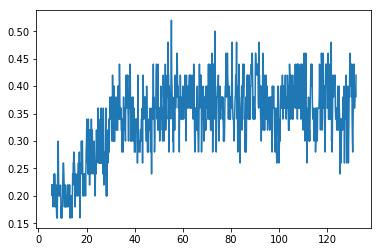

In [95]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train subject9 and test subject9

In [96]:
A09T = h5py.File('A09T_slice.mat', 'r')
X = np.copy(A09T['image'])
y = np.copy(A09T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)

where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

(288, 1000, 22)
(288, 1)
X_train: (238, 1000, 22) 
y_train: (238, 1) 
X_val: (50, 1000, 22) 
y_val: (50, 1) 
X_test: (50, 1000, 22) 
y_test: (50, 1) 
Train on 238 samples, validate on 50 samples
Epoch 1/1000
238/238 [==============================] - 6s 25ms/step - loss: 1.8625 - acc: 0.2857 - val_loss: 1.8678 - val_acc: 0.3000
Epoch 2/1000
238/238 [==============================] - 0s 493us/step - loss: 1.8685 - acc: 0.2479 - val_loss: 1.8616 - val_acc: 0.2400
Epoch 3/1000
238/238 [==============================] - 0s 523us/step - loss: 1.8604 - acc: 0.2605 - val_loss: 1.8554 - val_acc: 0.1600
Epoch 4/1000
238/238 [==============================] - 0s 514us/step - loss: 1.8568 - acc: 0.2101 - val_loss: 1.8443 - val_acc: 0.2000
Epoch 5/1000
238/238 [==============================] - 0s 515us/step - loss: 1.8413 - acc: 0.2353 - val_loss: 1.8386 - val_acc: 0.2200
Epoch 6/1000
238/238 [==============================] - 0s 525us/step - loss: 1.8381 - acc: 0.2521 - val_loss: 1.8311 - val_ac

238/238 [==============================] - 0s 526us/step - loss: 1.5457 - acc: 0.3361 - val_loss: 1.5643 - val_acc: 0.3000
Epoch 60/1000
238/238 [==============================] - 0s 531us/step - loss: 1.5177 - acc: 0.3655 - val_loss: 1.5625 - val_acc: 0.2600
Epoch 61/1000
238/238 [==============================] - 0s 519us/step - loss: 1.5109 - acc: 0.3613 - val_loss: 1.5650 - val_acc: 0.2000
Epoch 62/1000
238/238 [==============================] - 0s 583us/step - loss: 1.5086 - acc: 0.4034 - val_loss: 1.5619 - val_acc: 0.2200
Epoch 63/1000
238/238 [==============================] - 0s 503us/step - loss: 1.5133 - acc: 0.3319 - val_loss: 1.5565 - val_acc: 0.3000
Epoch 64/1000
238/238 [==============================] - 0s 571us/step - loss: 1.5038 - acc: 0.3950 - val_loss: 1.5540 - val_acc: 0.2800
Epoch 65/1000
238/238 [==============================] - 0s 493us/step - loss: 1.5016 - acc: 0.3739 - val_loss: 1.5512 - val_acc: 0.3000
Epoch 66/1000
238/238 [==============================] 

Epoch 119/1000
238/238 [==============================] - 0s 507us/step - loss: 1.2324 - acc: 0.5126 - val_loss: 1.5663 - val_acc: 0.2800
Epoch 120/1000
238/238 [==============================] - 0s 511us/step - loss: 1.2124 - acc: 0.5000 - val_loss: 1.6310 - val_acc: 0.2400
Epoch 121/1000
238/238 [==============================] - 0s 517us/step - loss: 1.2010 - acc: 0.5210 - val_loss: 1.5843 - val_acc: 0.2600
Epoch 122/1000
238/238 [==============================] - 0s 520us/step - loss: 1.1838 - acc: 0.5462 - val_loss: 1.5886 - val_acc: 0.2800
Epoch 123/1000
238/238 [==============================] - 0s 511us/step - loss: 1.2197 - acc: 0.5294 - val_loss: 1.5798 - val_acc: 0.2400
Epoch 124/1000
238/238 [==============================] - 0s 521us/step - loss: 1.2294 - acc: 0.5336 - val_loss: 1.6304 - val_acc: 0.2800
Epoch 125/1000
238/238 [==============================] - 0s 511us/step - loss: 1.2191 - acc: 0.5420 - val_loss: 1.5565 - val_acc: 0.2400
Epoch 126/1000
238/238 [==========

238/238 [==============================] - 0s 517us/step - loss: 1.0516 - acc: 0.6261 - val_loss: 1.6769 - val_acc: 0.3400
Epoch 179/1000
238/238 [==============================] - 0s 542us/step - loss: 1.0397 - acc: 0.6387 - val_loss: 1.6910 - val_acc: 0.3400
Epoch 180/1000
238/238 [==============================] - 0s 531us/step - loss: 1.1028 - acc: 0.6218 - val_loss: 1.7325 - val_acc: 0.3200
Epoch 181/1000
238/238 [==============================] - 0s 568us/step - loss: 1.0504 - acc: 0.6134 - val_loss: 1.7760 - val_acc: 0.2800
Epoch 182/1000
238/238 [==============================] - 0s 612us/step - loss: 1.0950 - acc: 0.6218 - val_loss: 1.7836 - val_acc: 0.3200
Epoch 183/1000
238/238 [==============================] - 0s 666us/step - loss: 1.0249 - acc: 0.6345 - val_loss: 1.7464 - val_acc: 0.3600
Epoch 184/1000
238/238 [==============================] - 0s 524us/step - loss: 1.0538 - acc: 0.6303 - val_loss: 1.7680 - val_acc: 0.3800
Epoch 185/1000
238/238 [=========================

238/238 [==============================] - 0s 551us/step - loss: 1.0047 - acc: 0.6639 - val_loss: 1.7960 - val_acc: 0.4200
Epoch 238/1000
238/238 [==============================] - 0s 564us/step - loss: 1.0164 - acc: 0.6387 - val_loss: 1.7562 - val_acc: 0.4000
Epoch 239/1000
238/238 [==============================] - 0s 543us/step - loss: 1.0509 - acc: 0.6303 - val_loss: 1.7900 - val_acc: 0.4400
Epoch 240/1000
238/238 [==============================] - 0s 587us/step - loss: 1.0084 - acc: 0.6723 - val_loss: 1.6766 - val_acc: 0.4200
Epoch 241/1000
238/238 [==============================] - 0s 523us/step - loss: 1.0836 - acc: 0.5756 - val_loss: 1.7089 - val_acc: 0.4000
Epoch 242/1000
238/238 [==============================] - 0s 565us/step - loss: 1.0955 - acc: 0.6092 - val_loss: 1.8022 - val_acc: 0.3800
Epoch 243/1000
238/238 [==============================] - 0s 524us/step - loss: 1.0701 - acc: 0.6387 - val_loss: 1.6430 - val_acc: 0.3400
Epoch 244/1000
238/238 [=========================

238/238 [==============================] - 0s 522us/step - loss: 0.8786 - acc: 0.7311 - val_loss: 1.7271 - val_acc: 0.4200
Epoch 297/1000
238/238 [==============================] - 0s 513us/step - loss: 0.9648 - acc: 0.6639 - val_loss: 1.8257 - val_acc: 0.4200
Epoch 298/1000
238/238 [==============================] - 0s 532us/step - loss: 0.9870 - acc: 0.6513 - val_loss: 1.8928 - val_acc: 0.3600
Epoch 299/1000
238/238 [==============================] - 0s 502us/step - loss: 0.9904 - acc: 0.6513 - val_loss: 1.7257 - val_acc: 0.4200
Epoch 300/1000
238/238 [==============================] - 0s 512us/step - loss: 0.9723 - acc: 0.6471 - val_loss: 1.7466 - val_acc: 0.3800
Epoch 301/1000
238/238 [==============================] - 0s 529us/step - loss: 0.9787 - acc: 0.6891 - val_loss: 1.7107 - val_acc: 0.4200
Epoch 302/1000
238/238 [==============================] - 0s 514us/step - loss: 0.9667 - acc: 0.6765 - val_loss: 1.7967 - val_acc: 0.3800
Epoch 303/1000
238/238 [=========================

238/238 [==============================] - 0s 546us/step - loss: 1.1010 - acc: 0.6597 - val_loss: 1.9201 - val_acc: 0.3600
Epoch 356/1000
238/238 [==============================] - 0s 514us/step - loss: 0.9592 - acc: 0.6639 - val_loss: 1.7531 - val_acc: 0.4200
Epoch 357/1000
238/238 [==============================] - 0s 550us/step - loss: 0.9941 - acc: 0.6807 - val_loss: 1.8283 - val_acc: 0.4600
Epoch 358/1000
238/238 [==============================] - 0s 512us/step - loss: 0.9713 - acc: 0.6933 - val_loss: 1.7937 - val_acc: 0.4400
Epoch 359/1000
238/238 [==============================] - 0s 514us/step - loss: 0.9850 - acc: 0.6807 - val_loss: 1.9414 - val_acc: 0.3400
Epoch 360/1000
238/238 [==============================] - 0s 519us/step - loss: 0.9758 - acc: 0.6933 - val_loss: 1.9214 - val_acc: 0.3600
Epoch 361/1000
238/238 [==============================] - 0s 538us/step - loss: 0.9565 - acc: 0.6849 - val_loss: 1.8979 - val_acc: 0.4400
Epoch 362/1000
238/238 [=========================

238/238 [==============================] - 0s 519us/step - loss: 0.8483 - acc: 0.7899 - val_loss: 2.0059 - val_acc: 0.4000
Epoch 415/1000
238/238 [==============================] - 0s 591us/step - loss: 1.0288 - acc: 0.6303 - val_loss: 1.9333 - val_acc: 0.4200
Epoch 416/1000
238/238 [==============================] - 0s 609us/step - loss: 0.8996 - acc: 0.6807 - val_loss: 1.8021 - val_acc: 0.5000
Epoch 417/1000
238/238 [==============================] - 0s 579us/step - loss: 0.9627 - acc: 0.7059 - val_loss: 1.7314 - val_acc: 0.4400
Epoch 418/1000
238/238 [==============================] - 0s 496us/step - loss: 0.8946 - acc: 0.7017 - val_loss: 1.7621 - val_acc: 0.4600
Epoch 419/1000
238/238 [==============================] - 0s 571us/step - loss: 0.8899 - acc: 0.7521 - val_loss: 1.8128 - val_acc: 0.4600
Epoch 420/1000
238/238 [==============================] - 0s 550us/step - loss: 0.9656 - acc: 0.7101 - val_loss: 1.8385 - val_acc: 0.4800
Epoch 421/1000
238/238 [=========================

238/238 [==============================] - 0s 518us/step - loss: 0.8785 - acc: 0.7143 - val_loss: 1.9864 - val_acc: 0.4200
Epoch 474/1000
238/238 [==============================] - 0s 574us/step - loss: 0.9604 - acc: 0.7185 - val_loss: 1.9386 - val_acc: 0.3600
Epoch 475/1000
238/238 [==============================] - 0s 496us/step - loss: 0.9425 - acc: 0.7017 - val_loss: 2.1091 - val_acc: 0.2600
Epoch 476/1000
238/238 [==============================] - 0s 622us/step - loss: 0.9476 - acc: 0.6933 - val_loss: 2.1254 - val_acc: 0.3600
Epoch 477/1000
238/238 [==============================] - 0s 512us/step - loss: 0.8319 - acc: 0.7521 - val_loss: 1.9874 - val_acc: 0.3600
Epoch 478/1000
238/238 [==============================] - 0s 542us/step - loss: 0.9246 - acc: 0.7353 - val_loss: 1.9487 - val_acc: 0.4000
Epoch 479/1000
238/238 [==============================] - 0s 529us/step - loss: 0.9384 - acc: 0.7101 - val_loss: 1.9533 - val_acc: 0.4000
Epoch 480/1000
238/238 [=========================

238/238 [==============================] - 0s 549us/step - loss: 0.9194 - acc: 0.7059 - val_loss: 1.9959 - val_acc: 0.4000
Epoch 533/1000
238/238 [==============================] - 0s 553us/step - loss: 0.8485 - acc: 0.7647 - val_loss: 1.8459 - val_acc: 0.5400
Epoch 534/1000
238/238 [==============================] - 0s 590us/step - loss: 0.9345 - acc: 0.7269 - val_loss: 1.8627 - val_acc: 0.4600
Epoch 535/1000
238/238 [==============================] - 0s 537us/step - loss: 0.8228 - acc: 0.7731 - val_loss: 1.8197 - val_acc: 0.4800
Epoch 536/1000
238/238 [==============================] - 0s 568us/step - loss: 0.8941 - acc: 0.7563 - val_loss: 1.7802 - val_acc: 0.4600
Epoch 537/1000
238/238 [==============================] - 0s 590us/step - loss: 0.8783 - acc: 0.7479 - val_loss: 1.8351 - val_acc: 0.4400
Epoch 538/1000
238/238 [==============================] - 0s 559us/step - loss: 0.8736 - acc: 0.7017 - val_loss: 1.9627 - val_acc: 0.4000
Epoch 539/1000
238/238 [=========================

238/238 [==============================] - 0s 559us/step - loss: 0.8602 - acc: 0.7479 - val_loss: 1.7765 - val_acc: 0.5200
Epoch 592/1000
238/238 [==============================] - 0s 542us/step - loss: 0.7883 - acc: 0.7773 - val_loss: 1.7772 - val_acc: 0.5200
Epoch 593/1000
238/238 [==============================] - 0s 591us/step - loss: 0.8120 - acc: 0.7605 - val_loss: 1.7351 - val_acc: 0.5000
Epoch 594/1000
238/238 [==============================] - 0s 598us/step - loss: 0.8957 - acc: 0.7857 - val_loss: 1.7357 - val_acc: 0.4800
Epoch 595/1000
238/238 [==============================] - 0s 506us/step - loss: 0.8692 - acc: 0.7899 - val_loss: 1.7215 - val_acc: 0.5200
Epoch 596/1000
238/238 [==============================] - 0s 543us/step - loss: 0.8065 - acc: 0.7689 - val_loss: 1.7349 - val_acc: 0.5600
Epoch 597/1000
238/238 [==============================] - 0s 497us/step - loss: 0.8683 - acc: 0.7605 - val_loss: 1.8631 - val_acc: 0.4800
Epoch 598/1000
238/238 [=========================

238/238 [==============================] - 0s 687us/step - loss: 0.7841 - acc: 0.8067 - val_loss: 1.5932 - val_acc: 0.5200
Epoch 651/1000
238/238 [==============================] - 0s 550us/step - loss: 0.7628 - acc: 0.8067 - val_loss: 1.6278 - val_acc: 0.5000
Epoch 652/1000
238/238 [==============================] - 0s 540us/step - loss: 0.8213 - acc: 0.7731 - val_loss: 1.6810 - val_acc: 0.5400
Epoch 653/1000
238/238 [==============================] - 0s 562us/step - loss: 0.7679 - acc: 0.8151 - val_loss: 1.7527 - val_acc: 0.5000
Epoch 654/1000
238/238 [==============================] - 0s 589us/step - loss: 0.8097 - acc: 0.7689 - val_loss: 1.7637 - val_acc: 0.5400
Epoch 655/1000
238/238 [==============================] - 0s 586us/step - loss: 0.8222 - acc: 0.7773 - val_loss: 1.7596 - val_acc: 0.5000
Epoch 656/1000
238/238 [==============================] - 0s 541us/step - loss: 0.7423 - acc: 0.8067 - val_loss: 1.7631 - val_acc: 0.5200
Epoch 657/1000
238/238 [=========================

238/238 [==============================] - 0s 533us/step - loss: 0.7208 - acc: 0.8571 - val_loss: 1.6259 - val_acc: 0.4800
Epoch 710/1000
238/238 [==============================] - 0s 561us/step - loss: 0.7108 - acc: 0.8571 - val_loss: 1.6284 - val_acc: 0.4800
Epoch 711/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7164 - acc: 0.8361 - val_loss: 1.6182 - val_acc: 0.5200
Epoch 712/1000
238/238 [==============================] - 0s 533us/step - loss: 0.7451 - acc: 0.8235 - val_loss: 1.6540 - val_acc: 0.5200
Epoch 713/1000
238/238 [==============================] - 0s 508us/step - loss: 0.7528 - acc: 0.8277 - val_loss: 1.6815 - val_acc: 0.5400
Epoch 714/1000
238/238 [==============================] - 0s 533us/step - loss: 0.7218 - acc: 0.8403 - val_loss: 1.6623 - val_acc: 0.5200
Epoch 715/1000
238/238 [==============================] - 0s 488us/step - loss: 0.8153 - acc: 0.8235 - val_loss: 1.5637 - val_acc: 0.5200
Epoch 716/1000
238/238 [=========================

238/238 [==============================] - 0s 533us/step - loss: 0.6756 - acc: 0.8824 - val_loss: 1.4610 - val_acc: 0.5800
Epoch 769/1000
238/238 [==============================] - 0s 530us/step - loss: 0.7887 - acc: 0.8109 - val_loss: 1.4848 - val_acc: 0.5200
Epoch 770/1000
238/238 [==============================] - 0s 505us/step - loss: 0.7113 - acc: 0.8571 - val_loss: 1.5140 - val_acc: 0.5200
Epoch 771/1000
238/238 [==============================] - 0s 520us/step - loss: 0.6783 - acc: 0.8571 - val_loss: 1.5161 - val_acc: 0.4800
Epoch 772/1000
238/238 [==============================] - 0s 516us/step - loss: 0.7272 - acc: 0.8361 - val_loss: 1.5912 - val_acc: 0.4800
Epoch 773/1000
238/238 [==============================] - 0s 513us/step - loss: 0.6523 - acc: 0.8866 - val_loss: 1.6162 - val_acc: 0.4800
Epoch 774/1000
238/238 [==============================] - 0s 508us/step - loss: 0.6859 - acc: 0.8697 - val_loss: 1.6132 - val_acc: 0.5000
Epoch 775/1000
238/238 [=========================

238/238 [==============================] - 0s 523us/step - loss: 0.6721 - acc: 0.8908 - val_loss: 1.6800 - val_acc: 0.4600
Epoch 828/1000
238/238 [==============================] - 0s 517us/step - loss: 0.5907 - acc: 0.9076 - val_loss: 1.6755 - val_acc: 0.5200
Epoch 829/1000
238/238 [==============================] - 0s 513us/step - loss: 0.6665 - acc: 0.8571 - val_loss: 1.5782 - val_acc: 0.5400
Epoch 830/1000
238/238 [==============================] - 0s 549us/step - loss: 0.7375 - acc: 0.8193 - val_loss: 1.4993 - val_acc: 0.5400
Epoch 831/1000
238/238 [==============================] - 0s 538us/step - loss: 0.6980 - acc: 0.8487 - val_loss: 1.5535 - val_acc: 0.5400
Epoch 832/1000
238/238 [==============================] - 0s 568us/step - loss: 0.6443 - acc: 0.8613 - val_loss: 1.5595 - val_acc: 0.4600
Epoch 833/1000
238/238 [==============================] - 0s 554us/step - loss: 0.6091 - acc: 0.9076 - val_loss: 1.6825 - val_acc: 0.4400
Epoch 834/1000
238/238 [=========================

238/238 [==============================] - 0s 558us/step - loss: 0.7188 - acc: 0.8403 - val_loss: 1.7958 - val_acc: 0.5200
Epoch 887/1000
238/238 [==============================] - 0s 531us/step - loss: 0.7386 - acc: 0.8655 - val_loss: 1.8370 - val_acc: 0.4600
Epoch 888/1000
238/238 [==============================] - 0s 587us/step - loss: 0.6595 - acc: 0.8529 - val_loss: 1.8361 - val_acc: 0.5200
Epoch 889/1000
238/238 [==============================] - 0s 499us/step - loss: 0.6512 - acc: 0.8824 - val_loss: 1.8562 - val_acc: 0.5200
Epoch 890/1000
238/238 [==============================] - 0s 513us/step - loss: 0.6199 - acc: 0.8908 - val_loss: 1.8431 - val_acc: 0.4800
Epoch 891/1000
238/238 [==============================] - 0s 523us/step - loss: 0.7242 - acc: 0.8361 - val_loss: 1.6949 - val_acc: 0.5600
Epoch 892/1000
238/238 [==============================] - 0s 518us/step - loss: 0.5648 - acc: 0.9118 - val_loss: 1.7367 - val_acc: 0.5000
Epoch 893/1000
238/238 [=========================

238/238 [==============================] - 0s 515us/step - loss: 0.7384 - acc: 0.8361 - val_loss: 1.6409 - val_acc: 0.4400
Epoch 946/1000
238/238 [==============================] - 0s 512us/step - loss: 0.7671 - acc: 0.8193 - val_loss: 1.6587 - val_acc: 0.5000
Epoch 947/1000
238/238 [==============================] - 0s 514us/step - loss: 0.6864 - acc: 0.8613 - val_loss: 1.7416 - val_acc: 0.5000
Epoch 948/1000
238/238 [==============================] - 0s 533us/step - loss: 0.6353 - acc: 0.8529 - val_loss: 1.8154 - val_acc: 0.4800
Epoch 949/1000
238/238 [==============================] - 0s 499us/step - loss: 0.7325 - acc: 0.8277 - val_loss: 1.8618 - val_acc: 0.3800
Epoch 950/1000
238/238 [==============================] - 0s 520us/step - loss: 0.6103 - acc: 0.8908 - val_loss: 1.8850 - val_acc: 0.4800
Epoch 951/1000
238/238 [==============================] - 0s 507us/step - loss: 0.6060 - acc: 0.8866 - val_loss: 1.7969 - val_acc: 0.4600
Epoch 952/1000
238/238 [=========================

0.6000000238418579


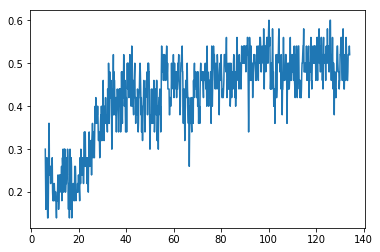

In [97]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

## Train all subjects

In [41]:
# load data
labels = ["left","right","feet","tongue"]

A01T = h5py.File('A01T_slice.mat', 'r')
X = np.copy(A01T['image'])
y = np.copy(A01T['type'])
y = y[0,0:X.shape[0]:1]
# mask = list(range(238,288))
# X_test = X[mask]
# y_test = y[mask]
for i in range(2,10):
    raw_data = h5py.File('A0'+str(i)+'T_slice.mat', 'r')
    xi = np.copy(raw_data['image'])
    yi = np.copy(raw_data['type'])
    yi = yi[0,0:xi.shape[0]:1]
    X = np.concatenate((X, xi))
    y = np.concatenate((y, yi))

y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)
where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
print(X.shape)
print(y.shape)

(2592, 1000, 22)
(2592, 1)


In [47]:
mask1 = list(range(50))
X_test1 = X[mask1]
y_test1 = y[mask1]
mask2 = list(range(288,288+50))
X_test2 = X[mask2]
y_test2 = y[mask2]
mask3 = list(range(288*2,288*2+50))
X_test3 = X[mask3]
y_test3 = y[mask3]
mask4 = list(range(288*3,288*3+50))
X_test4 = X[mask4]
y_test4 = y[mask4]
mask5 = list(range(288*4,288*4+50))
X_test5 = X[mask5]
y_test5 = y[mask5]
mask6 = list(range(288*5,288*5+50))
X_test6 = X[mask6]
y_test6 = y[mask6]
mask7 = list(range(288*6,288*6+50))
X_test7 = X[mask7]
y_test7 = y[mask7]
mask8 = list(range(288*7,288*7+50))
X_test8 = X[mask8]
y_test8 = y[mask8]
mask9 = list(range(288*8,288*8+50))
X_test9 = X[mask9]
y_test9 = y[mask9]

mask_train1 = list(range(50,288*9))
X_train1 = X[mask_train1]
y_train1 = y[mask_train1]
mask_train2 = list(range(0,288*1))+list(range(288*1+50,288*9))
X_train2 = X[mask_train2]
y_train2 = y[mask_train2]
mask_train3 = list(range(0,288*2))+list(range(288*2+50,288*9))
X_train3 = X[mask_train3]
y_train3 = y[mask_train3]
mask_train4 = list(range(0,288*3))+list(range(288*3+50,288*9))
X_train4 = X[mask_train4]
y_train4 = y[mask_train4]
mask_train5 = list(range(0,288*4))+list(range(288*4+50,288*9))
X_train5 = X[mask_train5]
y_train5 = y[mask_train5]
mask_train6 = list(range(0,288*5))+list(range(288*5+50,288*9))
X_train6 = X[mask_train6]
y_train6 = y[mask_train6]
mask_train7 = list(range(0,288*6))+list(range(288*6+50,288*9))
X_train7 = X[mask_train7]
y_train7 = y[mask_train7]
mask_train8 = list(range(0,288*7))+list(range(288*7+50,288*9))
X_train8 = X[mask_train8]
y_train8 = y[mask_train8]
mask_train9 = list(range(0,288*8))+list(range(288*8+50,288*9))
X_train9 = X[mask_train9]
y_train9 = y[mask_train9]

In [51]:

y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)
y_train3 = keras.utils.to_categorical(y_train3, num_classes)
y_test3 = keras.utils.to_categorical(y_test3, num_classes)
y_train4 = keras.utils.to_categorical(y_train4, num_classes)
y_test4 = keras.utils.to_categorical(y_test4, num_classes)
y_train5 = keras.utils.to_categorical(y_train5, num_classes)
y_test5 = keras.utils.to_categorical(y_test5, num_classes)
y_train6 = keras.utils.to_categorical(y_train6, num_classes)
y_test6 = keras.utils.to_categorical(y_test6, num_classes)
y_train7 = keras.utils.to_categorical(y_train7, num_classes)
y_test7 = keras.utils.to_categorical(y_test7, num_classes)
y_train8 = keras.utils.to_categorical(y_train8, num_classes)
y_test8 = keras.utils.to_categorical(y_test8, num_classes)
y_train9 = keras.utils.to_categorical(y_train9, num_classes)
y_test9 = keras.utils.to_categorical(y_test9, num_classes)

### Train all test subject1

In [52]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train1, y_train1,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test1, y_test1))
times = time_callback.times
scores = model.evaluate(X_test1, y_test1, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8438 - acc: 0.2411 - val_loss: 1.7988 - val_acc: 0.2000
Epoch 2/1000
2542/2542 [==============================] - 2s 606us/step - loss: 1.7637 - acc: 0.2514 - val_loss: 1.7264 - val_acc: 0.2800
Epoch 3/1000
2542/2542 [==============================] - 1s 521us/step - loss: 1.6973 - acc: 0.2411 - val_loss: 1.6677 - val_acc: 0.2200
Epoch 4/1000
2542/2542 [==============================] - 2s 630us/step - loss: 1.6455 - acc: 0.2459 - val_loss: 1.6160 - val_acc: 0.2800
Epoch 5/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.6045 - acc: 0.2404 - val_loss: 1.5800 - val_acc: 0.2800
Epoch 6/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.5682 - acc: 0.2486 - val_loss: 1.5466 - val_acc: 0.3600
Epoch 7/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.5367 - acc: 0.2632 - val_loss: 1.5203 - val_ac

2542/2542 [==============================] - 1s 469us/step - loss: 1.3394 - acc: 0.3899 - val_loss: 1.4197 - val_acc: 0.3600
Epoch 60/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.3313 - acc: 0.4064 - val_loss: 1.3979 - val_acc: 0.4200
Epoch 61/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.3323 - acc: 0.3954 - val_loss: 1.3912 - val_acc: 0.3800
Epoch 62/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.3368 - acc: 0.3946 - val_loss: 1.3960 - val_acc: 0.4000
Epoch 63/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.3320 - acc: 0.3961 - val_loss: 1.3848 - val_acc: 0.4400
Epoch 64/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.3278 - acc: 0.4028 - val_loss: 1.3826 - val_acc: 0.4600
Epoch 65/1000
2542/2542 [==============================] - 1s 517us/step - loss: 1.3253 - acc: 0.4020 - val_loss: 1.4151 - val_acc: 0.4200
Epoch 66/1000
2542/2542 [================

Epoch 118/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.2752 - acc: 0.4673 - val_loss: 1.3975 - val_acc: 0.4200
Epoch 119/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.2843 - acc: 0.4732 - val_loss: 1.3821 - val_acc: 0.4400
Epoch 120/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.2771 - acc: 0.4697 - val_loss: 1.4107 - val_acc: 0.4600
Epoch 121/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.2826 - acc: 0.4666 - val_loss: 1.3798 - val_acc: 0.4600
Epoch 122/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.2622 - acc: 0.4701 - val_loss: 1.4553 - val_acc: 0.3600
Epoch 123/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.2854 - acc: 0.4650 - val_loss: 1.4616 - val_acc: 0.3800
Epoch 124/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.2858 - acc: 0.4662 - val_loss: 1.4346 - val_acc: 0.3800
Epoch 125/1000
2542/

2542/2542 [==============================] - 1s 476us/step - loss: 1.2517 - acc: 0.5016 - val_loss: 1.4080 - val_acc: 0.3400
Epoch 177/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.2329 - acc: 0.5138 - val_loss: 1.4356 - val_acc: 0.4200
Epoch 178/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.2263 - acc: 0.5212 - val_loss: 1.4377 - val_acc: 0.3800
Epoch 179/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.2178 - acc: 0.5260 - val_loss: 1.3969 - val_acc: 0.4200
Epoch 180/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.2336 - acc: 0.5098 - val_loss: 1.4719 - val_acc: 0.4000
Epoch 181/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.2318 - acc: 0.5106 - val_loss: 1.4294 - val_acc: 0.4000
Epoch 182/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.2424 - acc: 0.5102 - val_loss: 1.3808 - val_acc: 0.4000
Epoch 183/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 473us/step - loss: 1.1865 - acc: 0.5346 - val_loss: 1.3693 - val_acc: 0.4200
Epoch 235/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1814 - acc: 0.5429 - val_loss: 1.3687 - val_acc: 0.4200
Epoch 236/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1735 - acc: 0.5594 - val_loss: 1.4083 - val_acc: 0.4200
Epoch 237/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.2077 - acc: 0.5382 - val_loss: 1.3805 - val_acc: 0.3600
Epoch 238/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.1825 - acc: 0.5523 - val_loss: 1.3907 - val_acc: 0.4000
Epoch 239/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.1881 - acc: 0.5456 - val_loss: 1.4127 - val_acc: 0.4600
Epoch 240/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1804 - acc: 0.5484 - val_loss: 1.3868 - val_acc: 0.4800
Epoch 241/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 465us/step - loss: 1.1725 - acc: 0.5539 - val_loss: 1.3403 - val_acc: 0.4600
Epoch 293/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.1611 - acc: 0.5496 - val_loss: 1.3698 - val_acc: 0.5000
Epoch 294/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.1549 - acc: 0.5484 - val_loss: 1.3126 - val_acc: 0.4600
Epoch 295/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.1654 - acc: 0.5460 - val_loss: 1.3319 - val_acc: 0.4000
Epoch 296/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1537 - acc: 0.5649 - val_loss: 1.3225 - val_acc: 0.4600
Epoch 297/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1496 - acc: 0.5728 - val_loss: 1.3526 - val_acc: 0.4400
Epoch 298/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1496 - acc: 0.5728 - val_loss: 1.3076 - val_acc: 0.4200
Epoch 299/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 457us/step - loss: 1.1516 - acc: 0.5677 - val_loss: 1.3426 - val_acc: 0.4200
Epoch 351/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.1212 - acc: 0.5803 - val_loss: 1.3106 - val_acc: 0.5000
Epoch 352/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.1258 - acc: 0.5893 - val_loss: 1.3272 - val_acc: 0.5200
Epoch 353/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.1369 - acc: 0.5618 - val_loss: 1.3576 - val_acc: 0.4600
Epoch 354/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1298 - acc: 0.5850 - val_loss: 1.3217 - val_acc: 0.4600
Epoch 355/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1538 - acc: 0.5688 - val_loss: 1.3305 - val_acc: 0.4800
Epoch 356/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.1551 - acc: 0.5582 - val_loss: 1.3460 - val_acc: 0.4800
Epoch 357/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 577us/step - loss: 1.1406 - acc: 0.5712 - val_loss: 1.2671 - val_acc: 0.4600
Epoch 409/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.0958 - acc: 0.6109 - val_loss: 1.2944 - val_acc: 0.4800
Epoch 410/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1143 - acc: 0.5787 - val_loss: 1.2967 - val_acc: 0.5000
Epoch 411/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1363 - acc: 0.5625 - val_loss: 1.2252 - val_acc: 0.5400
Epoch 412/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.1233 - acc: 0.5779 - val_loss: 1.2958 - val_acc: 0.4800
Epoch 413/1000
2542/2542 [==============================] - 2s 628us/step - loss: 1.1283 - acc: 0.5724 - val_loss: 1.2825 - val_acc: 0.5600
Epoch 414/1000
2542/2542 [==============================] - 2s 629us/step - loss: 1.1145 - acc: 0.5897 - val_loss: 1.2616 - val_acc: 0.5800
Epoch 415/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 464us/step - loss: 1.0800 - acc: 0.6058 - val_loss: 1.3288 - val_acc: 0.5200
Epoch 467/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.1061 - acc: 0.5932 - val_loss: 1.3179 - val_acc: 0.5400
Epoch 468/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0887 - acc: 0.6098 - val_loss: 1.2782 - val_acc: 0.4800
Epoch 469/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1248 - acc: 0.5775 - val_loss: 1.2723 - val_acc: 0.5800
Epoch 470/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0874 - acc: 0.6035 - val_loss: 1.2537 - val_acc: 0.5600
Epoch 471/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.1112 - acc: 0.5842 - val_loss: 1.2883 - val_acc: 0.5200
Epoch 472/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0842 - acc: 0.5980 - val_loss: 1.2791 - val_acc: 0.4600
Epoch 473/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 462us/step - loss: 1.0903 - acc: 0.5928 - val_loss: 1.3204 - val_acc: 0.4800
Epoch 525/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.0593 - acc: 0.6070 - val_loss: 1.2949 - val_acc: 0.5800
Epoch 526/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0658 - acc: 0.6046 - val_loss: 1.3202 - val_acc: 0.5200
Epoch 527/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0719 - acc: 0.6023 - val_loss: 1.3133 - val_acc: 0.5000
Epoch 528/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.1093 - acc: 0.5787 - val_loss: 1.2916 - val_acc: 0.4400
Epoch 529/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.0822 - acc: 0.6027 - val_loss: 1.2572 - val_acc: 0.4800
Epoch 530/1000
2542/2542 [==============================] - 1s 541us/step - loss: 1.0817 - acc: 0.6058 - val_loss: 1.2626 - val_acc: 0.6000
Epoch 531/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 459us/step - loss: 1.0770 - acc: 0.6066 - val_loss: 1.3173 - val_acc: 0.5400
Epoch 583/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0777 - acc: 0.6086 - val_loss: 1.3173 - val_acc: 0.5200
Epoch 584/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0456 - acc: 0.6251 - val_loss: 1.3409 - val_acc: 0.5200
Epoch 585/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.0734 - acc: 0.5991 - val_loss: 1.2800 - val_acc: 0.5000
Epoch 586/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1004 - acc: 0.5991 - val_loss: 1.2940 - val_acc: 0.5000
Epoch 587/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.0767 - acc: 0.5980 - val_loss: 1.2860 - val_acc: 0.5600
Epoch 588/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0457 - acc: 0.6188 - val_loss: 1.2738 - val_acc: 0.5000loss: 1.0357 - acc: 
Epoch 589/1000


2542/2542 [==============================] - 1s 478us/step - loss: 1.0750 - acc: 0.6007 - val_loss: 1.2311 - val_acc: 0.5600
Epoch 641/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.0579 - acc: 0.6121 - val_loss: 1.2969 - val_acc: 0.5400
Epoch 642/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0485 - acc: 0.6149 - val_loss: 1.2896 - val_acc: 0.4800
Epoch 643/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0531 - acc: 0.6101 - val_loss: 1.2609 - val_acc: 0.5600
Epoch 644/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.0539 - acc: 0.6184 - val_loss: 1.2883 - val_acc: 0.5400
Epoch 645/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0497 - acc: 0.6046 - val_loss: 1.2676 - val_acc: 0.5400
Epoch 646/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0620 - acc: 0.6070 - val_loss: 1.2922 - val_acc: 0.4800
Epoch 647/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 453us/step - loss: 1.0793 - acc: 0.6042 - val_loss: 1.2657 - val_acc: 0.5400
Epoch 699/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0456 - acc: 0.6200 - val_loss: 1.2339 - val_acc: 0.5000
Epoch 700/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0381 - acc: 0.6263 - val_loss: 1.2249 - val_acc: 0.5400
Epoch 701/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0343 - acc: 0.6216 - val_loss: 1.2775 - val_acc: 0.5200
Epoch 702/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0662 - acc: 0.6074 - val_loss: 1.2153 - val_acc: 0.5400
Epoch 703/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.0575 - acc: 0.6133 - val_loss: 1.2460 - val_acc: 0.5400
Epoch 704/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.0403 - acc: 0.6251 - val_loss: 1.2647 - val_acc: 0.5400
Epoch 705/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 473us/step - loss: 1.0337 - acc: 0.6180 - val_loss: 1.3039 - val_acc: 0.5200
Epoch 757/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.0252 - acc: 0.6200 - val_loss: 1.3162 - val_acc: 0.4800loss: 1.0215 - acc: 0.
Epoch 758/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0390 - acc: 0.6200 - val_loss: 1.2759 - val_acc: 0.5400
Epoch 759/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0450 - acc: 0.6074 - val_loss: 1.2649 - val_acc: 0.5000
Epoch 760/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.0561 - acc: 0.6101 - val_loss: 1.3064 - val_acc: 0.5400
Epoch 761/1000
2542/2542 [==============================] - 1s 498us/step - loss: 1.0535 - acc: 0.6082 - val_loss: 1.2490 - val_acc: 0.5600
Epoch 762/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.0430 - acc: 0.6086 - val_loss: 1.2632 - val_acc: 0.5200
Epoch 763/100

2542/2542 [==============================] - 1s 467us/step - loss: 1.0390 - acc: 0.6133 - val_loss: 1.2421 - val_acc: 0.5200
Epoch 815/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0289 - acc: 0.6227 - val_loss: 1.2613 - val_acc: 0.5600
Epoch 816/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0563 - acc: 0.6086 - val_loss: 1.2490 - val_acc: 0.5600 - loss: 1.0471 - acc:
Epoch 817/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.0315 - acc: 0.6125 - val_loss: 1.2884 - val_acc: 0.5800
Epoch 818/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0375 - acc: 0.6263 - val_loss: 1.2709 - val_acc: 0.5200
Epoch 819/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.0719 - acc: 0.6054 - val_loss: 1.2963 - val_acc: 0.4800
Epoch 820/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0144 - acc: 0.6294 - val_loss: 1.2679 - val_acc: 0.5200
Epoch 821/100

2542/2542 [==============================] - 1s 482us/step - loss: 1.0527 - acc: 0.6050 - val_loss: 1.2476 - val_acc: 0.4600
Epoch 873/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0078 - acc: 0.6263 - val_loss: 1.2757 - val_acc: 0.5000
Epoch 874/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0304 - acc: 0.6113 - val_loss: 1.2700 - val_acc: 0.5000
Epoch 875/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0110 - acc: 0.6275 - val_loss: 1.2921 - val_acc: 0.5600
Epoch 876/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0245 - acc: 0.6373 - val_loss: 1.2975 - val_acc: 0.5400
Epoch 877/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0110 - acc: 0.6353 - val_loss: 1.3116 - val_acc: 0.6000
Epoch 878/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.0154 - acc: 0.6255 - val_loss: 1.2473 - val_acc: 0.5000
Epoch 879/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 468us/step - loss: 1.0122 - acc: 0.6255 - val_loss: 1.2928 - val_acc: 0.4800
Epoch 931/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0145 - acc: 0.6282 - val_loss: 1.3150 - val_acc: 0.5200
Epoch 932/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0150 - acc: 0.6275 - val_loss: 1.2985 - val_acc: 0.5000
Epoch 933/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0253 - acc: 0.6208 - val_loss: 1.2891 - val_acc: 0.4800
Epoch 934/1000
2542/2542 [==============================] - 1s 464us/step - loss: 0.9866 - acc: 0.6385 - val_loss: 1.3098 - val_acc: 0.4800
Epoch 935/1000
2542/2542 [==============================] - 1s 461us/step - loss: 0.9863 - acc: 0.6381 - val_loss: 1.3072 - val_acc: 0.5000
Epoch 936/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0123 - acc: 0.6338 - val_loss: 1.2911 - val_acc: 0.5000
Epoch 937/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 487us/step - loss: 1.0172 - acc: 0.6322 - val_loss: 1.2219 - val_acc: 0.5400
Epoch 989/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.0174 - acc: 0.6298 - val_loss: 1.2596 - val_acc: 0.5200loss: 1.0217 - acc: 0.
Epoch 990/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0143 - acc: 0.6204 - val_loss: 1.2733 - val_acc: 0.4800
Epoch 991/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0237 - acc: 0.6279 - val_loss: 1.2791 - val_acc: 0.5400- loss: 1.0197 - acc: 0.6
Epoch 992/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0199 - acc: 0.6192 - val_loss: 1.2747 - val_acc: 0.4800
Epoch 993/1000
2542/2542 [==============================] - 1s 458us/step - loss: 0.9977 - acc: 0.6408 - val_loss: 1.2752 - val_acc: 0.5400
Epoch 994/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0115 - acc: 0.6306 - val_loss: 1.2780 - val_

0.6399999856948853


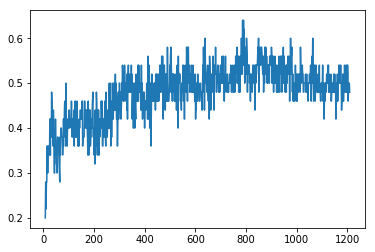

In [53]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject2

In [54]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train2, y_train2,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test2, y_test2))
times = time_callback.times
scores = model.evaluate(X_test2, y_test2, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 6s 3ms/step - loss: 1.8386 - acc: 0.2522 - val_loss: 1.7909 - val_acc: 0.2800
Epoch 2/1000
2542/2542 [==============================] - 2s 627us/step - loss: 1.7609 - acc: 0.2498 - val_loss: 1.7139 - val_acc: 0.3400
Epoch 3/1000
2542/2542 [==============================] - 1s 490us/step - loss: 1.6960 - acc: 0.2518 - val_loss: 1.6613 - val_acc: 0.2600
Epoch 4/1000
2542/2542 [==============================] - 1s 578us/step - loss: 1.6429 - acc: 0.2612 - val_loss: 1.6195 - val_acc: 0.2400
Epoch 5/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.5986 - acc: 0.2667 - val_loss: 1.5844 - val_acc: 0.2200
Epoch 6/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.5666 - acc: 0.2522 - val_loss: 1.5527 - val_acc: 0.2200
Epoch 7/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.5344 - acc: 0.2569 - val_loss: 1.5301 - val_ac

2542/2542 [==============================] - 1s 444us/step - loss: 1.3363 - acc: 0.4186 - val_loss: 1.3571 - val_acc: 0.3800
Epoch 60/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.3335 - acc: 0.4127 - val_loss: 1.3479 - val_acc: 0.3800
Epoch 61/1000
2542/2542 [==============================] - 1s 431us/step - loss: 1.3406 - acc: 0.4131 - val_loss: 1.3510 - val_acc: 0.3600
Epoch 62/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.3451 - acc: 0.4001 - val_loss: 1.3506 - val_acc: 0.3600
Epoch 63/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.3280 - acc: 0.4079 - val_loss: 1.3706 - val_acc: 0.3800
Epoch 64/1000
2542/2542 [==============================] - 1s 436us/step - loss: 1.3145 - acc: 0.4256 - val_loss: 1.3950 - val_acc: 0.3200
Epoch 65/1000
2542/2542 [==============================] - 1s 432us/step - loss: 1.3446 - acc: 0.4028 - val_loss: 1.3831 - val_acc: 0.3200
Epoch 66/1000
2542/2542 [================

2542/2542 [==============================] - 1s 444us/step - loss: 1.2833 - acc: 0.4571 - val_loss: 1.3540 - val_acc: 0.3800
Epoch 118/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.2748 - acc: 0.4642 - val_loss: 1.3350 - val_acc: 0.3400
Epoch 119/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.2832 - acc: 0.4618 - val_loss: 1.3304 - val_acc: 0.4600
Epoch 120/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.2850 - acc: 0.4626 - val_loss: 1.3377 - val_acc: 0.4600
Epoch 121/1000
2542/2542 [==============================] - ETA: 0s - loss: 1.2863 - acc: 0.464 - 1s 441us/step - loss: 1.2921 - acc: 0.4603 - val_loss: 1.3626 - val_acc: 0.4000
Epoch 122/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.2818 - acc: 0.4654 - val_loss: 1.3779 - val_acc: 0.3400
Epoch 123/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.2888 - acc: 0.4611 - val_loss: 1.3264 - val_acc: 0.48

Epoch 175/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.2409 - acc: 0.5024 - val_loss: 1.4433 - val_acc: 0.2800
Epoch 176/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.2582 - acc: 0.4776 - val_loss: 1.3150 - val_acc: 0.4800
Epoch 177/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.2386 - acc: 0.4874 - val_loss: 1.3143 - val_acc: 0.4400
Epoch 178/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.2427 - acc: 0.4996 - val_loss: 1.3532 - val_acc: 0.4600
Epoch 179/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.2515 - acc: 0.4882 - val_loss: 1.3020 - val_acc: 0.4600
Epoch 180/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.2439 - acc: 0.4933 - val_loss: 1.3065 - val_acc: 0.4800
Epoch 181/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.2565 - acc: 0.4788 - val_loss: 1.3326 - val_acc: 0.3800
Epoch 182/1000
2542/

2542/2542 [==============================] - 1s 453us/step - loss: 1.2222 - acc: 0.5102 - val_loss: 1.3537 - val_acc: 0.4200
Epoch 234/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.2225 - acc: 0.4921 - val_loss: 1.2926 - val_acc: 0.5200
Epoch 235/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.2097 - acc: 0.5028 - val_loss: 1.3821 - val_acc: 0.3800
Epoch 236/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.2037 - acc: 0.5087 - val_loss: 1.3228 - val_acc: 0.4800
Epoch 237/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.2074 - acc: 0.5024 - val_loss: 1.3153 - val_acc: 0.4600
Epoch 238/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.2190 - acc: 0.4945 - val_loss: 1.3209 - val_acc: 0.4800
Epoch 239/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.2179 - acc: 0.4961 - val_loss: 1.3436 - val_acc: 0.4600
Epoch 240/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 440us/step - loss: 1.2080 - acc: 0.5016 - val_loss: 1.3484 - val_acc: 0.4000
Epoch 292/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.1856 - acc: 0.5149 - val_loss: 1.3191 - val_acc: 0.4600
Epoch 293/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1854 - acc: 0.5114 - val_loss: 1.3398 - val_acc: 0.3800
Epoch 294/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.1948 - acc: 0.5205 - val_loss: 1.3209 - val_acc: 0.4400
Epoch 295/1000
2542/2542 [==============================] - 1s 436us/step - loss: 1.2119 - acc: 0.5043 - val_loss: 1.3514 - val_acc: 0.3800
Epoch 296/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.1923 - acc: 0.5197 - val_loss: 1.3321 - val_acc: 0.4400
Epoch 297/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1876 - acc: 0.5228 - val_loss: 1.3135 - val_acc: 0.5000
Epoch 298/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 445us/step - loss: 1.1842 - acc: 0.5165 - val_loss: 1.3491 - val_acc: 0.4800
Epoch 350/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.1806 - acc: 0.5248 - val_loss: 1.3705 - val_acc: 0.4600
Epoch 351/1000
2542/2542 [==============================] - 2s 608us/step - loss: 1.1666 - acc: 0.5382 - val_loss: 1.3706 - val_acc: 0.4600
Epoch 352/1000
2542/2542 [==============================] - 1s 584us/step - loss: 1.1747 - acc: 0.5205 - val_loss: 1.3558 - val_acc: 0.4800
Epoch 353/1000
2542/2542 [==============================] - 2s 613us/step - loss: 1.1756 - acc: 0.5169 - val_loss: 1.3594 - val_acc: 0.4400
Epoch 354/1000
2542/2542 [==============================] - 1s 506us/step - loss: 1.1785 - acc: 0.5134 - val_loss: 1.3565 - val_acc: 0.4200
Epoch 355/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1539 - acc: 0.5354 - val_loss: 1.3908 - val_acc: 0.4000
Epoch 356/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 448us/step - loss: 1.1470 - acc: 0.5334 - val_loss: 1.3397 - val_acc: 0.3800
Epoch 408/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.1640 - acc: 0.5248 - val_loss: 1.3684 - val_acc: 0.4400
Epoch 409/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1382 - acc: 0.5527 - val_loss: 1.2952 - val_acc: 0.4600
Epoch 410/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1659 - acc: 0.5208 - val_loss: 1.3078 - val_acc: 0.4400
Epoch 411/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1670 - acc: 0.5362 - val_loss: 1.2988 - val_acc: 0.4400
Epoch 412/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.1610 - acc: 0.5291 - val_loss: 1.2873 - val_acc: 0.4800
Epoch 413/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.1507 - acc: 0.5327 - val_loss: 1.3173 - val_acc: 0.4200
Epoch 414/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 473us/step - loss: 1.1332 - acc: 0.5354 - val_loss: 1.2875 - val_acc: 0.4400
Epoch 466/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1310 - acc: 0.5366 - val_loss: 1.3240 - val_acc: 0.4400
Epoch 467/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1492 - acc: 0.5287 - val_loss: 1.3273 - val_acc: 0.4200
Epoch 468/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.1385 - acc: 0.5315 - val_loss: 1.3620 - val_acc: 0.4400
Epoch 469/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.1452 - acc: 0.5319 - val_loss: 1.3386 - val_acc: 0.4600
Epoch 470/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1372 - acc: 0.5362 - val_loss: 1.3235 - val_acc: 0.4600
Epoch 471/1000
2542/2542 [==============================] - 1s 523us/step - loss: 1.1360 - acc: 0.5342 - val_loss: 1.3524 - val_acc: 0.4400
Epoch 472/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 448us/step - loss: 1.1204 - acc: 0.5535 - val_loss: 1.3129 - val_acc: 0.4400
Epoch 524/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.1331 - acc: 0.5256 - val_loss: 1.3421 - val_acc: 0.4000
Epoch 525/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.1365 - acc: 0.5417 - val_loss: 1.3631 - val_acc: 0.4400
Epoch 526/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.1320 - acc: 0.5334 - val_loss: 1.3391 - val_acc: 0.4400
Epoch 527/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.1293 - acc: 0.5460 - val_loss: 1.3441 - val_acc: 0.4400
Epoch 528/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1270 - acc: 0.5433 - val_loss: 1.3607 - val_acc: 0.4000
Epoch 529/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.1312 - acc: 0.5429 - val_loss: 1.3626 - val_acc: 0.3600
Epoch 530/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 443us/step - loss: 1.1202 - acc: 0.5523 - val_loss: 1.3727 - val_acc: 0.4600
Epoch 582/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1266 - acc: 0.5397 - val_loss: 1.3616 - val_acc: 0.4600
Epoch 583/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.1216 - acc: 0.5452 - val_loss: 1.3453 - val_acc: 0.4200
Epoch 584/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.1109 - acc: 0.5445 - val_loss: 1.3404 - val_acc: 0.5000
Epoch 585/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.1270 - acc: 0.5425 - val_loss: 1.3713 - val_acc: 0.4800
Epoch 586/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.1138 - acc: 0.5421 - val_loss: 1.3911 - val_acc: 0.4000
Epoch 587/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.1079 - acc: 0.5515 - val_loss: 1.3645 - val_acc: 0.4600
Epoch 588/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 443us/step - loss: 1.1079 - acc: 0.5551 - val_loss: 1.3375 - val_acc: 0.4400
Epoch 640/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.0999 - acc: 0.5590 - val_loss: 1.3014 - val_acc: 0.4800
Epoch 641/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.1067 - acc: 0.5649 - val_loss: 1.3322 - val_acc: 0.5200
Epoch 642/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1082 - acc: 0.5570 - val_loss: 1.3402 - val_acc: 0.4600
Epoch 643/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.1160 - acc: 0.5625 - val_loss: 1.3121 - val_acc: 0.5600
Epoch 644/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1051 - acc: 0.5625 - val_loss: 1.3550 - val_acc: 0.3800
Epoch 645/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0985 - acc: 0.5633 - val_loss: 1.3527 - val_acc: 0.4600
Epoch 646/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 476us/step - loss: 1.0905 - acc: 0.5661 - val_loss: 1.3555 - val_acc: 0.4800
Epoch 698/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.0939 - acc: 0.5610 - val_loss: 1.3962 - val_acc: 0.4000
Epoch 699/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0979 - acc: 0.5606 - val_loss: 1.3757 - val_acc: 0.5000
Epoch 700/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1074 - acc: 0.5425 - val_loss: 1.3813 - val_acc: 0.4600
Epoch 701/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.1077 - acc: 0.5563 - val_loss: 1.3514 - val_acc: 0.4800
Epoch 702/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1080 - acc: 0.5480 - val_loss: 1.3564 - val_acc: 0.4800
Epoch 703/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.1048 - acc: 0.5488 - val_loss: 1.3522 - val_acc: 0.4000
Epoch 704/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 445us/step - loss: 1.1009 - acc: 0.5484 - val_loss: 1.3112 - val_acc: 0.4800
Epoch 756/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.1224 - acc: 0.5492 - val_loss: 1.3546 - val_acc: 0.5000
Epoch 757/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.1014 - acc: 0.5547 - val_loss: 1.3797 - val_acc: 0.5000
Epoch 758/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0923 - acc: 0.5543 - val_loss: 1.2957 - val_acc: 0.44001.0930 - acc: 0.55
Epoch 759/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0737 - acc: 0.5594 - val_loss: 1.3242 - val_acc: 0.4200
Epoch 760/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0994 - acc: 0.5582 - val_loss: 1.3780 - val_acc: 0.4600
Epoch 761/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0773 - acc: 0.5610 - val_loss: 1.3279 - val_acc: 0.4600
Epoch 762/1000
25

2542/2542 [==============================] - 1s 440us/step - loss: 1.0892 - acc: 0.5511 - val_loss: 1.3646 - val_acc: 0.4800
Epoch 814/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0784 - acc: 0.5712 - val_loss: 1.3388 - val_acc: 0.4600
Epoch 815/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0910 - acc: 0.5598 - val_loss: 1.3452 - val_acc: 0.4000
Epoch 816/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.0973 - acc: 0.5637 - val_loss: 1.3798 - val_acc: 0.4800
Epoch 817/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.0975 - acc: 0.5480 - val_loss: 1.3507 - val_acc: 0.4200
Epoch 818/1000
2542/2542 [==============================] - ETA: 0s - loss: 1.0787 - acc: 0.563 - 1s 439us/step - loss: 1.0747 - acc: 0.5649 - val_loss: 1.3696 - val_acc: 0.4600
Epoch 819/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0970 - acc: 0.5594 - val_loss: 1.4009 - val_acc: 0.48

2542/2542 [==============================] - 1s 450us/step - loss: 1.0800 - acc: 0.5716 - val_loss: 1.2958 - val_acc: 0.4200
Epoch 872/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0718 - acc: 0.5728 - val_loss: 1.3496 - val_acc: 0.4200
Epoch 873/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0955 - acc: 0.5531 - val_loss: 1.3192 - val_acc: 0.4400
Epoch 874/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.0855 - acc: 0.5606 - val_loss: 1.3304 - val_acc: 0.4400
Epoch 875/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.0650 - acc: 0.5712 - val_loss: 1.3001 - val_acc: 0.5000
Epoch 876/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0877 - acc: 0.5598 - val_loss: 1.3562 - val_acc: 0.3800
Epoch 877/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0633 - acc: 0.5657 - val_loss: 1.3798 - val_acc: 0.3800
Epoch 878/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 455us/step - loss: 1.0732 - acc: 0.5614 - val_loss: 1.3426 - val_acc: 0.4800
Epoch 930/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.0894 - acc: 0.5500 - val_loss: 1.3369 - val_acc: 0.4400
Epoch 931/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0692 - acc: 0.5704 - val_loss: 1.3329 - val_acc: 0.4000
Epoch 932/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0759 - acc: 0.5681 - val_loss: 1.3293 - val_acc: 0.4600
Epoch 933/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0704 - acc: 0.5759 - val_loss: 1.3528 - val_acc: 0.4600
Epoch 934/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0614 - acc: 0.5622 - val_loss: 1.3194 - val_acc: 0.4600
Epoch 935/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0941 - acc: 0.5586 - val_loss: 1.2923 - val_acc: 0.4400
Epoch 936/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 459us/step - loss: 1.0879 - acc: 0.5563 - val_loss: 1.3736 - val_acc: 0.4600
Epoch 988/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.0873 - acc: 0.5559 - val_loss: 1.3370 - val_acc: 0.4400
Epoch 989/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0601 - acc: 0.5696 - val_loss: 1.3499 - val_acc: 0.3800
Epoch 990/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.0666 - acc: 0.5688 - val_loss: 1.3516 - val_acc: 0.4600
Epoch 991/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0853 - acc: 0.5602 - val_loss: 1.2772 - val_acc: 0.4200
Epoch 992/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.0690 - acc: 0.5724 - val_loss: 1.2932 - val_acc: 0.4800
Epoch 993/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0778 - acc: 0.5700 - val_loss: 1.2751 - val_acc: 0.4800
Epoch 994/1000
2542/2542 [=========

0.5600000023841858


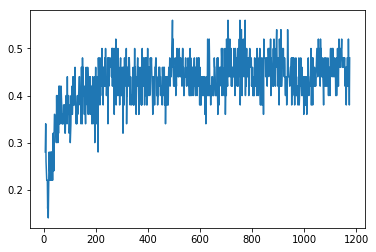

In [55]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject3

In [56]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train3, y_train3,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test3, y_test3))
times = time_callback.times
scores = model.evaluate(X_test3, y_test3, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8219 - acc: 0.2557 - val_loss: 1.7798 - val_acc: 0.3000
Epoch 2/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.7492 - acc: 0.2502 - val_loss: 1.7091 - val_acc: 0.2400
Epoch 3/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.6863 - acc: 0.2585 - val_loss: 1.6551 - val_acc: 0.2200
Epoch 4/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.6299 - acc: 0.2640 - val_loss: 1.6102 - val_acc: 0.1800
Epoch 5/1000
2542/2542 [==============================] - 1s 589us/step - loss: 1.5935 - acc: 0.2573 - val_loss: 1.5746 - val_acc: 0.2400
Epoch 6/1000
2542/2542 [==============================] - 1s 495us/step - loss: 1.5579 - acc: 0.2750 - val_loss: 1.5491 - val_acc: 0.1800
Epoch 7/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.5296 - acc: 0.2659 - val_loss: 1.5271 - val_ac

Epoch 60/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.3387 - acc: 0.4028 - val_loss: 1.3893 - val_acc: 0.3400
Epoch 61/1000
2542/2542 [==============================] - 1s 432us/step - loss: 1.3445 - acc: 0.3981 - val_loss: 1.3444 - val_acc: 0.4000
Epoch 62/1000
2542/2542 [==============================] - 1s 434us/step - loss: 1.3440 - acc: 0.3926 - val_loss: 1.4054 - val_acc: 0.3200
Epoch 63/1000
2542/2542 [==============================] - 1s 435us/step - loss: 1.3450 - acc: 0.4060 - val_loss: 1.3550 - val_acc: 0.4200
Epoch 64/1000
2542/2542 [==============================] - 1s 429us/step - loss: 1.3291 - acc: 0.4135 - val_loss: 1.3606 - val_acc: 0.3800
Epoch 65/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.3482 - acc: 0.3969 - val_loss: 1.3247 - val_acc: 0.4600
Epoch 66/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.3358 - acc: 0.4024 - val_loss: 1.3414 - val_acc: 0.3600
Epoch 67/1000
2542/2542 [==

Epoch 119/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.2822 - acc: 0.4803 - val_loss: 1.2490 - val_acc: 0.4800
Epoch 120/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.2944 - acc: 0.4677 - val_loss: 1.2404 - val_acc: 0.5200
Epoch 121/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.2788 - acc: 0.4764 - val_loss: 1.2555 - val_acc: 0.4000
Epoch 122/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.2885 - acc: 0.4642 - val_loss: 1.2316 - val_acc: 0.5400
Epoch 123/1000
2542/2542 [==============================] - 1s 429us/step - loss: 1.2854 - acc: 0.4725 - val_loss: 1.2141 - val_acc: 0.5400
Epoch 124/1000
2542/2542 [==============================] - 1s 433us/step - loss: 1.2798 - acc: 0.4658 - val_loss: 1.2524 - val_acc: 0.4800
Epoch 125/1000
2542/2542 [==============================] - 1s 431us/step - loss: 1.2828 - acc: 0.4607 - val_loss: 1.2606 - val_acc: 0.4400
Epoch 126/1000
2542/

2542/2542 [==============================] - 1s 433us/step - loss: 1.2466 - acc: 0.5024 - val_loss: 1.2104 - val_acc: 0.5200
Epoch 178/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.2414 - acc: 0.5149 - val_loss: 1.1872 - val_acc: 0.5400
Epoch 179/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.2299 - acc: 0.5224 - val_loss: 1.1702 - val_acc: 0.5000
Epoch 180/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.2352 - acc: 0.5201 - val_loss: 1.2459 - val_acc: 0.4400
Epoch 181/1000
2542/2542 [==============================] - 1s 433us/step - loss: 1.2196 - acc: 0.5299 - val_loss: 1.1938 - val_acc: 0.5200
Epoch 182/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.2416 - acc: 0.5122 - val_loss: 1.1976 - val_acc: 0.4400
Epoch 183/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.2563 - acc: 0.4878 - val_loss: 1.2135 - val_acc: 0.5000
Epoch 184/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 439us/step - loss: 1.2046 - acc: 0.5374 - val_loss: 1.1589 - val_acc: 0.5400
Epoch 236/1000
2542/2542 [==============================] - 1s 429us/step - loss: 1.1962 - acc: 0.5460 - val_loss: 1.1492 - val_acc: 0.5000
Epoch 237/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.2142 - acc: 0.5279 - val_loss: 1.1609 - val_acc: 0.5200
Epoch 238/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.1972 - acc: 0.5468 - val_loss: 1.1479 - val_acc: 0.5200
Epoch 239/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.1869 - acc: 0.5464 - val_loss: 1.1116 - val_acc: 0.5600
Epoch 240/1000
2542/2542 [==============================] - 1s 436us/step - loss: 1.2155 - acc: 0.5307 - val_loss: 1.1895 - val_acc: 0.5000
Epoch 241/1000
2542/2542 [==============================] - 1s 431us/step - loss: 1.1968 - acc: 0.5445 - val_loss: 1.1232 - val_acc: 0.5600
Epoch 242/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 434us/step - loss: 1.1841 - acc: 0.5448 - val_loss: 1.1052 - val_acc: 0.5400
Epoch 294/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.1669 - acc: 0.5563 - val_loss: 1.1117 - val_acc: 0.4600
Epoch 295/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1767 - acc: 0.5476 - val_loss: 1.1232 - val_acc: 0.5200
Epoch 296/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.1766 - acc: 0.5515 - val_loss: 1.1321 - val_acc: 0.4600
Epoch 297/1000
2542/2542 [==============================] - 1s 434us/step - loss: 1.1684 - acc: 0.5622 - val_loss: 1.1710 - val_acc: 0.4200
Epoch 298/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.2040 - acc: 0.5220 - val_loss: 1.1356 - val_acc: 0.4800
Epoch 299/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1712 - acc: 0.5574 - val_loss: 1.1574 - val_acc: 0.5000
Epoch 300/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 439us/step - loss: 1.1518 - acc: 0.5732 - val_loss: 1.1977 - val_acc: 0.4400
Epoch 352/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.1515 - acc: 0.5716 - val_loss: 1.2061 - val_acc: 0.4000
Epoch 353/1000
2542/2542 [==============================] - 1s 436us/step - loss: 1.1454 - acc: 0.5858 - val_loss: 1.1833 - val_acc: 0.4200
Epoch 354/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1425 - acc: 0.5708 - val_loss: 1.1490 - val_acc: 0.4800
Epoch 355/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.1264 - acc: 0.5830 - val_loss: 1.1564 - val_acc: 0.4800
Epoch 356/1000
2542/2542 [==============================] - 1s 430us/step - loss: 1.1544 - acc: 0.5677 - val_loss: 1.2075 - val_acc: 0.4400
Epoch 357/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.1453 - acc: 0.5704 - val_loss: 1.1825 - val_acc: 0.5200
Epoch 358/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 439us/step - loss: 1.1199 - acc: 0.5767 - val_loss: 1.2070 - val_acc: 0.4800
Epoch 410/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.1196 - acc: 0.5893 - val_loss: 1.2069 - val_acc: 0.4000
Epoch 411/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.1222 - acc: 0.5901 - val_loss: 1.1892 - val_acc: 0.4200
Epoch 412/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.1238 - acc: 0.5728 - val_loss: 1.2025 - val_acc: 0.4600
Epoch 413/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1378 - acc: 0.5724 - val_loss: 1.2115 - val_acc: 0.4200
Epoch 414/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0981 - acc: 0.5968 - val_loss: 1.2131 - val_acc: 0.3800
Epoch 415/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1231 - acc: 0.5846 - val_loss: 1.1899 - val_acc: 0.4400
Epoch 416/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 452us/step - loss: 1.1092 - acc: 0.5803 - val_loss: 1.1625 - val_acc: 0.4800
Epoch 468/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1004 - acc: 0.5877 - val_loss: 1.1797 - val_acc: 0.4400
Epoch 469/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.1123 - acc: 0.5881 - val_loss: 1.1474 - val_acc: 0.4800
Epoch 470/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0994 - acc: 0.6066 - val_loss: 1.1320 - val_acc: 0.4800
Epoch 471/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1117 - acc: 0.5830 - val_loss: 1.2007 - val_acc: 0.4800
Epoch 472/1000
2542/2542 [==============================] - 1s 434us/step - loss: 1.1384 - acc: 0.5771 - val_loss: 1.2095 - val_acc: 0.4400
Epoch 473/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.1241 - acc: 0.5850 - val_loss: 1.1787 - val_acc: 0.4400
Epoch 474/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 445us/step - loss: 1.0802 - acc: 0.6074 - val_loss: 1.1958 - val_acc: 0.4600
Epoch 526/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.0852 - acc: 0.5983 - val_loss: 1.2011 - val_acc: 0.3600
Epoch 527/1000
2542/2542 [==============================] - 1s 432us/step - loss: 1.0993 - acc: 0.6027 - val_loss: 1.1986 - val_acc: 0.4600
Epoch 528/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0940 - acc: 0.6011 - val_loss: 1.1779 - val_acc: 0.4000
Epoch 529/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.1273 - acc: 0.5747 - val_loss: 1.1919 - val_acc: 0.4000
Epoch 530/1000
2542/2542 [==============================] - 1s 434us/step - loss: 1.0995 - acc: 0.5948 - val_loss: 1.1701 - val_acc: 0.4600
Epoch 531/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.0951 - acc: 0.6035 - val_loss: 1.1952 - val_acc: 0.4200
Epoch 532/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 465us/step - loss: 1.0776 - acc: 0.6050 - val_loss: 1.1734 - val_acc: 0.4400
Epoch 584/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.0756 - acc: 0.6058 - val_loss: 1.1780 - val_acc: 0.4800
Epoch 585/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0847 - acc: 0.6031 - val_loss: 1.1783 - val_acc: 0.4400
Epoch 586/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0642 - acc: 0.6121 - val_loss: 1.2084 - val_acc: 0.3800
Epoch 587/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.0869 - acc: 0.5999 - val_loss: 1.1716 - val_acc: 0.4200
Epoch 588/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.0695 - acc: 0.6161 - val_loss: 1.1591 - val_acc: 0.4600
Epoch 589/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.0733 - acc: 0.6058 - val_loss: 1.1596 - val_acc: 0.4200
Epoch 590/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 437us/step - loss: 1.0596 - acc: 0.6161 - val_loss: 1.1530 - val_acc: 0.4800
Epoch 642/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0522 - acc: 0.6145 - val_loss: 1.1014 - val_acc: 0.5200
Epoch 643/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.0664 - acc: 0.5983 - val_loss: 1.1478 - val_acc: 0.5600
Epoch 644/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.0720 - acc: 0.6113 - val_loss: 1.1474 - val_acc: 0.5200
Epoch 645/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0702 - acc: 0.6050 - val_loss: 1.1162 - val_acc: 0.5000
Epoch 646/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0817 - acc: 0.6157 - val_loss: 1.1308 - val_acc: 0.4800
Epoch 647/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.0671 - acc: 0.6082 - val_loss: 1.1403 - val_acc: 0.4800
Epoch 648/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 445us/step - loss: 1.0471 - acc: 0.6133 - val_loss: 1.1896 - val_acc: 0.5600
Epoch 700/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.0489 - acc: 0.6184 - val_loss: 1.2197 - val_acc: 0.4200
Epoch 701/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.0573 - acc: 0.6054 - val_loss: 1.1937 - val_acc: 0.4200
Epoch 702/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0811 - acc: 0.6007 - val_loss: 1.1618 - val_acc: 0.5400
Epoch 703/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.0566 - acc: 0.6121 - val_loss: 1.2428 - val_acc: 0.4400
Epoch 704/1000
2542/2542 [==============================] - 1s 434us/step - loss: 1.0562 - acc: 0.6105 - val_loss: 1.1838 - val_acc: 0.5000
Epoch 705/1000
2542/2542 [==============================] - 1s 492us/step - loss: 1.0594 - acc: 0.6239 - val_loss: 1.2175 - val_acc: 0.5000
Epoch 706/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 442us/step - loss: 1.0445 - acc: 0.6192 - val_loss: 1.1204 - val_acc: 0.5400
Epoch 758/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0360 - acc: 0.6196 - val_loss: 1.1701 - val_acc: 0.5200
Epoch 759/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0422 - acc: 0.6101 - val_loss: 1.1379 - val_acc: 0.5600
Epoch 760/1000
2542/2542 [==============================] - 1s 435us/step - loss: 1.0470 - acc: 0.6231 - val_loss: 1.1597 - val_acc: 0.4800
Epoch 761/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0300 - acc: 0.6235 - val_loss: 1.1489 - val_acc: 0.5200
Epoch 762/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.0425 - acc: 0.6066 - val_loss: 1.1549 - val_acc: 0.4800
Epoch 763/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0394 - acc: 0.6070 - val_loss: 1.1078 - val_acc: 0.5600
Epoch 764/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 452us/step - loss: 1.0255 - acc: 0.6341 - val_loss: 1.1207 - val_acc: 0.5400
Epoch 816/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.0354 - acc: 0.6172 - val_loss: 1.1180 - val_acc: 0.5600
Epoch 817/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0431 - acc: 0.6188 - val_loss: 1.1439 - val_acc: 0.5400
Epoch 818/1000
2542/2542 [==============================] - 1s 435us/step - loss: 1.0319 - acc: 0.6294 - val_loss: 1.1161 - val_acc: 0.5800
Epoch 819/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0156 - acc: 0.6310 - val_loss: 1.1072 - val_acc: 0.5400
Epoch 820/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.0598 - acc: 0.6070 - val_loss: 1.1180 - val_acc: 0.5400
Epoch 821/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.0474 - acc: 0.6216 - val_loss: 1.1408 - val_acc: 0.5800
Epoch 822/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 456us/step - loss: 1.0432 - acc: 0.6137 - val_loss: 1.2121 - val_acc: 0.4800
Epoch 874/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0617 - acc: 0.6086 - val_loss: 1.1811 - val_acc: 0.5200
Epoch 875/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.0228 - acc: 0.6227 - val_loss: 1.2092 - val_acc: 0.4400
Epoch 876/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.0371 - acc: 0.6145 - val_loss: 1.2164 - val_acc: 0.5400
Epoch 877/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.0159 - acc: 0.6306 - val_loss: 1.1694 - val_acc: 0.5600
Epoch 878/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.0570 - acc: 0.6141 - val_loss: 1.1685 - val_acc: 0.5600
Epoch 879/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0225 - acc: 0.6223 - val_loss: 1.2320 - val_acc: 0.4800
Epoch 880/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 452us/step - loss: 1.0370 - acc: 0.6220 - val_loss: 1.0724 - val_acc: 0.5400
Epoch 932/1000
2542/2542 [==============================] - 1s 533us/step - loss: 1.0276 - acc: 0.6271 - val_loss: 1.1247 - val_acc: 0.5600
Epoch 933/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.0358 - acc: 0.6227 - val_loss: 1.1708 - val_acc: 0.5800
Epoch 934/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0201 - acc: 0.6208 - val_loss: 1.1029 - val_acc: 0.6000
Epoch 935/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0338 - acc: 0.6227 - val_loss: 1.0974 - val_acc: 0.5800
Epoch 936/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.0233 - acc: 0.6251 - val_loss: 1.1428 - val_acc: 0.5000
Epoch 937/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0384 - acc: 0.6184 - val_loss: 1.1254 - val_acc: 0.5400
Epoch 938/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 447us/step - loss: 1.0151 - acc: 0.6239 - val_loss: 1.1393 - val_acc: 0.5200
Epoch 990/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0018 - acc: 0.6412 - val_loss: 1.1233 - val_acc: 0.4800
Epoch 991/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0235 - acc: 0.6239 - val_loss: 1.1564 - val_acc: 0.5200
Epoch 992/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0309 - acc: 0.6243 - val_loss: 1.1228 - val_acc: 0.5600
Epoch 993/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0103 - acc: 0.6220 - val_loss: 1.1656 - val_acc: 0.4800
Epoch 994/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0180 - acc: 0.6341 - val_loss: 1.1211 - val_acc: 0.5600
Epoch 995/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0412 - acc: 0.6133 - val_loss: 1.1410 - val_acc: 0.5200
Epoch 996/1000
2542/2542 [=========

0.6600000262260437


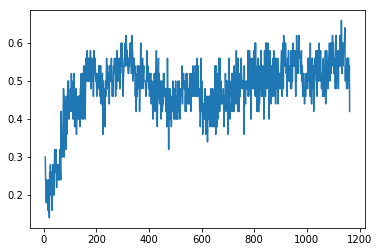

In [57]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject4

In [58]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train4, y_train4,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test4, y_test4))
times = time_callback.times
scores = model.evaluate(X_test4, y_test4, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8374 - acc: 0.2537 - val_loss: 1.7940 - val_acc: 0.2400
Epoch 2/1000
2542/2542 [==============================] - 1s 534us/step - loss: 1.7603 - acc: 0.2537 - val_loss: 1.7219 - val_acc: 0.2000
Epoch 3/1000
2542/2542 [==============================] - 1s 527us/step - loss: 1.6951 - acc: 0.2400 - val_loss: 1.6601 - val_acc: 0.2600
Epoch 4/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.6428 - acc: 0.2565 - val_loss: 1.6156 - val_acc: 0.2800
Epoch 5/1000
2542/2542 [==============================] - 1s 544us/step - loss: 1.5991 - acc: 0.2604 - val_loss: 1.5769 - val_acc: 0.2400
Epoch 6/1000
2542/2542 [==============================] - 1s 545us/step - loss: 1.5627 - acc: 0.2640 - val_loss: 1.5459 - val_acc: 0.2400
Epoch 7/1000
2542/2542 [==============================] - 1s 531us/step - loss: 1.5356 - acc: 0.2738 - val_loss: 1.5195 - val_ac

Epoch 60/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.3338 - acc: 0.4032 - val_loss: 1.3844 - val_acc: 0.3000
Epoch 61/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.3285 - acc: 0.3910 - val_loss: 1.3900 - val_acc: 0.2600
Epoch 62/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.3410 - acc: 0.4091 - val_loss: 1.4032 - val_acc: 0.3400
Epoch 63/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.3357 - acc: 0.3993 - val_loss: 1.3940 - val_acc: 0.4000
Epoch 64/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.3339 - acc: 0.4005 - val_loss: 1.3942 - val_acc: 0.3400
Epoch 65/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.3322 - acc: 0.4166 - val_loss: 1.3837 - val_acc: 0.3800
Epoch 66/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.3340 - acc: 0.4150 - val_loss: 1.3811 - val_acc: 0.3800
Epoch 67/1000
2542/2542 [==

Epoch 119/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.2868 - acc: 0.4579 - val_loss: 1.4195 - val_acc: 0.3600
Epoch 120/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.3024 - acc: 0.4536 - val_loss: 1.3881 - val_acc: 0.3600
Epoch 121/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.2861 - acc: 0.4611 - val_loss: 1.3770 - val_acc: 0.3400
Epoch 122/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.2805 - acc: 0.4611 - val_loss: 1.3784 - val_acc: 0.3400
Epoch 123/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.2760 - acc: 0.4677 - val_loss: 1.3858 - val_acc: 0.3800
Epoch 124/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.2799 - acc: 0.4646 - val_loss: 1.3602 - val_acc: 0.4000
Epoch 125/1000
2542/2542 [==============================] - 1s 530us/step - loss: 1.2922 - acc: 0.4508 - val_loss: 1.3557 - val_acc: 0.3600
Epoch 126/1000
2542/

2542/2542 [==============================] - 1s 471us/step - loss: 1.2314 - acc: 0.5043 - val_loss: 1.4109 - val_acc: 0.3400
Epoch 178/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.2375 - acc: 0.4925 - val_loss: 1.4209 - val_acc: 0.3800
Epoch 179/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.2359 - acc: 0.4984 - val_loss: 1.4465 - val_acc: 0.3000
Epoch 180/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.2630 - acc: 0.4894 - val_loss: 1.3788 - val_acc: 0.3600
Epoch 181/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.2457 - acc: 0.4929 - val_loss: 1.4012 - val_acc: 0.3600
Epoch 182/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.2352 - acc: 0.4957 - val_loss: 1.3825 - val_acc: 0.3400
Epoch 183/1000
2542/2542 [==============================] - 1s 492us/step - loss: 1.2259 - acc: 0.5031 - val_loss: 1.3790 - val_acc: 0.3600
Epoch 184/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 469us/step - loss: 1.1931 - acc: 0.5177 - val_loss: 1.4848 - val_acc: 0.3200
Epoch 236/1000
2542/2542 [==============================] - 1s 508us/step - loss: 1.2254 - acc: 0.5039 - val_loss: 1.3746 - val_acc: 0.4600
Epoch 237/1000
2542/2542 [==============================] - 1s 520us/step - loss: 1.1888 - acc: 0.5350 - val_loss: 1.4155 - val_acc: 0.4400
Epoch 238/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.2070 - acc: 0.5153 - val_loss: 1.3767 - val_acc: 0.4000
Epoch 239/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.2039 - acc: 0.5031 - val_loss: 1.3922 - val_acc: 0.3400
Epoch 240/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.1961 - acc: 0.5169 - val_loss: 1.4474 - val_acc: 0.3600
Epoch 241/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.2002 - acc: 0.5189 - val_loss: 1.4420 - val_acc: 0.3600
Epoch 242/1000
2542/2542 [=========

Epoch 293/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.1914 - acc: 0.5268 - val_loss: 1.3783 - val_acc: 0.2800
Epoch 294/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.2021 - acc: 0.5287 - val_loss: 1.3813 - val_acc: 0.4000
Epoch 295/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.1778 - acc: 0.5401 - val_loss: 1.3518 - val_acc: 0.3600
Epoch 296/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1955 - acc: 0.5291 - val_loss: 1.3789 - val_acc: 0.3600
Epoch 297/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.1944 - acc: 0.5268 - val_loss: 1.4085 - val_acc: 0.3400
Epoch 298/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.1983 - acc: 0.5205 - val_loss: 1.4321 - val_acc: 0.4000
Epoch 299/1000
2542/2542 [==============================] - 1s 498us/step - loss: 1.1925 - acc: 0.5232 - val_loss: 1.4170 - val_acc: 0.4000
Epoch 300/1000
2542/

2542/2542 [==============================] - 1s 463us/step - loss: 1.1532 - acc: 0.5527 - val_loss: 1.3822 - val_acc: 0.4000
Epoch 352/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1307 - acc: 0.5708 - val_loss: 1.3804 - val_acc: 0.4200
Epoch 353/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1396 - acc: 0.5602 - val_loss: 1.3552 - val_acc: 0.4400
Epoch 354/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.1583 - acc: 0.5519 - val_loss: 1.3447 - val_acc: 0.4200
Epoch 355/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1457 - acc: 0.5527 - val_loss: 1.3903 - val_acc: 0.4200
Epoch 356/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.1437 - acc: 0.5755 - val_loss: 1.3898 - val_acc: 0.4000
Epoch 357/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.1525 - acc: 0.5504 - val_loss: 1.4037 - val_acc: 0.3800
Epoch 358/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 513us/step - loss: 1.1588 - acc: 0.5618 - val_loss: 1.3874 - val_acc: 0.4200
Epoch 410/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1196 - acc: 0.5885 - val_loss: 1.3740 - val_acc: 0.4600
Epoch 411/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.1243 - acc: 0.5771 - val_loss: 1.3498 - val_acc: 0.4600
Epoch 412/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.1173 - acc: 0.5759 - val_loss: 1.3827 - val_acc: 0.4200
Epoch 413/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.1251 - acc: 0.5822 - val_loss: 1.4254 - val_acc: 0.4600
Epoch 414/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.1222 - acc: 0.5854 - val_loss: 1.4025 - val_acc: 0.4200
Epoch 415/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1283 - acc: 0.5649 - val_loss: 1.3327 - val_acc: 0.4800
Epoch 416/1000
2542/2542 [=========

Epoch 467/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.1209 - acc: 0.5771 - val_loss: 1.3530 - val_acc: 0.5000
Epoch 468/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.1256 - acc: 0.5755 - val_loss: 1.3855 - val_acc: 0.4800
Epoch 469/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1336 - acc: 0.5775 - val_loss: 1.3886 - val_acc: 0.4400
Epoch 470/1000
2542/2542 [==============================] - 1s 512us/step - loss: 1.1042 - acc: 0.5846 - val_loss: 1.3746 - val_acc: 0.4600
Epoch 471/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1006 - acc: 0.5928 - val_loss: 1.3711 - val_acc: 0.3800
Epoch 472/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1213 - acc: 0.5791 - val_loss: 1.3701 - val_acc: 0.3800
Epoch 473/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.1107 - acc: 0.5799 - val_loss: 1.3358 - val_acc: 0.4400
Epoch 474/1000
2542/

2542/2542 [==============================] - 1s 468us/step - loss: 1.0811 - acc: 0.6019 - val_loss: 1.3956 - val_acc: 0.3600
Epoch 526/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.0860 - acc: 0.5980 - val_loss: 1.3382 - val_acc: 0.4400
Epoch 527/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0978 - acc: 0.5799 - val_loss: 1.3551 - val_acc: 0.4600
Epoch 528/1000
2542/2542 [==============================] - 1s 508us/step - loss: 1.0767 - acc: 0.5956 - val_loss: 1.3582 - val_acc: 0.4000
Epoch 529/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0995 - acc: 0.5854 - val_loss: 1.3397 - val_acc: 0.4800
Epoch 530/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.1059 - acc: 0.5838 - val_loss: 1.3652 - val_acc: 0.3800
Epoch 531/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.1021 - acc: 0.5826 - val_loss: 1.3430 - val_acc: 0.4600
Epoch 532/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 482us/step - loss: 1.0927 - acc: 0.6039 - val_loss: 1.3746 - val_acc: 0.4400loss: 1.0938 - acc: 0.
Epoch 584/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0731 - acc: 0.6058 - val_loss: 1.3410 - val_acc: 0.4200
Epoch 585/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.0966 - acc: 0.5987 - val_loss: 1.3614 - val_acc: 0.5000
Epoch 586/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0968 - acc: 0.5944 - val_loss: 1.3411 - val_acc: 0.5000
Epoch 587/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0751 - acc: 0.6086 - val_loss: 1.3512 - val_acc: 0.4000
Epoch 588/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0915 - acc: 0.6042 - val_loss: 1.3638 - val_acc: 0.4600
Epoch 589/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0821 - acc: 0.6003 - val_loss: 1.3447 - val_acc: 0.3800
Epoch 590/100

2542/2542 [==============================] - ETA: 0s - loss: 1.0601 - acc: 0.624 - 1s 517us/step - loss: 1.0572 - acc: 0.6267 - val_loss: 1.4105 - val_acc: 0.4000
Epoch 642/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.0805 - acc: 0.5889 - val_loss: 1.3677 - val_acc: 0.4200
Epoch 643/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0796 - acc: 0.5968 - val_loss: 1.3965 - val_acc: 0.3800
Epoch 644/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0935 - acc: 0.5995 - val_loss: 1.3524 - val_acc: 0.4000
Epoch 645/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0658 - acc: 0.6086 - val_loss: 1.3602 - val_acc: 0.4200
Epoch 646/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0752 - acc: 0.5999 - val_loss: 1.4001 - val_acc: 0.4400
Epoch 647/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0759 - acc: 0.5940 - val_loss: 1.3856 - val_acc: 0.46

2542/2542 [==============================] - 1s 481us/step - loss: 1.0394 - acc: 0.6078 - val_loss: 1.3232 - val_acc: 0.4200
Epoch 700/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0657 - acc: 0.6133 - val_loss: 1.3702 - val_acc: 0.4000
Epoch 701/1000
2542/2542 [==============================] - 1s 490us/step - loss: 1.0740 - acc: 0.6058 - val_loss: 1.3712 - val_acc: 0.3600
Epoch 702/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0583 - acc: 0.6109 - val_loss: 1.3734 - val_acc: 0.3800
Epoch 703/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0658 - acc: 0.6098 - val_loss: 1.3228 - val_acc: 0.4000
Epoch 704/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0510 - acc: 0.6204 - val_loss: 1.3428 - val_acc: 0.4000
Epoch 705/1000
2542/2542 [==============================] - 1s 528us/step - loss: 1.0746 - acc: 0.6062 - val_loss: 1.3471 - val_acc: 0.4200
Epoch 706/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 512us/step - loss: 1.0434 - acc: 0.6149 - val_loss: 1.2949 - val_acc: 0.3800
Epoch 758/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0307 - acc: 0.6271 - val_loss: 1.3116 - val_acc: 0.4800
Epoch 759/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0537 - acc: 0.6172 - val_loss: 1.3376 - val_acc: 0.4000
Epoch 760/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0839 - acc: 0.5924 - val_loss: 1.3121 - val_acc: 0.4400
Epoch 761/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0475 - acc: 0.6223 - val_loss: 1.3297 - val_acc: 0.4400
Epoch 762/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.0764 - acc: 0.5976 - val_loss: 1.2960 - val_acc: 0.4400
Epoch 763/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0524 - acc: 0.6220 - val_loss: 1.3043 - val_acc: 0.4600
Epoch 764/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 494us/step - loss: 1.0405 - acc: 0.6239 - val_loss: 1.3591 - val_acc: 0.4200
Epoch 816/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.0291 - acc: 0.6353 - val_loss: 1.3242 - val_acc: 0.4200
Epoch 817/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0376 - acc: 0.6208 - val_loss: 1.3217 - val_acc: 0.4400
Epoch 818/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.0094 - acc: 0.6290 - val_loss: 1.3360 - val_acc: 0.4000
Epoch 819/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0223 - acc: 0.6341 - val_loss: 1.2959 - val_acc: 0.3400
Epoch 820/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.0414 - acc: 0.6125 - val_loss: 1.2672 - val_acc: 0.4000
Epoch 821/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0333 - acc: 0.6180 - val_loss: 1.3142 - val_acc: 0.4200
Epoch 822/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 466us/step - loss: 1.0282 - acc: 0.6282 - val_loss: 1.2763 - val_acc: 0.4200
Epoch 874/1000
2542/2542 [==============================] - 1s 553us/step - loss: 1.0412 - acc: 0.6172 - val_loss: 1.2880 - val_acc: 0.3800
Epoch 875/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0356 - acc: 0.6279 - val_loss: 1.3027 - val_acc: 0.3800
Epoch 876/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0276 - acc: 0.6227 - val_loss: 1.3231 - val_acc: 0.4400
Epoch 877/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0580 - acc: 0.5999 - val_loss: 1.3507 - val_acc: 0.4000
Epoch 878/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.0206 - acc: 0.6216 - val_loss: 1.3254 - val_acc: 0.4000
Epoch 879/1000
2542/2542 [==============================] - 1s 495us/step - loss: 1.0321 - acc: 0.6239 - val_loss: 1.3556 - val_acc: 0.4400
Epoch 880/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 467us/step - loss: 1.0002 - acc: 0.6330 - val_loss: 1.3038 - val_acc: 0.4400
Epoch 932/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.0209 - acc: 0.6184 - val_loss: 1.2949 - val_acc: 0.4200
Epoch 933/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0238 - acc: 0.6290 - val_loss: 1.3335 - val_acc: 0.3600
Epoch 934/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.0242 - acc: 0.6235 - val_loss: 1.3211 - val_acc: 0.4800
Epoch 935/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.0396 - acc: 0.6200 - val_loss: 1.2874 - val_acc: 0.5000
Epoch 936/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0487 - acc: 0.6039 - val_loss: 1.2528 - val_acc: 0.4800
Epoch 937/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.0243 - acc: 0.6286 - val_loss: 1.2610 - val_acc: 0.4200
Epoch 938/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 509us/step - loss: 1.0041 - acc: 0.6420 - val_loss: 1.3180 - val_acc: 0.4000
Epoch 990/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.0117 - acc: 0.6239 - val_loss: 1.3220 - val_acc: 0.4600
Epoch 991/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0250 - acc: 0.6161 - val_loss: 1.3341 - val_acc: 0.4600
Epoch 992/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0183 - acc: 0.6235 - val_loss: 1.3251 - val_acc: 0.4200
Epoch 993/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0276 - acc: 0.6227 - val_loss: 1.3082 - val_acc: 0.4000
Epoch 994/1000
2542/2542 [==============================] - 1s 512us/step - loss: 1.0136 - acc: 0.6196 - val_loss: 1.2774 - val_acc: 0.4400
Epoch 995/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0380 - acc: 0.6196 - val_loss: 1.3333 - val_acc: 0.4200
Epoch 996/1000
2542/2542 [=========

0.5600000023841858


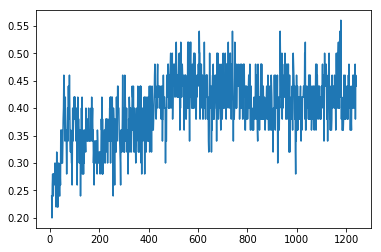

In [59]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject5

In [60]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train5, y_train5,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test5, y_test5))
times = time_callback.times
scores = model.evaluate(X_test5, y_test5, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8365 - acc: 0.2439 - val_loss: 1.7863 - val_acc: 0.2200
Epoch 2/1000
2542/2542 [==============================] - 1s 588us/step - loss: 1.7605 - acc: 0.2494 - val_loss: 1.7237 - val_acc: 0.2000
Epoch 3/1000
2542/2542 [==============================] - 1s 574us/step - loss: 1.6958 - acc: 0.2581 - val_loss: 1.6662 - val_acc: 0.2600
Epoch 4/1000
2542/2542 [==============================] - 1s 516us/step - loss: 1.6434 - acc: 0.2404 - val_loss: 1.6176 - val_acc: 0.3000
Epoch 5/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.6009 - acc: 0.2557 - val_loss: 1.5772 - val_acc: 0.2800
Epoch 6/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.5632 - acc: 0.2545 - val_loss: 1.5487 - val_acc: 0.2400
Epoch 7/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.5353 - acc: 0.2742 - val_loss: 1.5229 - val_ac

2542/2542 [==============================] - 1s 485us/step - loss: 1.3266 - acc: 0.4162 - val_loss: 1.4139 - val_acc: 0.3600
Epoch 60/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.3313 - acc: 0.3973 - val_loss: 1.4426 - val_acc: 0.2600
Epoch 61/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.3415 - acc: 0.4036 - val_loss: 1.4171 - val_acc: 0.3400
Epoch 62/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.3355 - acc: 0.3981 - val_loss: 1.4180 - val_acc: 0.3400
Epoch 63/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.3220 - acc: 0.4146 - val_loss: 1.4322 - val_acc: 0.3400
Epoch 64/1000
2542/2542 [==============================] - 1s 473us/step - loss: 1.3407 - acc: 0.4005 - val_loss: 1.4178 - val_acc: 0.3200
Epoch 65/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.3316 - acc: 0.4135 - val_loss: 1.3839 - val_acc: 0.4000
Epoch 66/1000
2542/2542 [================

Epoch 118/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.2981 - acc: 0.4481 - val_loss: 1.4164 - val_acc: 0.3400
Epoch 119/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.2865 - acc: 0.4579 - val_loss: 1.4084 - val_acc: 0.3600
Epoch 120/1000
2542/2542 [==============================] - 1s 506us/step - loss: 1.2725 - acc: 0.4709 - val_loss: 1.3931 - val_acc: 0.4800
Epoch 121/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.2653 - acc: 0.4740 - val_loss: 1.4249 - val_acc: 0.3200
Epoch 122/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.2839 - acc: 0.4528 - val_loss: 1.4843 - val_acc: 0.3400
Epoch 123/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.2683 - acc: 0.4744 - val_loss: 1.4560 - val_acc: 0.3400
Epoch 124/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.2861 - acc: 0.4563 - val_loss: 1.3402 - val_acc: 0.4400
Epoch 125/1000
2542/

2542/2542 [==============================] - 1s 477us/step - loss: 1.2482 - acc: 0.4854 - val_loss: 1.4128 - val_acc: 0.4000
Epoch 177/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.2364 - acc: 0.4827 - val_loss: 1.4051 - val_acc: 0.4000
Epoch 178/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.2474 - acc: 0.4811 - val_loss: 1.4051 - val_acc: 0.4400
Epoch 179/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.2301 - acc: 0.4815 - val_loss: 1.3640 - val_acc: 0.4200
Epoch 180/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.2525 - acc: 0.4870 - val_loss: 1.3452 - val_acc: 0.4600
Epoch 181/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.2614 - acc: 0.4776 - val_loss: 1.4371 - val_acc: 0.3800
Epoch 182/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.2336 - acc: 0.4933 - val_loss: 1.3905 - val_acc: 0.4800
Epoch 183/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 455us/step - loss: 1.2289 - acc: 0.4792 - val_loss: 1.3587 - val_acc: 0.4000
Epoch 235/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.2290 - acc: 0.4972 - val_loss: 1.3613 - val_acc: 0.4600
Epoch 236/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.2280 - acc: 0.4929 - val_loss: 1.3276 - val_acc: 0.5200
Epoch 237/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.2156 - acc: 0.4910 - val_loss: 1.2894 - val_acc: 0.5600
Epoch 238/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1931 - acc: 0.5075 - val_loss: 1.3807 - val_acc: 0.4200
Epoch 239/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.2053 - acc: 0.4858 - val_loss: 1.3383 - val_acc: 0.5000
Epoch 240/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.2053 - acc: 0.5071 - val_loss: 1.3164 - val_acc: 0.5400
Epoch 241/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 455us/step - loss: 1.1972 - acc: 0.4980 - val_loss: 1.4035 - val_acc: 0.4400
Epoch 293/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1855 - acc: 0.5110 - val_loss: 1.3339 - val_acc: 0.4800
Epoch 294/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.2083 - acc: 0.4815 - val_loss: 1.3366 - val_acc: 0.5200
Epoch 295/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1921 - acc: 0.5012 - val_loss: 1.3621 - val_acc: 0.4600
Epoch 296/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.1815 - acc: 0.5149 - val_loss: 1.3682 - val_acc: 0.4600
Epoch 297/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.1600 - acc: 0.5079 - val_loss: 1.3420 - val_acc: 0.4800
Epoch 298/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.1831 - acc: 0.5118 - val_loss: 1.3256 - val_acc: 0.5400
Epoch 299/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 468us/step - loss: 1.1532 - acc: 0.5260 - val_loss: 1.3493 - val_acc: 0.5000
Epoch 351/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1761 - acc: 0.5094 - val_loss: 1.3181 - val_acc: 0.4800
Epoch 352/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1736 - acc: 0.5161 - val_loss: 1.3967 - val_acc: 0.4800
Epoch 353/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.1816 - acc: 0.5110 - val_loss: 1.3651 - val_acc: 0.4200
Epoch 354/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1637 - acc: 0.5146 - val_loss: 1.4028 - val_acc: 0.4800
Epoch 355/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1796 - acc: 0.5000 - val_loss: 1.3534 - val_acc: 0.4600
Epoch 356/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.1560 - acc: 0.5149 - val_loss: 1.3117 - val_acc: 0.5200
Epoch 357/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 462us/step - loss: 1.1618 - acc: 0.5142 - val_loss: 1.3229 - val_acc: 0.5200
Epoch 409/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1649 - acc: 0.5197 - val_loss: 1.3591 - val_acc: 0.4600
Epoch 410/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1478 - acc: 0.5114 - val_loss: 1.3319 - val_acc: 0.4600
Epoch 411/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1374 - acc: 0.5240 - val_loss: 1.2861 - val_acc: 0.5600
Epoch 412/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.1343 - acc: 0.5271 - val_loss: 1.2919 - val_acc: 0.5000
Epoch 413/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1471 - acc: 0.5268 - val_loss: 1.3125 - val_acc: 0.4600
Epoch 414/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1478 - acc: 0.5382 - val_loss: 1.3293 - val_acc: 0.5000
Epoch 415/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 454us/step - loss: 1.1496 - acc: 0.5205 - val_loss: 1.3558 - val_acc: 0.5000
Epoch 467/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1507 - acc: 0.5149 - val_loss: 1.3705 - val_acc: 0.4400
Epoch 468/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.1431 - acc: 0.5291 - val_loss: 1.3379 - val_acc: 0.5200
Epoch 469/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.1361 - acc: 0.5252 - val_loss: 1.3510 - val_acc: 0.4600
Epoch 470/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1371 - acc: 0.5240 - val_loss: 1.3246 - val_acc: 0.5200
Epoch 471/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1545 - acc: 0.5149 - val_loss: 1.3452 - val_acc: 0.5200
Epoch 472/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.1475 - acc: 0.5185 - val_loss: 1.3322 - val_acc: 0.5000
Epoch 473/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 504us/step - loss: 1.1493 - acc: 0.5240 - val_loss: 1.3546 - val_acc: 0.3800
Epoch 525/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1520 - acc: 0.5232 - val_loss: 1.3324 - val_acc: 0.4800
Epoch 526/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.1411 - acc: 0.5295 - val_loss: 1.3786 - val_acc: 0.3800
Epoch 527/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1315 - acc: 0.5425 - val_loss: 1.3693 - val_acc: 0.4000
Epoch 528/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1132 - acc: 0.5157 - val_loss: 1.3324 - val_acc: 0.5000
Epoch 529/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1368 - acc: 0.5248 - val_loss: 1.3865 - val_acc: 0.4400
Epoch 530/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1437 - acc: 0.5114 - val_loss: 1.3217 - val_acc: 0.4600
Epoch 531/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 492us/step - loss: 1.1262 - acc: 0.5228 - val_loss: 1.3251 - val_acc: 0.5400
Epoch 583/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1414 - acc: 0.5197 - val_loss: 1.3573 - val_acc: 0.4600
Epoch 584/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0841 - acc: 0.5590 - val_loss: 1.3707 - val_acc: 0.4200
Epoch 585/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1349 - acc: 0.5165 - val_loss: 1.4069 - val_acc: 0.4600
Epoch 586/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.1339 - acc: 0.5146 - val_loss: 1.3638 - val_acc: 0.3800
Epoch 587/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.1300 - acc: 0.5240 - val_loss: 1.3099 - val_acc: 0.4600
Epoch 588/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.1059 - acc: 0.5366 - val_loss: 1.3362 - val_acc: 0.4400
Epoch 589/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 507us/step - loss: 1.1168 - acc: 0.5181 - val_loss: 1.3081 - val_acc: 0.4200
Epoch 641/1000
2542/2542 [==============================] - 1s 523us/step - loss: 1.0999 - acc: 0.5350 - val_loss: 1.3340 - val_acc: 0.4200
Epoch 642/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.1222 - acc: 0.5271 - val_loss: 1.3654 - val_acc: 0.4400
Epoch 643/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1157 - acc: 0.5256 - val_loss: 1.3429 - val_acc: 0.4200
Epoch 644/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1115 - acc: 0.5244 - val_loss: 1.2973 - val_acc: 0.4800
Epoch 645/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0987 - acc: 0.5386 - val_loss: 1.3341 - val_acc: 0.4200
Epoch 646/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0947 - acc: 0.5480 - val_loss: 1.3045 - val_acc: 0.4800
Epoch 647/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 465us/step - loss: 1.0956 - acc: 0.5413 - val_loss: 1.3141 - val_acc: 0.4600
Epoch 699/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1234 - acc: 0.5291 - val_loss: 1.3105 - val_acc: 0.5200
Epoch 700/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.0965 - acc: 0.5401 - val_loss: 1.3614 - val_acc: 0.5000
Epoch 701/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.1103 - acc: 0.5456 - val_loss: 1.3632 - val_acc: 0.5000
Epoch 702/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0949 - acc: 0.5283 - val_loss: 1.3343 - val_acc: 0.5200
Epoch 703/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.0996 - acc: 0.5287 - val_loss: 1.3446 - val_acc: 0.5000
Epoch 704/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.1037 - acc: 0.5366 - val_loss: 1.3411 - val_acc: 0.5600
Epoch 705/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 478us/step - loss: 1.1198 - acc: 0.5232 - val_loss: 1.2811 - val_acc: 0.5000
Epoch 757/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.1318 - acc: 0.5193 - val_loss: 1.3058 - val_acc: 0.4400
Epoch 758/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.1050 - acc: 0.5445 - val_loss: 1.3057 - val_acc: 0.4400
Epoch 759/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.1168 - acc: 0.5224 - val_loss: 1.2886 - val_acc: 0.5200
Epoch 760/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0804 - acc: 0.5350 - val_loss: 1.2903 - val_acc: 0.4600
Epoch 761/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1079 - acc: 0.5370 - val_loss: 1.3591 - val_acc: 0.4800
Epoch 762/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0972 - acc: 0.5268 - val_loss: 1.3058 - val_acc: 0.4400
Epoch 763/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 499us/step - loss: 1.0940 - acc: 0.5374 - val_loss: 1.3448 - val_acc: 0.4800
Epoch 815/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0966 - acc: 0.5429 - val_loss: 1.3076 - val_acc: 0.5400
Epoch 816/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1000 - acc: 0.5244 - val_loss: 1.2904 - val_acc: 0.5000
Epoch 817/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.1063 - acc: 0.5287 - val_loss: 1.2932 - val_acc: 0.5600
Epoch 818/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.1135 - acc: 0.5153 - val_loss: 1.2741 - val_acc: 0.5400
Epoch 819/1000
2542/2542 [==============================] - 1s 537us/step - loss: 1.0762 - acc: 0.5389 - val_loss: 1.2757 - val_acc: 0.4600
Epoch 820/1000
2542/2542 [==============================] - 1s 561us/step - loss: 1.1085 - acc: 0.5236 - val_loss: 1.2947 - val_acc: 0.5000
Epoch 821/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 454us/step - loss: 1.0784 - acc: 0.5472 - val_loss: 1.3075 - val_acc: 0.4600
Epoch 873/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.1004 - acc: 0.5146 - val_loss: 1.2951 - val_acc: 0.4400
Epoch 874/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.0825 - acc: 0.5559 - val_loss: 1.3215 - val_acc: 0.4400
Epoch 875/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0878 - acc: 0.5338 - val_loss: 1.2983 - val_acc: 0.4000
Epoch 876/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0901 - acc: 0.5307 - val_loss: 1.3332 - val_acc: 0.4800
Epoch 877/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0794 - acc: 0.5382 - val_loss: 1.3267 - val_acc: 0.4800
Epoch 878/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0740 - acc: 0.5460 - val_loss: 1.3412 - val_acc: 0.4800
Epoch 879/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 486us/step - loss: 1.0693 - acc: 0.5515 - val_loss: 1.2795 - val_acc: 0.4800
Epoch 931/1000
2542/2542 [==============================] - 1s 490us/step - loss: 1.0875 - acc: 0.5488 - val_loss: 1.2941 - val_acc: 0.4000
Epoch 932/1000
2542/2542 [==============================] - 1s 550us/step - loss: 1.0784 - acc: 0.5480 - val_loss: 1.2747 - val_acc: 0.4000
Epoch 933/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.0511 - acc: 0.5582 - val_loss: 1.2964 - val_acc: 0.4200
Epoch 934/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0933 - acc: 0.5547 - val_loss: 1.2717 - val_acc: 0.4800
Epoch 935/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0838 - acc: 0.5393 - val_loss: 1.3164 - val_acc: 0.4200
Epoch 936/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0780 - acc: 0.5500 - val_loss: 1.3201 - val_acc: 0.4200
Epoch 937/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 466us/step - loss: 1.0786 - acc: 0.5330 - val_loss: 1.3303 - val_acc: 0.4200
Epoch 989/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0690 - acc: 0.5323 - val_loss: 1.3762 - val_acc: 0.3400
Epoch 990/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.0725 - acc: 0.5397 - val_loss: 1.3230 - val_acc: 0.3800
Epoch 991/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0640 - acc: 0.5464 - val_loss: 1.3529 - val_acc: 0.3600
Epoch 992/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0657 - acc: 0.5370 - val_loss: 1.3568 - val_acc: 0.4000
Epoch 993/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.0558 - acc: 0.5496 - val_loss: 1.3302 - val_acc: 0.4200
Epoch 994/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.0714 - acc: 0.5358 - val_loss: 1.3456 - val_acc: 0.3800
Epoch 995/1000
2542/2542 [=========

0.6200000047683716


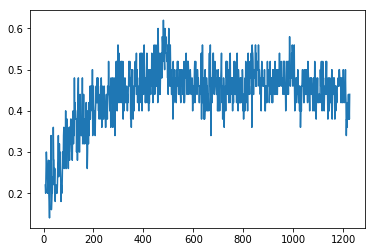

In [61]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject6

In [62]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train6, y_train6,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test6, y_test6))
times = time_callback.times
scores = model.evaluate(X_test6, y_test6, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 6s 3ms/step - loss: 1.8441 - acc: 0.2467 - val_loss: 1.8050 - val_acc: 0.2000
Epoch 2/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.7652 - acc: 0.2408 - val_loss: 1.7288 - val_acc: 0.2600
Epoch 3/1000
2542/2542 [==============================] - 1s 514us/step - loss: 1.6962 - acc: 0.2675 - val_loss: 1.6690 - val_acc: 0.2400
Epoch 4/1000
2542/2542 [==============================] - 1s 509us/step - loss: 1.6465 - acc: 0.2530 - val_loss: 1.6239 - val_acc: 0.2000
Epoch 5/1000
2542/2542 [==============================] - 1s 568us/step - loss: 1.6020 - acc: 0.2687 - val_loss: 1.5813 - val_acc: 0.2800
Epoch 6/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.5653 - acc: 0.2738 - val_loss: 1.5480 - val_acc: 0.2600
Epoch 7/1000
2542/2542 [==============================] - 1s 588us/step - loss: 1.5388 - acc: 0.2573 - val_loss: 1.5254 - val_ac

2542/2542 [==============================] - 2s 629us/step - loss: 1.3383 - acc: 0.3997 - val_loss: 1.3334 - val_acc: 0.4000
Epoch 60/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.3334 - acc: 0.4009 - val_loss: 1.3504 - val_acc: 0.4000
Epoch 61/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.3231 - acc: 0.4174 - val_loss: 1.3525 - val_acc: 0.4000
Epoch 62/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.3296 - acc: 0.4044 - val_loss: 1.3673 - val_acc: 0.3600
Epoch 63/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.3324 - acc: 0.4142 - val_loss: 1.3954 - val_acc: 0.3200
Epoch 64/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.3420 - acc: 0.4028 - val_loss: 1.3934 - val_acc: 0.3600
Epoch 65/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.3350 - acc: 0.4040 - val_loss: 1.3589 - val_acc: 0.4400
Epoch 66/1000
2542/2542 [================

Epoch 118/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.2994 - acc: 0.4457 - val_loss: 1.3481 - val_acc: 0.4200
Epoch 119/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.2802 - acc: 0.4473 - val_loss: 1.3525 - val_acc: 0.4600
Epoch 120/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.2794 - acc: 0.4614 - val_loss: 1.3248 - val_acc: 0.4600
Epoch 121/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.2813 - acc: 0.4528 - val_loss: 1.3783 - val_acc: 0.3800
Epoch 122/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.2844 - acc: 0.4481 - val_loss: 1.3411 - val_acc: 0.4000
Epoch 123/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.2912 - acc: 0.4493 - val_loss: 1.3641 - val_acc: 0.4400
Epoch 124/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.2896 - acc: 0.4591 - val_loss: 1.3913 - val_acc: 0.3800
Epoch 125/1000
2542/

2542/2542 [==============================] - 1s 480us/step - loss: 1.2504 - acc: 0.4851 - val_loss: 1.3426 - val_acc: 0.4200
Epoch 177/1000
2542/2542 [==============================] - 1s 499us/step - loss: 1.2503 - acc: 0.4732 - val_loss: 1.3651 - val_acc: 0.4000
Epoch 178/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.2563 - acc: 0.4685 - val_loss: 1.3538 - val_acc: 0.4000
Epoch 179/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.2435 - acc: 0.4768 - val_loss: 1.4131 - val_acc: 0.3800
Epoch 180/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.2396 - acc: 0.4898 - val_loss: 1.3882 - val_acc: 0.4200
Epoch 181/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.2460 - acc: 0.4870 - val_loss: 1.3503 - val_acc: 0.4200
Epoch 182/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.2518 - acc: 0.4803 - val_loss: 1.4031 - val_acc: 0.3800
Epoch 183/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 463us/step - loss: 1.2092 - acc: 0.5004 - val_loss: 1.3930 - val_acc: 0.4200
Epoch 235/1000
2542/2542 [==============================] - 1s 569us/step - loss: 1.2164 - acc: 0.5134 - val_loss: 1.3441 - val_acc: 0.4600
Epoch 236/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.2107 - acc: 0.5016 - val_loss: 1.3625 - val_acc: 0.4000
Epoch 237/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.2378 - acc: 0.4839 - val_loss: 1.4088 - val_acc: 0.3400
Epoch 238/1000
2542/2542 [==============================] - 1s 542us/step - loss: 1.2162 - acc: 0.5035 - val_loss: 1.3618 - val_acc: 0.4000
Epoch 239/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.2138 - acc: 0.5004 - val_loss: 1.3981 - val_acc: 0.4200
Epoch 240/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.2170 - acc: 0.4882 - val_loss: 1.3724 - val_acc: 0.4400
Epoch 241/1000
2542/2542 [=========

2542/2542 [==============================] - 2s 603us/step - loss: 1.2046 - acc: 0.5043 - val_loss: 1.3862 - val_acc: 0.3400
Epoch 293/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1997 - acc: 0.4917 - val_loss: 1.3818 - val_acc: 0.3800
Epoch 294/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1916 - acc: 0.4929 - val_loss: 1.3278 - val_acc: 0.3600
Epoch 295/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.1894 - acc: 0.4996 - val_loss: 1.3904 - val_acc: 0.3600
Epoch 296/1000
2542/2542 [==============================] - 1s 550us/step - loss: 1.1839 - acc: 0.5075 - val_loss: 1.3969 - val_acc: 0.3400
Epoch 297/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1922 - acc: 0.4980 - val_loss: 1.3732 - val_acc: 0.3400
Epoch 298/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.1616 - acc: 0.5185 - val_loss: 1.3763 - val_acc: 0.3600
Epoch 299/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 463us/step - loss: 1.1727 - acc: 0.5075 - val_loss: 1.3616 - val_acc: 0.3200
Epoch 351/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.1910 - acc: 0.4929 - val_loss: 1.3844 - val_acc: 0.2800
Epoch 352/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.1770 - acc: 0.5083 - val_loss: 1.3661 - val_acc: 0.3800
Epoch 353/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.1740 - acc: 0.5106 - val_loss: 1.3766 - val_acc: 0.3200
Epoch 354/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1731 - acc: 0.5067 - val_loss: 1.3488 - val_acc: 0.3600
Epoch 355/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.1684 - acc: 0.5075 - val_loss: 1.3380 - val_acc: 0.3600
Epoch 356/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.1879 - acc: 0.5146 - val_loss: 1.3080 - val_acc: 0.4000
Epoch 357/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 469us/step - loss: 1.1531 - acc: 0.5228 - val_loss: 1.3555 - val_acc: 0.4200
Epoch 409/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.1703 - acc: 0.5208 - val_loss: 1.3829 - val_acc: 0.3400
Epoch 410/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.1620 - acc: 0.5161 - val_loss: 1.4202 - val_acc: 0.3600
Epoch 411/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1589 - acc: 0.5295 - val_loss: 1.3726 - val_acc: 0.3600
Epoch 412/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1655 - acc: 0.5212 - val_loss: 1.3744 - val_acc: 0.3800
Epoch 413/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1570 - acc: 0.5138 - val_loss: 1.3728 - val_acc: 0.4200
Epoch 414/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1706 - acc: 0.5098 - val_loss: 1.3464 - val_acc: 0.4200
Epoch 415/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 459us/step - loss: 1.1332 - acc: 0.5248 - val_loss: 1.3400 - val_acc: 0.3800
Epoch 467/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1496 - acc: 0.5252 - val_loss: 1.3626 - val_acc: 0.4000
Epoch 468/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.1332 - acc: 0.5264 - val_loss: 1.3107 - val_acc: 0.4400
Epoch 469/1000
2542/2542 [==============================] - 1s 499us/step - loss: 1.1344 - acc: 0.5224 - val_loss: 1.3459 - val_acc: 0.4200
Epoch 470/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.1536 - acc: 0.5244 - val_loss: 1.3490 - val_acc: 0.4400
Epoch 471/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1366 - acc: 0.5330 - val_loss: 1.3233 - val_acc: 0.4600
Epoch 472/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.1453 - acc: 0.5224 - val_loss: 1.3734 - val_acc: 0.3800
Epoch 473/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 463us/step - loss: 1.1299 - acc: 0.5287 - val_loss: 1.3525 - val_acc: 0.3000
Epoch 525/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1449 - acc: 0.5067 - val_loss: 1.3547 - val_acc: 0.3400
Epoch 526/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.1516 - acc: 0.5106 - val_loss: 1.3622 - val_acc: 0.3600
Epoch 527/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.1408 - acc: 0.5161 - val_loss: 1.3666 - val_acc: 0.3200
Epoch 528/1000
2542/2542 [==============================] - 1s 492us/step - loss: 1.1355 - acc: 0.5437 - val_loss: 1.3540 - val_acc: 0.4200
Epoch 529/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1125 - acc: 0.5448 - val_loss: 1.3902 - val_acc: 0.3400
Epoch 530/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1370 - acc: 0.5177 - val_loss: 1.3527 - val_acc: 0.4200
Epoch 531/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 554us/step - loss: 1.0972 - acc: 0.5574 - val_loss: 1.3528 - val_acc: 0.3800
Epoch 583/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.1172 - acc: 0.5323 - val_loss: 1.3298 - val_acc: 0.4000
Epoch 584/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1228 - acc: 0.5256 - val_loss: 1.3568 - val_acc: 0.4200
Epoch 585/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.1152 - acc: 0.5291 - val_loss: 1.3724 - val_acc: 0.4000
Epoch 586/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.1280 - acc: 0.5358 - val_loss: 1.3427 - val_acc: 0.3600
Epoch 587/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.1175 - acc: 0.5370 - val_loss: 1.3618 - val_acc: 0.2800
Epoch 588/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.1033 - acc: 0.5386 - val_loss: 1.3666 - val_acc: 0.3600
Epoch 589/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 458us/step - loss: 1.1222 - acc: 0.5429 - val_loss: 1.3042 - val_acc: 0.4200
Epoch 641/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1191 - acc: 0.5244 - val_loss: 1.2968 - val_acc: 0.3800
Epoch 642/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1150 - acc: 0.5374 - val_loss: 1.2798 - val_acc: 0.4400
Epoch 643/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1169 - acc: 0.5299 - val_loss: 1.2907 - val_acc: 0.3400
Epoch 644/1000
2542/2542 [==============================] - 1s 490us/step - loss: 1.1266 - acc: 0.5232 - val_loss: 1.3065 - val_acc: 0.3200
Epoch 645/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0953 - acc: 0.5523 - val_loss: 1.2954 - val_acc: 0.3800
Epoch 646/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0885 - acc: 0.5413 - val_loss: 1.3089 - val_acc: 0.3800
Epoch 647/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 472us/step - loss: 1.0843 - acc: 0.5480 - val_loss: 1.2873 - val_acc: 0.4400
Epoch 699/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.0986 - acc: 0.5429 - val_loss: 1.2868 - val_acc: 0.3600
Epoch 700/1000
2542/2542 [==============================] - 1s 474us/step - loss: 1.0894 - acc: 0.5437 - val_loss: 1.2843 - val_acc: 0.3600
Epoch 701/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.1178 - acc: 0.5386 - val_loss: 1.2820 - val_acc: 0.4000
Epoch 702/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.1002 - acc: 0.5441 - val_loss: 1.2821 - val_acc: 0.4000
Epoch 703/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1056 - acc: 0.5248 - val_loss: 1.3144 - val_acc: 0.3800
Epoch 704/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1130 - acc: 0.5346 - val_loss: 1.3229 - val_acc: 0.3800
Epoch 705/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 478us/step - loss: 1.1047 - acc: 0.5342 - val_loss: 1.3917 - val_acc: 0.3000
Epoch 757/1000
2542/2542 [==============================] - 1s 534us/step - loss: 1.1152 - acc: 0.5374 - val_loss: 1.4182 - val_acc: 0.3200
Epoch 758/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0867 - acc: 0.5468 - val_loss: 1.3934 - val_acc: 0.3600
Epoch 759/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.1105 - acc: 0.5358 - val_loss: 1.3624 - val_acc: 0.3800
Epoch 760/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.1057 - acc: 0.5295 - val_loss: 1.3880 - val_acc: 0.3400
Epoch 761/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.0856 - acc: 0.5551 - val_loss: 1.3894 - val_acc: 0.3600
Epoch 762/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.0936 - acc: 0.5417 - val_loss: 1.3836 - val_acc: 0.3600
Epoch 763/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 460us/step - loss: 1.0802 - acc: 0.5350 - val_loss: 1.3905 - val_acc: 0.3400
Epoch 815/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1026 - acc: 0.5397 - val_loss: 1.3265 - val_acc: 0.3400
Epoch 816/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.0996 - acc: 0.5362 - val_loss: 1.3433 - val_acc: 0.3800
Epoch 817/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0823 - acc: 0.5409 - val_loss: 1.3416 - val_acc: 0.4000
Epoch 818/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0808 - acc: 0.5425 - val_loss: 1.4244 - val_acc: 0.3200
Epoch 819/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.0949 - acc: 0.5342 - val_loss: 1.3811 - val_acc: 0.3200
Epoch 820/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0893 - acc: 0.5389 - val_loss: 1.4448 - val_acc: 0.3200
Epoch 821/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 448us/step - loss: 1.0515 - acc: 0.5582 - val_loss: 1.3625 - val_acc: 0.3600
Epoch 873/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.0753 - acc: 0.5484 - val_loss: 1.3889 - val_acc: 0.3000
Epoch 874/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.0711 - acc: 0.5425 - val_loss: 1.3847 - val_acc: 0.3200
Epoch 875/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.0817 - acc: 0.5327 - val_loss: 1.3041 - val_acc: 0.3800
Epoch 876/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.0909 - acc: 0.5307 - val_loss: 1.3401 - val_acc: 0.3800
Epoch 877/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0897 - acc: 0.5393 - val_loss: 1.2827 - val_acc: 0.4200
Epoch 878/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0984 - acc: 0.5303 - val_loss: 1.3101 - val_acc: 0.3600
Epoch 879/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 455us/step - loss: 1.0707 - acc: 0.5511 - val_loss: 1.3773 - val_acc: 0.3200
Epoch 931/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0822 - acc: 0.5555 - val_loss: 1.3170 - val_acc: 0.3800
Epoch 932/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1005 - acc: 0.5397 - val_loss: 1.3048 - val_acc: 0.3600
Epoch 933/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0983 - acc: 0.5401 - val_loss: 1.3240 - val_acc: 0.3800
Epoch 934/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0740 - acc: 0.5480 - val_loss: 1.3291 - val_acc: 0.4000
Epoch 935/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0969 - acc: 0.5389 - val_loss: 1.2805 - val_acc: 0.3600
Epoch 936/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1115 - acc: 0.5275 - val_loss: 1.3353 - val_acc: 0.3800
Epoch 937/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 483us/step - loss: 1.0662 - acc: 0.5582 - val_loss: 1.2871 - val_acc: 0.4000
Epoch 989/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.0617 - acc: 0.5543 - val_loss: 1.3574 - val_acc: 0.3200
Epoch 990/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0760 - acc: 0.5472 - val_loss: 1.3372 - val_acc: 0.3400
Epoch 991/1000
2542/2542 [==============================] - 1s 513us/step - loss: 1.0782 - acc: 0.5488 - val_loss: 1.3098 - val_acc: 0.3400
Epoch 992/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0893 - acc: 0.5429 - val_loss: 1.3043 - val_acc: 0.3600
Epoch 993/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.0877 - acc: 0.5389 - val_loss: 1.3356 - val_acc: 0.3200
Epoch 994/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0694 - acc: 0.5559 - val_loss: 1.3005 - val_acc: 0.4000
Epoch 995/1000
2542/2542 [=========

0.5400000214576721


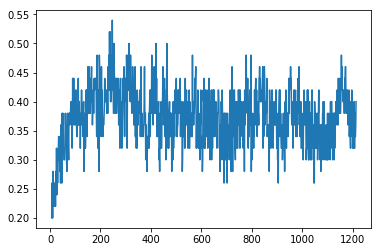

In [63]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject7

In [64]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train7, y_train7,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test7, y_test7))
times = time_callback.times
scores = model.evaluate(X_test7, y_test7, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8378 - acc: 0.2427 - val_loss: 1.7979 - val_acc: 0.2000
Epoch 2/1000
2542/2542 [==============================] - 1s 557us/step - loss: 1.7551 - acc: 0.2679 - val_loss: 1.7224 - val_acc: 0.1400
Epoch 3/1000
2542/2542 [==============================] - 1s 582us/step - loss: 1.6933 - acc: 0.2419 - val_loss: 1.6696 - val_acc: 0.2000
Epoch 4/1000
2542/2542 [==============================] - 1s 551us/step - loss: 1.6384 - acc: 0.2766 - val_loss: 1.6234 - val_acc: 0.2600
Epoch 5/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.5996 - acc: 0.2392 - val_loss: 1.5808 - val_acc: 0.2600
Epoch 6/1000
2542/2542 [==============================] - 1s 519us/step - loss: 1.5623 - acc: 0.2718 - val_loss: 1.5541 - val_acc: 0.1800
Epoch 7/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.5366 - acc: 0.2478 - val_loss: 1.5261 - val_ac

Epoch 60/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.3556 - acc: 0.3706 - val_loss: 1.3355 - val_acc: 0.4000
Epoch 61/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.3356 - acc: 0.3847 - val_loss: 1.3333 - val_acc: 0.4200
Epoch 62/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.3392 - acc: 0.3926 - val_loss: 1.3078 - val_acc: 0.4000
Epoch 63/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.3440 - acc: 0.3808 - val_loss: 1.3135 - val_acc: 0.4400
Epoch 64/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.3348 - acc: 0.3977 - val_loss: 1.2871 - val_acc: 0.4800
Epoch 65/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.3370 - acc: 0.3895 - val_loss: 1.3013 - val_acc: 0.4400
Epoch 66/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.3339 - acc: 0.3950 - val_loss: 1.3342 - val_acc: 0.4200
Epoch 67/1000
2542/2542 [==

Epoch 119/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.3000 - acc: 0.4461 - val_loss: 1.2646 - val_acc: 0.5000
Epoch 120/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.2954 - acc: 0.4540 - val_loss: 1.2997 - val_acc: 0.4800
Epoch 121/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.3032 - acc: 0.4504 - val_loss: 1.2623 - val_acc: 0.5200
Epoch 122/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.2676 - acc: 0.4717 - val_loss: 1.2381 - val_acc: 0.5000
Epoch 123/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.2941 - acc: 0.4540 - val_loss: 1.2032 - val_acc: 0.5000
Epoch 124/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.2857 - acc: 0.4599 - val_loss: 1.2434 - val_acc: 0.5600
Epoch 125/1000
2542/2542 [==============================] - 1s 511us/step - loss: 1.2946 - acc: 0.4575 - val_loss: 1.2577 - val_acc: 0.5400
Epoch 126/1000
2542/

2542/2542 [==============================] - 1s 460us/step - loss: 1.2503 - acc: 0.4933 - val_loss: 1.2208 - val_acc: 0.5600
Epoch 178/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.2349 - acc: 0.4976 - val_loss: 1.1849 - val_acc: 0.6000
Epoch 179/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.2603 - acc: 0.4898 - val_loss: 1.1608 - val_acc: 0.6200
Epoch 180/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.2500 - acc: 0.4988 - val_loss: 1.1516 - val_acc: 0.5800
Epoch 181/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.2333 - acc: 0.5016 - val_loss: 1.1492 - val_acc: 0.6200
Epoch 182/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.2048 - acc: 0.5252 - val_loss: 1.1794 - val_acc: 0.5600
Epoch 183/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.2375 - acc: 0.5031 - val_loss: 1.1512 - val_acc: 0.5600
Epoch 184/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 450us/step - loss: 1.2023 - acc: 0.5275 - val_loss: 1.1176 - val_acc: 0.6000
Epoch 236/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1986 - acc: 0.5323 - val_loss: 1.0992 - val_acc: 0.6800
Epoch 237/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1903 - acc: 0.5401 - val_loss: 1.1341 - val_acc: 0.6600
Epoch 238/1000
2542/2542 [==============================] - 1s 451us/step - loss: 1.1886 - acc: 0.5445 - val_loss: 1.0930 - val_acc: 0.6200
Epoch 239/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.2161 - acc: 0.5138 - val_loss: 1.1650 - val_acc: 0.5800
Epoch 240/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.2045 - acc: 0.5252 - val_loss: 1.1763 - val_acc: 0.5600
Epoch 241/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.2204 - acc: 0.5208 - val_loss: 1.1215 - val_acc: 0.6600
Epoch 242/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 456us/step - loss: 1.1591 - acc: 0.5692 - val_loss: 1.0794 - val_acc: 0.6600
Epoch 294/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.1843 - acc: 0.5334 - val_loss: 1.0797 - val_acc: 0.6800
Epoch 295/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.1762 - acc: 0.5393 - val_loss: 1.0842 - val_acc: 0.6800
Epoch 296/1000
2542/2542 [==============================] - 1s 511us/step - loss: 1.1773 - acc: 0.5433 - val_loss: 1.0802 - val_acc: 0.6400
Epoch 297/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1676 - acc: 0.5555 - val_loss: 1.0583 - val_acc: 0.7000
Epoch 298/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.1601 - acc: 0.5559 - val_loss: 1.1006 - val_acc: 0.6600
Epoch 299/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.1851 - acc: 0.5330 - val_loss: 1.0476 - val_acc: 0.7000
Epoch 300/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 440us/step - loss: 1.1444 - acc: 0.5602 - val_loss: 1.0461 - val_acc: 0.6000
Epoch 352/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.1467 - acc: 0.5747 - val_loss: 1.0818 - val_acc: 0.5800
Epoch 353/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.1352 - acc: 0.5830 - val_loss: 1.0683 - val_acc: 0.6400
Epoch 354/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.1340 - acc: 0.5846 - val_loss: 1.1283 - val_acc: 0.6000
Epoch 355/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1213 - acc: 0.5826 - val_loss: 1.0823 - val_acc: 0.6200
Epoch 356/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.1436 - acc: 0.5665 - val_loss: 1.1081 - val_acc: 0.5800
Epoch 357/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1598 - acc: 0.5645 - val_loss: 1.0494 - val_acc: 0.6600
Epoch 358/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 466us/step - loss: 1.1241 - acc: 0.5783 - val_loss: 1.0130 - val_acc: 0.7000
Epoch 410/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1465 - acc: 0.5681 - val_loss: 1.0144 - val_acc: 0.6200
Epoch 411/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.1220 - acc: 0.5751 - val_loss: 1.0158 - val_acc: 0.6800
Epoch 412/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.1122 - acc: 0.5877 - val_loss: 1.0493 - val_acc: 0.6600
Epoch 413/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.1319 - acc: 0.5944 - val_loss: 0.9859 - val_acc: 0.7400
Epoch 414/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.1177 - acc: 0.5846 - val_loss: 1.0324 - val_acc: 0.6800
Epoch 415/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.1293 - acc: 0.5791 - val_loss: 1.0031 - val_acc: 0.7200
Epoch 416/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 458us/step - loss: 1.1008 - acc: 0.5944 - val_loss: 0.9799 - val_acc: 0.7800
Epoch 468/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.1038 - acc: 0.5775 - val_loss: 0.9564 - val_acc: 0.7600
Epoch 469/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1349 - acc: 0.5665 - val_loss: 0.9862 - val_acc: 0.7000
Epoch 470/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0852 - acc: 0.6054 - val_loss: 0.9520 - val_acc: 0.7400
Epoch 471/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1207 - acc: 0.5873 - val_loss: 0.9542 - val_acc: 0.7600
Epoch 472/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1017 - acc: 0.5858 - val_loss: 0.9611 - val_acc: 0.7200
Epoch 473/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0995 - acc: 0.5865 - val_loss: 0.9652 - val_acc: 0.7200
Epoch 474/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 455us/step - loss: 1.1127 - acc: 0.5838 - val_loss: 0.9874 - val_acc: 0.7200
Epoch 526/1000
2542/2542 [==============================] - 1s 439us/step - loss: 1.1075 - acc: 0.5846 - val_loss: 1.0178 - val_acc: 0.6600
Epoch 527/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.0764 - acc: 0.6078 - val_loss: 0.9562 - val_acc: 0.7400
Epoch 528/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0971 - acc: 0.5940 - val_loss: 0.9592 - val_acc: 0.7200
Epoch 529/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0958 - acc: 0.5948 - val_loss: 0.9847 - val_acc: 0.6600
Epoch 530/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.1018 - acc: 0.5897 - val_loss: 1.0110 - val_acc: 0.6400
Epoch 531/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.1019 - acc: 0.5987 - val_loss: 0.9968 - val_acc: 0.7200
Epoch 532/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 472us/step - loss: 1.0927 - acc: 0.6023 - val_loss: 1.0060 - val_acc: 0.7000
Epoch 584/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0667 - acc: 0.6074 - val_loss: 1.0120 - val_acc: 0.7200
Epoch 585/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0800 - acc: 0.5987 - val_loss: 1.0084 - val_acc: 0.7000
Epoch 586/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0831 - acc: 0.6019 - val_loss: 1.0395 - val_acc: 0.6400
Epoch 587/1000
2542/2542 [==============================] - 1s 457us/step - loss: 1.0663 - acc: 0.6011 - val_loss: 0.9995 - val_acc: 0.7000
Epoch 588/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.1068 - acc: 0.5806 - val_loss: 1.0475 - val_acc: 0.6800
Epoch 589/1000
2542/2542 [==============================] - 1s 440us/step - loss: 1.0740 - acc: 0.6015 - val_loss: 1.0183 - val_acc: 0.6400
Epoch 590/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 437us/step - loss: 1.0577 - acc: 0.5983 - val_loss: 0.9997 - val_acc: 0.6800
Epoch 642/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.0701 - acc: 0.6109 - val_loss: 0.9812 - val_acc: 0.6400
Epoch 643/1000
2542/2542 [==============================] - 1s 433us/step - loss: 1.0538 - acc: 0.6133 - val_loss: 0.9648 - val_acc: 0.7400
Epoch 644/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.0965 - acc: 0.5881 - val_loss: 0.9805 - val_acc: 0.6600
Epoch 645/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.0818 - acc: 0.5944 - val_loss: 0.9964 - val_acc: 0.7200
Epoch 646/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.0557 - acc: 0.6125 - val_loss: 0.9987 - val_acc: 0.6800
Epoch 647/1000
2542/2542 [==============================] - 1s 449us/step - loss: 1.0631 - acc: 0.5991 - val_loss: 1.0090 - val_acc: 0.6400
Epoch 648/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 449us/step - loss: 1.0532 - acc: 0.6062 - val_loss: 0.9974 - val_acc: 0.7000
Epoch 700/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0787 - acc: 0.6054 - val_loss: 0.9930 - val_acc: 0.7000
Epoch 701/1000
2542/2542 [==============================] - 1s 438us/step - loss: 1.0728 - acc: 0.6031 - val_loss: 1.0183 - val_acc: 0.6600
Epoch 702/1000
2542/2542 [==============================] - 1s 432us/step - loss: 1.0599 - acc: 0.6023 - val_loss: 0.9723 - val_acc: 0.7000
Epoch 703/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.0703 - acc: 0.6054 - val_loss: 1.0034 - val_acc: 0.6400
Epoch 704/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.0698 - acc: 0.5991 - val_loss: 0.9942 - val_acc: 0.6600
Epoch 705/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0791 - acc: 0.6094 - val_loss: 1.0003 - val_acc: 0.6400
Epoch 706/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 450us/step - loss: 1.0234 - acc: 0.6200 - val_loss: 1.0060 - val_acc: 0.6000
Epoch 758/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0434 - acc: 0.6180 - val_loss: 1.0522 - val_acc: 0.6400
Epoch 759/1000
2542/2542 [==============================] - 1s 433us/step - loss: 1.0638 - acc: 0.6145 - val_loss: 1.0346 - val_acc: 0.6600
Epoch 760/1000
2542/2542 [==============================] - 1s 448us/step - loss: 1.0558 - acc: 0.6145 - val_loss: 0.9911 - val_acc: 0.6600
Epoch 761/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.0568 - acc: 0.6129 - val_loss: 1.0036 - val_acc: 0.7000
Epoch 762/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0397 - acc: 0.6129 - val_loss: 0.9883 - val_acc: 0.6600
Epoch 763/1000
2542/2542 [==============================] - 1s 447us/step - loss: 1.0248 - acc: 0.6184 - val_loss: 1.0071 - val_acc: 0.6600
Epoch 764/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 441us/step - loss: 1.0287 - acc: 0.6243 - val_loss: 0.9676 - val_acc: 0.7200
Epoch 816/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0481 - acc: 0.6223 - val_loss: 0.9942 - val_acc: 0.7000
Epoch 817/1000
2542/2542 [==============================] - 1s 450us/step - loss: 1.0289 - acc: 0.6267 - val_loss: 0.9637 - val_acc: 0.6600
Epoch 818/1000
2542/2542 [==============================] - 1s 463us/step - loss: 1.0456 - acc: 0.6094 - val_loss: 0.9726 - val_acc: 0.6800
Epoch 819/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.0352 - acc: 0.6247 - val_loss: 0.9996 - val_acc: 0.6800
Epoch 820/1000
2542/2542 [==============================] - 1s 445us/step - loss: 1.0562 - acc: 0.6070 - val_loss: 0.9739 - val_acc: 0.7000
Epoch 821/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0432 - acc: 0.6109 - val_loss: 0.9540 - val_acc: 0.7200
Epoch 822/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 441us/step - loss: 1.0204 - acc: 0.6341 - val_loss: 0.9908 - val_acc: 0.6600
Epoch 874/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0432 - acc: 0.6259 - val_loss: 0.9935 - val_acc: 0.6200
Epoch 875/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0620 - acc: 0.6054 - val_loss: 0.9912 - val_acc: 0.6600
Epoch 876/1000
2542/2542 [==============================] - 1s 444us/step - loss: 1.0526 - acc: 0.6200 - val_loss: 1.0154 - val_acc: 0.6600
Epoch 877/1000
2542/2542 [==============================] - 1s 443us/step - loss: 1.0539 - acc: 0.6054 - val_loss: 0.9658 - val_acc: 0.7000
Epoch 878/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.0059 - acc: 0.6381 - val_loss: 1.0137 - val_acc: 0.6000
Epoch 879/1000
2542/2542 [==============================] - 1s 469us/step - loss: 1.0427 - acc: 0.6074 - val_loss: 1.0319 - val_acc: 0.6400
Epoch 880/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 435us/step - loss: 1.0238 - acc: 0.6239 - val_loss: 0.9969 - val_acc: 0.6800
Epoch 932/1000
2542/2542 [==============================] - 1s 465us/step - loss: 1.0143 - acc: 0.6255 - val_loss: 0.9454 - val_acc: 0.7200
Epoch 933/1000
2542/2542 [==============================] - 1s 442us/step - loss: 1.0418 - acc: 0.6141 - val_loss: 0.9730 - val_acc: 0.6800
Epoch 934/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0175 - acc: 0.6314 - val_loss: 0.9386 - val_acc: 0.7400
Epoch 935/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.0150 - acc: 0.6263 - val_loss: 0.9400 - val_acc: 0.7000
Epoch 936/1000
2542/2542 [==============================] - 1s 454us/step - loss: 1.0289 - acc: 0.6212 - val_loss: 0.9480 - val_acc: 0.6800
Epoch 937/1000
2542/2542 [==============================] - 1s 441us/step - loss: 1.0194 - acc: 0.6235 - val_loss: 0.9601 - val_acc: 0.6800
Epoch 938/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 451us/step - loss: 1.0485 - acc: 0.6188 - val_loss: 1.0327 - val_acc: 0.6200
Epoch 990/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.0475 - acc: 0.6105 - val_loss: 0.9680 - val_acc: 0.7000
Epoch 991/1000
2542/2542 [==============================] - 1s 432us/step - loss: 1.0134 - acc: 0.6204 - val_loss: 0.9796 - val_acc: 0.6400
Epoch 992/1000
2542/2542 [==============================] - 1s 446us/step - loss: 1.0424 - acc: 0.6105 - val_loss: 0.9532 - val_acc: 0.7200
Epoch 993/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0037 - acc: 0.6298 - val_loss: 0.9827 - val_acc: 0.6800
Epoch 994/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.0400 - acc: 0.6255 - val_loss: 0.9611 - val_acc: 0.6800
Epoch 995/1000
2542/2542 [==============================] - 1s 437us/step - loss: 1.0048 - acc: 0.6330 - val_loss: 0.9797 - val_acc: 0.6400
Epoch 996/1000
2542/2542 [=========

0.7799999713897705


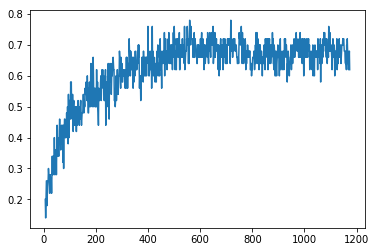

In [65]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject8

In [66]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train8, y_train8,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test8, y_test8))
times = time_callback.times
scores = model.evaluate(X_test8, y_test8, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8597 - acc: 0.2675 - val_loss: 1.8123 - val_acc: 0.2200
Epoch 2/1000
2542/2542 [==============================] - 1s 555us/step - loss: 1.7789 - acc: 0.2494 - val_loss: 1.7431 - val_acc: 0.2000
Epoch 3/1000
2542/2542 [==============================] - 1s 526us/step - loss: 1.7113 - acc: 0.2533 - val_loss: 1.6754 - val_acc: 0.2800
Epoch 4/1000
2542/2542 [==============================] - 1s 582us/step - loss: 1.6546 - acc: 0.2608 - val_loss: 1.6271 - val_acc: 0.2600
Epoch 5/1000
2542/2542 [==============================] - 2s 594us/step - loss: 1.6110 - acc: 0.2486 - val_loss: 1.5857 - val_acc: 0.3000
Epoch 6/1000
2542/2542 [==============================] - 1s 566us/step - loss: 1.5720 - acc: 0.2470 - val_loss: 1.5515 - val_acc: 0.3400
Epoch 7/1000
2542/2542 [==============================] - 1s 586us/step - loss: 1.5418 - acc: 0.2659 - val_loss: 1.5228 - val_ac

Epoch 60/1000
2542/2542 [==============================] - 1s 499us/step - loss: 1.3296 - acc: 0.3891 - val_loss: 1.3897 - val_acc: 0.4200
Epoch 61/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.3291 - acc: 0.4064 - val_loss: 1.3870 - val_acc: 0.3800
Epoch 62/1000
2542/2542 [==============================] - 1s 510us/step - loss: 1.3382 - acc: 0.3973 - val_loss: 1.3738 - val_acc: 0.3200
Epoch 63/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.3354 - acc: 0.3788 - val_loss: 1.3540 - val_acc: 0.3800
Epoch 64/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.3252 - acc: 0.3985 - val_loss: 1.3604 - val_acc: 0.3800
Epoch 65/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.3332 - acc: 0.4072 - val_loss: 1.3702 - val_acc: 0.3600
Epoch 66/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.3309 - acc: 0.3993 - val_loss: 1.3598 - val_acc: 0.3800
Epoch 67/1000
2542/2542 [==

Epoch 119/1000
2542/2542 [==============================] - 1s 536us/step - loss: 1.3054 - acc: 0.4382 - val_loss: 1.2980 - val_acc: 0.5200
Epoch 120/1000
2542/2542 [==============================] - 1s 509us/step - loss: 1.2902 - acc: 0.4469 - val_loss: 1.3061 - val_acc: 0.4600
Epoch 121/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.2874 - acc: 0.4457 - val_loss: 1.3199 - val_acc: 0.4600
Epoch 122/1000
2542/2542 [==============================] - 1s 508us/step - loss: 1.2979 - acc: 0.4473 - val_loss: 1.3307 - val_acc: 0.4400
Epoch 123/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.2904 - acc: 0.4445 - val_loss: 1.3350 - val_acc: 0.4800
Epoch 124/1000
2542/2542 [==============================] - 1s 511us/step - loss: 1.2687 - acc: 0.4689 - val_loss: 1.3515 - val_acc: 0.4400
Epoch 125/1000
2542/2542 [==============================] - 1s 514us/step - loss: 1.2716 - acc: 0.4595 - val_loss: 1.3095 - val_acc: 0.4400
Epoch 126/1000
2542/

2542/2542 [==============================] - 1s 506us/step - loss: 1.2411 - acc: 0.4957 - val_loss: 1.3409 - val_acc: 0.3800
Epoch 178/1000
2542/2542 [==============================] - 1s 506us/step - loss: 1.2556 - acc: 0.4803 - val_loss: 1.3420 - val_acc: 0.4000
Epoch 179/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.2416 - acc: 0.4980 - val_loss: 1.3156 - val_acc: 0.4600
Epoch 180/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.2266 - acc: 0.4988 - val_loss: 1.3565 - val_acc: 0.4200
Epoch 181/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.2486 - acc: 0.4709 - val_loss: 1.3618 - val_acc: 0.3800
Epoch 182/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.2501 - acc: 0.4725 - val_loss: 1.3470 - val_acc: 0.4200
Epoch 183/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.2466 - acc: 0.4913 - val_loss: 1.3803 - val_acc: 0.4600
Epoch 184/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 465us/step - loss: 1.2044 - acc: 0.5102 - val_loss: 1.3687 - val_acc: 0.3800
Epoch 236/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.2169 - acc: 0.4902 - val_loss: 1.3100 - val_acc: 0.4200
Epoch 237/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.1993 - acc: 0.5118 - val_loss: 1.3329 - val_acc: 0.3800
Epoch 238/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.1858 - acc: 0.5279 - val_loss: 1.3268 - val_acc: 0.3600
Epoch 239/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.2054 - acc: 0.5181 - val_loss: 1.3357 - val_acc: 0.5000
Epoch 240/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.2201 - acc: 0.4976 - val_loss: 1.3143 - val_acc: 0.4200
Epoch 241/1000
2542/2542 [==============================] - 1s 495us/step - loss: 1.2296 - acc: 0.4929 - val_loss: 1.3421 - val_acc: 0.4200
Epoch 242/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 481us/step - loss: 1.1962 - acc: 0.5114 - val_loss: 1.3578 - val_acc: 0.4000
Epoch 294/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.1799 - acc: 0.5138 - val_loss: 1.3604 - val_acc: 0.4000
Epoch 295/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.1951 - acc: 0.5189 - val_loss: 1.3432 - val_acc: 0.4800
Epoch 296/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1623 - acc: 0.5409 - val_loss: 1.3053 - val_acc: 0.4600
Epoch 297/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.1810 - acc: 0.5169 - val_loss: 1.3197 - val_acc: 0.4200
Epoch 298/1000
2542/2542 [==============================] - 1s 512us/step - loss: 1.2078 - acc: 0.5106 - val_loss: 1.3399 - val_acc: 0.4200
Epoch 299/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.1796 - acc: 0.5201 - val_loss: 1.3441 - val_acc: 0.4200
Epoch 300/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 531us/step - loss: 1.1589 - acc: 0.5441 - val_loss: 1.3453 - val_acc: 0.3800
Epoch 352/1000
2542/2542 [==============================] - 1s 520us/step - loss: 1.1837 - acc: 0.5232 - val_loss: 1.2825 - val_acc: 0.4800
Epoch 353/1000
2542/2542 [==============================] - 1s 518us/step - loss: 1.1642 - acc: 0.5334 - val_loss: 1.2886 - val_acc: 0.4800
Epoch 354/1000
2542/2542 [==============================] - 1s 530us/step - loss: 1.1588 - acc: 0.5386 - val_loss: 1.3336 - val_acc: 0.4600
Epoch 355/1000
2542/2542 [==============================] - 1s 509us/step - loss: 1.1675 - acc: 0.5460 - val_loss: 1.3217 - val_acc: 0.4000
Epoch 356/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.1823 - acc: 0.5165 - val_loss: 1.2507 - val_acc: 0.5000
Epoch 357/1000
2542/2542 [==============================] - 1s 526us/step - loss: 1.1743 - acc: 0.5201 - val_loss: 1.2940 - val_acc: 0.4200
Epoch 358/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 512us/step - loss: 1.1403 - acc: 0.5464 - val_loss: 1.2497 - val_acc: 0.4600
Epoch 410/1000
2542/2542 [==============================] - 1s 514us/step - loss: 1.1401 - acc: 0.5531 - val_loss: 1.2606 - val_acc: 0.5200
Epoch 411/1000
2542/2542 [==============================] - 1s 542us/step - loss: 1.1121 - acc: 0.5720 - val_loss: 1.2616 - val_acc: 0.5400
Epoch 412/1000
2542/2542 [==============================] - 1s 521us/step - loss: 1.1532 - acc: 0.5311 - val_loss: 1.2098 - val_acc: 0.5800
Epoch 413/1000
2542/2542 [==============================] - 1s 530us/step - loss: 1.1540 - acc: 0.5441 - val_loss: 1.2689 - val_acc: 0.3800
Epoch 414/1000
2542/2542 [==============================] - 1s 499us/step - loss: 1.1559 - acc: 0.5555 - val_loss: 1.2882 - val_acc: 0.4000
Epoch 415/1000
2542/2542 [==============================] - 1s 537us/step - loss: 1.1244 - acc: 0.5665 - val_loss: 1.2610 - val_acc: 0.5200
Epoch 416/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 552us/step - loss: 1.1327 - acc: 0.5555 - val_loss: 1.2913 - val_acc: 0.4400
Epoch 468/1000
2542/2542 [==============================] - 2s 601us/step - loss: 1.1269 - acc: 0.5629 - val_loss: 1.2994 - val_acc: 0.4600
Epoch 469/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.1386 - acc: 0.5712 - val_loss: 1.2143 - val_acc: 0.5200
Epoch 470/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.1093 - acc: 0.5716 - val_loss: 1.2515 - val_acc: 0.5400
Epoch 471/1000
2542/2542 [==============================] - 1s 484us/step - loss: 1.1411 - acc: 0.5559 - val_loss: 1.2681 - val_acc: 0.5600
Epoch 472/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.1327 - acc: 0.5555 - val_loss: 1.2672 - val_acc: 0.4800
Epoch 473/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.1462 - acc: 0.5460 - val_loss: 1.2303 - val_acc: 0.5600
Epoch 474/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 528us/step - loss: 1.1141 - acc: 0.5622 - val_loss: 1.1155 - val_acc: 0.5800
Epoch 526/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.1010 - acc: 0.5771 - val_loss: 1.1694 - val_acc: 0.5800
Epoch 527/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.1134 - acc: 0.5629 - val_loss: 1.1373 - val_acc: 0.5400
Epoch 528/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.1020 - acc: 0.5629 - val_loss: 1.2204 - val_acc: 0.4800
Epoch 529/1000
2542/2542 [==============================] - 1s 470us/step - loss: 1.1355 - acc: 0.5594 - val_loss: 1.1989 - val_acc: 0.5200
Epoch 530/1000
2542/2542 [==============================] - 1s 467us/step - loss: 1.1275 - acc: 0.5618 - val_loss: 1.2009 - val_acc: 0.5400
Epoch 531/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.1287 - acc: 0.5625 - val_loss: 1.2527 - val_acc: 0.4800
Epoch 532/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 498us/step - loss: 1.1333 - acc: 0.5696 - val_loss: 1.1690 - val_acc: 0.6200
Epoch 584/1000
2542/2542 [==============================] - 1s 462us/step - loss: 1.1077 - acc: 0.5795 - val_loss: 1.2064 - val_acc: 0.5400
Epoch 585/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.1137 - acc: 0.5708 - val_loss: 1.1466 - val_acc: 0.6200
Epoch 586/1000
2542/2542 [==============================] - 1s 478us/step - loss: 1.0866 - acc: 0.5810 - val_loss: 1.1845 - val_acc: 0.5600
Epoch 587/1000
2542/2542 [==============================] - 1s 476us/step - loss: 1.0960 - acc: 0.5747 - val_loss: 1.1581 - val_acc: 0.5600
Epoch 588/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.0979 - acc: 0.5704 - val_loss: 1.2802 - val_acc: 0.4800
Epoch 589/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0896 - acc: 0.5810 - val_loss: 1.1843 - val_acc: 0.5400
Epoch 590/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 476us/step - loss: 1.0914 - acc: 0.5873 - val_loss: 1.2027 - val_acc: 0.5800
Epoch 642/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0845 - acc: 0.5901 - val_loss: 1.2265 - val_acc: 0.5200
Epoch 643/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0603 - acc: 0.5980 - val_loss: 1.2134 - val_acc: 0.5600
Epoch 644/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.0949 - acc: 0.5783 - val_loss: 1.2107 - val_acc: 0.5600
Epoch 645/1000
2542/2542 [==============================] - 1s 508us/step - loss: 1.0924 - acc: 0.5862 - val_loss: 1.2278 - val_acc: 0.5800
Epoch 646/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0878 - acc: 0.5913 - val_loss: 1.2606 - val_acc: 0.4800
Epoch 647/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.0890 - acc: 0.5873 - val_loss: 1.2087 - val_acc: 0.5600
Epoch 648/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 468us/step - loss: 1.0458 - acc: 0.6070 - val_loss: 1.1598 - val_acc: 0.4800
Epoch 700/1000
2542/2542 [==============================] - 1s 459us/step - loss: 1.0784 - acc: 0.5921 - val_loss: 1.1953 - val_acc: 0.5800
Epoch 701/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0417 - acc: 0.6113 - val_loss: 1.1396 - val_acc: 0.5200
Epoch 702/1000
2542/2542 [==============================] - 1s 471us/step - loss: 1.0984 - acc: 0.5708 - val_loss: 1.1642 - val_acc: 0.5400
Epoch 703/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.0673 - acc: 0.5952 - val_loss: 1.1753 - val_acc: 0.5600
Epoch 704/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0799 - acc: 0.5905 - val_loss: 1.2085 - val_acc: 0.5600
Epoch 705/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.0654 - acc: 0.5964 - val_loss: 1.1882 - val_acc: 0.5600
Epoch 706/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 463us/step - loss: 1.0739 - acc: 0.5976 - val_loss: 1.1379 - val_acc: 0.5800
Epoch 758/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.0741 - acc: 0.5865 - val_loss: 1.1111 - val_acc: 0.6000
Epoch 759/1000
2542/2542 [==============================] - 1s 466us/step - loss: 1.0689 - acc: 0.5909 - val_loss: 1.2126 - val_acc: 0.5000
Epoch 760/1000
2542/2542 [==============================] - 1s 503us/step - loss: 1.0754 - acc: 0.5885 - val_loss: 1.1972 - val_acc: 0.5600
Epoch 761/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.0756 - acc: 0.6003 - val_loss: 1.1617 - val_acc: 0.5400
Epoch 762/1000
2542/2542 [==============================] - 1s 483us/step - loss: 1.0762 - acc: 0.5964 - val_loss: 1.1316 - val_acc: 0.5800
Epoch 763/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0463 - acc: 0.6007 - val_loss: 1.1282 - val_acc: 0.5400
Epoch 764/1000
2542/2542 [=========

2542/2542 [==============================] - 2s 611us/step - loss: 1.0618 - acc: 0.5940 - val_loss: 1.1363 - val_acc: 0.5400
Epoch 816/1000
2542/2542 [==============================] - 2s 609us/step - loss: 1.0544 - acc: 0.6125 - val_loss: 1.1795 - val_acc: 0.6000
Epoch 817/1000
2542/2542 [==============================] - 2s 598us/step - loss: 1.0894 - acc: 0.5873 - val_loss: 1.1343 - val_acc: 0.5600
Epoch 818/1000
2542/2542 [==============================] - 2s 609us/step - loss: 1.0739 - acc: 0.5917 - val_loss: 1.1950 - val_acc: 0.4800
Epoch 819/1000
2542/2542 [==============================] - 2s 611us/step - loss: 1.0615 - acc: 0.6035 - val_loss: 1.1460 - val_acc: 0.5800
Epoch 820/1000
2542/2542 [==============================] - 2s 606us/step - loss: 1.0697 - acc: 0.5999 - val_loss: 1.1603 - val_acc: 0.5000
Epoch 821/1000
2542/2542 [==============================] - 1s 575us/step - loss: 1.0580 - acc: 0.6039 - val_loss: 1.2159 - val_acc: 0.4800
Epoch 822/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 511us/step - loss: 1.0507 - acc: 0.6129 - val_loss: 1.1677 - val_acc: 0.5600
Epoch 874/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0620 - acc: 0.5976 - val_loss: 1.1593 - val_acc: 0.5800
Epoch 875/1000
2542/2542 [==============================] - 1s 498us/step - loss: 1.0493 - acc: 0.6031 - val_loss: 1.1283 - val_acc: 0.6600
Epoch 876/1000
2542/2542 [==============================] - 1s 567us/step - loss: 1.0480 - acc: 0.6094 - val_loss: 1.1477 - val_acc: 0.6000
Epoch 877/1000
2542/2542 [==============================] - 1s 502us/step - loss: 1.0487 - acc: 0.6007 - val_loss: 1.1751 - val_acc: 0.5800
Epoch 878/1000
2542/2542 [==============================] - 1s 484us/step - loss: 1.0541 - acc: 0.6062 - val_loss: 1.1551 - val_acc: 0.5600
Epoch 879/1000
2542/2542 [==============================] - 1s 521us/step - loss: 1.0577 - acc: 0.5917 - val_loss: 1.2056 - val_acc: 0.5400
Epoch 880/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 519us/step - loss: 1.0462 - acc: 0.6066 - val_loss: 1.1378 - val_acc: 0.6000
Epoch 932/1000
2542/2542 [==============================] - 1s 497us/step - loss: 1.0204 - acc: 0.6172 - val_loss: 1.1638 - val_acc: 0.5200
Epoch 933/1000
2542/2542 [==============================] - 1s 504us/step - loss: 1.0368 - acc: 0.6011 - val_loss: 1.1711 - val_acc: 0.5200
Epoch 934/1000
2542/2542 [==============================] - 1s 485us/step - loss: 1.0250 - acc: 0.6168 - val_loss: 1.1190 - val_acc: 0.5200
Epoch 935/1000
2542/2542 [==============================] - 1s 510us/step - loss: 1.0619 - acc: 0.5952 - val_loss: 1.1300 - val_acc: 0.5600
Epoch 936/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.0240 - acc: 0.6192 - val_loss: 1.2013 - val_acc: 0.5800
Epoch 937/1000
2542/2542 [==============================] - 1s 492us/step - loss: 1.0297 - acc: 0.6101 - val_loss: 1.1365 - val_acc: 0.6000
Epoch 938/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 512us/step - loss: 1.0368 - acc: 0.6090 - val_loss: 1.1687 - val_acc: 0.5000
Epoch 990/1000
2542/2542 [==============================] - 1s 509us/step - loss: 1.0120 - acc: 0.6322 - val_loss: 1.0712 - val_acc: 0.5800
Epoch 991/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.0397 - acc: 0.6168 - val_loss: 1.1081 - val_acc: 0.5600
Epoch 992/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.0458 - acc: 0.6180 - val_loss: 1.0939 - val_acc: 0.6000
Epoch 993/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0092 - acc: 0.6282 - val_loss: 1.1164 - val_acc: 0.6200
Epoch 994/1000
2542/2542 [==============================] - 1s 528us/step - loss: 1.0219 - acc: 0.6243 - val_loss: 1.1022 - val_acc: 0.6000
Epoch 995/1000
2542/2542 [==============================] - 1s 534us/step - loss: 1.0424 - acc: 0.6223 - val_loss: 1.1224 - val_acc: 0.5600
Epoch 996/1000
2542/2542 [=========

0.6800000071525574


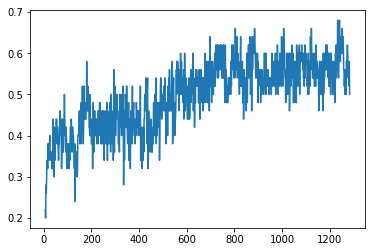

In [67]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

### Train all test subject9

In [69]:
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train9, y_train9,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=1000,
          verbose=1,
          validation_data=(X_test9, y_test9))
times = time_callback.times
scores = model.evaluate(X_test9, y_test9, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Train on 2542 samples, validate on 50 samples
Epoch 1/1000
2542/2542 [==============================] - 7s 3ms/step - loss: 1.8354 - acc: 0.2549 - val_loss: 1.7951 - val_acc: 0.2800
Epoch 2/1000
2542/2542 [==============================] - 2s 593us/step - loss: 1.7601 - acc: 0.2360 - val_loss: 1.7217 - val_acc: 0.2000
Epoch 3/1000
2542/2542 [==============================] - 1s 564us/step - loss: 1.6935 - acc: 0.2632 - val_loss: 1.6592 - val_acc: 0.2600
Epoch 4/1000
2542/2542 [==============================] - 1s 546us/step - loss: 1.6406 - acc: 0.2510 - val_loss: 1.6112 - val_acc: 0.2400
Epoch 5/1000
2542/2542 [==============================] - 1s 554us/step - loss: 1.5984 - acc: 0.2459 - val_loss: 1.5781 - val_acc: 0.2000
Epoch 6/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.5644 - acc: 0.2569 - val_loss: 1.5482 - val_acc: 0.2800
Epoch 7/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.5346 - acc: 0.2648 - val_loss: 1.5215 - val_ac

Epoch 60/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.3296 - acc: 0.3918 - val_loss: 1.2592 - val_acc: 0.5000
Epoch 61/1000
2542/2542 [==============================] - 1s 458us/step - loss: 1.3456 - acc: 0.3843 - val_loss: 1.2477 - val_acc: 0.4800
Epoch 62/1000
2542/2542 [==============================] - 1s 475us/step - loss: 1.3329 - acc: 0.4040 - val_loss: 1.2525 - val_acc: 0.4800
Epoch 63/1000
2542/2542 [==============================] - 1s 452us/step - loss: 1.3337 - acc: 0.4091 - val_loss: 1.2517 - val_acc: 0.5200
Epoch 64/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.3323 - acc: 0.3883 - val_loss: 1.2829 - val_acc: 0.4400
Epoch 65/1000
2542/2542 [==============================] - 1s 453us/step - loss: 1.3336 - acc: 0.4009 - val_loss: 1.2949 - val_acc: 0.4200
Epoch 66/1000
2542/2542 [==============================] - 1s 456us/step - loss: 1.3235 - acc: 0.4170 - val_loss: 1.2602 - val_acc: 0.4400
Epoch 67/1000
2542/2542 [==

Epoch 119/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.2842 - acc: 0.4583 - val_loss: 1.2569 - val_acc: 0.4200
Epoch 120/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.2908 - acc: 0.4524 - val_loss: 1.2232 - val_acc: 0.5200
Epoch 121/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.2874 - acc: 0.4646 - val_loss: 1.2281 - val_acc: 0.5200
Epoch 122/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.2696 - acc: 0.4607 - val_loss: 1.2113 - val_acc: 0.4800
Epoch 123/1000
2542/2542 [==============================] - 1s 468us/step - loss: 1.2870 - acc: 0.4630 - val_loss: 1.2668 - val_acc: 0.4800
Epoch 124/1000
2542/2542 [==============================] - 1s 484us/step - loss: 1.2854 - acc: 0.4717 - val_loss: 1.2270 - val_acc: 0.4600
Epoch 125/1000
2542/2542 [==============================] - 1s 455us/step - loss: 1.2769 - acc: 0.4685 - val_loss: 1.2463 - val_acc: 0.4800
Epoch 126/1000
2542/

2542/2542 [==============================] - 1s 486us/step - loss: 1.2374 - acc: 0.4866 - val_loss: 1.1935 - val_acc: 0.4600
Epoch 178/1000
2542/2542 [==============================] - 1s 479us/step - loss: 1.2609 - acc: 0.4831 - val_loss: 1.2228 - val_acc: 0.4800
Epoch 179/1000
2542/2542 [==============================] - 1s 460us/step - loss: 1.2563 - acc: 0.4670 - val_loss: 1.2371 - val_acc: 0.5200
Epoch 180/1000
2542/2542 [==============================] - 1s 461us/step - loss: 1.2397 - acc: 0.4839 - val_loss: 1.2061 - val_acc: 0.4800
Epoch 181/1000
2542/2542 [==============================] - 1s 464us/step - loss: 1.2497 - acc: 0.4854 - val_loss: 1.2067 - val_acc: 0.4800
Epoch 182/1000
2542/2542 [==============================] - 1s 507us/step - loss: 1.2285 - acc: 0.4803 - val_loss: 1.2700 - val_acc: 0.4600
Epoch 183/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.2542 - acc: 0.4717 - val_loss: 1.2159 - val_acc: 0.5000
Epoch 184/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 521us/step - loss: 1.2153 - acc: 0.4937 - val_loss: 1.1898 - val_acc: 0.5000
Epoch 236/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.2121 - acc: 0.5008 - val_loss: 1.1900 - val_acc: 0.5600
Epoch 237/1000
2542/2542 [==============================] - 1s 504us/step - loss: 1.2221 - acc: 0.4941 - val_loss: 1.1680 - val_acc: 0.5400
Epoch 238/1000
2542/2542 [==============================] - 1s 512us/step - loss: 1.2070 - acc: 0.5043 - val_loss: 1.1798 - val_acc: 0.4800
Epoch 239/1000
2542/2542 [==============================] - 1s 513us/step - loss: 1.2121 - acc: 0.5043 - val_loss: 1.1637 - val_acc: 0.5200
Epoch 240/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.2246 - acc: 0.4933 - val_loss: 1.1694 - val_acc: 0.4800
Epoch 241/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.2151 - acc: 0.4953 - val_loss: 1.1794 - val_acc: 0.4800
Epoch 242/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 531us/step - loss: 1.2079 - acc: 0.5047 - val_loss: 1.1240 - val_acc: 0.5400
Epoch 294/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.1910 - acc: 0.5201 - val_loss: 1.0982 - val_acc: 0.6000
Epoch 295/1000
2542/2542 [==============================] - 1s 521us/step - loss: 1.2055 - acc: 0.4910 - val_loss: 1.1365 - val_acc: 0.6000
Epoch 296/1000
2542/2542 [==============================] - 1s 569us/step - loss: 1.1945 - acc: 0.4957 - val_loss: 1.1415 - val_acc: 0.5000
Epoch 297/1000
2542/2542 [==============================] - 1s 516us/step - loss: 1.1838 - acc: 0.5028 - val_loss: 1.1159 - val_acc: 0.5200
Epoch 298/1000
2542/2542 [==============================] - 1s 513us/step - loss: 1.1837 - acc: 0.5134 - val_loss: 1.1453 - val_acc: 0.4600
Epoch 299/1000
2542/2542 [==============================] - 1s 514us/step - loss: 1.1805 - acc: 0.5232 - val_loss: 1.0854 - val_acc: 0.5400
Epoch 300/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 494us/step - loss: 1.1886 - acc: 0.5090 - val_loss: 1.1206 - val_acc: 0.6400
Epoch 352/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.1554 - acc: 0.5279 - val_loss: 1.1221 - val_acc: 0.6200
Epoch 353/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.1749 - acc: 0.5205 - val_loss: 1.1030 - val_acc: 0.5600
Epoch 354/1000
2542/2542 [==============================] - 1s 566us/step - loss: 1.1775 - acc: 0.5165 - val_loss: 1.1491 - val_acc: 0.5600
Epoch 355/1000
2542/2542 [==============================] - 1s 511us/step - loss: 1.1855 - acc: 0.5012 - val_loss: 1.0905 - val_acc: 0.6200
Epoch 356/1000
2542/2542 [==============================] - 1s 529us/step - loss: 1.1680 - acc: 0.5094 - val_loss: 1.1068 - val_acc: 0.5400
Epoch 357/1000
2542/2542 [==============================] - 1s 542us/step - loss: 1.1603 - acc: 0.5138 - val_loss: 1.1188 - val_acc: 0.4800
Epoch 358/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 506us/step - loss: 1.1511 - acc: 0.5264 - val_loss: 1.0665 - val_acc: 0.6000
Epoch 410/1000
2542/2542 [==============================] - 1s 499us/step - loss: 1.1253 - acc: 0.5535 - val_loss: 1.0580 - val_acc: 0.6200
Epoch 411/1000
2542/2542 [==============================] - 1s 503us/step - loss: 1.1828 - acc: 0.5142 - val_loss: 1.0881 - val_acc: 0.5800
Epoch 412/1000
2542/2542 [==============================] - 1s 518us/step - loss: 1.1846 - acc: 0.4925 - val_loss: 1.0846 - val_acc: 0.6000
Epoch 413/1000
2542/2542 [==============================] - ETA: 0s - loss: 1.1662 - acc: 0.513 - 1s 510us/step - loss: 1.1658 - acc: 0.5130 - val_loss: 1.1065 - val_acc: 0.5800
Epoch 414/1000
2542/2542 [==============================] - 1s 520us/step - loss: 1.1462 - acc: 0.5303 - val_loss: 1.0474 - val_acc: 0.5800
Epoch 415/1000
2542/2542 [==============================] - 1s 525us/step - loss: 1.1430 - acc: 0.5244 - val_loss: 1.0312 - val_acc: 0.64

2542/2542 [==============================] - 1s 490us/step - loss: 1.1456 - acc: 0.5153 - val_loss: 1.0666 - val_acc: 0.5400
Epoch 468/1000
2542/2542 [==============================] - 1s 528us/step - loss: 1.1457 - acc: 0.5260 - val_loss: 1.1426 - val_acc: 0.5800
Epoch 469/1000
2542/2542 [==============================] - 1s 481us/step - loss: 1.1479 - acc: 0.5311 - val_loss: 1.1164 - val_acc: 0.5600
Epoch 470/1000
2542/2542 [==============================] - 1s 512us/step - loss: 1.1390 - acc: 0.5299 - val_loss: 1.0835 - val_acc: 0.6000
Epoch 471/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.1327 - acc: 0.5256 - val_loss: 1.0594 - val_acc: 0.5600
Epoch 472/1000
2542/2542 [==============================] - 1s 514us/step - loss: 1.1426 - acc: 0.5401 - val_loss: 1.0840 - val_acc: 0.5200
Epoch 473/1000
2542/2542 [==============================] - 1s 513us/step - loss: 1.1397 - acc: 0.5374 - val_loss: 1.0687 - val_acc: 0.6200
Epoch 474/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 503us/step - loss: 1.1414 - acc: 0.5401 - val_loss: 1.1012 - val_acc: 0.6200
Epoch 526/1000
2542/2542 [==============================] - 1s 517us/step - loss: 1.1387 - acc: 0.5177 - val_loss: 1.0689 - val_acc: 0.6400
Epoch 527/1000
2542/2542 [==============================] - 1s 511us/step - loss: 1.1339 - acc: 0.5201 - val_loss: 1.0996 - val_acc: 0.5400
Epoch 528/1000
2542/2542 [==============================] - 1s 513us/step - loss: 1.1317 - acc: 0.5212 - val_loss: 1.0974 - val_acc: 0.5800
Epoch 529/1000
2542/2542 [==============================] - 1s 507us/step - loss: 1.1329 - acc: 0.5244 - val_loss: 1.0929 - val_acc: 0.5400
Epoch 530/1000
2542/2542 [==============================] - 1s 543us/step - loss: 1.1349 - acc: 0.5240 - val_loss: 1.0793 - val_acc: 0.6800
Epoch 531/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.1339 - acc: 0.5205 - val_loss: 1.1010 - val_acc: 0.6200
Epoch 532/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 507us/step - loss: 1.1174 - acc: 0.5303 - val_loss: 1.0086 - val_acc: 0.6600
Epoch 584/1000
2542/2542 [==============================] - 1s 507us/step - loss: 1.1125 - acc: 0.5342 - val_loss: 1.0203 - val_acc: 0.6600
Epoch 585/1000
2542/2542 [==============================] - 1s 543us/step - loss: 1.1087 - acc: 0.5334 - val_loss: 1.0323 - val_acc: 0.6400
Epoch 586/1000
2542/2542 [==============================] - 1s 496us/step - loss: 1.1059 - acc: 0.5405 - val_loss: 1.0377 - val_acc: 0.6000
Epoch 587/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.1398 - acc: 0.5197 - val_loss: 1.0740 - val_acc: 0.6200
Epoch 588/1000
2542/2542 [==============================] - 1s 504us/step - loss: 1.1357 - acc: 0.5165 - val_loss: 1.0549 - val_acc: 0.6000
Epoch 589/1000
2542/2542 [==============================] - 1s 495us/step - loss: 1.1123 - acc: 0.5299 - val_loss: 1.0596 - val_acc: 0.5800
Epoch 590/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 497us/step - loss: 1.1300 - acc: 0.5382 - val_loss: 1.0864 - val_acc: 0.5200
Epoch 642/1000
2542/2542 [==============================] - 1s 484us/step - loss: 1.1228 - acc: 0.5185 - val_loss: 1.0619 - val_acc: 0.5800
Epoch 643/1000
2542/2542 [==============================] - 1s 487us/step - loss: 1.1179 - acc: 0.5315 - val_loss: 1.1012 - val_acc: 0.5600
Epoch 644/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.1074 - acc: 0.5445 - val_loss: 1.0732 - val_acc: 0.5600
Epoch 645/1000
2542/2542 [==============================] - 1s 509us/step - loss: 1.1004 - acc: 0.5464 - val_loss: 1.1375 - val_acc: 0.4800
Epoch 646/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.1224 - acc: 0.5275 - val_loss: 1.0802 - val_acc: 0.5800
Epoch 647/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.1062 - acc: 0.5386 - val_loss: 1.0816 - val_acc: 0.5400
Epoch 648/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 492us/step - loss: 1.0803 - acc: 0.5433 - val_loss: 1.0908 - val_acc: 0.5200
Epoch 700/1000
2542/2542 [==============================] - 1s 520us/step - loss: 1.1054 - acc: 0.5397 - val_loss: 1.1300 - val_acc: 0.4800
Epoch 701/1000
2542/2542 [==============================] - 1s 553us/step - loss: 1.0975 - acc: 0.5342 - val_loss: 1.0498 - val_acc: 0.5800
Epoch 702/1000
2542/2542 [==============================] - 1s 531us/step - loss: 1.1090 - acc: 0.5315 - val_loss: 1.0831 - val_acc: 0.5400
Epoch 703/1000
2542/2542 [==============================] - 1s 517us/step - loss: 1.0994 - acc: 0.5429 - val_loss: 1.1638 - val_acc: 0.4600
Epoch 704/1000
2542/2542 [==============================] - 1s 498us/step - loss: 1.1201 - acc: 0.5319 - val_loss: 1.1274 - val_acc: 0.5000
Epoch 705/1000
2542/2542 [==============================] - 1s 530us/step - loss: 1.1078 - acc: 0.5327 - val_loss: 1.1399 - val_acc: 0.4800
Epoch 706/1000
2542/2542 [=========

Epoch 757/1000
2542/2542 [==============================] - 1s 522us/step - loss: 1.1014 - acc: 0.5496 - val_loss: 1.0367 - val_acc: 0.6400
Epoch 758/1000
2542/2542 [==============================] - 1s 490us/step - loss: 1.0733 - acc: 0.5429 - val_loss: 1.0515 - val_acc: 0.6000
Epoch 759/1000
2542/2542 [==============================] - 1s 477us/step - loss: 1.0993 - acc: 0.5456 - val_loss: 1.0634 - val_acc: 0.6400
Epoch 760/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0860 - acc: 0.5488 - val_loss: 1.0773 - val_acc: 0.5800
Epoch 761/1000
2542/2542 [==============================] - 1s 495us/step - loss: 1.1067 - acc: 0.5208 - val_loss: 1.0977 - val_acc: 0.6200
Epoch 762/1000
2542/2542 [==============================] - 1s 488us/step - loss: 1.1120 - acc: 0.5244 - val_loss: 1.0567 - val_acc: 0.6200
Epoch 763/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.1134 - acc: 0.5311 - val_loss: 1.0817 - val_acc: 0.6600
Epoch 764/1000
2542/

2542/2542 [==============================] - 1s 478us/step - loss: 1.0986 - acc: 0.5374 - val_loss: 1.0340 - val_acc: 0.6000
Epoch 816/1000
2542/2542 [==============================] - 1s 498us/step - loss: 1.0850 - acc: 0.5472 - val_loss: 1.0968 - val_acc: 0.5800
Epoch 817/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.0864 - acc: 0.5370 - val_loss: 1.1083 - val_acc: 0.5600
Epoch 818/1000
2542/2542 [==============================] - 1s 482us/step - loss: 1.0908 - acc: 0.5507 - val_loss: 1.0412 - val_acc: 0.6200
Epoch 819/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0932 - acc: 0.5350 - val_loss: 1.0463 - val_acc: 0.6000
Epoch 820/1000
2542/2542 [==============================] - 1s 504us/step - loss: 1.0924 - acc: 0.5417 - val_loss: 1.0211 - val_acc: 0.6000
Epoch 821/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0914 - acc: 0.5500 - val_loss: 1.0622 - val_acc: 0.6200
Epoch 822/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 479us/step - loss: 1.0836 - acc: 0.5563 - val_loss: 1.0542 - val_acc: 0.6200
Epoch 874/1000
2542/2542 [==============================] - 1s 503us/step - loss: 1.0923 - acc: 0.5429 - val_loss: 1.0482 - val_acc: 0.6800
Epoch 875/1000
2542/2542 [==============================] - 1s 528us/step - loss: 1.0778 - acc: 0.5543 - val_loss: 1.0368 - val_acc: 0.6000
Epoch 876/1000
2542/2542 [==============================] - 1s 472us/step - loss: 1.0893 - acc: 0.5504 - val_loss: 1.0503 - val_acc: 0.6200
Epoch 877/1000
2542/2542 [==============================] - 1s 494us/step - loss: 1.0708 - acc: 0.5378 - val_loss: 1.0340 - val_acc: 0.6400
Epoch 878/1000
2542/2542 [==============================] - 1s 480us/step - loss: 1.0779 - acc: 0.5500 - val_loss: 1.0383 - val_acc: 0.6400
Epoch 879/1000
2542/2542 [==============================] - 1s 504us/step - loss: 1.0931 - acc: 0.5448 - val_loss: 1.0538 - val_acc: 0.5800
Epoch 880/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 508us/step - loss: 1.0748 - acc: 0.5468 - val_loss: 1.0490 - val_acc: 0.6400
Epoch 932/1000
2542/2542 [==============================] - 1s 501us/step - loss: 1.0759 - acc: 0.5362 - val_loss: 1.0304 - val_acc: 0.6800
Epoch 933/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.0965 - acc: 0.5378 - val_loss: 1.0618 - val_acc: 0.6000
Epoch 934/1000
2542/2542 [==============================] - 1s 506us/step - loss: 1.0683 - acc: 0.5445 - val_loss: 1.0950 - val_acc: 0.6200
Epoch 935/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.0598 - acc: 0.5661 - val_loss: 1.0294 - val_acc: 0.7000
Epoch 936/1000
2542/2542 [==============================] - 1s 507us/step - loss: 1.0668 - acc: 0.5594 - val_loss: 1.0615 - val_acc: 0.5400
Epoch 937/1000
2542/2542 [==============================] - 1s 493us/step - loss: 1.0854 - acc: 0.5476 - val_loss: 1.0372 - val_acc: 0.6000
Epoch 938/1000
2542/2542 [=========

2542/2542 [==============================] - 1s 496us/step - loss: 1.0791 - acc: 0.5334 - val_loss: 1.0218 - val_acc: 0.6400
Epoch 990/1000
2542/2542 [==============================] - 1s 515us/step - loss: 1.0692 - acc: 0.5456 - val_loss: 1.0240 - val_acc: 0.6200
Epoch 991/1000
2542/2542 [==============================] - 1s 489us/step - loss: 1.0634 - acc: 0.5464 - val_loss: 1.0527 - val_acc: 0.6200
Epoch 992/1000
2542/2542 [==============================] - 1s 505us/step - loss: 1.0762 - acc: 0.5421 - val_loss: 1.1104 - val_acc: 0.5800
Epoch 993/1000
2542/2542 [==============================] - 1s 486us/step - loss: 1.0835 - acc: 0.5468 - val_loss: 1.0792 - val_acc: 0.5800
Epoch 994/1000
2542/2542 [==============================] - 1s 500us/step - loss: 1.0476 - acc: 0.5610 - val_loss: 1.0699 - val_acc: 0.6800
Epoch 995/1000
2542/2542 [==============================] - 1s 491us/step - loss: 1.0652 - acc: 0.5496 - val_loss: 1.0488 - val_acc: 0.6200
Epoch 996/1000
2542/2542 [=========

0.699999988079071


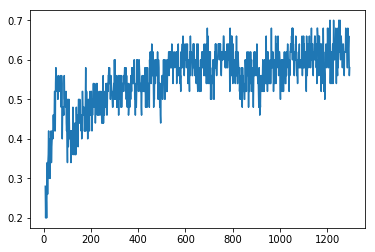

In [70]:
plt.plot(times[1:],acc_callback.testaccuracy)
print(max(acc_callback.testaccuracy))

In [31]:
X_newtrain = np.expand_dims(X_train, axis=-1)

In [37]:
X_newtrain.shape

(238, 1000, 22, 1)

In [46]:
# Try the paper preprocessing
A01T = h5py.File('A01T_slice.mat', 'r')
X = np.copy(A01T['image'])
y = np.copy(A01T['type'])

y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)-769
y = y[:,None]
X = X[:,0:22,:]
X = X.transpose(0,2,1)



where_are_NaNs = np.isnan(X)
X[where_are_NaNs] = 0
X = np.expand_dims(X, axis=-1)
print(X.shape)
print(y.shape)



# get train, validation, test data
data = get_train_test(X,y)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Reshape
np.expand_dims(X, axis=1)
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(10,1), strides=1,activation='relu', padding='valid',kernel_initializer='uniform',
                 input_shape=(1000,22,1)))
model.add(Dropout(0.5))
model.add(Reshape((22,25,991), input_shape=(991,22,25)))# 991*22*25
model.add(Conv2D(filters=991, kernel_size=(22,1), strides=1,activation='relu',padding='valid',kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Reshape((991,25,1), input_shape=(1,25,991)))# 991*25
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((330,25), input_shape=(330,25,1)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_newtrain, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))
times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

(288, 1000, 22, 1)
(288, 1)
X_train: (238, 1000, 22, 1) 
y_train: (238, 1) 
X_val: (50, 1000, 22, 1) 
y_val: (50, 1) 
X_test: (50, 1000, 22, 1) 
y_test: (50, 1) 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
dropout_26 (Dropout)         (None, 991, 22, 25)       0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 22, 25, 991)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 25, 991)        21606773  
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 25, 991)        0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 991, 25, 1

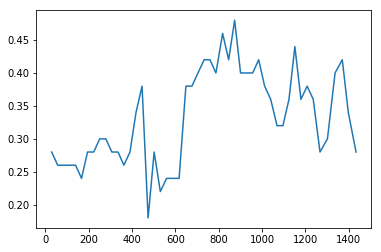

In [47]:
plt.plot(times[1:],acc_callback.testaccuracy)

In [13]:
from keras.layers import ActivityRegularization
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Conv1D, Conv2D, MaxPooling1D
model = Sequential()
model.add(Conv1D(25, kernel_size=1,strides = 10,
                 activation='elu',kernel_regularizer = regularizers.l2(0.01),
                 input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(25, kernel_size=25,strides = 22, activation='relu',kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3, strides = 1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))

# opt = RMSprop(lr=learning_rate)
opt = SGD(lr = 0.01, momentum = 0.9, decay = 0.0005, nesterov = False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()
time_callback = TimeHistory()
acc_callback = AccuracyHistory()
model.fit(X_train, y_train,callbacks=[time_callback,acc_callback],
          batch_size=50,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

times = time_callback.times
scores = model.evaluate(X_test, y_test, verbose=0)
print('RNN test score:', scores[0])
print('RNN test accuracy:', scores[1])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 25)           575       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 25)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 25)             15650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 25)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 64)             23040     
___________________________________________________________

NameError: name 'TimeHistory' is not defined

In [ ]:
#test